In [144]:
import pyfftw
import planfftw
#copied from the matlab by falsy winchnet.
#Emperical Fourier Decomposition technique
#uses fftw, pyfftw, planfftw for fast and easy precise decomp accuracy ~1.0-14 error
#which is around the precision FFT is capable of

def segm_tec(f,N):
# 1. detect the local maxima and minina
    locmax = numpy.zeros_like(f);
    locmin = numpy.ones_like(f);
    locmin = locmin * numpy.max(f)
    for i in range(1,len(f)-1): 
        if ((f[i-1]<f[i]) and (f[i]>f[i+1])):
            locmax[i]=f[i]
        if ((f[i-1]>f[i]) and (f[i]<f[i+1])):
            locmin[i]=f[i]
    locmax[0] = f[0];
    locmax[-1] = f[-1];
    print(len(f))
                  
    if N != 0: #keep the N-th highest maxima and their index
        desc_sort = -numpy.sort(-locmax)#perform a descending sort
        desc_sort_index = locmax.argsort()[::-1]
        
        if len(desc_sort) > N:
            desc_sort_index = numpy.sort(desc_sort_index[0:N])
        else:
            desc_sort_index = numpy.sort(desc_sort_index)
            N = len(desc_sort)
        M = N+1# numbers of the boundaries
        omega = numpy.concatenate(([0],desc_sort_index))
        omega = numpy.concatenate((omega,[len(f)]))
        bounds = numpy.zeros((M))
        for i in range(M):
            if (i == 0 or i == M) and (omega[i] == omega[i+1]):
                bounds[i] = omega[i]-1;
            else:
                ind = numpy.argmin(f[omega[i]:omega[i+1]])
                bounds[i] = omega[i]+ind-2;
        cerf = desc_sort_index*numpy.pi/round(len(f))
    return bounds, cerf


#https://arxiv.org/pdf/2009.08047v2.pdf
def EFD(x: list[numpy.float64], N: int):
    #we will now implement the Empirical Fourier Decomposition
    #what is it with me and signal decomposition approaches??
    x = numpy.asarray(x,dtype=numpy.float64)
    #we will assume that x is 1d, if x is 2d, test and transform to put rows-first
    
    fx =  planfftw.fft(x)
    ff = fx(x)

    #extract the boundaries of Fourier segments
    bounds,cerf = segm_tec(abs(ff[0:round(ff.size/2)]),N)
    bounds = numpy.concatenate(([0],bounds)) #fix : 5/10/22 temp patch for the first value
    # truncate the boundaries to [0,pi]
    bounds = bounds*numpy.pi/round(len(ff)/2)
    

    # extend the signal by miroring to deal with the boundaries
    l = round(len(x)/2)
    #x = [x(l-1:-1:1);x;x(end:-1:end-l+1)];
    z = numpy.concatenate((numpy.flip(x[:l]),x))
    z = numpy.concatenate((z,numpy.flip(x[-l:])))

    fr =  planfftw.fft(z)
    ff = fr(z)

    # obtain the boundaries in the extend f
    bound2 = numpy.ceil(bounds*round(len(ff)/2)/numpy.pi).astype(dtype=int)
    #bound2 = numpy.concatenate((bound2,[8000]))
    efd = numpy.zeros(((len(bound2)-1,len(x))),dtype=numpy.float64)
    ft = numpy.zeros((efd.shape[0],len(ff)),dtype=numpy.cdouble)
    fz =  planfftw.ifft(ft[0,:])
    # define an ideal functions and extract components
    for k in range(efd.shape[0]): 
        if bound2[k] == 0:
            ft[k,0:bound2[k+1]] = ff[0:bound2[k+1]]
            ft[k,len(ff)+2-bound2[k+1]:len(ff)] = ff[len(ff)+2-bound2[k+1]:len(ff)]
        else:
            ft[k,bound2[k]:bound2[k+1]] = ff[bound2[k]:bound2[k+1]]
            ft[k,len(ff)+2-bound2[k+1]:len(ff)+2-bound2[k]] = ff[len(ff)+2-bound2[k+1]:len(ff)+2-bound2[k]]
        rx = numpy.real(fz(ft[k,:]))
        efd[k,:] = rx[l:-l]


    return efd,cerf,bounds

In [152]:
import base64
import numpy
from PIL import Image
from io import BytesIO
cameramantiff_base64 = "TU0AKgAA/WgLnJ+em56cn56dnp6f/qA4nqOhoqCkoKWjoaOhpKWioaWlpKalpKanpaWkqqanp6qoqaapp6qpqaupq6mrqqmtrayrrbCusLSz/7L+tQOxtLKz/rQYsri1tre2t7W2t7a5uLW1t7i3uLe6uru4t/65Iba3ura4u7m8ubm6uLi2urq5tbq2trm3tLW2tbm2ura1t7b+tRaztbG0tbKytLO0sbO0srCyrrGyrbGxsP6sDLCusa2tqaypq6enpqf9qAOppqml/qYTpKappqimpainqKWmpqSjpJ+kpJ7+ogGhn/+h/58RoJubmpuZnJuenJubnJqXnJuY/psEmZyamZf/mAWgmp2enZ/+niCgm5yfnqCdpZ+hnqKioaOfoqSjpKWppKOloaOlqKelpKP+qf+qAKn+qg6uqqirq6moqqmqqa2orK7/r/+wBbOxsrGxtf+0/7L+tWK0t7W1trS4trWztLa2t7WztbG4tri8ubm4tbi2ubi2trW4ubi5ubi7t7u8ubm0urW3uri1ubi3t7i5t7i3tLm3uLO1ta+1srSxtLW1srWvsLK0rrGvsK+vrq+vsq2uraqrqqn8qwGqq/+p/qgAp/6oB6eoq6qlrKqm/6n/qP+lK6mloqOmoKCinqGmoqChoKCen56boJygoJucm5qZnpucnpibm52cnZubmpuZC5yfnpuenJ+enZ6en/6gOJ6joaKgpKClo6GjoaSloqGlpaSmpaSmp6WlpKqmp6eqqKmmqaeqqamrqaupq6qpra2sq62wrrC0s/+y/rUDsbSys/60GLK4tba3tre1tre2ubi1tbe4t7i3urq7uLf+uSG2t7q2uLu5vLm5uri4trq6ubW6tra5t7S1trW5trq2tbe2/rUWs7WxtLWysrSztLGztLKwsq6xsq2xsbD+rAywrrGtramsqaunp6an/agDqaappf6mE6SmqaaopqWop6ilpqako6SfpKSe/qIBoZ//of+fEaCbm5qbmZybnpybm5yal5ybmP6bBJmcmpmX/5gFoJqdnp2f/p4goJucn56gnaWfoZ6ioqGjn6Kko6SlqaSjpaGjpainpaSj/qn/qgCp/qoOrqqoq6upqKqpqqmtqKyu/6//sAWzsbKxsbX/tP+y/rVitLe1tba0uLa1s7S2tre1s7WxuLa4vLm5uLW4trm4tra1uLm4ubm4u7e7vLm5tLq1t7q4tbm4t7e4ube4t7S5t7iztbWvtbK0sbS1tbK1r7CytK6xr7Cvr66vr7Ktrq2qq6qp/KsBqqv/qf6oAKf+qAenqKuqpayqpv+p/6j/pSuppaKjpqCgop6hpqKgoaCgnp+em6CcoKCbnJuamZ6bnJ6Ym5udnJ2bm5qbmSqcmZufn5ucm5udm5qanqKdnZ6dn6GgoZ2dnJ+goaSeoaOepKWloqCgpqmm/6T/pw6kqKSmqqaop6mlraamqKf+qv+tLK+srLOts7G0s7Kws6+yrbO0s7Kvs7O4trS4t7OzsrS1trm2ure4urq+u7m3uv63DLy5uri6u7y7vL64ubr+u/+5Bbu8u7q6uf+7/7kBurT/uf+4FbS3tLa4tra0t7aztLK1tLK0sLGxta//sPyvCKutr6qrqqmnqP+n/6kToaqnqaipp6unq6mqqaamqaanp6X9pA+jpKKipKWjoKOhoZ2hop6f/53/nP+bEJ+amZyYmpiZmp2WmZqXlpiZ/5f+mw+dnJ+YnpyemJmfnJ2hoJ6h/p8LoaKioKWgop+ko6Wk/qcIpKmmpqylpqmq/6n/qgurqqitqqqppq+nq6j+rCCurKyvsbCzsbGysbO0s7K0s7C3tra1trW1trq4tbm2tbf/uv63Dbu6u7y5trq4ubq5ur27/7r/vQ2+u76+vLq9vLu5u7m4u/+6/7v/twW7ubq2t7n/tv+3Arm2uP63Era3trWzsbW0sbGzr7S0sayxs7H/r/+uGKytrKipqKerqaqnqKyqqKmqqKuop6elp6b9pwuoqaampKOhoKGgo57/n/+i/54Anf+f/54DoJ6cnv+Z/5cAmP2ZCpeYmJaYmo6NlZaZLJyZnZyZm5qbnZybnJudnqCdoKGiop+hnpufoKKhnqOmpaGkp6WoqKqlpqipqP+p/6oApv6s/6r/q0ysq62rq6qtsLKvr7CvrrKytLOytrWztLW2sbO2t7W4uLa6ube5uLi2ubi8uLi6u7y8vry7u728u767vbu/try/v8C8vcC8vry7urm5uP68CL25t7e4ubm2uf66Abm4/rcXtrizuLa1tLOysLKxsLCxsrKwr7CurK2w/qwSraysqqajqaWqqaeoqainp6SmpP6lD6mmqKemqKelpaGjop+in6H+ov+fH5yen6CenZ6cnpybnZqZnJiblpeWnJqYmJqZl5SYlpiV/58QnJ6cn52hop2dn6Gco56foZ7+oxOdop+mo5+op6WiqKinq6qpp6qqq/6sEaqurKywrq2vq66usK+tsaywsf6yH7OysrGztLW3qra0rri0s7S0tba4ubW6uLW4tba4t7e4/7f/uwS6vbu+vP+7/7obt7y9u7y8u7y8u8C+vb+6vLu+vru+u7y8vry6uf67Fb65u7i7uri7ubS3tLW6uLe0tba2tbH/s/+0MrKws7CzsbCtqq6qq6yrqautqKWqp6uoqa2oqqupqKWqpKimo6anp6Wnp6SepKOeop6eof6fHqOem5qim52XnJ2bnJaam5eWmZWbk5iVk5WVkpaZk5b+kxuem56anKCim5+hnKGgm56hoqKho56cpaCkoKSh/qcLqKeqp6uuqaqrr6qr/qj/qw+uqq2tqqyrq7CvrayvrK22/6//sP+xCa+ws7KzsrOurLL9syqxtrK2t7W1s7W0s7WytLa1trS3t7a5t7q3t7W2t7m3uLi3ure6vrm6u7q5/rr+uf+6Abm2/rkuuLa0tba1tbO2tbK2tbK0srizsrautbGwsa6xsqeusa2trLGvra2qqaqmp6ivqaj/qv2oBKqoqqeo/qMDpaSkpf+p/6cuo6elo6Kfo6SgnaCdnpijnJuen52inJ+dm56dm5uWmJmbmJWamZiWnZeYk5qVlpMWm5qdnqCgn6CeoaCgnqGeoKKfo6Gcn57/n/+hTaKlo6Wnp6mkqaeopqaopaaop6mpq6irqKqsrKipqaqpqaqsrq+tra6rrq+tr7Kur7Cwsa6wsLKwsrK0srS1tLK0sLG0s7GztLSzt7i1s/64Cbm1tLe2s7i2t7b+uRi4u725u7q8uLm4uLe4ubq5uri3tra5trW0/7X/tA6ztbS0sba0tLW0tbOysrP/sf6yCLGsrq6trK2srf6uLqiqpqmmpqSmqKeoqaunqaWnpqOkpqKip6KjqKampaekoqSjnp+eo6Cgn56foaCd/ZoWm5ydnJeZmpqcmpqWmZWZlJaVmJaUl5kAmv6dHpybn5qfnqGenqCfoKGfnaCin6Ggn6ChoqGkoqenqKn/p/+pFaapp6ippqaoqauqqKipqq2tp6qqrqr/rv+s/6v/rB+tr6yvrLGvrq+wsa+wr7GvsLCysbOysbO0srCzsrWztf+z/7b/txy4tLW2tbaztrW6t7a4ubq8ure2ubm3tLa1trm4t/64UrK2uLSzsraxtbOzsK+ys7O2tLeztLOzsbKvsLOwsrGysK2wrq+usKyvraqtrqqop6mtqKeoqaqrrKeoqaWspqemqKalo6imqKekpqOlo6Ohnp+c/qAPoaKeo56dnZyemp6Zm5qYm/2a/5kImpaXmZaZlpqbXpiWm5qYnJ2cnZqdn5ucn6CdoJyfnZ+goJ6gnqKjo6ejp6GmpailpaOkoaWkpaOoqKWqrKelqaarqaeqq6uoqbGsq6quq6uusrCtr66ur7GysLGwsK6tsrGytLS2sba3/rZBtLe1tra5t7e5t7q4ure5t7q5t7q1tbu9u769ubu7vLa7vLe3vbq+vrq4vbm6uru5t7i0ubW3ube4u7i4t7m3uLS4/7X/tA2xs7avsbCzsq+yrrGvrP+r/6oEramrqqj/q/+pHqemqKerqKulpaanrKaoqaSqqaSmqKagoZ+fo6Ghn6D+oRqen56dmpycm5+Zm5+WmpqZmpyZnpianZibmZQOnZmcm52goJ2fn6ChoKCe/6P/oP+iIJ6ioqOho6WopqWoqaatqKipp6mnpKeppqqora2sqKqtrv6sZq2uq62urq2vrbGxr66rrq6vrrCwsbCzsrKws7WytLC0t7G0uLe1t7K3tre4t7e2u7i3u7+4u7q2trm4uLm6vLq8u7q7ube6u7q7uru6ubu7urm4u7m7vLa4ubm2t723urm7t7q4ubj9tf+2BrS1tbK1tLP/sv+x/q82sKyrrKyqsKupqqqprKqsrKupqKqrp6mnqKmmqqappqmjq6qlpaalpKOjoKKinKSgoaCgnpubmf6cEZmdnJeamp2bmJmYmZuYmJqelwKXmp3/nP+eI5ydn56cn6GfoKGgoZ+koaOkoaSfpKalpKenpaqnqaiqqKiqqP6pC6itq7Ctq62sra6rrf+s/64Wr7CzsLGsrrCrrq6wsbGws7Cxs7K1sLL/tP+1Hbezt7a0s7a1tLW5t7i5u7m7ure4t7m7urm4tre7uv67C7i6u7u4t7q5u7u6vP65ELi8ubi4t7u0uLi2uLa3t7m3/bgWsre0s7SwtLOwsrCusbCwr7CysLGurq/+qiippqioqainp6iqqainqKmlpaSopp2mpKakpaWmpaShpaSjpKGhoJ2go/6hEZ+cnp6dnJ2enpqem5qYmpqXnP6ZBJiVl5aX/5QknJ2doJ+fnJ6foqGgoKGipJ+hpaWjp6SjpKOmqaaqp6emp6uvqv6sH6moqKyrq6qrq6yqq66wrqyqrqqrrq6yrayvsa+vrq2v/rEurrG0sLG0sbKxsrSytba1uLW2s7S1tra4tri3t7a5ubi6uri7s7q0tri3tby5ubr9uQO4ure5/7b+uAi5uLu4u7m4trj+thy6ubW2s7e3tLe2tLW0tLWusrOxrrCurrGtrquwrf6sJ6+yrKmoqaimp6appKWqqqelqKajqaalpKejo6Sjo6Slo6KipKOhoKH/nv+h/6Aen5ygn5yfnpyYm5yfmpualJmXmpibmpqWmZeSmJiVlg+dnp+dnZqZnp+boJ+hoZ+g/aT/piKhpqGlpKajoKamp6qsqqmtqaqqq6ivqqmoramsrLGqrayrsf6vB7Crq7a6srKs/q8CsbCu/rEGsq+vsbCys/61/rRjtbi0tLW2t7S0sre0tra3urWytre4uLK0tbi2tri5uba6tLa2tba1ubS2tri1s7a0t7a1tLOutLC0tLGwsbO0sLWysbK2sLOxsq+sra6wrayurK+tqautramqqbKnqaalqKOnpP+m/6kKpqiopaimp6Smoqb+pxurp6OnpaalpKKnpqSloKGhoqOeo6Ggn56fn5ye/p8QnKCYm5qdnZybn5ubmJaXmZz/mg2cnZ6fnaCenpydnZ+gnv6gBKGkpKCh/qAJn6Gjpqenq6mop/6oPKaop6aop6qoq6upq6qtq6ypq6qtqqqusK2vra2sra6ysq+xr7KvtLGzsba0srS1trWxtrSzt7O3s7e2trr/tv+3A7a5trj+tv+3ALj+t/+5CLe7vLq6ubi1uf+1/7cctrezuLa5trS3tra3tLS1srS0srO0tLaytLK2tLH+siivsK6ur66tr66rq62rq62rsa2qqqeop6iorKeoqKuoq6unpaSpp6amp/6mFKSnpqWnoqOjoqSloqOgoaGioKCfo/+h/Z4Hq5+bnZuZm5r+mwaanZqYmZea/5hOl5mdmJycm5ydnZudoJ2co6OhoqKkoqKhpaWkoaSjqKWnqKeoqKSpp6yoqqaqpqusrK2srLGqrqysr6mrsKyusbCxr6+ur7Cvr7Cyr7Kwtf2yULSzt7e0tbSztbSytbO0tLa4s7a2tLa4t7y4ubi2t7W4tbe5ubi6uLy6u7q6uLe3trm0treyt7e2tbSzs7W3s7O1s7O1trezs7iws7S0s7Kysf6wMrKur7Gurq+ura+sq62ssayqqaqmqqiqqKmopqutrKqoq6mpp6akqKWkqKipp6impKSjpP6jIqSioqOhoKGgoqKhoqCcnaCcn52cmJuYnZydn52bmpuWmJeYDZmbmpmcm5mbmZuanJuZ/5//ogKeoaL+oH+fnaCdnqOjpaKkqKekp6akpKWnp6mmpamoqq2trqytq66qrq+vqq6vra6xr7CwtLOztK+0tLK1trO0sbSytbS2trm2tLe6t7W5urm2sre6vL26v7i6vLu8vr+7vr2+vry9vL+6vru9u7i4uri7uru7tru6urm3tbm3tri2urW4uQS2ubS3uP61FbGytK+wsrazrrG3ra+yr7CusK6rrqv/qv+sQ6ulqKmtqqymqKurqaqqqKmnqKalqKmnpqenpqempKWnpaajpKShpKamo6Sjn6KfoZucnZ6gm52bn5ufm56cn5mdmZqd/5slmJqYnJ+anJuhnZ2hoJ+ioaGipaOgoqOlp6GfpKOiqKeqqaupqar+qQinqqitqq2qqK7+rRWusLOxr7GusrCwr7O0sLKzs7G1s7O1/7T/sheztLaxtLWztra0uLW6tbq1uLe3ube4uLf+uRO8vbu8ur64v7y6vLm8uru7ucC9vPy5Bry6ubq7uLv7uRW3tra4u7q6uLe3tbaxtLexsLO1s7Oy/7P/rRWxr62uoamurairq62qp6mqqqakrKiq/qcYq6apqaaqo6WkpaWnpaSmpqOmpaOjpqOgo/6gA6GgoZ7+of+fDZyXmpmbmpqZnJqdm5qe/psEmZiXmZr/lwWanZucnZr8nhqioJ+goaCjo6GkoZ+io6GkoqKmo6aopqeopqX+pwuppqmoqKutrK6ssK7+sP+vA66rsq/+sQavsbOzsrGz/rL/sxqxs7SytLKzsrO3trS1uLS4tre5uLu3trm5urX/uf+7Jb25ubq3uLe5uLm6t7q3vLe6u7m3uLe2ube6trW4t7i1t7m2trKz/rT/sQCv/7T/sgy1sLOxsrGusK+ur7Cu/63/rB6ura2sqqmrqqunqaaqp6emp6apqKipqKippqqopKan/aUiqaelp6emo6GgpKCjoqGgpKKioaCdn6Cgm5qem5qcmZqYnZz/m/+cCJ6cnZqZlpqXm3+bmZubn6CfoZ6foKGfn6KhoqSjpKKio6CjoaWopKakpamopKmoqquspqinqaioqq6tr62tr62sra6vrrCusK6qsa6yrbKwsrGwr7O1srOyr7CytLGxsrazs7S3tLW3uLe5t7m4t7m5s7u6uLm9u7u6t7q1u7u4t7m5t7i5t7i3uCa6t7O5tre2t7q3s7m6trm4s7S2srSzsri0tLK0sLSxta+usLCtrq3+rgasrausr62r/6z+qAWppqmmpqj+pBGlpqimp6alqKmmo6eipqOko6L/o/+kCKOlo6GcnqKhnP6gHp+gnZ+foJybnpyanJyYnZecm5yanJuem5ydnJuamZb/lyGZm5mcm5udnJ2coKCdoKOjoKSioqSgpKKloqOhpaWmqKao/qcHpqSqpaekqKf+qf+q/6w/q6ytrKquq6ytq6utrqitsLGzsa62sa2vrq6yrrOvs7K1sLWwuLW2tba3tLa1t7a2tbm0t7S1uLm5vLe5uLi2tf+3/7YcuLe4uLG2t7i2tbW0tra5uLe4ube1uLi1tLKyr7X/tv+xHLOxs7GxtbKysbKuq7Cxs6uyrK6srqmpq62prKaq/6j/qxenpaqpp6uprKerqKelq6Opp6mmqqWjp6P/pv+i/6UNoaOioqWioaSioaOjn6L+nxShn6Kgn5+gl52cnZ6goqCjoJ2cn5wMlpebmpuanJienZ6fm/2fLaKhnKChoKGgoJ2eoaCio6WipKSgpqOmpqmopqekqqmrqqarqqyoqaurqayqqar+rQusrbCorq2sq66uq6//sP+xLa6vsLO1s7S2tri0s7q2s7a3tLe3tr24urm6urm6vbm4u7u5ury7ubq3ubi7urv/uf+6Drm7ubu6u7y7uLm5uri3uP+3/7j/tv+1DrS2s7Syr7O0s7KvsrOysf+w/68MrbCvrbCrraeqp6utp/+p/6j/pg2lq6qnqaeopqqopqappP+m/6UVpKWjnqSjoqSgn6GdnqKfoaKhnKGenf+e/58QmJyaoZ2fnp6inp6dm5manpv/nQiZmpebmpmbnZ79nf+hPpyenqCcnp+goZ+foKOipKSipKaioaOpqKenpqSppKaoqKepqqenqaysraqsqqqrramsrK6tsKyrrq2vrq2vrv6w/68YsLSysbK0tbO0s7O2tLK1uba5tLO2ubm3uf+7/7oCubu5/7r+uTy7urm4vLy7vLm4vLm8vLu9urq7uby8uby6trm3tre2t7m3tLeztLWzs7SysrGyrrGzsbOvrq+qrq+trKyt/6n+qv6oOqqpqqWnqaulpaepqKirpqalpqKmpKSioaSkpqCioaKjoqKgn56ioJ+fnqCfnZyanJybmpibnJybnpmX/Z0Dmpibmf+aSpucm5ybnJ6an6GgnZ2gop6inaKio6Kin6Gjo6KepaamqKWiqKqnpaanpKapqK2lqqyrqaitrq2sqK6tqqyuq66srK6zsbGwr6ywrf6yHK+1s7C2tbS2tbW2t7S2t7i5t7a3u7y8urW7trq8/rsXvbu9ury9vLu9vr67vbu/vby8u7y+v769/r4Fu7y6vL/A/73/vA+7t7m2try5trW2trG1sbSy/7H/sAuxsLGus62wr7Gtr6r+qzGtq6ump6qnpaemqaepqKiuqaaoqKanpqelpqGeoaSjpKKhoKWjn6OhoJ6fnZyfnKCcov6dEp+anJqemJmgm52cl5eWmpmZmJs1op2bmpybnJ2boZ2hoqOioaOon6Omo6ShoqOlpqWkpqWpqqisqaunrKuop6ipraytrK2tr66s/q81q6+prqysr7Csra+trrGwsK+wsbCwsbK1sLCxtraytq64t7a0ubKztLSzurq1ube5vLvAubq9/rs/vby7vb+7vby/vb++vb2+ubq8ub67vry+vbu+vb2+ury5u7q6ube6t7m4tbe1tbK0s6+vsrGzr7Cwsa6rqqqsq/6qAqiqpv+o/6c+pqmnpqKoqKmnpaampaOopKakpqWnpqGgoqGgoaCfnZ6dn5+dnp6doKCanpucmpuZmZibmpmcnZuemZual5eY/5f/mACXIp6bnJ2gnZ2inaCeo6KfoKKio6GloaSmoqShp6SkqaSnpqin/akCqqmn/qwQrq+ura2ura2wrrOyrqyvra7/rP+t/q4FrLGxrq+t/a8Ds7CxsP6zBrSxtLe0s7T+sgu0tba3tba3uLq4urj+uQG8uf+7/7pWu7q6vL+9vru7vLq5uLe6uri5urm8uLu9ubu6ubu5t7i0t7W3uLe1tLWysLSxsrKxsLGysLKura2ur62tqK2qrKaqpqurp6mlqKimpaWpqK2oqamopqan/6T/oxaloaSgoaKkoZ+inaCgoZ6joJ+fnZ6boP6cFZqdn5ebmJ+bmpuYmp2Xmpibl5iam5oUoZ2enZ+cnJ2gn6Kfop2jpaKjpaKh/qUKoqOlpqakpqerpaj9qQqrqKqsr62rq66pq/6uILKvrK2rrK2trK+urK6wqbCusa2srrGur7GxsrGxtLW1s/60E7eys7OytrS3tri4t7a3uLq2ubq5/roHtrm6uru6u7r+vAC9/7v+vTa5t7e6vLu5ub66ury4uri5u7m6uLq3tbm3tLO6trW2tbSzs7GwrrCysLOws66wrrGssLCsrqyo/qtEqqyoqKmop6mmq6moqqOoqKelpaelpqSlo6SgpaChoZ2eo6CjpJ6foKKen5menZ2bnJ6bnJuem52ZnZmdnZibm5mcmpeZB56fo52em6Of/57/ohWhpKOmoqaepaWopKKkpaSipaGipKKn/6b/qTqnqKiqraipq6qosKmmramtsK6qq6qwrK2rr6qprayurauprK+tsKyrrrOur6yrrrC1s7OvsrCwsbKys/2y/bUEtLKzs7b+twW6vLW4trr/uP+5Db64ubm2tLW2tre2ubq5/bj/uv+5ELq5t7m4vLS3uLO7t7O1srOw/rEEs7SzsrP9sROvsrOzr66rr6urrKuurayrqKiqq/+q/qkIqKqoqKKqqqWn/6T/philoqaioaKln6ChnqCioaGfoqOhoaCan5ic/57+mw2dmpadm5ybmJibmpSbnP+a/5xen5ucn52fn52eoqSioaSioaOkpKOio6SioqOlpKeppqenpayqqaqnq6quq6utrKuqsK2wq66ssK2srK2urK6wsq6ytK6xrLCxs7Ows7G0tbCztLKwsrS2tbG0srO1srX/tv+3DLq1ubm6ubq7u7y9u777vAu9u729ubq3ure6uLn/uv+5/7wxu7y7vbu6ubm4t7u6ure0tbi3trm2tbi3tbG1s7KzsbK2srO1srGyr7Cur62vraupqqz+qTmtqquvqamop6mlramnp6mnpaWmpKKloKCfo6KioJyfoKOdoZ+inp6do5ucnJudmZybmpqZm5yZnJya/pkBm5QMmJubnJ6bnaChnqGhoP6h/6I2oaOlpKWlpKalpaelpqanqqupqaesqqqurKuqra2qq62rrrGtsK6vrLCtrK2wrK2usbOws7GvsP6yGayyrrCus7O0srS1tLe2sbS0s7G0tbK2tre4/7f+tha8uLq5vbi4ubq9vbq5urq8uLi5u7q4tP+3/7kRuLm4t7i6u7m6u7u6ubi5t7e5/rcItLaxtLiztLSw/rQjsbKxsa+ysK+xsK+zrrGvrqyrrKqrrKqtqqisqKmnqaypqqap/qcdpKamp6Slo6Kko5+ioJ6gm6CdnZ6dn6CenJygnZqY/5r/lwSamJmXmP6XB5uWl5iWmJaTEpqbnJucmqCanKCdoaGfoqGho6H+ojujpaSnqaapo6mnqqiqqqWsqayrq62rrKyvrKytr66vrLGxr7Sys7GsrLGwr7CxsrGztbGxsLKysbCysrX+tDW3trWztbS1uLe1tra1tri5uLW3ubu4t726ubq8ur29u7y6vLm6uru6ubq4trm1uLm3s7W0uLb+uP+6Cri5tri3tra4tre4/7X/s/+1XrKxtLKxsa+wsLKwra+0r7KxrquqsK2rqq2sra6tq6yqqaqop6imp6iopqSopaSjpqSmpKeio6Gho5+eoqGcnp+cnKGenp2boJeYnpmWmZmamZmam5uYmpqZl5aWl5WZGZueoJufoJyeoqSio6WlpqKepqekqaOrq6ip/qooqaqqq6yuraqor6y0rbCxsq+tq6+wr62wr7OysLKxs7CzsbKzsq+ztLf/sv6z/7EQr7CztLe2tba3t7W2tLO2ubX/uf66MLi7ube9ubi6vru6vb+7vrvAvru8vLq7u7i8uLm3u7i2tba3tba1srO6t7W3tbm2uLT+tj64tLS3tri1t7S3tLSysbKys7Kvrq6wsbKyr6qwrq2sqq6qq6qtq6ipqq6qpKmpqKamp6aqqKGmpaanoZ6io6T/n/+gCZ6dnZuanJ+Zn53+nBCbnp2XmpiXmJeWlJmWmJibl/6YBJaYlZaZAZ+e/53/oBqenZ6ioaGmo6Kko6WioaShp6Slpqmrqqepp6n/rP+rAKj+rBSqr62ur7CwrLCxta+ys7CwrbCwr67+r2SzsrOxsbW0sLCytLGxsrS1tbG3srK2r7G2tbK3trW1trm2t725u7u6u7u8vrm9v769vbu6ur63uLa7tbe4tbW3tLa1tbK0tbWytbW2s7aztbq0s7O2tLKxtbOztLKzsbaysbOwrf6wA6+wsa//rv+v/qwAq/+t/7D+rQWsqqyqq6r+qf+lFqipp6anpaekpKWjo6Wmo6GhoqOioKOh/p//oByfoJ6coJqdmpmempmZl5mbnJmZmp2am5qWlpqYmUybnpyen52cnp+goqKfoaCho6KkpKOkpKalpqalpqemqKWpp6irqqyrrK2srLCtr7Gwrq6wr7Cxr66ysLCtsK6yrrGwtLKyr7KwsrOysP6zBbS1srewr/20DrK1t7K1tba4t7m5u7m9uv69/sEPw8HAwb2/vr+7vru6t7q4uf63GrS5tbK1tLK2s7W4t7W5tbeztLK3tbKztbS1tP6z/7EmsK2ura+vrq+wsbGurK6trK6pqa6trK2rra2spauoq6itqaumqKip/6j/pgWlpKekpqX9owiho56koKOipJ//of+fCp2hmqCdnpqYmpea/ZkCl56c/5v/nQWcmJiXlpcBnJ//nf+aEJ+gn56in5+goaSjpKWhoqKm/qUaoqeopaWopKypq6ipqaqsra2rra2urLCsrLCu/7D9rXCvra6tr7KwsrOxsauwr7OysLCusbCysbGzsbS1s7K2s7i3s7e2tLe4u7a4u725vrzBx8a9uMDEx8TGwsDBv8G8vb27vrm5ure4trS2tbK1tLa3tbazt7Wzt7O4tbO2srWxtrSzsrO1sbK0srWws7Gzr/6wFa+sra+sqa6rrq2rrK6qra2rp6yqran+qwCs/6j/qgGjpf+m/6kBpKb9pP+g/6EDpp+iof+j/6H/oAahn56inpyX/Jv/nf+a/50GnJqbm5yZmDmYnJaZm5+ZnpyhnaGen52io6Cio6SenaKhpaWno6WjpqWoq6yrrqitrqqtqa+rrq+qsK6wra6xsK+u/rAfsbOwtLSysbG1sbGvsLSys7O1t7exubayt7i6uba4uLn+tyK6t7a1ur69w7+7opx0Hg8OEhtBb4qbt8HIx8TDwb/Cvb27uP65ILe4t7e6ubq7t7m3t7W5tbazsbW0tLWxtrS0s7Gzsq+wsv6wCrKur7Cvra2rr6iq/67/rQ2rra2qqKumo6irqKirqP6n/6YEqKaoqab/pf+m/6QSoqSgo6GeoKGinZ+eoZ+fnp2gnP2aEZmanJqYmZmWmpWWm5WYl5WUlxibnJmZnpyfoJ2fo5ujop2joqajo6WopKel/6f/qR2mqamoqaypq6mrrLCtr62vra6vsa6vr62xsrOxtK/8szG0tbe1sra1trC2t7KytrW2tbi0tbS3tbe2uLm2u7i5ubq5uL/A0cPGqGYxFg8LCgoLDf8L/wwYDyJHfrfHw8DAvry6vLq9urq4ubm6uLe3uf62Gbi1ubS3tLO1s7O2tbKztLOzsrCzqq+tr7Ku/a//rBmvrKyqqaisq6mpq6imp6ipqKmpp6mmqKWip/6mMKWjpqWnoqKloqOhoJ+dnZqbnp2cmJqbnZ2anJqam5mYlpaXmZmalZiZl5iYlZKXlZMLoJ6dnJ6dnJ6doZ+g/qEUpaGjoKKioaKkp6Snp6qpp6ynq6qr/6z/qzisrqysra6wsbCyr7Kzr62xsrKzr7OxsLGztLW0sra4tLO3tbW0s7aztbi3tbe4uLe1uLq4t7q5u7z+uwnCxa1NGRMTGhEL+goAC/0KKBeUx8O/vb28uby4uLm3trm3tra3tbW2tbOzsLaytbSzsba0s7W0sbSv/rAWq7GsrKuyrKyiq66wrauuqq6rp6utqar8qCCpqqepp6iopaimo6Wop6WjpaKkpJ6hoZ+hop+eoJ+dnpn/nf+ZGJuZm5ebmJmcl5iXmpaZlpiWlpuWmJaYmJU7nZygoJ6foaSipKSmn6CjoqSlpKampKKip6msq6israqsqq2rq6qurKmusK+ysa2ws7GwsbG1s7GzsrK3/q9Nsrext7a1t7W4trS3sbS1t7a0t7e2tLe5tbi8tbm1vLu5u767vr+eJQ8OFBQPDAsLCgsKCwsMCwwLCwwLDl2yuL3BvLu3urq5tbq2t7W5/bUStre3trOxsreztLWztLOzsLGzsP+t/68Xq66ns7CssKyvrKytp6qrqquqqKiqqaSo/6v+pxeopqSjqaalpKWkoaKfn6OkoaSgnKCeoJ7/m/+eHpuanJybmZ2bl5uXmJyXmZeYmJeZmZaanZeUmpOXkpj+nQWhoKGgoaL+owCk/6X/pBGjpKWlo6WmqamqrKmrqqmrrKn+qg6rrquyrq+qsK6vr6yxrbH/sv6vHa6wsK+wsLGyr6+zsbSwsrWxr7GyvrO1tbSztbS0tv60F7W0tba3uru2tH8gEA0QDgwNCw4LDAwKC/wK/wv+ChISiaO1uLe4tri4trW0tbW3tre4/7P/tA6ysbOxsrO2s7KvsrO0srH+ryCwr6yvrqytq62trK+vqK+tqKmqqaiqqaarqqqpqqqpqKb/qP+kCqmnp6ilp6KkoqSh/aIJnqKdoKGgmp+cm/+f/5wMnZyZmpeamJuYl5mZmv6YB5SYlJmWlpWXFJucnZ6dnJ6eoKKjo52hoaCfoqGio/6kAKf/pv+o/qf/qAWprKyrqq3/q/6uF7Cur7GvraywsbCyr66wsbCwr7SzsK+xtP6yTbSysq+ys7uxs7GztLW1t7i3tbm1t7O1t7q4uqxkFA0PEg0SDg8KDAsRCwwPDAsKCwoMCgkKChVsqZegjLC7ubi3uLayt7e1ura3t7W0t/60/7MPtLWwtLKvsbKwr62rq6+ysf+s/60BrK3+rh6qrKmrqamrqKepqqirqaqoqaqop6upp6emp6SlpKOk/aP/ogqgop2fn6Cfnp6fnf6fBJyenJ2c/5j/mQ+YmZial5WWl5iYlpmUl5eYRqCcnqOdnZygoqChop6hpaOkoqGkoqakpaWjq6eqp6ekqqirp6qoq6qsq6yrrK2sra2wrq6xrq6vra6srLKusLGutLCvsrCy/rEus66zs7GwsLOxtbKytba2sLW0t7S0uLu6vrt/Eg4PDgwKCwsKCwoLCwwLDg0LCgz+Df4KDhVmpJpkbbu5u7u5uLq4t/+5/7gJt7a2tLW2tba1uP61LK6zsrazsbKzsLCxsrCws6+wra6xr62sq6utr6ysqa6sraqrqKeoq6eqqamnqP6mBKWpoqSp/qUopKKgoqCioZufnp6gnJyinJ2el5yWlZmamZiWmJaYmpaVlZiZlpWZmJYomZ+cnqCdop+hoqKfo6GfpqSinaOmp6ejqaelqKuspaqrraioqa+rrLD+q/6vKLCusa+ysbKysLOzsrCyrrWxrbaztbaztbmztLKztbO0s7a2tLa3ubq5/rgEure4ubj/vf/AA5QQDwv/CvwJCQoLDgwKDA8LCwz/Df8M/wkuCgtvjXI0qLe9urm1uLu9u7i3uLm5t7m2tLS2ubq3t7O3t7S2sbCysbKztLCyr7L+sQqusK2vq6qurayvrP+u/az/qjurqairraaoqamlp6emp6SjoqSioKGjn6KhoKKenZ6cnpyhnp2amZiYlZiYlpWYlJibl5eYk5aWkpiXlpgDnqCgo/+f/qARo6KhpqGio6amqKWopqimqKao/qkLqqyqq6itqq6qrq2s/a83oK+wsLKxr7OvsLG0r7SysLKxsrOztrGxtLGztLOzr7Czs7W2trS1trW0t7e4tre5uby/wMO1JQ38Cv4JBAoLDhAL/goCDA0Q/gw7DQoJCgoLNjwqbKa7uLm3ur24uby4uLWytba2tba1s7S1sraztLOysbGysK6xsLOysa6trautrK2tp6qp/6v/qQmrqquprKqoqK2o/6T+pRmjoqWho6GjoaGio6CjnaGfnp+dmZ2cnpycnf+c/5kBl5j/l/+VEJaYmJaXlpaUlZWXlpmTlJSVJ5+jpaCgoqakpqShqaOlpZ6kpqWpqaisp6eoq6qqqayurauqrq+vsK7/rf+vAKv/rv+v/7ADr7Gys/+y/rUJsLWysrW0s7aztv60HLa3trCzs7CytLW1s7e4tLW4ubi2t7i5ub3CNg4L/goDCQgJCP4JDgsQDw0KCg0RCwsNCwwQCv8J/woiER02ebe3ubi4t7a2t7W5t7e2srW0tLWxtbS1tbKzsq+wtLH/sv+w/7EbrrKwtK+vsLGsraqqqa+qqaypqaytq6msq6enqP+n/6b/pRCjqKamo6Glo6GioqOlnqCgnP+e/53/nhqfm5qZnJqYmpeUlpaYl5mYlpeWmJmclpGUlpgpoqCgo6Cjpaalpqalo6OlqKKoqaeoqKuqqaytq6uurKyrrayura6wrbGw/67/sTausbKwtK20sbOxs7Cyt7CysrOwsre2tLS3tri2tLSwtbi0tbK0s7u7tbe0t7i6uLq4u8DCjBMQ/wv/CvwJ/woODA0MEQ0MDw0MDhMNCw8N/wv+CgYRIEmzuLa6/rYmtLizs7K0tbW0tbSytLOysrSvsrGxsq+yr6+xsK+vrK2vrq6sra2v/qkUrKepqaeop6qoq6mqpqenpaOopKWm/qIvo6SmpqSgo6KhoJubnJ6boZ2gm52cnZ6Zl5qZmJaYm5eZmJaVmZiYlZialpeRl5eUCp2gnKKgoKSioqOl/qb/qC+ppKakp6aqpKmppqunq6iop6mrq62sqqyyq62tq66urK6vr7KvsbKxsq+wsbKusK/+sAyxsrK0srGytLGvsLOw/rEQsLO2s7S0tbaysbe2trvAWAz/C/4K/AlsCgsMDAsKCwwNCgsMCg0LCgkKCwoJCQwXN4+5uLS2uba4tLiztbW0trWwsrSxsLKztLKxsLKvtKy1rq+wsq6vsLCssbKvra6tq6qorqqqrK2srqWpqauqq6inraeqqaikp6SopaKkpaGkoKCjn/+i/qD+ng+dnJ2bnZ2alpiYlZmZmJSX/ZkImJmXmJeVl5mV/qAHoaCgo6CgoaL/of+j/6UDpKWmqP6lNqSlqaWnqaamqautqqqprquqqq+yr6yvsbGurLCvsbSys7Sys7Cvs66wsLKzs7W4tbSztbOztLL/tP+zALD/tP61CbO0trS3uri8wiX/CvoJ/wgACf8K/wkGCwwLCgsOCf8K/wn/CBUKCwsKDA0bRay5uba1t7e4tra0tbK3/bQUs7WzsLOxsrSxsLSws7KxsrKwsa+w/q8Prqyura2rrKutqqmqq6qsq/6s/6kBqqj+qf6oKaSooqOjpaOhpKCin6GfnZ+cnJ6cm5ucmpyYl5mXl5WXlpqYl5mVl5WXmP+Z/5YClZmTBaKgoaGgn/6gDKGlpqSmpqSlpKinpaP+pP+o/6Ycp6amp6utqaytrauxrqmtrq+wr7Cvr7OusrCytbP+shCxsLKytLO3tLW4tLO2tbaztv6yArW0s/+0/7YKuba3t7S3t7u+tRHzCQMKCwsN/gsACf8I/QkACP4KOA0JCwoSnLi5u7e3ure0trW0sri4trK1s7K1sbS2tLKysbCwtLCxsLCvsrCur7Cwq6+wrqupqqutq/6qAqyrrP+r/6o5qaqmp6qkp6inpqejpaOlpaCio6Cjn6Cfnp6anpudnpqdmpiampaXmpaYl5KUlJWSlZaSlpeWlZWUlQOfoZyj/qEVo6WjpaSkpqqjpqSnp6WpqKilqq2rqf+u/6sqraurrq+yrbCwrrCvs7Gws7Gws7Svsre1tLK2ubW2ubO3tba2uLm4tri2uP+1/7YLuLW2uLa4ubi2t7m4/7v/uQjAjQwKCgkKCQr7CQUKDQsLDAv/DP8K+gkhCgkJCgsLChuZt7a7tLy5trq2t7Gzt7W1s7S1tLK1s7Kzsv+0/7AGsbCwra6vsP+u/q8Arf+s/6/+qgevqq6sqa2usP+o/6r9qAypqKeoqKWjoqSioqSf/qIloJuinqKeoZqbmZuanJiZk5eXlpeZlJWSmJaUlJeSkJGWmJeSko8poKGkpaKhoqOkpaOmqKmqp6qoqqqppqqqpayrqqyurKitrK2qq66xrrCs/6//sQ+trLCwr62zs7KwsrOytrSx/7P+tQS4t7i2uv+4/rUCuLW2/rURt7a2uLq6vbe5ury9wMlkCwoJ/Qr7CQYKCwwMDQsK+gn+Cv0J/wooCTmhr7m2uLi3trO3tLS1sbKxsbOxsbKxrrCwr7Cxrq+xrqytrKytsKz/rf+pDK2qqqyrq6mqqamopaj/pv+l/Kb+pBClo6OkoaCkoaKlpaGen5+doP6dGqCbm5mampuZmpSVlZSWlJWUlJaSlpWWlpGVk/+S/5MAlwqloaSioqSipaKop/6lAaql/qkeqKqqrqinqaupq62sq6+ssK+ur6yyrrCtrbGtrq+xrv6xDbKxsq+xsrXHt7Sxs7Wz/rURtrW2t7S1t7S0uLW2trW4s7m2/7r+uQW7uMDCbgv8Cv8JAAr6Cf0KAQsK/gkFCgsMEBIK/gkKCgkMc6i4uby4t7n/tv+zCbWztLOzsrCxsq//sP+xXrCtsbCurK2urK+sr62trK+sraysqauoq6qqq6mpqqmnp6alpqSnpKWkqKejpaOioaKkoqKko6OfoaCenqGfnpubn5ubmZycmpeWl5eYlJaak5WYmJaYmZWUkpSTkpCU/6EUpaCgo6Slo6Snqqepq6mpq6Wnqqin/qkKpayrrK+trq+tr63/r/6uEayusa6trrCzsLGwsrCxs7Wysf60FLK1srK1srW0t7W2tLW1srGzs7K1s/62ALn/t/+5Bbe6ur/DX/8L+wr8Cf8KAQsK/wv8Cj4LChAaO0UQCgsJCgoobF1SVF58orS0trG1trGysbKxsa+us66xrrOxr66tsK2sraysrqysr66tqKupqKapqqn+p/+oBqaop6Snpaf+phOlo6KnpqSlpKWhoqGgop+goJ6ln/6gFJ6foJmcnZyempiam5mYnZeYmZSWmP6WCJeYmJSWlpKUlQGlov6g/6JBpaelqqOkpammq6aoqKqnqaqpq6Woq6qmrKusr6qtrq6rraytrayrrqyzsa6wpLGytLGxsLOwsLG0tbK0rrO0rrO4/bIVtLCxs6+ytLa6s7W1t7W3tba9vicMCv8J/gr+CQMKCREQ/goACfwKHwsQGzE+WYaTIgwLDw8SFUqJWUlsqrd+sLW0t7K3tbO2/rT/sQaztLSysbKz/rABrrH+rlOwrq+vrq2vqqytqKqpq6msp6qpq6irqqmlo6aqqaWmqKanpKGmo56jpqSlpKCfpJ6gnqCan5uenZqfn5mbmZuampabl5uWmZiXlpmYlZWXmJOUlpH/oQ+joqKjpp+lpqioqqSpqKqm/6r/qQWmqKepqaz+qx2sq6+sqquura6trq6wr62trrGwsa+zr7O3srSzsbP/tf+zILe1t7e1tLa1trW1tLO1tLO1tLO1t7e5ure4ubm8vnULCvgJBAo4ZFgZ/wr/Cf4KIQsUK22ZoqWvq24WL0knDykcHiMrNTE3gX2nuLe3s7W1trf+swS0tbGxsv+x/7AGr62ssa6wrv2vC6ypr6qsqq2pqqmrqP+q/6kTpqeqqaanp6Spo6enpqempaWhoqT/pf+iCaGgoaKfn56gnJ//nv+fCqCbl5yamJiXlZeY/ZcKlpial5eZlpOWl5FFoKGdn6GgoaGipKanqaiqqKWmqaqnp6Wnq6iuq6epq6yrqaywrbCsraurrq+usK2ysLGysrGwsrKzsre1sba0srS2sra2uP61Cra0tre2t7a5t7O1/bkLure5uLi9xE4NCQoJ/wr8CStNUjoaNwsKCgkLCQoldaa4u8G0qqumQVRBDhQWGSAmKC0uMzFMda+7tbm3sv61/7Qhs7G0tbKvsrCvsK6xrrCsr7Csq66vrayrq6qsqamqqKilqP6n/6j/qf+mCKSlpaOko6OioP+h/58rnqOhnKGhnZudn52enJ2bmpqbmJubmJ2WlZaYlpGWlJaXl5aYlpSRlJeTlZL/nyuipKSjoqOkpKWjqqepqKmrq6mnq6itqaeqrK+trayuq66vsrCwrqy0tLGur/+y/bH+sw2wt7O0tre2trS2ubi4tP+3/7gXube2tbSzt7m3t7W2tr26ury5ur28wVwS/wr+CQAK/gkuFJijfhYTCwoJCQsKK6W6ubm9tZ5zh5p7XBAQGBobIi4vKy4vQTREYLi3sra3trP9tQWytLCzsbP/tP6w/68mrrCwrK2usLCvrK2sq6moraWoqqmnqKqmq6eoo6ajqKakpaOhoaSj/6D/nRufo6KgoJebnpyZmJiXm5iZnJqZlpWblZOVlZSS/pUFkpOUkpOU/5P/kgGQk/+hM6Clo6KloqSlqKWqp6qnqqzaua6vrKqoqrCrqqypqq6trbGurrKxsbCzr7SysrGvsa+wsLH+tA62tLS3tbWztbS0trW3tbf9uAy1uLe0tLe0tba4tbm4/roJvL3FWRQKCgkKCf0KdTmXtJI9PiUSDAsLI5+3sq6bdlpNLBxNii0zWFleZGJnaGhnaWtoaJS2wb29u728t66zsbCvsrStrrGvsrGwq62ssKqrraqsraypqKanqqWmp6WopaWpp6alpaempqOloqSio6KhoaOenqKgnZ+eoZ+cnZydl5n+mhydmZ2alpeZmZaVmJKWk5eVlJaWl5aTlpOTkpaTjzqhoqShpaKhoaWmp62nqKqmqKmnqauuqKqsqKqura2srq6srqysr7Gtra6vsa6vsrKvqrSxs7CysbGvtP6yJrG2trSxtrS3s7W1t7S1tLO0tLO0tbS1trW0tru5vL3ArRgPDAkJCv4JRQoMLZGkSFKFpk4ODg9PsLqulmZOOCMTDitmL5JmZHa3fWVjZGFfYWJkZmZqeolxdHupvrKwsK6vsbCxrbCvsbCvsbCvr67/rf+q/6wAqv6pAais/qgAp/6pB6WqqaaipqSn/qQppaOkpJ+hoqSfnqCcn6CbnZ6dm5qbmpiXmpmbmJeYlJmYmJOUk5SWlJWX/pP/kf6SAZSRAZ+g/qEjoKGkoKSko6moqaqmp6qsq6qtqamspqquq6ytrK6urayurayy/67/r/+uI62yr7Cxs7SzsLGzsrOysrSxsrOztbeyt7W2tLe1tbS1trS3tPy2Cre5uLq8wWcMDg8K/gn+Cn8MHYqVU0C+sH8WDw1Zsbqzr4toLxkkWoyNIochIDVYSSIdHiAdHR4dHB0bXHUdHBshwrGtrq+wr7Gusa+xr6ytsa6vr6ytrqyurKymp6ioqqyqqqmop6ipqaimp6elpqWlo6WmpKSgoqGjop+joZ+fop6cnZ6cnZubmJ+cm5eZmgWYlpiWlpf+lQ2TlJaXlpKZl5OTlpSUkQCf/6H/o1yfnqGhoqalo6ilpaanqaSopamppqWmp6iprKitqKesqaypq62urKusr6uprqywr7CvsLGvsq+zs7GzsauztLCxtbK0tbazt7WzsbO0t7e1trm6t7q6vLm+xzoLDBD9Cf4KIBIYhI1EI5SXbhENFGKrtbm9vJ5fRKzGurwwVCc/NxkhIP8f/iAMHx0bJDViYR4eGhm2sP6yYLOssLOzsrGxrbCvrrGur7Gwsa+usK2uq66uraqsqaqqrKirq6mnpqilpaaoo6empKOmo6Ohn6Kjo6Kdn56fm5yfn56fmZubl5ual5iVmZWYlpSZlJiWl5aUlZaTkZOUkJQGn6Cgopqfnv+g/6UFpqemqaup/6j/pwGlqP6pKayrq6mqrKyrqKysra6uq7CurbGtr7KssbKytLexsrOysrSztLW0tbW2s/64Grq7ubu2t7u6trq6tri5ubS8t72+wsd/FAsKEfsJWA0UE3RxrSJ5hVARFStym7G8wMbBpJrJ0czSlytyl5iHhoGGpb+9vsCypMvj5ZWBgGI1jGmueXLfX4WzrrKwsrCtsayvrq6qrquuraqvrautqqmqqaitramm/6j/qSOop6KmpKSlpKSmoqKjn6SjnqOfoKCanp2cnJ6YlpiZmJaal5T/lf+W/ZQFk5CQkZCU/pIBj479kA+foKKepKKko6Cjo6Wipqan/qgsqqmqq6uoqquoqKutrK2tp6utra6wrrCwrbCxra+xsLCxsrOxtrGztbKztba0/7b+uQi8ury6vLu+v7z/uv+7EL28vcC7wMPCxr9lDwoJCQ8L/QlHCg8VFCettYZ2hWVBNU6OkKetsq6sprK+ytDR0HMjISQnJ0hdsMvHxda3qcKeyTgjInlrr6HjxMfvzcyvsa+tsK2vrq2rraus/638rACt/KgBp6r+pwiop6eqpqeko6b/ov+kFKWeoqCkoJ6foJ+fnZycn5ucmZqYlv+Z/pcLlJaXk5OQlJCTlZOS/pMGkpeUkY6Tkv+RYp+joZ6joqChoqWjp6Oopaamqaesqaqpqqanp6yoq6yur62sq66tra6trK6yr62wsbOysrCys7O1sbCwtbK1srq0t7a6vb+/wMK7ubKytLi8vry1tLO1s6iWaW0wDQoJCQoNDv4JQAsQFBUVEVmpqG5ydIePkZaaoaioorCxr6y3vcvSqyciJyhtVk3QrKScusCy39yhJCEhhnTHyeja1uve1bGrr7Cu/q//rBetqq6uq6yuramtq6ioqaenqaaqqKenpqj/pv+iEKWioaKgo6KjoKKkoqCgnZue/psDnpudm/6Z/5cNlpSZlZOQk5SRlJCUkpH8kgeUk5GQko+PkhWioaWjpaWnpqakpaSkqKarqqqrrKyu/qg/p6qpqK6urKqorK+vrK6usa+wsq+tsbKvs6+ysrWyr7KxtbOxtLW0t7q5wrSEVVRFIxwZGRsdKTIrGhgWGBcTEv4RABD/Cv8Lfw4PCQwXNCQWGxgTE194aWlziJCVm5eiqqSxureniq2+wdGvKCclNVonUN45J2HkRyp8zm4kHiCJepgtv01E1URgsa6wr6uvrqqqrrCvqqyqq6mtqqump66np6mnp6mopaenqKWmpqOkpaWioKWgo6SioqSen52enZ6doJ6enZmcB5qYmJWdl5eY/5b/lQKYm5b/lP+WC5KVlJWWkpSUjpKSk0+jpKWipaOlp6ShoqOmpKenqKepp6impaako6moqayrq62rra2vra6ur6uusa+urrGysbCtr7Cwr7CzsrCxtbS3tbu/liwQEBESFRMTEhQTFf4T/xL/EwAQ/Q8BEgv+CUoNEBUtR0pMKBsaFhMTKFVne4mRmJaXqa+oq7OmgHKftbbIuTEmI0tILVrFQCF1u44jVXCNIyAfjnpUHolNRahBYbWtr62wrrCuq7H/q/+sRa2uq66qrKqppqmrp6upqqmqqKeoo6alpKWnpaKnpaSjoqSjoqCgop+eoJqgnaCcnJuam56clpmXlpaXlZaVlZeWlZSXl5X/l/+T/5UDkZaPlf6jAaSm/qQKpaOhpaKlqaWoqqX/qP+n/6n/qP+pBKyoqq6s/67/rCWurK6vrauvrrGwrq+zra2zsbGvsbO1tbS1tbe+mxsNDAwNEBIVEv4T/xECEhES/REAEP0PAAv+CVQMPSg4QEdWUyAcGhQbJUFVbIGNjZacpK6uq6GGh4M1KCVCVScjITRWMTFTPCitxEcmJUhHKCIfkn1HMV9YUnFVh7Gwrq+wr62ura2qraynqrCuraqt/6v/rP+qCKirqamrqqeppP+l/6QdpaOmpaSlpKCio6CioqCfn52bn52cn5ycm5ycmJmb/5n/lwaZlZCUlJiW/5X/lAKRk5T9kwKPkJcgoZ+gpKSfoaOkoqGhoqOkpaalo6iko6OnpqSpqaerqquo/6v/qAqnrKyrrKytrqyurf6wD62xsrGxr7C1s7O1s7q5tSX/Dv8PfhAOEBUTEhQTExIREhIUERIREBEPDg8MCQgIDElwOUBGXWxTIRobLBYqR19ufIeTkZuzrqCQiJ6ihz9qIEIoLygslEU1VTAb09ZcJCOW1Y0ldJGHTEkqKCClnquuq6qtsKyqrKupsq6sra2sq62qrKmsqaimq6mqqrG7qKerp6b/pQmkoqCioqOho6Gj/qIqoZ+hn52ZnZudm5+cmpuam5iXl5ialpSXmJaVk5CVkpOSkZGUk5KQmJGUkf2iEp6lo6WkqKKnp6alp6mop6ilqab+qAmnqqutrK2srKuw/7H/rx2wr66yrrKvsbK0srGxsrW3tbW0trS4trfDYBAODg//Dv8PChIUERMSEhARERAO/hADDxAPDf8O/ggiDSzNSkRPYHiARCZCKxEULERdaXqJhpCWpJKJiIWMc37ELVT+KiWVP6GJjSocfKokJiZ6TpIikJWGWb2djJnAw7y9xKWvr66tsKisrv+r/60jq6qqramnqamoqqmpqKeoqKmnqKWmoqOjpKKjo5+ioaCgn6Ke/qALnp2enZmdnpmYm52a/5v/mQSXmJiWlf+X/5MAlf6TCJeSkpORkpWUkv+QB6Glo6OipqSn/aUhpqSkpqinqKqqqaqpp6qoq6qrqq2rra2sr6qssK2srrCusf6wBbKwsLGztP6y/rQIt7q/nxgNDQwN/g4QDxAUERMTERISERAQDxAPDg/+DjIMCQgIEBq8vFNZaHmCdlxMMhIPFitDWGh0fIGJk49MPWqGe6S/L1wuJVSsSCg7OiQ8V4H9Jxqaj0SioItLsTw4fKSVqLGYjbCxsK6traqsqKr9qQeqqamoqaepqP6pF6appKWnp6OlpaKgpKGjo6Kjop+jn52gov+h/p0Bmpv/nf+bHpmdm52cmZqWnJWZmZKVlpORkpOQkZKQlJOSjpGPkpH/o/+hAqWkpf+k/qUnpKWmp6moqamoqqynqaqmq6ysq62uqq6srq+usKyur7CvrbGvsLSxsv6zELWytLa1t7m+uTEPEBANDAwN/g4KExEREhMREhAQERD/Ef8PZg4PDgwJCAgKF6XVlmRseHZtVkUzFBAPEyQ8VF5weYOHX2JKKCBJrrwvXjEmMGMsKCkrIypSRygpKit3gUSCopBQ0SgRtb2oraempaaopKawqq2sqKyrqqyrqaqqqKeoqKmqp6eqpKf/pv+k/qMboKKko6ShoqOioKGioKCfoJyenZyam52cmpqYm/6aDJmXmJOVlZaUlpKQkpT/kv+QB5WRk5OUkpCSBKalpaSo/qUnqqenqaqpqqqrpaisq6mrqainqqurqaqsrayvr6uvrq6wsrKur6+ysP2yBLGwsbW0/7b/uA+7wGgWFBEQDwwODQ8QEBIT/hIBEBH+EAAR/hD/D/8OAQ0K/gklEJHN1XxybmlhUT8sFBAPDxIhQFJdZF9Sao+dgFW3trsyXDErKib/Kf8nGBsaHiYnJicuhNQ2M6iRQXWKmuCCe8eLf0v+EBgwsK2rrKuqrKywqaitp6irp6qpqa2rp6Ol/qkxp6ajoqGhoqWjpaOko5+ioKKgoZ2gnJ2dnp+cnJ6bnp2bmJyZnJmYmJOclpeVk5OWlZb+lAaSk5OSk5KNB6KjpqSkpaep/ab/qAypqqenqauop6urqaim/6v+rP+uFK2vrq2tr66urK6rrbGyrrOwt7C0s/63Bra6vcGFGBH/EP8PAxANDQ/+EP8RBxASEREQERIR+hAADP4KSQkMf83exnl0alVDOS4VERAPDxEmRFRZWWR+eVg6b7a4ujZZMiwqJSUoKScdLi4qJi9ynqmaLkSwlZbA0+Pt1uPl4+CvQ0defLmw/q4Brar/rf6qG62qramqqayoqqqnqKqkqKSopaekpKanoqSnoqP+ogOgpJ6i/5//nRifnJ+dm52amZ2Zm56amJqXlpiVlpaTlJaS/ZQGlZSUlpOSlAOkp6ak/6b/pzapp6iqqqmqraytq7Csq6ytqKqqrK6vr66trq2urbOwsK6wr7CzsbS1srW0srS0tbe1uL28wIkf/hALERISDw4NDg8QERAR/hADERAREP8R/xD+DwEdDP4JSQgJQcLc4aR/e2pVSDsXEhAPDg0PHTlQanuEYShstbW5vTpbMiomJSkrKCQwKTMqKWFFUXOjTo60t77WxdLmz9XY1dKnNzpKY7ir/az/rQquq62uqqmqqq2rqv6pCKqnqaapqKano/2lDKilo6aloaSjo6Sgop/+nf+bEZybmpybnZiZl5iXl5SYlZeUlv+U/5MLkZKTlJGOkJSSkZGTKaSgo6Kpo6ejpKSjp6ijqKuqqKmsqqioq6qrqausrq6qrq+wrq2ysbGtrv+v/7EPsrSzsbW0s7a1sbe5usF+Gv8R/hAAEf8Q/w4BDQ7/EP8P/xAODQ8QEA8QDw4QDwwNIAwK/QhID6vP1JGdjIV3YFQjExEPDQ0MDhU3WXmJi3m7uLe2vEFVMyYmISQrKSVGOC0qKlktU0dqRzeqnp0vO0m/SkuYZ1Q6CwoKEqysrv2tAa6v/qz/qg2nqairp6qkq6imqaelpv2kCaejqKelo6Wko6D/of+gBaOfoKCem/+d/poNnpubmZiZl5aXmJWVlpj+lQyUk5OUkZKUkpWOkpGTF6CjpaempaOlp6iopqmoqqeqq62srK2uqf6qI6ytrq2ur6utq6+usLGwsrGytLWytbO2s7W1uLe4u7rAgxgQD/sQCBEPDgwNDg8PDv8Q/w4MDxAQEQ8PDhAPDw0MCf0IEAl5oFqUurmai3doNRYSERAP/g4WFDVabnR8ubm2t7xAWzUnKyMkKCQfQjz+LRM5WDliOyEjizpjGCEqdCsqRDMvIP4LNxKqrq2vqq2pramqqqyrq6eoqaaopKWlpKOlpKaip6SloqOjpKOioqWhpaOgn56goJuenZ+bm5ya/pgBmZz+mAyVlpiXlZaTlJKQkZKT/5H/kAaTj5KTk42RKKOhpamkpqWkq6inqqmop6ipra2rqKyqsKmrrKutq62tsK2tr7CxsK2v/rESs7G2tLa2tbO1uLa2vcB9GBERD/4QDREQEBEQDw8ODw8RDw8Q/w7/D/8Q/w//EP8PAg4KCf0IDgkiUGyKtbaXi4d1UhYRD/wNNwwPGy01grO0srW6QlY5JisrKSglHS0xJi4uKztRPCQjIXtMak43OzZLRzI3MyUfHR4vrK2qtaup/6j/qf6rSamlqaenqKmlqaimpKWnpqikpKOkpaakpaWho6agpaKgn6GgnZ2enJybnJubmpuXmZyXmpaUl5SalpWVlpORlJGSkZSPkZGOlJKQOqSjpKOlpqWnqKamq6ipqKmqrK2urKynqaipq62sq6yrra6urK6vq7GyrKuurrG1tbK0srS2uri+v3EY/w//DQIPERD+DwAO/Q39DgUPDg0ODQ7/EP4P/xABDwz/Cf0IDgoYoHg3i5d1fXh6YBYNCv4I/wn/CjhicI64srKztLg9SjspLiwnJyYeJTNVcYx5czMqKSMfvoddua+tqa+tpa2qpKWjoqSsr6inqamqqKr+qBCqqKmnp6inqKmop6unqKekpf6kNqajo6eipKCjo6GioZ+em56doJ6cnp+am5yampuYmpqYlZiZlpmXlZaVk5aUkpGTkpKPlJaSkJH/ov6l/6YCqqas/6v/pxWpq6irq6aqp6qoqqmsq6yuq6utsq2x/awHsK6xrLKzsrP+tAezu7m+u18UEP8P/w7/EAAS/xD9Dv0NABH8DgAN/w/9EAMREBAK/gkRCAkJDReGu5N5ZVNQSUswDgoJ/gj9CSRovri3tbO0s7o7LUolKS0oKSQyTzVoIcJFQmMmKighcSAasq+w/q0Dq66urP6uDquqq6uspqunqqqrpqiqpv6oF6emqKanpaWoqqmoo6Wkp6WmpKOlpaSjpf+k/qMMoJ6fm52dn56gm5uemv6bGJiZl5iWmJWUlZiXlZOVj5WUlpGTlpGRkJQDoaCkov+l/6T/pxGkp6Wkp6qnqKipp6aqp6epqKr8qAStqqusrf6s/64DrbGwsv60CLO2ubuhOhEOD/8Q/g4BEBH/EP4PAA71DQkPEA8ODg8QDw0L/w3+CA0SFTGPlHxxXTYvVDwLCvkIKiPCvLa1tbK0uVIUaCYoKSknIFVLIWpZrGRlRiYpKiNvDQywtLKsr66srK7/qv+tFaisrKusqKyqq6qqqKuup6eop6qopan+qD6mqKump6elpqOkpaGnp6KjoqSloqGfoqGioKCbnZydnJ6empybmZqYlJaZmpmZlpWWmZaUmJSWl5WQlJSRk5QioaOloqSipKWoqaanpqWpqqWnpqurp6mpqKqpq6ioq6msqa39rv+tDa+wsa+ytLO3uLe8tm8h+xH9EP8RAhAPEf4P/g3/DP8NAgwNDv8N/g/+EP4PEhAPCwsJGxMVWo6BTz4sbl8aDgn8CP4JMwy7ure1sbW0uYoNUjcmJiomI1hNISMwLzcuIiMlKSRhDg2ltK6xrquurautqaypqaqrq6z/q/+oF6yoq6qpp6eopKinqKapp6amqaekpqanpv6kM6aipJ+ipKWhop+hnqCem56dmZqcm5mcmpmam5iVlJaWl5aUlo6Uk5aVk5ORlJaTkJGTkpM3o6akoqihpKemp6Sop6epqKapqKqrqaimqaimpaiprayrra6vrrCvs7CtsbOxsrS2trq+skYXFRL+EP0PDBAPEBEQEBEQEA8ODg3/DP8NCQ4NDg0ODw8ODw7/D/8Q/w8PDQsQGxIRQ4ppJhtjKBANCfoI/wlGDIu9t7Wzsra9sx8QgVhUUk9FTlhJTlBTUk1PU1BOWikrMWqzrq2qrK6sqqirqaenqKyqqqaqp6ipqqinpqmoqKanpaaip6j/pf+nBaSlpKWno/6iEZ+ioqGjoKKgoZygn5udnZebnP6a/pkImJeYlZaXlZOU/5X/lAiTlZKTlJOQkJH9kgCPCaSmpaajp6Cko6b/qf+nC6ylqqmpqqmppqinqv6rAKr/rP6t/6//sBCusK6zsLC1tri6wKczEw8ODf0OAw0ODhD+DgQPEA8ODf4OBQ0MDQ4NDv8N/w4dEA8ODw4PDxAPDxEMChIbFBErnFohLRINDAsKCQkI+wkvDTW+t7Oxsq60t3kPECUmIyEzQikjJyQlKCUgICIgEA4lKSt2sKmoqqmroqWmpqil/qYOp6WopKOmpqOlo6Wmo6Wj/aL/oQegpaSlpKOipP+j/6AcoZ2goJ+goaGfmpuZmpqZmJebm5eWlpeWl5WXlZf+lQORlZSQ/5L/kwqUkY2UkJGOkI+NjwCh/6L9pQajp6Snqamn/6b/qSKlqKmrqKmprKqrqKqsra6vra2xrrKwsK+wsLS1t7nAmC8RD/8O/QsADP8N/w8HDgwLCwwODQz+DQEMC/wNCgwODg8QDw8OEBIQ/g8TCwkKERQRHbDHQxELDxAREwsJCQj9CQUNEBeiubb/s/+vErG1VhAVGRsTGD4QCxELC0hoTg7+ChMLEgwQKq6rq6qoq6aop6inpqinqP+m/actqaappqOnqaWopKWno6emp6SnpKalpKOlpaOioaOgo6Kko6Cin56dnJqdmpuanf+c/5cGmpeYlpeYl/2WEJWUkpaXlpKSk5KTkJKSj5GQEJ+io6eloqSmpqWkqKanpqeo/6v/qQCq/qgHqqWnp6mqqaj+rACt/rD/r/+xCrK1u7x/HxAQDxAP/wz/Cv8LBAwNDw4M/gv/DAAN/Az9Df8MAA39DxkOEiJBGRINDwoJCQwUDxnKYxMMDxISDxEYDvsJBg4KCxuet7T+sBatuLlxNTZBPC81LkeBOiqNdyMKCg4MCf4KEA6arKqopqiop6aqqKmlpqmo/6b/pxCmp6mnpqinpqSkp6OjpqSmpf6mIaempaOjoaCjoqWnoaOho6Sgop+en52fnJufnJuXmJmbmZj/l/+YB5WZlpiWlpeV/JQHlpGSlJKSkI0OoKKkpaimpqWipqWop6Sm/6j/qRGqp6mmqKqoqKemraqmq6usq67/rf6wB6+xtLa5ahYR/w/9EAENDP4LBQoMEBAPDf4L/w3/DAAN/wz+DQQMDQ0MDv8P/g4ZJjwgGQ8NCQkICREPFlwpEg8SEBATFBIXEQn/CP8JAAz+Cxw0spdPxeqcwsyfmZebnpuem6PHwcXSzVIXHh8MCv4JBxWnrKqqqayr/akKqKaop6inqKinqab9qAGppv+o/6f/qQGnpv6nGKanpqSnqKeioqOnpaOgpKWjoqOinp+foJ78nAyamJqbmJmYmJeYmJaT/pf/lQuUlZaUkpeSkZGTkpQAn/2iNaCipKOjop+ko6Wmo6ilpqWopqelpqmnpqqnqKerrKuvqq2ssq+ytLe0WxIPDw4PEBEQDw4MC/8K/wsIDBAQDg0LCgsN/gz/C/wMAAv/DP8OCA0PDA4OEycNDP0I/w5ADUu4LhAUFA4PExQRHQwICAoWOFl1gYOrgTXV8FWFlC9ISEYwR0hcG36CeJibY1Y4NSsmKSsPkK6uqausqqmppqT/qf+oHKqopqilqKmnqaenqKWmp6akpaaqqKilqKSopaWk/qX/pBinpaWkpaSgpqCfoJ6enJ6anZqgm5qbm52a/5n/lwGalP+Z/5gGlZeUlpSWk/+U/5IEk5SSkZD+ow+mo6GhpaKloqWlpKWmpKil/6b/pAenoqalpqinrP6qDquqq66vr66vtLa0ThIPDv4PEg0OEBEPDgwMCwoJCw0QDg4LCgv/DP8L/QwAC/8M/wsBDQ7+DUMMCwkKDhEMCAkICAoNF8OWFBIVFRMQEBYUGQwJF2O0w6udoaerhDPV6US1uqacjIeChoKKfXh2bpumgTAmJiciJzY3r/+r/6gRqqemqaepp6mmqKepqqanpqeo/6n8pv+kB6alpaapp6ek/qP/pv+jNKSipKakpKGkoZ+goJ+gnJ2dnJ6emZqZmZiZmJeUlZeTlJWWl5aUk5WRlJWSlpOTkJOQj4+TAaCj/6L9owGipf+k/qX/pAelpqelqKampP2oAKf+qwytqquurq2wsrK4rkUR/A/9DhEQDxAODQ4MCgoLDRAPDAoLCwz+C/oMDQsNDg0NDw4LCgkMEw0J/ggGCQ8htSUTFP8W/xQ2FhQNCwkwrqloOxsUFRscNyW6sCs6Pj47bt3s7u/u6+vt7uza0g4OERMRGDJIs6qnqKmqpqmopv+n/6T/qAGlp/6oAqSmp/6o/6YBqKb+pRqkpqSlpqenpKekpKKjpaOjoaOioqOgoaKdm5/+nBudm5mdmpibm5mXmZSZlJaVlJeWl5SSl5KUlJKR/5D/kQCU/o8rpqWgpKWjoqajpKWkpqWno6ekpaepqKSmpKOpqKepq6qrq6+sraywsbS4tEH8DwgTEQ8PDhAQDxH+EAgPDgsLDA8QDgz/C/4MDwsMDg0NDA0MDQwPDw4PDw7+DQIUEQv/Cf8KJRAdYBcVFhYVFxYTDwsKH79+LxMSDQsMREarYKQrFhEOEg4uiuLt/+//6xTs7uZzqQ8MDRAQDA5Jr6unqaSkpaf8pSWoo6Olpqelo6alpqWlqaSlqKejpKWlpKWmoqOlo6SioaKgoqSkov+h/6INoKGinqGenZucnZuem5n/mP+Z/5oYlpWZlpaUj5OTlpWVkpeQkZKUj5CQkpGSkQikoqCjpaSjpaf+pQGjpf6jGqSmqKaopaalpaeoqaWoqamtq62urrCyuLBJEv0Q+xH+EAEREv8T/xEFDw0OEBAP/gwADf8M+w0ADP4N/Q4HDw4NDAwSDwz9CQQOMR8XFf4WNxMOEA4MILJ8HRAPDwwKEGxuine3MkZAPlgXa+fu6+zw7+3w7ubj2TM9P0JCIxGdrqmpq6mlpqao/qYBp6j+phCppaimqqemqaWkpqWkpKOkpf+k/6b/pAulpKakoqOmoKKgoqP+pAqfoaCjo5+doJqbmv+d/5wZl5qXmZmXlZmWlJaVlJaWlJaSlJKTkpCRko/+kQCQAKL+oQmln6KinqOho6Sj/6T/o/+m/6QAqP6kAKb+pw2mqKmrr66ura61tUoSEP4P/w4AD/4QAA/+EBsPERISERAPDw4QDw8MCwsMCwwNDQwNDAsLDAsM/w3/Dv4NBAwODhIK/QgUCxETFBYaEw4LCQ0PH7CDIgoNDg8L/gkuCoWOi2yztba1KMXs7sbk6e7w7+9asNwrMTBHSTc8sKypqKaop6aopaelpqWkpKX/pv+nBKmnpaeo/6b+pQKkpaT+oxmkoqOopaSko6ejpaGkoKOho6KhoaSioaGfnP6eAJ3/nv+cEZuZmpiYl5WUl5OWl5WUl5aVkv2R/5L/kwORj4+RB56dn6ChoKGf/6L/oAqipaKkoqGjo6SjpP+j/6YQpaemp6asraytsbC0sEwTDg/+EP8P/xABEhH/Ev4R/xD/EQIQEQ/+DgEPDP4LAQwN/w7/Df8M/w0YDA0ODw4PDg4NDBEQDwwLCgkJChIWFxQPDP4KCwsaq4kkDw0OEBANC/4KHpW4tbO0sbGqm+7w8I3F6fLx8u4cl84WHCMrLCA9s67+q0enpqWlpqikqainpqempqWnqamnqaanpKWmpqWkpaKlpKmkpaWmpaejo6SipKWjpJ6ioaSmpKGdoqGfnZ2fnpucnJucmZmXmJf+mAmWlZaWl5WZlJaT/ZQGkpaRk5KSkwedoKKfoqCeov6h/6IJpqOmpKSipKKmpf6kDqOmp6mqrKuqq6+vtrFJE/4QAREQ/hH+E/8SBxMUEhESEhEQ/hH9EAoODAwLDA0PDg8QD/0O/Q8SEQ8OFRgVEA8MDAsKCRAUFA8MC/0KBRSjkicOEP4PARAN/Qo2hL+2tbSzrpDu8PH04eLy9PP01xPAmAwLCwwOEzqvrauqqK2mq6apqqipqKesqamqrKmtqqanqf+o/6b/qP+m/6gVp6Wnp6qop6Wlo6Kmo6aloaaioaKjof6gE56fnpydm6Gbm5qZlp2ampialpaX/5b/lAOVmJOQ/ZP/kQWPkZSPkZIUnp+doqCjoqCjoqGkpKOkpaSjpaOl/qP/pBKnpqipqaqpqKuwtrVMEw4PDg4P/xH/EgMTERES/hAUERAQDw4NDA0ODgwNDQwLCgoMCwoL+gwGDQ4ODQ8OC/4JAQsP/wz+C/8QLAsJCQoNCQkWnqMvCwkLDw0PDwwJCgkJIb62srSxk+Xu8PLy7+3z8fPuYzboTP4JDQoNFDawqqqlp6mopqap/aX/pgqopqmmpKejpqempf2kCKOhp6Gkoqalp/+m/6QAo/+i/6MDpaSgov6h/6IVnp2fnp6dnJ2bnZicmZiZmpyZl5iSlf+W/JUNlJOTkJSSkZCRkZCPj5ELoKGfoqCioqGkpaOm/aMDpKKmpf6kBaqko6ajqv+o/6cHq66ytVUVDw7+DwUREhMSEhH/Ev8RARAO/w//EAIODQ7/C/8M/w0LCwkKCwwODAwLCgoL/wz/DQcODw4NDAkJCP4JEQoLCwwPDQsJCQwJEg4Ul6g3C/4KBA0PDg8M/QoVDKS5srKflO3Gzu/j2ODs7/GWIr/EFv0KCwsOe7Cpqqipqaapo/+k/6YIp6alpaaopaWn/aYrpKOlpaOio6KkpaKkpKOipaOkpKKjoZ+mo6GjoqKhoqCgnZ6fnJ6anZ2bmZz+mAyZnJmUl5WSkpCUk5aX/5P/kf6QB5GQj42Pj4yOBJygoZ2g/qINo6KioKOjpqOkpKekpKX/pv+lFaempaeoqqmrsblqFBAODhAREA8OEAz+C/8MAA36Dv8NCQwLCwwNDQoJCgv+DP8N/wwFCwoLDQ4P/g4ADfsJ/woUCw4MCggJCxAKDRqOrUEMCgoLCQsN/g4ACv4JKgpUubSxiZTqvm2kztfb5+mUGKrjQgsKCgsKDU+uq6mnpaqlqKego6KloaX+pP+lK6Sio6OmpaampaSioaOipKKmoKKipKWkoqCeoqWio6WjoJ6iop+goZ+em5+e/psUnZucnpuanZiclpSUl5WXlZSXlpaR/ZIJk42PkpCMko6Qjf+hCJ6foaKhoqCiof6jDqGkpqOmpKSnpaKkpaWkpv+l/6sDr7OIGf4QBxESEA8ODQ0L/gn+CgAL/wz9Df8MAw0MDA7/Df4LAQwN/AwAC/4M/wsAD/0OBAwLCwoJ/gr/DBUJCAoLCRENEXaySQ0MDw4PCgkMDA8U/AkaIbu2wdmYpurVe+Ph5enqpqvjZgwKCg0UETGw/awrq6Wmp6ajpaWkpqSlpaOlqKaop6ekpaako6Olo6OipKOlo6SepKWlpKOioKP+pP+iDaGgoqCioJ+eoZ2jnp+d/5v/nAWbmpmamZr+mRWSk5OXlJeVk5aVkJORk5GSkI2RkI6QC6Ccop6foKKhoqOkpf+j/6IGoaKio6Kkpf6kCqalpaaopaqyqCsQ/w/+EA0ODAwLDA8PEA8NCwoJCv8L/QwIDQ4NDQ4PDQwN/QwADf4MAA39DAENDP8N/g7/DQAM/gsFDQwKCQsN/gsFEGqyRBAN/w//DgAL/gk1Cg0KCQoJCQyeyNjQy3iLv2Hi6+7n6d/ITA4OEhQTEx+nr6mpqKqpo6SlpKKlo6SjpKalpKWj/qUqpqWlp6WfpKOhoqGjpaOhoqOko6OloqWkoqSjoaKgoJ6gn56goKGdnp6cn/2dH5ucmpuZl5iXlpWUlpSVk5OXlpKTkJOSj46QjpCPjI+QCp2foJ+en6GjoKOh/6X/ov6jEaSnpKWjo6Wipaemp6qqrrVREv0PAxAODQz+CgAL/w3+DAQNDg8PDP8K/wsADP8N/w8FDgwMDQwO9w0ADv4NBAwNDg8O/w3/DP8NAQoL/gwNCwwLRbU+Dw0QEA0PDQz9CQAK/wn/Cv8JSlCZdHB1cUVBNmzl7unevTYREiYZERAQe7Gqp6irqqinsaikpaSloqOipaOkpaKjo6Kkp6WmpKSio6Kko6Kjo6GfoaKjoKSjpKGlov+h/54CoZ6f/qEAn/+h/54CnZuc/psNmpmdmJicmpiWm5eVlJj+kwOWlJKU/pIFj5GPjo6Q/48CoZ+h/6P/ov+kGaaloqelo6epp6appqeopqWoqqaopqmqsJgV/xH/EAMODw0L+wr/CwYNEBQSEhEM/Qr/CwcMDQsKCwwMDf4O/wz+DQAM/g3/DgYNDAwNCw0O/gwRDQsKDA0MDAsMUqg8Dg0PEBAO/Q0ACv4JFgoJCQoJCh07LTRBNDZhWDhIg5KCHBYU/xD/FzsST7OtrqyoqaapqKmmpaampKiipaSkpaSjpqaioaSlpaSlpKCipKGioKKfoZ6go6Cio6KkoaCfoqChoqD+niudnp2em5ybmZucnpealpqbmJqamJeVlZeWlJOUlpKQkpGTjZCPko6Rj4+LjhOdoKKhnp+hn6CjpKOmpqWmpKWnpf6mE6KnoqejqKqpq7Q9Dw4NDQ4NDAsK/wn+CggMDg4PEA4LCgv9CQkICQkKCQkKDA0M/w34DPwN/wwGCwwLCgoMDvwLCwoJCkW2Qw4MDg8PDv4N/wwBDgr6CQIKCQr+CQEqT/0KEQsNCw8NFBINDQ44ra+nqKmpp/+l/qYOpaOkpKGipKOho6KioaOi/qEKpaCgoaCgo6Cknp//nv+fC6ChnJ2inqKgn5+dnP6dAZ+b/p0onJ+bm52cmpufmJqbm5aYnJaXmpWXlpWWk5CSlJGSkJKSjpCNj4qOi44LoqCeoaGio5+hoaOg/qQBoqX+pACn/6X/pBOjqKeoqqmsphgODQ0MDQ0ODQwMDv4P/RAKEQ8MDA4NDgoICAn9CP4L/Az8C/sM+wsDDAsNDP0L/goJR8hRDwwODg8ODP8N/wwBCQv3CQYKCQgKN30N/wv/Ch4LDAwNEBQNCw81ta6sqaqnqaaopaOlo6OkoqOjpaKk/6L+owKmo6L/pP+iAaOf/qMUoaCjoaKgn6OgnJ6fnqGeoZ+hn6Ce/6D+n/6eBJuZmpyZ/5z/mv+bEpiXmZiXk5mUlJaVloSTlJOUkZP9kP+OAo2OixWhnp+eoKCfoqCio6SkoqOloqOkpqem/6T/ogemoqiqqKyHD/wMCA8RERAODg8QEf4QDA8ODxAODgwNDw0MCQj/Cf8LAAz+Df0MAAv9DP0N/gz8CwEMD/4N/QwLOsxbEQwODhEPDQ0M/g0BDAr3CQUhCQkKCQ79C/8K/wwNCw0QDgwKDoyyrK2qpaf/pv+l/6MApf2jR6SjpaOjpKCjoqOjpaOho6OgoqOgn6OioKSgoqCimJufoKCin56eoKGfnqSjoJ+fnpyen5uenZ6ZnJqcmpuamZmWlJWYlJeXk/6UDJOUk5KTkZGQj5OQi48NoJuenaCdop+jo6CjpaD9owCk/6L/o/2iDKOlpqipdA0MCwsMCw3+EAIPDg//EP8OAA3/DP0LBQoNDg4QC/4JAAr9DAQNDAwLDP4L/wwADf0MAQ0L/gr/C/8MAAv+DP8LBi7JahIOEA//EP8M/w0ADP8N/w4BCwn+CP8J/wgaG6ILCAkKCwwLCg4OCgkOCgsMDAoICjyzr62q/qg4q6elqKKnpqWnoqajpqKkoqSlpKSlpKSgoaKgoaOjoqOfnpyjoqKkmZyiq6SioJ6doaCdn6KinaGg/p8Pnpqfm5ybnJmampaamZmXmP+V/5MKlpOTlZOVk5OUkJP/kf+OApGPiv+fH6CfnqGgn6GjoaKho6Gin6Slo6OkoqOjpaOmpqeoq4QN+woADP4O/g0ADP8L/goCCQoL/g3/DgEQCv8I/wr/CwAM/w7/DP4LCgoLCwwNDAwNFRgM/Qr+C/8NCgsKCiK5ehcKDhEQ/g3/DgYNDw4NDg4M+gkMDoyvDAoKCw0OCwsVF/4LAw4KCQj+CQoRl7GtrKqnqqilp/+m/6QPpaalpKOlpaako6GjoqSipf6h/6D/oiKjoqKgn56io6eWnLbDvqyhoKGepZ+doKCfnZ6dm56em5mbmP+a/pkLmJuWlJWWk5KVk5SR/pMMkpOSk4+QkI6LjI+LjASen6Cbnv6hEKOioaCioaSho6WioaOjpKKj/6T9pgOnoxUL/Qn8Cv8MAg0ODf4L/wwCDQ8Q/g//EAUPDA0PDAv9DP0LAAr+CwoMDQwMGBIKCwsKCf8K/QsGCgkauoceC/8J/woCCQoL/gw7Dg0NDg8PCggICQgJCTe+pwwJCgwTEQoLDxAKCgkMDgoICQoJDD2yrquop6WkpqajpqOko6aloqSlpqSi/qMjpaSipKSho6Gjo6SfoaKfoaCgo5+Pn8PT1cOkn52eoqCfnqCf/qD/nf6cBZ2em5mbnf+Y/5kWmJaYlpaXlJSVk5aWlJWVlJORkIySkI//jv+dCp+ioKCioaWioqSo/6X/oxGloqSmpKOmpqOloaOlp6mxRwv9CQAI/gkHCgkKDhERDxH/EP8P/xD+EQcSEBAODxERD/8O/wz8CxAKCwsMDQ0LCgkJCwoJCwoKC/4JBwoXq5ohCw0M/Qn9C/4MBAsKCwwL+wkMQMA9CgkLDxsTDAsXE/4KCwkNDAkJCgkKD6Wuqf+o/6cNo6akpaekoaSipaOkqKX9ogmlo6Kio6GhoKGj/qAonaCfoaKjn4efxNLXzKqgnqCcnp6dnJyfnZ2cmpubnZyYnJmbmpabmpj9lguVk5WSk5WTkpOUlZP+kf+QA4+NjY4DoZ+fof+e/6L/oxiipaajp6KmpaakqKWmp6Wko6SmqairrqAW/Qr7CQIKCw78EQUQEhERExL/EP8OCQ0ODhAOEBQPDQz6C/8MBg0MCQkKCw7/C/4KDgkKDBOTpykMDQwNDAsKC/8M/g0ADv8N/w4ADPoJDhuVFxcgNjw1Mi0qKhoPC/4KCw8LCQsKCQpbraenpv2lDKajpaKipKOmoKOjpKH+oCKkoqCjoqChoqKjoKKgoJ+imZSfoX6Dq8DKvaWdoaCdnJ+dn/6dDZydnJyam5yZm5yZmJqY/5n7lw2UmJeWl5WVk5KWlpKUkv6QAY+QAaOh/qL/oR2ioKOipqKipaKlpqWioaOkpaSjpaWmpaaop69qDgz8Cv8JBggJCgsNDxD9Ef8Q/g//DQsODQ0ODw0QEhEREA37C/0MEAoJCQoMDwwLCg4XDA6FtTYN/wv+DAMKCwwN/QwGDQ4PDw0MCf8I/wn/ChoUKluGr6ptPKiFsLqXcyEKCgkLDgkJCgkKKq//p/+m/qcZpqSlpaaio6SjoqSioJ6goqShoqKhn6Cin6D9nzChmHtvfo14ZHiNnaKhn56gnp2en56eoJ6enJqenpiam52anpqZmpuZm5qYl5aWl5iX/ZUBk5X/lP+SBZOQj4+QkQSfoKKhoPyiCKOkoqGnpKOloP6iDqSipaekpqWjqKapqqpMDPwKAAn/CP8J/woECwwNDQ7+DQ0MDQ0MDQ8NDQ8QDhESEf4SAhMQDP4LAAz+Df8KEgkICQwUEU1UGgwWqj8PCwoKCwz/C/4N/gwHDQ8ODw4MDAr8CCkMEiN1l7o7ERlST2O1m4o/CwoKCAwOCQwJCRquqairp6aoo6WjpKOgoaX+ogukoqOioKSjn6KgpKD/n/6iAKP+ojOUZ1teemBZVm+Rm6GenZ+foZ+fnpufnqCcoJucm5+dnZybnJmbnZuYmJWWl5eWlZeWlJea/pUIlJKRkI6PjZKQJpuhnaOboaCjn6Gjo6Glo6Wio6OhoKKjoqOmp6Okpaalp6qoqTkLCvwJ/wj9Cf0K/wsVCgsLDQwNDg0OEQ8REBETERMSEBQPDv0MIw0MCwkICQkKInZ9EwsQHBAOCgkKCwoLDA8ODQwLDA0QDw4PDf8M/wkACP4JEAsTIHeawywLCpTlvIaYhEAK/gkPCA0OCg0PN7Cpqqmlp6Olpv2kOaKkpaaipqajoKOhoaCfoaCiop+koKGgoKKflnVmdZJ9Z2eJn6Gin6CcoKGen6Sgn56fnZ6fm5+bnZz+nRGanJuZl5iamJeWlZiXl5OUk5f+lQeSlJCRkIuLkg6koZ+hop+ioaKhoKSioqH/ov+kE6ajpp2moqWipaijqqWoqaqrpzsL/wr9CQIICQr9Cf8KAAn+CgQLDA0MDv4PAQ4T/xH/Dv0RAxARDw3/DP4LCQoJCwspZEETCg7/EP8M/g0SDAsPFA8MDQwMDQ4QDxANDAwLCvwJDxk3I3yZvToPEsnl11qWg0H+Cv4JEgsPERuZqqipqKeop6appqOmpKP/ov+jNaaloqGhoKOioKOgoqGgn6KhnqCcmqaopKevrKanrq+tqJ6hoJ+fnZ6hnaCcnZ6dnpybnJmbmf+a/5gAmv6YFpmVlJWXlZSWkpKUkJWTkZKPkY2PkY2QCKKeoKSjoKGhoP2iBKGloaaj/6X/oxKhpKKloqSlo6enpaeqqqynNwsK/wn8CPoJ/Qr+DBMODw8QEhAPDgwPEBARDg8PEBIOC/4K/wsLDB8gEQ0PDhEPDAwT/hUJFBITDQsKDAwOEP8P/w4DDQwMC/0JFAgJDBEQHCUuHRYbW0Q/KnkvHg0NDP8K/gkDHIaqp/6oA6anp6T+owiloaKkoqKkoqP+ogqgn6Khn52fn6Ggn/6eApuPsP64/7oJuLm4tbSsn56eoP2eGJ+in52en6Gen52cm5uXm5ian5iZlJiWlZP+lgGSlP6T/5QBlZT9kf+PAIwAof6i/6QipaKkpaSmo6SlpqSjoqmnpaaipKeopKOnpqqpqqmsqrGiLgv/CvsJ/wr5CxEMDQwNDhAPEA8UEA4QEBEPEA/+EScSEAsKDBAaERAMCQkNERAMCwoJCgsLDAsMCgkJCw0QDw4NDQ4NDQwK+gn/Ch8LDAwNEBElGgsUbRsNDA4SCwoJCRaSraempqelp6ejpv2jWqKhoqOho6KjoqGjnqGfnZ2gn56foJ6gn5+YiLG1uLu6t7e6uLa1q6GdnqCgnpyenZ6gnp+hnqCcmp2ampuam5mYmpiYlJeUlZWUl5WUlZSSl5eUk5GPkpGQjZAppaKipKKkoqSjpKOopaSop6OopqSjpaenpqSlpqapqKanqaenq6msoCoL+wr4CwQMCwsMC/4MDg0TED8iDw8QDw0PDhAREv4TDREoLy4oIiQQDhAQDQsK/wz/Df8MAQ0L/goDDQwODf8M/g0BDAv5CUYKDzkNDAsNDxkZCw1KTRIWDhQMCgkRjq6qq6aop6SnpaKkpaSmpaOhoqOhn6Wgop+joKKho6CgoaKdoZ+hoKKbirC+u7q6uf+8/rsFtKKenaKh/53/oRajoaOdnp+fnZ+em5mcmpqbmpqZmpiWmf6WBZiVkpOVlv+S/5P+kQOOkI6QA56ioqH+ogalo6GkpKGn/6b/oQCg/qMEpKKjpKL+pQSmpaimp/6mBKuumysK/wn9Cv4L/Az+C/wKCAkNEQ0ODg8ODP4PBxAREBQRERMk/y7/KwgnEhAQDAoJCgz/C/0M/wkCCgsM/QsEDA8PDQv9CPwJBAoznBQM/gn9CCAcmVljGBUpCg2Bsqypp6amqaWkpKKko6CmoqGkoKWhoaL/pP+iAKT/o/+hGp+hn6GgoJ6gnJmKr7u8u7i7vLy2ubiynp+gnv2fGaGinp+foJ6fm52gm5manJyamZqblpeUmJSY/pYOk5WSkpOVk5WTkJGOkJKQK52hoaOloaKkpKKkpaOhpaGfoqSiop+ko6KkoqKjpqSkpqWmqKWnqKmvnjkL/Qn8CwAM/gv/CvkJBQsODQ4PDf4PERARERASEhESHSkrKS8vMBsMC/8J/Av/DPkL/w3+DwENCv4IAgoJCP4JHgtqnxELCgkICAkICQwaDAwJC0gUEKCwqqqmqaWoqqT9pT6koqGipKGipKKhpKGipKKjoaOgop6foJ+gn52emIivvLq7uru6uLa4uq+foKGdoaCfoKGfnp+gnJ6gnZ6fnJ3/mf+aBpOamZiVl5b+lQuTlpOWk5SSk5OVkZL+kQGNkBmioaKloaCjoqOioaKloZ+io6SioaGgpaOhpf6jD6agpKakpaOmrKqtq62oSA39Cf4K/QsACv4JDAoJCgoJCAkJCg8SEg//EP8P/xATDxAQDxEfLispKi40OTgeFBcWFQz+CwAM+wsADf8O/w8ADv8M/Qj/Cf4IBQkMm2oPC/wJIAgKChUKDg4VGCMOR7CsrKerpKemp6aopKWhoKWjo6Kkpf6jAqKko/+m/6MMoqGgoqKjoKKgpJ6Jr/+6/70Nt7i3ubm6sZ6goqOhoKH/n/+gKKGin52ioJ6inJyenZuZl5yamJiTlpeVlJeUlZOUlZSSkpGTkJSSk5CRDaCioaOhoqWjpKejqaWk/5//of+kCaKlqKWipKWnpab+qAympaepq6aqqauvrloT+wn+CgMJCgkK/wn/Cv8LAAr9CQIMDg//Df8MFQ0ODxIRERIjMy4tKi80PUJFNCsnGBP9CwUMCwsMDQ78DwMNDAwI/An/CP8JIxC5SQ8MCg4nIBIJCQoYDQ8UKUk6FhOorauppqiqp6Wlp6Wop/ylGqGgo6SmoqSgpKKhoqKgnp+fo6KinqCbi625uv+9/7oju728vbKfnp2enpyeoZ+enJ2dn52dnJuempucmZubmJaXlZiX/pYRlJOSlJWTkZCSlZGRkJKPkI2Q/6QHoqSgoaempKj+ow+ipaKjpaWopKWlpqWhpqWk/qX+pgupp6mmqqupqq+zgST9Cf4K/wkRCgkJCgkKCgsKCwwLCgkJCgwL/goCDA4P/hAPEygzLycuNjpCOjovJCwTEf4L/gwCDg0O/g//EAMPDAwK/Aj8CTAPgj4MEQtPurJXDw4RHhwKCw4dKSEOZq6pqKempaempKWkpKWjoaKioaOmpKOlpKKj/qIkoaKhoqGgoqKfnZ+Zha64u7u5u7m6u7rAt6GfnZ+cn6Gin56en/2dC5yfnZudm5mcm5uXmP+Z/5YTlZOVlZSTlJWTkpSVkJOSkZOQkZIAof+f/6IhoKSjoqWhpKOjpaGhoqSjoqWlo6WkpaKkoqWkpKWop6anqf6o/6sDsLeRDvIJ/woBCwr+CwAK/gkbCgsNDQ4NDg8QGyosLyksNDI2PCkgLxsNDQwNDP4N/w4JDxEQEBEQDgwMCvkJ/woOG3VXDCYmrNTKjCcLDA8N/QoQDBwOPrGtq6ipp6ilo6SmpaP+oiakoqWjn6SjpaGlo6Chop+jnKGjn56gnqKbh6qzuLq9uLe7u7q5saD+nyCeoaChpKKjnaGen6CfnpudnJmZnZuZl5qamJeVlZaXl5P+lAuRk5OUk5SRk5GSkZUwo6Wko6Glo6ejpqWjoqCkpKKlpaKlpKOipKOjoaOkoqGlp6Wnp6aop6eoq6qusoENC/0KAAv+CgEJCvoJ/woAC/0K/wv/DP4NAg4PEP8j/ygOISMpKiksHhoUDAoODQ4M/w3/DgEQD/4QBA8ODQ0M/wn+CAEJCP4JLgouWioNPTy/58WHOQoJCgoJDAoICCYfHamurKqpp6WlpKampaakpaajpaOipaSn/6L/pASioaSgov6h/6AUn6GgmYeuuLy9vry4u7u5vLSXoKCf/qAsnqGinp6gnp2fnZ6cnJ6cmJuenJmYmZecmZmUlZSXkpWVk5WUlZWTkZOOlJKRE5+goqGkpqWioqGioaOkoKCfoqOh/6P/pBqhoqKmo6GkoaSipKSlo6qlp6qora23WAsKCgn+Cv0J+Qj8CQAK/AsADP4NEw8QHx4mHRscJystLx8UCQkNDhAO/wz/DfwP/w4DDQsLCvcIDAlTOg8RQEPG7Mx8Qgr+CRsacxQICRA7EW+uqqeppqimp6Wlp6ajo6KjoqWj/qUGpKWkpKOlof+g/qEAoP6eJaGeh6q5uby5uLS6uLi7s6ChoaSgn5+goqGhnp+gnJ6dnJyhnZ2e/5z/mRaWmpqZlpqVlJiTlZSUlpWWlpCVkZKRkP+SH6Ohop+ipaSjpaOkoqOkoqCioZ+gpKWjpqKko6Skpaal/qb/pAqmp6amq6mpr7oyCvwJAQwL/wr4Cf8K/wsGDA0ODQsMDf4M/w4OEx0eHhcZICMoKCYZHRgP/Q4ADf8O/w//EAkPDg4NDAsLCggJ/Aj+CTQLfyIOEkVLyO3ZbUYLCgoUi7hSCgkKNhorr62sqKqnqqelpqijpaKkoqOkpKGlo6Oko6SioP6jSaKkn6KfoaKhnoast725uLe5ubi3u7GjoZ6cnqKeoKKgoJ2fnJydmpudnJuanpqbmJyYmZeXmJuXl5OXlZaVlpeTlZOSj5GRkJGT/6QTo6GhpKKloqSjpKGkpaGipaOkpKL+oxWko6WkpqekpKWkpKmnpainqamssbYb+QkACv8L/wz7C/4M/w0DDg0ODf4M/g0SDhIZHhcUHhohJyMaISUnPR0RDf4O/w8HEA8REA4NDQz/C/4J/Qj+CSEKDaAXDhJJXMjs1WJADAoalq6xpRALChQ+EpGyq6qrqKms/6b/pRGmo6OlpKWkpKekoaOkoqWioqX+ov+gLqKhn6Kkh6+5ubq4tri5ure7tJ+en6Cen6KdoKGhn6Chnp6cnpqenZugmp+ampiX/pkFl5mXlZWX/pYKlJeSk5WVlJOSkZIHoqWgoqakoKP+pBSmoaOipKahp6OloqSjpaWkpaenpKP+pgynpqSpraerq6yxqhEK/wn6CgAL/wz9Df8P/Q4ADf4OAQ8O/w3/DhMMDRIXFxQfHSAnIx4iJBsaJx0aGP4P/BD/DwQODQwMCv4J/wj8CSgKE3wRDRBGWMTp12I5DDGhrKitr0IKCQpFFzazrKmopqWmqKWmpKKiofyj/6VQo6Kjn6GfoKCin6GdoaKeoZ+chKm2t7W5uLi3uLi7sqKfn5uin5ygnp6fnKCenpybnJyZmJyam5yZmpmbmZmXlpmZlZaVlpWWl5WWl5mWlpOU/5IEoqSioqX+ow6ipKWjpaOgpaKkpKOko6T8oxKkp6SjpaeopKeopqmqqaissYsL9QkGCgsLDA0ODfwO/w0ADv8N/g7+CwAQ/xH/GxUYHiIdGygWDhERExIZEA4PDxAPEA8O/g3/DAAL/wn8CP4JKwonXRAOD0hXyOvbZTFHpKurpqirkQ8JCR8rEqCurKmpqqSlpqSjpaSko6Sj/qUwpKWipKOjoKOhoqGinqOioaGfmomnuLm4urm3uLm3vLahn6Gdnp+foaCeoJ+bnZybnP6aGZybnpucnJmcnJuZl5iXmZeYl5OVl5eVlJaT/ZEBkJIMpKOkoqalpKKjo6Kkovyj/6UdoKKho6Oko6SlpaOipaekpamppqipqquvt2EKCQkK9Qn/CgELDP0N/w8ADv4NHA8NCwkKCwsMEREQFR4aFSogGhQMCgsMEQ8QDw8Q/g8ADv8N/wwCL0QL+wgmCQgJCkQ2DxkOSFrG6t9pSqirp6inqKmuMgoIDTsTTLKpqaqnpqap/6X9o1GgpaOnpKKjoqWioKSgoqGeoKCin6KfnpmGprW0s7Szs7e6t7m0oKGjpKGhn6Ggnp6fm5ydnZuZm5ybmZubnZ6anpqbmpSblpeZmJaXl5aVk5aX/pIDkJKRky6kpqSjpJmioqWjpqGkoKSgpKajoqGjpaCkoqakoqilo6KmpKakpKimqKaqrbg7CvYJAQgJ/ggCCQoL/Qz/DQEODf4OAAz9CREKDAsNDhQWEB8XISc3JBQMCQv/Dv8QBBEPDw4N/QwIca5EDAkICAkI/gkrC30eDiAPSV3K6uFsTaqnp6Slo6areA0JCS8hF6epqKWpqKimpKKlpKKkpaP+pAejoaOgpKKhpv6gIZ+goKGiop6dh6u5t7q4tra3ubu8tqChoJ6hn5ygoaCen53+nhidnKGjo6CZm5abnJmYm5mYl5qXlZeZlpWW/5X/lgaTlZKUkZCTDaOgoZ+knKKhoqGjo6Gg/qEdo6CjpaSjo6CioqWioqSnoqOjpaelqKemqKuwtx8J/wj6CfgIAAn9CgcLDQ4NDQ4MCf4I/gkOCg0SEQ0XEw4NERkaHiIW/g7+DwAO/w3/DP8LBRSera5MD/0I/wkwCAyoFQ0PDkpky+nhc06rpaSnpqOlqqkjCQgOPxBnramoqKWipKOkpaWjpKWlo6Sko/ykIaGjoKCjoZ+eoaKhop+KqLa4ubOys7a5uLm1oqGinqKfn6D/of6e/Z0GtLy4ubegl/+Z/5oMlZeXmZWVlpOXmJSVkf6VB5SRk5CRjpKRAaOh/KMAov6j/6QKoqShpKSjoqKhoqP/ov+k/6UVpqShpqWmp6ilpqmora+1EgkJCAoJCP0J/Aj/B/4I/Qn/CgQLDA0MCfoIEQwNDAoPEBYOCgoOEREbKRsfEv0O/g07DA0LN7CrrK1uFgkICQkICRKLEQ8NDkhwy+nhiVWqpaeno6Wmpq1lCgkKMxkkqqyppaanpKOmpKKio6Wh/qD/ogakoKGjoqGi/6P/oC6en5+gnZ6Fpri1srK0srO3tru2n6ChnZ+gnpqenp2bm52bo6a4wb++va6joaagmf6YB5aXlZiWlZiW/pUJk5iWlJKVkZCRkgGkof6kCp+io6SipaOkpqOi/qMfpKKmo6SjoqSipqSlp6KmpKWmp6Wnqqmsr6ENCQkICQj7Cf4IAgcIB/0I/wn/CP8J/wr/CQAI/wn/CFEJCAgJCgsNDysvEwoMCwoNFx41LxYODw4NDgwLDAuAramoqa+RKwsLCQgJK2IPDQoOSm3N7OGRZ6elpqmlo6KkqqYSCgkRPxKCq6qnp6iio6Kk/6L/pAyjoqGkoaKio6Clo6Gi/6D/oReioaGdnp2Hpri0trO0sbC4tbeyopufnpr9nf+c/54mnKS4vcK/qbDDv765vrWdmJiXmJiUlZeWmJWUkpSUlZOSkZKQkpCU/qILpaKloqOkoqKjoaak/qIKoaOmpaijoqanqKf+phCkp6WjqKqpp62tr7V7CwkJCPYJ+gj5CQgICgwNDAgIQA79Cf8MBBwbIhwS/gkGDygtHRkPDvwNPgwRqaqopqeprqpLEgoJC14yDw0KDkdsyOnfj2SnoqWRoqKhpaWsSwoJCkMXNqyom6Glq62sq6ejnaGfo6Ggof+g/6FBnqOhoJ+ioqCfnZ2anpuCpLS2s7SwrrGwt7uwn5yboZ2fm5+dnJ2fnpuovsPDt4WcwsXEvMO8npuWmZeWmJeVl5OW/5T+kgeVk5OWlJKRkgCf/qISoaSioKGioaKkoaaioKCkoqOiof+i/6USpqKgpKOlpqWkqKeoqKqor7hMC/MJ/Aj5CQkICQoNDg4NCQgK+QkLDhseIxILCg8XFBES/w7/Df4MPgtMq6alpKWqqrG1LAoJC6EdDihgEUlsx+bhjmSmoaKjpKKkpaepnxEJCRo3E52vq7K6vcHCw8C9ta2moaCgov6gBaKhn6Kgnf+g/54An/+e/5woh6a4t7e1trO2ubq6tKCenZ+enZuenp2enJ+coKmosa6Yn6empaWiqZ7/mf+XE5aYlZSXl5WUlpWXlJaTlJWRkZSQLaSipKKipKWio6SmpqWjp6KkoqWjpKKkpqWopKWno6Slp6empaenqaysr7G0Hwr/Cf8K+wsBCgn5CAAJ/wr+Cf8IAQsN/w7+DQYKEA8NDQsJ/ggNCQsVHh8UDQoMDhUQDQ7+Df4MH5eqp6qkqaqqrLEbCgkOqhUPlK0TSGnH6d+PY6SioaSh/6L/pB6msDsJCAtKFVDBv7/BwsLDy83LysS6q6KgoaGfoZ+i/qAFn56goZqc/p4Dn4iru/62LbSytri5vregnJ+fnZ6dnpyfn5qdm52Rj5idlpqUkJCWjaKem5aWmJeWmZWWmJf+lAmVkpeSk5STk5CTEKKkoaKhoqGko6OgpqKjo6Gk/aMDpKWkpv6lA6Snpab/pP6mCqipq6ywtWsODAwN/wv9DAUNDg0MCwr8CQAK/AkCCgkL/A4CDQwL/BACDw0M/ggECQ0REQ3+DP8NCg4NDA0MDQserqqp/qh3pqytmg8JCReZEReophNIbMfm4IxhpKKgpaGlo6SjoqqIDggIKygUtcK+wb67v8PHyMnKy8K2oqChoaKloqCgn6Cen6CfoZyeoJ+JoreztLWztre6uby1npudoJybnZ6gnZ6fnp6ml5WTmZmelZeQmpKnoJmal5eW/pgJlJOXlpWXlpaYlv+U/5P/lQyfoKKlo6KioaKkpqWi/qMBoqP/pP+mAKP+pBaipqmipqSkp6Wnpamnq66xryAMDAsKC/4MAgsMC/8N/wwCDQsJ/ggBCgj8CQAL/g4bDw4NDA0LEBARDw8QDw4MCwkICAoQDg4MDQ4OD/8N/wz/CwNkq6mo/6f/pjmssXYMCAk1bg8rr6gUTXDI5d2NZKekoqOkpqWmpKWpoSgJCQ4+EWXCvr69vL/DxsjIzMvNw7ernp2k/KMMoKGgoaShoZ+enYejuP+2/7c3tbu6ub21n5qbnpygnZyfnZ6fnZ+lmpWYmpaWj5GNlpijnpmZlZiXl5WTlZWTlZSSlZOVlJGTj5T/kgGdof+i/6EloKSmpaKioaWmoaShoqOhpqOmpKampaajpKWmpqinqquqrLG5ZQ3/Dv8NCQwLCgsMDQ0MCwz9DQEMC/4J/goDCwwPEPwP/w0BDBD+EgAR/hAKDg8ODAwPEA8PDg39D/4NOAsRmKqmp6imp6iqskoKCAplQw9KrqcUTHHF5uCQYaWio6SjpKKlo5+Pek8LCQkwHCK5v7++wcTEx/7IKsnLw8a/p4+jsrW0sbGrra2srq+kn56eh6S1sLGys7K1t7e6tqGanZucnZ/+nimcnp2do5yYmJmWmY6TjJOLpKGZmJeXlZSXlJaTlpOVlJSRlJKUkpCSlJL/oRCkoaOjoaOmpaCioqGjpaWjov6jF6WjoqSoqKSipKempaWmqairrbOuGgwODf0O/gz/C/8M/w0ADPwNAAz/C/8KAgsMDf4O/g8ADv8M/xABERL/Ef8QBg4PDg4QDxD+D/wO/w0EDAs2rqn+p1GmqKmusSUKCQuNKQ51raQUT27G6OCPYaOioaSioqalmHxkaHoZCQkROBN6tbSztbi2uba7vLy/vr+9t6Snr7Cvra+qqqmoqauln52ehaK2srO0/7X/twy5urejnp+enp2cm5ud/57/nCWimpmXl5OWlZOOlI+jn5eWl5iZl5aXmZWUlZaUlZWTlZOSkZKTlA2hpKWipaekpaOknqKkp/+l/6YXpaalpqSnpKimqailpaiqqamqrKyusLlZ/wz9DQMOEBAO/g0JDAsMCw0ODQwNDv8N/wwPCwwNDw4PDxAPDw4NDhAQEv4RARIR/g8EEA4PEA/+EPwPIg0MDXCrp6amp6KmqK2rFAoKD6UZD5WpqBRPb8Xo349gpKGd/qIfn5poTVBjdUEKCQpBFzGopqWpsLaxs7Wzs7i6urm6uKL+jv+PDI6MjoqMj5qen5+Fo7b+sgextLS6uLu3of+d/5//nSybnqCdn5ydopiXmZaUlpiZkZmMoKCam5mZm5aalpiWlZWTlpeUk5OUkJKSkZIeoqOioqGgoqWio5qcoaKjpKSnoqajo6SjpaSjpaWjpv6nEaWnqauus6gUCwwODQwNDQ4QD/oO/gz7Df4LAgwNDv0P/w4RDA0QEBEQEA8QEA8ODQ4PEBAO/g//DgAP/w7/DBAWoaumpaWnqqiprpINCQkZoP8S/6ggohRSc8bo4JZko6KhpaOhpJlgSlRshIkQCAgXKhScv7q9/sJOxcbDwMXIw8HEx7ebkIqMi4uGiISGipqim6CFoLGytLKxsbW4uLy7oJ+gn56enJ6en6CgnqChm5SXlZaakpaXmo+gn5ycl5mYl5eZmJaWmP+U/5UFlJWVkpWS/5MVnqCipaKcmpqYmpqYoKOko6OkoaSho/6kAqalqP6mC6WmqKanp62wt1EMCvsMAQ0O/hACDw4N/Q7/Df4M/w39CwkMDQ4PDg4PDQsO/RD/D/8Q/w4JDRARERAPDw4QD/4O/gxVPq2op6WpqKerqLBmCgkJMHsQH66pphRTdsrl3pFko6GfpKOioJVnVGF6jJg6CgkMPRVHs7GztbO0tri5t726qrG+wsXBtq2ppaKgoJ6goZ6dnZ6Jnrf/sv6zALb/uf+7BqWenp+dnJ3/m/6fD5ufoZuYmZaVl42TlZeOoJ//mP+XBZaXlpeWlP+V/5QJkZWSlZKTkpGUkhSSkJmZmJGMiYqOlpmboqOjoqChpKL/o/+lEaOmp6anpKSlpqeoqamzpRcKC/oM/w4FEBEQEA8O/w/+DgUNDg0MDAv+DQILDA79DwINDA/+EQEQD/4QAw4NDQ7+DwQOEA8QD/8O/w3/D3+HqqKjpqanpaeptjUKCApdVA4+rKmjFVN0xuTdkWWjnp6ipJ13XU9QWGRrdGkNCQodIxWPlZibmZqfoaKqtLm5vcHCxcvLyMW5rqakp6ampZ+cnYiYsKuurbSytLe3vLiknZ2fnp+dnpyfopyen6KcmZaTlZeSl5WVjp2empmXlQyWnJiWmJaUlJaSlJSV/5H/lAKSk5QXf32ChIF8enp7gouKfo+YlZqdnqOjpaGl/qYDqaWnpP6nC6qprrG6WwwJCwwNDv0MGA0MDQ8RERAPDQ8PDgwMDQ4ODQwKCwwODQ7+DwYODQsPDxAR/Q//DgoNDw8ODw8QDxAPEP8O/g1FFaqmoqSnoZ+nqa+6FwoJC5gsDnWsqqcVVXPF5uCSZqWhoqGhnmVBQ0lYYmxzgCUKCw48Eleorq2utLOuqqy0t7q9vMDExv7IDMO0lYmKiY2Zn5udhZn+sTuwtLS1tri9uaOcnJucnZuem5qbnZydnpiVmJSXlpCSlJiUn5qYlpmXmJaYlpWYlJKWlJSTlZGSlJOQkZAFend6d3V2/nQedXp3cXiBhZCWn6OhpaOmpKilpqmnpaipp6mqrLKsG/8K/wsGDA0NDg0NDv8N/w4DEBEQD/8Q/A7/Df8O/gwADf4OBg8ODgoREA/+EAgPEA8ODQ4QDhD/Dv4P/g7+DWdSqqKhq7Ozsba9xLoPCgoMthsOm6mooxVVd8Xj3o5ooKKfnqOhd0ZPXHF/goSQZwwJCi8eG7e8vMG8saSrrrG1usC+xMPFxsfGyse9o42LkJydnZyFnLS1srCxq7G0uL27pJudnp6cnf6e/5wnnp2fmo6UkZOUjpOQlo+dmpaXl5iXlZKWlZeWlJKTlZaUk5KVk5GTkhN0dnZ3cnZ1eHdzdXZ4dn6Gi5Weof6k/6MOpqWnpaSmpqmmqqqvuWQM/gr/Cf4KAAv/Dv4PABD+D/4QAA7+DwEODf0OAw8QCw3+Dv8NAQsQ+w8BEA7/D/8O/w9gDg8QDw4PDg4NDA6dqKKwub/DxcbJzpQLCQkPtxQQrqmopRZWdcPi3Y1loKKOkKuhe09abH6HjouTmRwJCRQ9EIfDxLmYipGepqyztbq9wMHCwsPExMLFt5eBjJudnJuDm/+3/7Yisauttbe+vKWcnpydm5mcnJ2bnZ6doJmLkpGRkJOVjpePoZ79l/+Z/5UPmZaXlpOTmJOWk5SUkpGTlC1xbW1waXFydnZxdW5wcXqEi5eeo6SkpqWkpqalqaimqqmpq66wuhwLCgsKCgkK/QkFCgsLDQ8Q/w/+EAQOEA4QD/8O/g8KEQ4NDg4UEg0NDBH/EP8P/hAFDg8ODhAP/hBMDxAPDxANDg8wrqWgq7Gzube1tsBTDAoLHYYSIrCppqUYWXnD5N+OZZuPf4ikon1SW3GCj4+Gip5UCwoMPhYywsCSYnKDjpqirbK1vbj+tji5ur+7vLu1m5CZm5qahZu6u7m4saywubi+wKicnZ2cnpyanpufm5qbopyRlZaWmZCSkpaPnpqXmJf+lgSYl5iUl/6VCZaUmpaUlpOVk5UDbmtobf5s/3Qebm9rbGx3eHOBk6SgoaGloqWmqaiopaaoqaustHcNCv8L/gz+C/oKBAwNEBES/hD+DwAN/g4LDxAODhAULBcNDg4S/xH+EAERD/0OdhEQDw4PDxAPDg8NDg1vrZqIh4eIiomNkqEnCgkKTlsPQa2ur6wXWH3G5t2QZpaMhY+ioX9PXHB+ioqDhJWQEgoKGy4VnLuimqWxqqywtLm2tK+vrK6ws7m5tLq+spqWnpqdhJe3s7Oysa2ytbe7vaWdoJ6dnJqc/p0PoZ2foZyOkZKUlpSTlpuRm/+W/5gRlJuWl5eYlpiWmZiWmJeVlJOV/pMabm9sbm9xcHJraWRjbnB4eHmJl6akpKalpKKe/qT/pgeprqSntSMKCf4LAgwNDPsLAAr9CSQKCw4PEA8ODg0MDQwMDQ4MDQ8NFQ4MDg0REA8PDg8PDQwNDQ4P+Q7+DWcetb27tri2ubq9v8TJGAoJCp80DoLIycfDF1Z8yeXdl2aelYWKq592UmFtfIODhYuXpTULCgxVFE/BvrO1wLa0uLOztKuqrK2qp6SwrqKrsbOpn56cmoaWt7i0srKxtLi6vbumm5qdm/6aGZmanZybmqOZjo+Sk5SJh5GakpKKk5SWmJaS/ZYNk5eYmZiWnKCZlZeVlJIqa3JscXBybW9paGZkaG99foWTmqSjpKCnu73Atau+xsTKzbyzhg0KCQsLDP8N/wwAC/0MAw0MCwr9CX8KDA8QEA8ODQ0MDg0LDQ8MCgkJDxEQEA4QDw4NDg0ODQ4PDg0PDQ0PDg0MDQxlwMDBvLu4vLy9v8epDgkJDNgdDqfEvb++F1Z8xufdkm2jk4SStp1tTVprfn2EgYObrYEMCgomJRmws6ivtbKyuLmusrK0t6+qpp2rrZ+osLO4uS2upp+Nl7W1srCxrbO0tLWyoJuam56am5qamJKTkY6RmZKXk5WXkI2Ynp2UjJmg/5//mxGgn6OgnqOlpaKjpKikoKKjn6D/a/9tIWtwY25sa3NwcXF+fYGMjJWXn6KrytbXvKC4w8TK0M3KPwv/Cf8LAQwN/QwAC/4MBQ0OEA8MCv8J/wgICQsPEQ8PDg0P/wz/DwwNCwoMCg4REQ8QDg8O/g39DgUNDg8ODQ7+DX8Ts8C6uby7vL2+wcHIggsKCRDZFhPBy8fIyxlVg8Xm4Y1vpqClorWthmhxf4yHjIlsepulIwoKDUsScMC2t7Wztbi3s7a4vby4uLazsravr66trrGtrKyvp6usrK6sqq+ssbCyr6qhpKGgm5aUj4eNj4mKkJWTk5mgn6WppaaenReppauqq6itr6utrq6wrayrrKyqrLGtrKooamhnamtrW2BoaG5tbnF6en16f4SGmKi0vcC6pJd3gImPoMS1FwoJCQv8DQEMDf0MAA3/Dv8PCA4NDAsKCQgKDP8O/w8BDgz+DgoPDgwLCgoOEhAQDv8P/w0DDg8QD/kO/xB/JMzLyMjKyc3LzM3P1VcLCgojsBEnz83Ly88aVn/A5t2ScKulrbO/wb20sbCxqamkeVh9unYMCgouHSLCube1tLS1sLG0t7q6t7GzsK6xsKyqqqapsLS1tbGppqGoqayuq66ppaikmZeVlpiXlpeUmZ2YmJqgopydn56doaCimpYSmoWZn5KUlJGTko6YlpeSjY+JiP6GAYWEJG5WUmBkW1VVYXWIdm98goCCeH6Oj5OepZmLdmyGdHl+gYGsYAz+CQcKCwwMDQwMDf8M/gv/Df0OAA3+DAAK/wj/CQYLDwwLDA8O/w//DQYJDQsOEhUO/g0TDg0ODhAODQ8NDA4MDw8NWdHNzMr+y1vMz9DR1jMKCQpKaA9I1NDMztEaVH/A5NyRcquhpbTCw8TDxsK8tLOxnIKXt6sXCQkVOxGCr6uoqammpaGgop+dm5qbmpSZm5WSj4ySlZeWkoh/d3WCiYuPkJmWj/+U/5YNmpydoaGioKWlpKenq6z/pf+pHaikoqCdlIN3fH96eHl6fXl5dnd+fnp+eXh3eoF6eCiFbV5oc1xWWITAzJ2DlqGarJ+Iqqm3qIRuVEpKVl5lYmVeZRsKCQkKC/sM/w38DP8NAA79DQMMDQwL/wr/CQUKDAwNDg//Dv8NWgoNExYVEQsLERITEhAPEg8QDgwLDAwODw+g0s/Q0c/Q08/U1dbPGgsKDIU4D2/KyNHP1RxUgMDi3JJytLi5vcTExcfGxKySk5GDeYKLgDgLCgs/FyeVjIiRj4z9iVGChYOKiYSGh4SEgXZvfYSGj4h2YVVcbXR5fYSNkZSVmZmYm6WoqqmrqKmrrquqra6ssa2sqqqrsa2opaKaho2Tl5mcl5CAhoqUnJ+cm5efpZ2YI36npIBvWldWksKxiKjLxK/BsoqWjqmkiHxxWUhDRkpKTE5DD/0J/gv8DAELDP0L/wwTDQwMDQwLDQ0MDQwMCgsMDQ4ODw7+DQsJDg4KDA4KCwwMDg/9DgAP/gpQCwwTEhDI1tTY1tXW19jW2N2yDwoKDLAhDpvMvM691xpVg8Pl35JzwrzAvsTFxsnFxLKcnJmRjpWZgGAPCQkdJxKXrLGzsa+rr7SysK6ts7Ss/63/qiinn5yoq6uwq4prWWeAjY6SlpSYm52goaatr66ysbKwr7W0sa6ytLSxt/+6/7caubq6trGwrKKYh39/eXFtgYByjKOOfX6VnohyI1+bo3t7bWNpjKWIhamqkoyOiXx7eH6RkX6Ij21TQ0RGSEoiDf0J/gv/DAMNDAsM+wv9DAENC/4MBg0MDA0MDQz/Df8O/g0BDAn9CA4KDQ8KCQkKDAsLCgsICAn/Cv8SAhO/0//R/89o0M7Oy87UfgsKCRHDFg6nu6m0nLgbVIPB5N6SbauiqrO6wMfKx8bAt7W2raGotq6QKQsKCzYTSbm7sKuvt7Wnpam1q52aqbCfj5GrsaOopaOUgGleaX+NkpOZmpufoaGmrLC2t7W1tre2/rgltrO3ube0uby/vLq4u7mxsKuxr6iTfGlkYmZgTk50mm9HQHCIZUsrX2xuZWxiY3R/m4R4e2xsb2ppa2xxcHF8eJuqfWhNRUVGSBIMCggJCgsMCwz/Df8MAgsNDP8L/wwFDQwMCwwL/QwDCwwNC/8M/Q7+DQULCA0NCwr+Dn8MDg0NDg0QDAoICQsLChAREXN6c3NwbWplZGVoczMKCQkirRIQYl1bZFxoGVOCvuTglWl8bXl9bXODmqu+v6KMhpWZh39/iG8MCgkeHBaGpl9GXJmRUT1hm3Y6NmqaZjU9kbelp6megWZhfY2TlJmgpqKlqKensLW2uLSxubu6tQa2uLi6vLu5/7X/uP+6G7i2trevrqinqaajnJGDc2xPOEt0mHBLQ1ViUEojUlVQUFFJSlRUWlRTT0hKTEpISUdKTEhLS1dgTEtIRUdHMQ8L/gkDCgsMC/8M/g3/DAAN/wz/C/8NAAz/Df8MAA3+DPwNAw4PDg/+DQMLCRIQ/w//EBQPDg8ODg8ODw4ODA0NDAoREBOQjIr/h/+GVYmIkJaiIQoJCkKCESOoqZ20obUeUoW+4uGcdbaqqZ2FcllRVH6ypHlmg6OFZWB7oxULCQwsEUOiPRwohIYnHDGLZB4cR59wMC6Ovri3ubSHcXyEh4yX/6L/qRCxr6+1uLu1trOwtLu6tre6uP66Ira6u7u5vLq5uLeyr7Cmm5WMgoR/fXFsUT5TboRnXl5ZV0RFAUVD/0D/QQI+QD7+QAA//kAXQj5AQUBCPT5AQUBCQURDQ0oaDwwKCQoL/wz+Df8OAA/+Dv8NAAz+Df4O/Q3/DAUNDg4NDg//EP8P/w4CCwoR/w/+EP8OAA//Dv8PABD/Dv0NcQoQD2zS0c7NzcjLz9DS08gSCgkKclIPUc7KuMm2wh9Tg8Hf4pp2t7O5tLa4t6ufpsCxgHCRrI5rbISrPgsJCiMaHLFMHiOHnTEeLodxIB1Cq6tkOY3Cvr+2mF1FQ0RIVGN4iJuxr7K3ubu3trq3uLW3u/+4/7wHvrq5tbq9vbv+uBq5t6qejoRyZmheVz9BS1pbVV1obV5iaWNfTkwJRkQ/QD8+PkA+Pf8+/0ANQT8/QD9BQEA/QEBBQEL/Qf9EBj8RDwwJCQr9DP8NAg4PDf8O+g37Dv0NBAwNDQ4P/xD/D38ODQoKEQ8OEA8QDw4PDg8OEBAPDg0ODAsKERGFn5qXkIuFiImHiYdwDAoKC540DkJuYVpcVFgaUoO93uKfZm9hdoJziZ+qsrKuoZmVlKmmppuMq2wYCgkQMBCIXB0jiKY5HzZ+dCgdQ6q5eEOOvb6hZTUgGRofICUnLz5ZfZaxwBS8uri7vb6+wL6+u7q4t7e6vcG8v73/uv+0Gq6YhXFgaGJeZGFTMi0vNUVSWl1kVVBQTFFNTAhAQkBAPz49Pz3+PglAQT5DQD9BQj9A/T//QQhCQ0RKLBAQCwn/CvwMAA39DgIQDg3/Dv4N/w7/D/4O/g3/DP8NCQ4QEA8ODQwJChD+Dv8PCA4PDQ4NDQ8NDv4NbgwKCRQTIiYpKSUhHh0eHR4gJAoJCQ/BIA0nKxsrISUnF1KEvN7eomhbN0VbMVl8enR2gH6Hi4uVkZaMhat0UgsKCi0WL2QgJIurPCY9eHYzIkKmqlc+gLeZSR0ZFRYYHx8hIiEhJSxAaZOuu7u8u/+9/8AqvL+8t76/vb6+vbq5vLqokXtlZGZkaGZgY2NWODQyMTU7TFxjWUxFSVFOTP9CBz9AQj9BQEA//0H+Qgc/REFDRUVEQP9B/0QIQkNFTk0bEBAL/wn/C/0M/w0ADv4PAQ4N/Q4ADf0P/w4ADf8O/w3/DAwNDhAPDw4MDAkKEBAP/g7/DwMNDg4N/w7+DRIMDQoJFRoYGSMnHhkXFhYXGRsZ/glEHL8XDTk0GykgJiQWT4LA4eKkbVgzQFUyXHRiU1J0bmhqd35rZmJ6pWuGEwoJFikRZB0khahHNkh2czotSaimUURxi0od/xn/GCcZHSAhIyQiJSQkJzFWhqa2u8C8vsTExcLBxcfBwb+6urexk2JMXmRn/2j/ZhNjYmdVOjk5NzY3P1hiXEtDS1VQSw1QSlJPVkxOSVNIVEpUU/9V/1kRVV5UYVhiWmFVXVpiblYTEREL/wn8DAQNDw4ODfsOAA39DgEPDvwNAgwNDP8N/w4KEA4NDQwJChAOEA//Dv4P/Q5/Dw4ODQ4MCgkWGxkaJy0dIDApGhkZHg8JCgsznhMWeGwoJSEjI0Nsg7vZv6VcgKKFflRZalBCSnBpWlxZaWFYVG6cZpBECwoLMRIxHSV8qE9AUHFwQThJmplTTF9KJSEjGhgYGh0fIiMkJScmJyYhHilNfai6ub7AxcPAw8LEwsIKvratk2tDOT9eamX/Zv9kA2JhZFb/OP46/zcIS1daTkBGTEhGJXFwhXmJd3ZpfnGGcX92fYOCfHGCdIxyhXiEdYRzf4g/ERMRCwkK/w3/DP4N/Q4AD/8O/w//DgIPDg//DvgN/A4GDQwLCAoQD/0O/g/9Dn8PDg0ODA0KCz1AQUFRWjhFZ1xAQkRFDAoKC2N0EDeSkjsqJiROjbZ/nbl8mEeW2uKbcmFmUDlEcWhKR0VUUENDZ5piiIgOCQkcIRMfJH6xUz9ObG5IPEyMhVBNTDEjISAaGRwdHx8iJSYnKSssKiUhIR4rVo+uvL28u7y9wL26wA23nnZMMjU/QmFqZ2dkZ/9k/2YQVTs3ODs/OTdBUVRLPj1FREcfbmqIeoVyd2d8bolrdm51enpqY3NphmZ8b354hm12chz+EAILCgv9DP8N/A4AD/4OAA//Dv4P/w7/Df8OAQ0O/g39DwgODQ0LCQsREA76DwAO/Q//Dn8NDwsUo5iZmJ+de2t2cnd/hVgLCgsLo0kPYY+ZUj09PmWBm3h2W5OLSYDU6cRHRUM8NDxVT0A/QklCOzxelmF/piELCg0+ER8lfKlMO0pjXktDSn95Tk47Ix4dHBsbHB4iIyQnJykrKywrJiUlHRsfN2+kuLSvrbK2uraqjVw4LR4xLy81X2dlcGlhY2NkWz8yNTY4QDs0PEw8QDAuREU/K1ZZd215aG5ccGB8X2hldHt7bFxsZYRodWyBgpGCiW0SEBEQCwoNDQwNDQ4N/g4IDxAQDw4PDg8Q/A/9Dv4N/w4BDxD+DggNDAsJDBAPDg//Dv4P/w7+DxQODQ0LDg4/rqekp62mlYmEhZWhqz7+CiMM1iQOk5CUWkFDOD61jzcrRlVjU3+8v+F1RkFDUFdkW0Y+P0T+Qjpbg1RxoFMLCQkqGxMleqJHM0NdWEpBQm9vW103Ky8kGxwcICUkIyMlJixPNSoqJiIiHR4fICNJibGyrf6yJKF5UDdBRj4xJzBkaGp4dWVgYmNHJSMoKS5EOzI9NyY1JSE8PCwldXqYjpqbm4SWkKGPj4yTmp2Ui5eRnouYjp+Yp56sRBAQEQ8KCw//DP4NAAz+Df8OAA/6DvwNAA7+DQMODA0O/w//Dv8NCgwKCA0QDg0NDg0P/A4AD/8O/w1/Cw4OeI2KkJGTkY6Lkntrj6EeCQkKEdcYDp+JknlVWThnzVkcKzU4TFSa1o6b44hic42Vn4ptYlhPREdIWXpSZYh3EQoJDS4QMnuhSjA7WVNCPkBha2dmMjxLMyUkJCcuKignJiYrRjIpKichJCEgIiIcGy9ooK2zrZdoPz5ASk4eQTYoLV5paGFgY2JiYTYdHx0fIjErJzUrHyweHTEtHCZiZ4F8jpuRbn97i3p6cHmGi3x6hHmEZXJkcm97b3kXEA8QDwoMDgz/C/8M/g3/DgEQD/sOAwwNDQ7/DP4NBg4NDg0NDg/+Dv8MAgoIDP0OBA8ODw4P/Q7/D38ODQwNFp2DgoiNjYuJipN9dJWZEwoLCyW3FBaMeHxnTEYppaQzKlA+NDldfYZ8QqTignOJiX1xbXFxZ1ZaU1NZO16DfjILCQonGBt7pEsmL2FfQDk6aXxVTzE9QCwsJx8gIiYnJikmJycoJyonIiUkIiYkIR4bJEiBnYZoUkhFSiBUVUE7NDBXY2RcYGVjZlglFhkXGxsfHiErIhslHBslIRodWF58eICJhm1/d499gnR5iYp9eId8iW11ZW5uhn1m/xD/DwcOCQkLDA0NC/8M/w4DDQ4PEP8P/A78DQQODQ0ODf4OAA/+EAIPDg3/Cv8PAw4PDxD+D/4O/w9/Dg8PDg0NTr67vLu5w8TAys/Nx9KgDQkJCmZ/EERxWFc8OC1M0WkxQ4Zik3hmSz1ITjSv5WQyNjNCX1tQaniJglozJFd6cGEOCgkPIxBjpFErPnx1WlFrl6l/Zjk2MScuJR0eIjZaRycoJCktKiYlICIiIyosJDA0Kyk0YVVKYF4iTUxWWEhBQUJaY2lnX2FjX0UYEBMRFBIUFh8nGxkeHBsgHRodYGqLgomMi3KBhpyMjX6Li5GIgoyGkoKLeXuAj449/w7/Dw4MCgoLCgoMDg0LCwwODw7/D/0O/w0JDg8ODQ4ODw4ODf0ODRAPEA4ODQoJDw4ODQ8O/g/9DgAP/g5/DQ4NsO7t7Ozu7+zs8vDx7++FDAsKC6pID6KmWz8xMiKM1DYxSIN+n5FrLyssMDE4s9xsYUEzQD1DXHmOmWxPRXGGdn0rCgkKJRMuYjw6X3qPlI6fpZ6Ndk5AQEFFP0o+P16AcldVRkRQSzozLzw9NklUTV5xZFZQcFtVdYFkWlkfVVhXXGdvYnCCb2NgVDQQDg4PEw8RFBwgFxcaFxobFhoTZ3eRjIuOkISMjJWAiniEgoyBepH+mAaXkZSalIcd/w7/EAILCQv/DP8L/wwBDQz+CwMMDQ0O/g0DDg0PEP4O/g//DgIPDg//EP8PBA4NDAkL/g4BDQ/+DgMPDg4P/g4LDQ4MDRfb8/Lw8PLz//D+8X/z8E4JCgoL2yQOxbZhPjQuNbyjHzBThIq1oG8rKygqNkQ7s9yZc1lDN0pZdHZ4aXlwdntqf3EPCQkZIhJoamRta3RwYl5YZGRYU1hUUlpib1JRYXmOim1ZVVpiXUo/TVhUWV9eY3BwZmeDalRzh29pX1h7XmVtbWFkdWtfWEcoEP8ODhETDxUYHyEaGxkWHB0VGCdlaGxoapqmp6udeGJqYGRmamdihaKeoqKlpqejcxEODg8OCwoLDAwL/w3+CwIMDQz+C/4MAQ0O/Q8ADv0P/w4CDw4P/xD+DxIODAkKEA8ODg8ODg8ODw4PDg4N/w7/DQY03OHi2trW/9f/0v/QAtXIIP4KfxThGBTJo1tEQBl0zWIaMmCMudagbyopJig3ZGlBud5+fmxNVVpjYHVnZlhWWFpwhSYKCQswEUt7bnJtZlxbVlJhXFRYYl1TVl1wWlxcb3ByaVxbX2ZnXlpmaGRqbWhsa21zbnBraWpuamxeVVdZX2FjYF5iaF5SRTw1OT0+QDxECklNTlBOS0RFR0VIHHJ9fGiBrry7tax6b25rZmNmZVp7l5aRjJedoH0o/w7/DwcNCwoLDAwLDP0NAgwLDP4OBgsKCwwNDQ7+DwcOEA0ODg8QD/8Q/w8GDg8OCwkLEP8P/g4AD/4O/w/6DV0tY15bVE9Vb21pUGJraVcOCQkKLMIUG6CFV0w3KKixTB1EfrTW3Z9wMDAzNEFOZVw9vthzYVdYVFNuhnZxZmZudnF2UQwJCR0aGXd2c3FqbG9oYWNpaGttcG1udXp0/nkIdnh7f3t5eX2C/4T/hv+HDYOChIWHh4SGhYOEgX58/3j/eg19ent2eHp8e3p5foB8ev99/3//fgeFgX1+fXx8gRxpbHZufY2UmZWJlZiEiX59cGBUa4WTgnGLg4lkEv0NAAr/Cf4LBwoLCwwODQ0M/wv/DP8N/wz/CgAL/g0SDxANDg0ODQ4PEA4PDQ0OCggLEP4O/w0ADv8N/g4ADf4MQg0PDUtraWpucHmSkJB+iZGSXQsJCgprhREsm5iMhyFxzYp+JEOAstnfoHBpcXN3eXyBh2NAxNeFfH1+fIeQg4KCgIT/hf+MCBoKCQ4xEl6Qi/6IB4WEgoKDhYaA/4b/gyCGg4SEgoOEhYmGhYaIiIeDhoiGiIWKh4mKi4mHhYmIh4n/iv+HBYOBgIOAgf+D/4ISgYSChYSDhIKDgX+CgYKDgoOChR1fV3eMhnl4iZB9hI2MlZeViHJqdoCbjIiTi4lhDw3/Dv8NAwoJCwz9CwINDA7/Df4O/wwKCwwNDA0MDAoMDA/+Di4QDg4PEA8NDQ4NCQgLEA4PDw0ODQ4PDg4NDw4NDQwODn2SkJSXkJCVkpaVmZihQf4JYQufSg9Km5iaZCSmwIGLJEOBtd/fpWqGhYeGhYSDgn5hPsLTgX9+fIWOhYODgYSHi42TUAwKCiUXKZeUjoyJiImIhoiKioeLiYmKiYuNi42OjpKRj5CNjo+Qj5GQi4yQjoyL/Y4LkI6PjY6LjYqOjI6L/4r/iwCN/4v/jBCKiY+KiYaFh4SGhomIhoaIiR1ydJCehHl+fXd4en5/gIJ9e3lvcXd9fISEiIxADQz/Df8OAwoJCwz+CwIMCwz+DQoODQ4NDg4NDAwKC/8N/wwBDhH+Dv8P/hAMDg8ODQoJDBANDg4NDv4NAA7/D/4OKw0MDRWVk5KUlpaUlZOTj5GToh0JCQoNxSgOaZaTkiVez5eMkCRCgrXf36hp/ov/jSGLiIuKi2lCztWJhomKioeIlomOjYyLjooRCwkOLRJ0i4qM/4j+igCF/4b+i0OIjI+Ok5GSk5aWk5GQkZGUk5KSk5CQkY6NkJKRko6QjZCQj4mPjo6JjIuLjpSSj5CRjo+Nio6MhpCSkY6Qj42Ih4mGiAOChYiF/4D+gRqAgYOAgH58enl3e31+hYeJj5gXDA0NDg8PCgv/Df8MAAv/DP4NAg4ND/4OCw0ODQwNCwoLCgwOD/4O/w//EAIPDg//Dv8JAQ4Q/Q8ADvwP+g5+HpCKhoeFgYuIh4uKiouQEAkKChXOGg53iYleHJXPeYSEJUN+seHfomeGhYWGiomHiYmIjmFL1M2Li46PioqMj4yNjI2Tm0ALCQspFTWhl5GPkJGPjIyNjpWXmJaZm5mbmZeVm5eUl5SUlZaTlpWTkYaNlY2Oj4yLio2NjI2Piv+ICISBhIOFhYiGgv+G/4oOjomLioSIjYqIiImKh4iK/4chj42LjIqMiIeJh4iJi4uKiYqMjJCPjI+SlJ1sDgwNDQ4PDv8K+QwADf0OAA/8Dv4N/wz+CwEMDf8O/g8AEP0OBA0JCQwQ/g4QDQ4ODw4ODw4NDQ8ODQ0qhX//gv+BV4aBh4uPjpV6DAkJCiy3FBWWmpknSMSqjZOPVhpAdM2sXmeQkpGUlpaXk5SPlZBiStXKjYuQi5CVjoyKjJKVnYYQCgkaJhOQj4qGiYiGjoiGiJGRkpOJiY3/jv+QJ46PkpOUk5SSk5OUkY6LkJaPkI2PjpOQj42Oj5CRjZONjYuNi4mKi4j+jhCUkIuOjYmJiomGiIyKhYqIhQqMh4aJiIWKi4uQif6ODIaJioiIioaGi4iNkSD9DQcPEA8LCgwMDf4M/g3/DgENDv0P/w4AD/8O/g3/Dv0PERARERAPDg8ODgoLDxAPEA8PEP4PAQ4P/Q5/Dw4ORZWNkI+Sj5aQkJSbnahOCwkLC1aGESOipHAYhNOCmZiccxlboe7NjXmQkI2KjI6Njo2OkYmKXE7cw4SLjJOTjYuJipKYm50xCwgMNBJGm5aQjY6QloyFhY+MioqDhoiHh4uOj5COiY2LkIeMkZGSjIySioqPjo2OkouNjoz/ihCMiYyGiIqMhIiKiYiIhIaIif+K/4sIioiKhIaIgoOE/4P/hRiHgnt6iIuGhHB9foOBfoB4goB7gIiDhXQQ/g0ADv4QAQwL+w0ADv4NBQ4NDg8PDv4P/g7+Df4OAA//Dv8PARAP/Q4GDAkJDQ8OD/sOAQ0O/w3+DiwPDW2ZlJSbmp2bn5ieoqGqJAoJCgqIYA8/paIkNbC9iZaSm3EaYKTx0ZR1k5T/k/2PHZCRjJCPk11S4MCMjJKPj4yNh4SIholoDQkJIRsVkv+N/4cTiIN/gIKEhYmIhIWGiomKhYWJg4T+hSKDi42LioWFhIWEh4KAgYWFgH59eHqCgIOCg4mPiYyKhYSFgf6FDouGgX6DgoWHgoJ+hYN9fwKMk5D+kgyXmJCOh4aIiYyKi4WG/4X/iAqKkEwNCwsMDQ8ODf8L/gz+C/0M/w0BDg/+Dv8NIA4NDA0NDA0NDg8PDg8PEA8PDg0NCwgJDhEODw4ODw4ODf4OFA0ODw4PFJmdmZuZm5mXnZmenKKjEf4JPAzFPg5jom4RZtCPj5OQkmwbX6Tx0JJwjIuJjI2Ji4iJiICJioeBT1/kuoeHiYSIg4KDgX6AhB8JCQ0qEFb+hkx/gn+Cf359foeBeXp6goSAe4SDgH95fn9+gYSBgHuAf3x9gH97en17eXJ1dXR6eHFvdnh4dHh2cnd0dnJwc3Nva2xrcHFrbXN0d3FudBmGhYCHkZSSjo2Oi4iLkJKVk5STjY+Pk5aeK/4LBQwODg0ODf4MBQsMDAsMC/4M/Q0CDw0O/w39DP8NBw4PDw4PEA4P/Q4DDQoICf8Q+w8BDg3/Dv8N/g4QD2GTjomJiIOKiYiOjI2Yfwz+CRkS1SMNgZUpJJnLfYSFhIZmG16j8MyTaYuMiv+E/4L+hP+F/4cJgHhKYOW1eHuAff9//4MPgH+BSwwJCSMYJIN/enp8dv93/34eeHt2b3h0dnRxbHV4eHt2dHVxdnV3dnBwcWtwcXRvaP5pB2Voamdramtq/mwYaG5zcW5zenRxbXFuaGhkamtmZ2dsaGtsbhqMjY6OkZSVkZWYkpWQkpOWlZWWkZOVk5aPFQ3/C/4M/g4BDQz+C/8MAAv+DP4NAQ4N/g7/DQAM/A3+Dv8P/RAHDw4ODQsJChH+EP4Pfw4QDg8ODQ0ODQ5Uk46Jh4eKiYaMj4yNkZtdCwkKCiTLFw6VaxVMzaCGg4OBgmgbXqLwypJoioiOfn97eXyCfXd8f317bnJCZuanbGlpcXNvb3R1d3IRCwoQKxNgenh0c3B1dnp3dnVrbnd0cWtucGloamtoa2yEbW9yc21rbGVpKmxuaGRlZWFfXmBjWVlXX2JgZmRscnFrdHNzdG5xc3BrbG5ycXh2cGxvdHEQkI+Qj4+VjIySlZCOhouQjor/jf+OB4uIkGsPDAwL/g3/DwgODQ0MDQwNDA3+DAAN/w7/DwIQDg3/Dv8P/Q7/D/8QAA//EP0PAg4QC/8K/hD/EQIQDxD8DxQODQ0RhpCJh4CDhouDio2JjJSYNAv+Cn9ToRMZlysihdaGhISAh4lnG1yh79GTa4iIint9eXp6eXh5e315e3R4dzxy5515c3Z3dHJ0eHp+NQ0JCicVNY2FgIB9goR8dXt/d3t9d25wb25rb3FsaW1udW9nZGdjbWlfY2JkXmFgWVxcV1hdXWBmY2JjY1xhbWxsdnR1e3x+dwx8fXJucnl6eHt8d3VyGI6MiIqQkImIjoiIioiNjZCMjYuPiIeIlDj9DAINDA7/D/8N/AwADfwM/w4BDQ76DQEODf4PAA7+DwEQDv0P/w4GCwkKEBAPEP0P/g4AD/8O/w0QG4WRiIeDiIqNiYySjZCUmh3/Cf8Kf5RyEjZvFzvAt4WEhIWHjXIcYqPx2JhtjYiGg4N/gISHgYWDenp8eXZ2cjt+6557f4R8e3l6e35wDwkJEyEVcXR4c29yc3JrbG5naWljaGtlXF5lYlxdXFxmXFtYWl1jYV1iZWFeXl9cY2RjYmVkYWlmamtoaW9ubGp3dXRxcXhuDHB4b2hnaGdgXV5cWmAejYmHh42Kh4mKg4aKg4iHh4SIg4CDg4qHFwwMCwwNDP8N/AwADf4MBQ0MDA0MDf4O/g0BDA3/DP8N/w4AD/4OCBAODw4ODw4ODf4J/xD+D/8OAhAOD/0OLQ0OapOQjIaHiIeJh4iNjY6VhhEICQoM1z4PZiwdcduJiYOBg4KHcBtmp+/Xlmv+gAJ7foD+hv+CN4SAgH97fXh5dTt/55l6d3J0dXVxdnQjCwkMKxQ9b3Zvb2VkYmVpaWZjZl9dYWFdZmpjXl5dX15i/1v/Zy5mZGFjZmpmZm1sa2tuamptamJiaGVobG1qamtwcXJxbG1sbHBnZmtubl5fZGZpZv+IF4SKh4SBh4iEhYOBhoGDgX9/eH+AgWUPDP4L/Qz+C/kMAAv/DP8N/wwBDg39DP8NBA8ODg8O/g8LEA8PDQ8PDg0JCAoP/RB/DxAPDg8QDw4NDhKAgYOFgn56fISCeImGgYhfDAkJChDnIA1dFjuyzn2Hg4aJiItrHWSj8NSUaYSCg36EgISAfoJ/fIGAfYB6d39+eTCM6opycHF0dm11e1kNCgodHBZ7d290dHN3c2tudoB6dnl9dG1zcG1wa3F0aGhlaXVtZWsCbWhr/2z/cCVub25saWZkZ2hoa25sbWZobG1wd253bGlua2tqaWZqaWVoa3R0cw6HgoOHh4OAhYqHiYF9eX3/gP9+DH2CgIBwEQsLCg0LDA75CwAM/Qv+DAENDP8N/wz/DQEMDf4OBQ0ODw4QEf8Q/g4FDQ4NCQkK/xD5DwEQD/4Ofxt7dXZ4fH99fn91dn1+e4RBCwkLCiDYFw4kHWnTl3+DhoaIhoZpG2Cj7dWVYoaJhHZ2cnp7dnd3dXd6gXd2c3p5gXk4neSJdXGAdnBxeXocCwoOJhFXfXB3eHNyeHV1d3xyc3B3b2lra2RsaXJ1Z2psanBtZmpscGlqYmNoaWdlF2ZtbWlqaWJraWdobnFqa21zanNoaWplZv5sAGX/Yf9eAmRoZR2Jg4eDhYGAhIZ9goGAe4OEgIF/fIB4fYNIDgoLCgz/C/4M/wv/DAAL/gwAC/0M/g3/DAQNDA0MDfwOABD/Dv0Q/Q4KDAkJChAQDxAODxD+DgAP/Q4RPX99fHyChoKBg4GEhIWBiykJ/gpdUq0TDhQrnNF8gHmBgoB7iWkbYJ3u1pVhgoKBfn17gHx1dXd5fYJ/foaAdnd6e246ouOOgYJ5d3p8hkgOCgsgFyKBgn11cnV6fH11eHJzb3RvcWtlZ29nbnR3c3Rvcf9y/2grb25saGVsZWhrbGdvdXV3b3FuamRrcGloanV5e3BucXVrdnJzbXJwbHJ1c3EdhIeDfX+BgIGBe32Dhn6Ae3l9d3h6dXiAfjgOCw0L/QwBDRD9DAILDAv+DAcLDQ4NDA0NDv0NAA75D/8RABD9DgMMCQkL/hD7DwIODw7+D39njIeIh4uKh4aHiZWMk5OSFQoKCwqXdBAOIErEqoKEgYCGiYONbxpcne3YlGODh4yDgoeMiYGAfYF9goR/h4Z6fHR1fmo2qt2Jfnp3eoGFchQKCREjE2V6c3J8fX11enp5gIN/gYJ+gIiAf4B+gYOAenB7eXJvcn2AfYJ/h4F/fgaDgH9+f3+C/n4Yd3J3gX99gHx9d3d5e3F0eHp1cHNycXNtciODjId/hYaCg4B9f4GCf4F8d3p/h4Z8gn9/gT0ODA0MDA0MDA3/DP4N/wwAC/0MAg0ODf4O/g3/DgEPDv8P/RACERAP/g4GDQwJCQoTEP8P/xB/DxAPDxAPEA8OfIZ+hISOg4KAgnuHiISOfg4JCgoMyTsPFieB1oB5hIB+gnx9hXAZXZru2JBhfnx6fH99cnd7dXV8gH52dXJwbGlkb2xoVTCy2GxhZGZycHouDgoKJhQzgH13en9+goOCf4CJg3+AfIKBfXp8gnd5cXZ1fnh0dG8rdH2AfYCFfoSAg4F+dnlvdnl3en12dISHgH58goGCeXmCfHyGf3x5e3t9fIYSfIN/fX57gX9+hIZ/gYONjIqGh/+I/4IFgIGIjkgQ/Qz/DQQLEQ0MC/8M/wsADf8M/w3/DgINDg3+DAsNDg4PDhAPEBAPEA//Dv4NCAsJCAoREBAPEP0Pfw4PDg8OF4CEfHqEgH+DfoKLi4yLmlgLCAkKEt4fDiA/tb9ybnh6eH50enpiGl2a69aTYnt+fHp8eXl9eHp2dXl5d352eHZ3c3p3bXFbOrrSdnFub2pzXxAKCRQeFn5/dn19f3B4f32Cf3p3gHt8dHFzen59c2pxc359e3d2dnpzKHKAgYF3dX1+g3d3fH92cnB1c2tscnRvd313fHx3dHN7fnV3cWxxd36EIYKEhIGFgIGIiImKh4mIj4qOlY+OiYOEfIeDiYZOEg0MDA34DP8L/wwBDQz+DQEODf4M/w0KDg8ODw4QDw8ODw7+DQgMCgkIChAPEA//Dv8PFg4NDg4NDjaHh4WEj4qLh4OIjo+SlKAx/wn/Cn8r2RYMJ2zTj4WLiYWGjYKIjW8ZVZ/u1pNjg4SHgoGIhoZ9goSIiYyKiImGfoOHjoiDgYNnPMTShoWIhIuCIAwJDCUSSoqHhoKMgXh0eIGDgIKMj4eIh319hIOFf4J+hIiOhoSChYOEhIGLg36CdnV4en14cHpzbnVscW9vcHh0cQ5ydGprc3FvbWRlVF9raF8LdX6Eg4uAhIR8d36E/oYQg4iMjo+ZlYyKio2GiYRsGg74DAAL/gz+CwENDv0NAAz9DQYODQ4PDhAP/Q4BDQ7/Df8JCQgLEA8QEA8ODxD/D/0OcHCPjYeKk4WDhIKGiIOGjJwYCgkLC1yrEw4zn8t+jIyQjo+Ti46VehhGlevPk2aMjJKOh4OEhYqOiI+Gg4GEiX6ChYyOiYqPlJRqO8zPhIiJi45hDwoKFxkXkI2Mi4yGi4KCi4iIg4mKgoqBgXl4e4B8/4P/f/+ALIJ/gXd0cmlydnZ5d3h4fX90d3R+d3Fxe3pybWlkaWdhVlhhYWhrZGhkamNoYSWHhIaJiIaDi3+DgIaJjYqNg4iOjouMioqJjYWBgod4NRANDAwNDP8L/wz9CwAM/wv+Df8OAAz+Df0O/xADDg8OEP8P/w0KDA0JCAgMERAPEA/9EAAP/g4REJCYlYublJCbpZ6WkpSWlZYP/wr/C3+KbRATUdGgiY6QkJKLkYyOlncWRo7o0Ilrj42MjIiHhoGCkpCQgYaHjJGHio+IhZCTjJGFiWg8yseMkYeOjBwLCwwiD1mYhoeGioN/kIF7gn1+f3d9goGAfnd7e3h6e3p1dX+CfIF+hnV4eIKKi393fYJ9fHyIf3R6gIBzeGdpYw5mYGBmZWdsbXJwa3WDhXsJh4aFgI6TiYqCiv6JGI6TlZOWjY+LipCRiYeKi4OIen5pJQ8NDA36DP8L/wwDDQwMDf4OAA/+DgIPDg/9EP8PCA4MDQwMCgkIDP4QLREPDxAPDg4QDg4ilJeSjo6Pl5OcmZ6ZlZieagwJCgoNwD4PJorXg5eYjI2Mi5L+jlByGEiJ5dGCbYmMhoaAiYuGiIGEiYN4fJCPiISJh36GiYuQio2LXkPPwIKIiY1NDgoJHRUdlImCfYaAio+AdneJhYKDhYN7gYd/gIh8gXJ2gn/9hSh+hoV3e3yCgn6CgoeFhoKKhYWBiISCjICFh4d+fXV7cnl6eIt6f4SDfyWBhH5/kZCIiYWKiYmCiY+Slpqcj5OalJCCjoyPjo6Nk5aJYyUPDf4MAA38DA4LDA0MDg0ODQ4ODxAPEA/+EP8PAg4PDv4NAAz+CQAN/RD/DxgQDw8OEA8NSJmRl5KTmZucmJKTjZKdnDoL/gp/GdomDT+5sHuGh4WFfoeDg4KGgl9pepyYfYOIjYWMh4aSioaAiYqFjoqOkIqOiImIiJCPk46NhoZZS9y6h42GghkLChEfEXmKjYiKio2Fi4h/i4uVjod9gIeKio+Kg4SBfoWAfYOAfHiLhoGBf3p5gIeDhHp9joOBi4iNgn+CgIsPjIiGioKDgIODfoGHf359gyh7f4aIiouMkoeFh5KQmpqUlpmXjY2QiYqFiIWFfoWUkY+Rl5MvDQ4NDv8M/w3+DP8NAQ4N/w7+D/8OAg8QEv0RAxAPDhD+DQUMCQkIDRH+EP8OFxAPDg4PDg5ihouNen2MhYZ+g3h2d29rGP8J/wt/Ls8YDGnUcmhpa2dbYVlZbmx0hYeBiY2MiIiFjJWRho2Rko2FhImNj4OGj4eAeXqEjouIg4GEfX5+U0Tfs3+FjT0QCgsiFDCGjYuLkJSPhouRmJKUmYyJho2DgY2IhIiJhoaDgoiJf3eKgYN+goCEgoSGhYB8inx4dnt9fnhlencPenV5gXx/eIB6am93dHR5gCR4gYuCiYR+kYuJjYmGiYmQj46JfIGCf3x7hIx9e3l/gn+Bj5Ao/gz+DgMMDQ0O/g3/Dv8P/w0IDg8PERAQERIR/xD/DwAO/g0AC/4IHgwRDxAPDg8RDw4PDg0Ue3yAe25wg356gXZuc3F2cxD/Cf8Lf1qlExGmvIaHe3F2bXRudYmEipSJgYiHiIWJfoSFjoyLiouYhH+Ei4aFhI+BgYaKjImEf42MiYiFiYlQVt2sg4Z0GAsKExwVeIeKkISFmIqMgn+Fg42Gfnt1enV9goGEiXl5g3x+gX15enl3dXRyeHp9fHNtbIB1bWpjZmtranl8D3V/fH53fXp/gW52foB9f4gvhI+Ng4uPjYSKiIaJg4iEhoqIfHmDf4l7eIGMgIiDiYaKiZOQHgwLDw0LDA0ODQwN/w79DQAP/Q4CDxAR/BD+DgMMDQwL/ggfDREQEA4PDxAPDg4NDiuXlpeYkZGQl5mTi4WJhJ1xDAn+C3+QeBEj1Y+XioSAmZ6Vl5qOhZOQipePhYyOlIuPjI+Lio2BhYWNjoyJhYuJgIWLloeDd4mKjY+Ei4mNfEpa4KB3gCUMCQsjEkuMhJCRiYeLhXuFhISGiYB9ioR7f3V8eX1+e353d3+CgHh3g4B4cWlmbWlnYFxsY21xZ2l6e3l+eg90dnNzbWtzd3hsdX+BeH2FGYeJi5GLkZGQkpOXkoeNgoeMkoKAjYN9enmC/oQQhoyPlZePlx0MDBMsEAgKCw3/D/4O/Q8AEf8P/hD/D/8RAw8ODxD9DgAM/ggJDRIQEA8ODxEQD/4Of1GXlpaOkY+Sj5aPj5iGiJIyCgkKCw7KSQ9ezXqHfH6BiYSKjIOKhIaBgX6JjouZjI+CiIuHkYd4doeIh4WJg3p+d3ZwfIV7eIeBfod8gYKBgnlIWeShfV8VCgpDrayCiXuHi4qLj4aOiYOHi4N6gn53f3R4dXB9cX15cHF3gXlvJXNrbnJ1bnJ3hHlyc3RzbnBsdHVsc2xoaWNmZWVodYJ0a3x1aHR5Ko2JiY2IkJaVj4WMjoiCio2CjIyNiod+f4R/i4N/gpOZj46QjxUMDBAvMgv+CQcKCw0PDw4PDv8P/xD/DgAP+hAADv8N/w4AC/4JAQ0R/RB/DxEPEA8ODomPiZKOipajjZaVmZyKjoosEh86YJHpShC0oH6OgX2DiX2BeYSXiH93foSQeoaTnJ+JlJualIuYopmElpaShIyHh4N6dHJ2dYZsaXFyh39/fIJ/Q1nhnoUmJ3PO8NuOkIODfYV9goqEfo+Pg4aGhYKFeHmCbG93e4wsfn2FenZ4bm14fYCAbnSAc31/cXeAeXtzc2txcm5ubHZrZGdlbYN4aXV2d3RrFIl6e3d7hIaIh4KEiYSFg4OFgoqKfv58E4V8f4CQjISWjYyJhBINDQ4nOyQK/QkKCgsMDxEQEA4QDhD9D/8SCBAODw8NDg4MCv4JBQ0REA8PEf0Pfg4PEouThYyDio+RjYyEipCNkXkkESt4s+7332nOg46Oj5OSmI+Jg4GGkJCMioSOi5iboKKXnaKlo5qknpmZlZuckpqYlJSHjYyZi5OChICHmpOQgoGCeTpp3cW0SWu98eR6jo2GgI2RjIeJhYxxhIOJjo6If4KIfYR1g4iCc4X/fid8dH6If3ttZWtwdnxwe3NxaHJwc3FvaXt7anNybWh3fYB7bG53eXluEJSMkY2SkZCZiYaGiIOKhoWN/oD/fxWCiIZ4jIqPjoSOjIOJcRANDA4fOjoS/An/Cv4LAA7+EAUPDhAREBL9EAEODf4O/gkCCA0Q/g7/D1YQDw4PDyONnJKEiY6LkYqPkISYk4xwEhw7hMD09uGDkYSDhpSNjZODjo2RlZSelY+Nj46PgomEf5WRl5eRjouVioGGiIuPgomGh5KMlJCOh4eSj5KJgYT+gVF8R8fa3lxVjYRTF2yRlImCipB8gYR+b3qDkYyKkH9/enh3dH2CfX93a3Nua294fW5yZm9edHB2fHtsYGN2bXF2cXF4b3Jtc3NvcoBzcWBoa25yK5Z8iJCRi4uOh4J+i42Hinp8goOSgpCJioqJkpOPiomNjn14URUPDA0YNzwr+Ar/CQcKDA0REhMTEP0RBg8QDg8PDQr+CP8Q/w/+EP0Pfw5WjpeSkoeDgYaPhpN+hYWUWAwMFx8xzN7Bbm2NgH+Iio6Pko6BiYiDhn6CipSHe4CHhIOLi36Vln54gnt7gXuNkICDeoGJf3aOg3yLkY+Kg3d4gYd6f22Z1ttqFA8NHRQmlpWGhIKMhIl/b250eIqBjZB4eXFzcnaIfXh5fHplDWlreG9ya25qdHN8doZ7/noWd4N7f3h8dYKEfYODiICFjX2NgXhtaYALjHqIiIqDhIeFhoOL/47/jB2IlIaNhpCJko2ChYGDko5/iJaNUBUQDQwSMT83EQr+Cf0KAAn9CAsKCw8TEhMPEBARDg3+DwAK/ggBDhH/D/sQfw4Pf5uYhIR/gYOGmYyklZeFnjoLCQwLFeRGG0bCjoN/homRjJmUiIeWjIN0eX+IcXqAgoiAdn+CioR/hYh4cXRxio9/h3+CgIF6i356i46LfoJ9g5eNgHuBhZqFbRAKChEgEXiOiYKNl42JeHx4bXGOd4GLi4l0gXB5e3eEgnp//3Mmam+Kc3FweW5/c3iIeG97dmhweop5eoaWmImEjImIkImBmJOUh5SNLYeEhImOhn6LlYZ+hoqakIyLi4GKh4ycjZGQgYmRk5eOkKGgVBUUDQwPJT88Kgv7CgAL/QkACP0JCgwPERITEA8QDw4N/QkCDREP/xD/D/8Q/w9CEZKcnIaAgYiWhJeJpJKcm5khCwoLCx7yJQ8yZHqQhoCHhZSMlJOHi3qAenqAiYWJg4ORi3+BhIeDd3B4bnx4fIKEg/+G/3hgdH6BgHZ8d3GEg36LhmqAdo2Pi4l+MgoKDCQTP5ODhI18hXZ2dHdwb3N2Z2pza3WKcXqTgH1/eH+HgX16f397aXt5d2hxe4qCfH94hYV+eYCGkJOQio2DgIN7gH2EgX1+gi5ugIWFgYR9jJeMi46Xm4uRjId8hYKNl4x8g4V9koqXk5mimkAUFQ8MDh06OjYWCv0L/woBCwr7CRYICQoKCxATERAPDw4JCAgJDRAQERAQD/0QHSmcm5mbj4aPmJWfna2Qk7CjEQkKDAs26BkNdHeHk/6CWYiOhI+NgXN+fH54fpGChYx5lpCBfnd+f2Z7iGx8j4l/fYGMko6OjJKEhouHf4GLaHd7jYiPe3yBi3x1XwwKChMcGH97b3eBdH58YXWCbFllUmhhWmRyaVxrcv98/3ModXx0fHOMfHqJiXhreW1ybnmBjIFtYnF+bW5wgnVwj4edcnCAlH+IgYAxeIGAgIqHiH6JjYyLio+VlY2Egop/hIqRiIONj52PmpSPlIgzFRYTDw4UNkA4NQ0QEQz8CwAK+An+CgQNEBEPDv0JAw0SERL/Ef0QLA9KhX12d258dHVqc4KPjoJ1fA0KCgwLdbUTF4qDjIiKgXmBlHxyen1/gHmAbv97/393dHt3coSWhI2Qg4eUhYugn6Wfko6Rg4F/g4aPhpKRlY6Efo6ZgIZ4am+Iamh8GwoKCyYSTn1ubHp1iIqLfX+NgYJviXpqbIB0b2hzZW1veYdyc3Z3f21tbnl6cmtwb29rc4J3hpSFcmp5ZGVoYnNqfnVwZ4KBhHB5L42MioWSkY+LmYKBfnF6hYaIf3yBi4SIiod8dH2JjpONgY6UKRQUEg8NESw/OTYpDf4LAAr+CwAK/QkACP4JCQoJCgoJCgsMDgr+CAILEhH+EG0REBEQD22NfIGNh4RzgomGioaQlpRVCwkKCwypcREqnJKUkoaBiIeEfYaFf4qKgoV8dG5lh3t7bm9+lH2JlYCFj3qaj5OfkYCGjIR5dIeGm32Mgo2EiYCChHxrfH92h3ducE8LCgoYGR1/f4SJev+A/306gXmBh4ltfX17foCDhnFqaXF8gHxxamBWW2dcXlxlfWZnYGVhbmZmZVtcYF5PTlhWXGdud11MQz8+Pln/fi96cXhxf4F7hY6DjYmXgoCKi4GIh45+hn2BkJOHioV/k5YnExYSDw4PITo9NDkoDQv6CvoI/wkAC/wJ/wr+CAQJDxEPEv4T/xF/E3KBeYOCdoR+e3iAfXeIf4YjCQkKCw/ROw9PkH2RkpuRk4GCdoJxa3F1jn91dm1neGhog3VkUlBefHmEf4iOiYGCaHBxdHt2epaJiXKDdnF4d3V3eHhyfoSFiXt7eoYXCgkOJhJUc26Bdm+Ge5GBeXZ0eW18anF8cHlycnpsc4Qog32BeHNpcH1zbmJ1e358d3htg2pxcGNgc3p0glxfW11PTz48Uj4uMj01dXuDgHeLiJGBgYmIgn2CaGdobH9xhICAf3uGeYuRjYiag4EeFRcWEQ4OGDA9Nzk0IRALCwwL/goACf0I9gn8CPsK/wt/IFdfXG1oZmdkfmhianFYX2tsEQkJCgsb5h8NWH5VWW5cYXRadlxlWUhSWmViZktSXm9obnlyeoZ4h3x+hZuRg4OEe3qChHiVhYWPhoNzj4F8bYNtbXiBeIB9c2xxfJiWUgsKChwXI35viG9+dIaNanJ8fXeAg3BsfXp2cX2FfIUpfYKAhH1/gnd8i42GiYZ3e4aHgIdzam9wcnZxdnpteW1iYHtuaXpRXGBcMnJthH15d3FnX1plTFpibGdqZWtxcoN0eXB+iYiGeYSAgH9xGhQWGBURDxUoODkzOS0dF/4L/gr/Cf8I/wkACPgJAAj/Cf8I+gkdCkCDgHR6ZHlwZ3VnZWpwZWlqcw0JCgsLQdwZDV5U/kN/V1pRVldgaGNobGp6eGBse4V+eYBzeoeBiYuXn5uDkY+Eg42KgH6Ds5aJknqCg4mWj3x7bmlngXyUhXeIcYKImpQSCgoTLxN/fnNzhnd3dXJ5hH11dndoYHhsWmt3eHF0bpJziHZoeXWDjFyDkYJ4gIGGkoJ8c2ZgbGB6dWFneoQJa1xsenFsZnFzZjR3eHxvgFtmXnRqbW1zboGCgpCejYiEfoiDhouNmZCLlYqTfRcVFhcUExEVIjA+Njo3IR0ZDvwLAAr6CfkK/gkACv4J/QooDEuEcniBfpB/dIZ0eoOGg4KCTwwJCgwMbacUFmtrU0JNZGRpbG1+aGv/cP9zdYJ/g46XloSKeIqUfXx/h5KMjIumi4qBm5aDiomQiI+Ck4SQj4B9j3yQh4mFfIqQkpeLi5edPQkJCh8UMox6fIWAgpSAe3V/iYZwZm90bWxubXtwgX6Bb3JlbHJ3bl1ccWtyfX94bX2Le3WBd31vcnNsd2VzeW//cP9v/3YBeGMieGxwfIODhIOJg3yAhJGPjoqPk36Ti46Fj46HhpKQjKCXl37/FP8VDxIRERQeKjk/MDwrISQmGg7/C/8K9gn/CgEJCvoJ/gp/CxBgjod4eY2PkYqDeXt4a3Z8gy0LCQoLDZtyESBwX2NPVXZvanyEfXNjm5uIgn56e35fkHaLh4yPjIaJhZSBin6NlpSFm4SAkZOMj355gG2OgY12naiNkYB1hpKcj5qFkpOEdxAJCREbFIqWiY6Cl5yDdnl9iJqOcn9wa2prZm8rhI6CcnZsWXqAe3l7e3FhXGl7fW5+i4uMioKQenWAhXN2gXh3eGdoaG1pdHw3ZXeEknh5jod4i4mGd3STj4aTdoV+ipiPkYWFkpGBlJuLkoQUFRgVFREQFB0pNT45LDoyJCIjIBL+CwAK+wnyCv4LfwweWnSEiHd1hHCDc0tCU2FqcZMaCgkKCg/JRg8ucEtdeouPh29+b3xpgHx/cmVna2lWYm9cbWl7dlx4bpmXa4yEeo2OknySdJWYhpGPi4Z8jIlpgn6ZiZNugJiPkouOkJCJdpAtCgkLHxJHmIeZh6N/hIaCeYmWjYSRf297goGDK392c3l+goF9hoCJloODioGDiISRiHyAgJGPhouNk393hXqCjm1wd3R+c3iAO5OOgoeIfHZ+cYeBiYF1d5CTfneDhH6BlJJ/haiVgX6Vn39tExUYFBUREBUcJzA5PDYzOzMkHBoaFg4LCvoJAQoJ/gr+CQAK/gn8ChMVHk5iWlRVaE42QkpJW2xNXF1iEf8I/wp/GuAtDU95houKj4SDcnZpaG9tX3Fxa19FTlFiWFFcbYyQgnuLg4J8c4N/kIeYiaB8g52LfoylmY+agI2MnYadjoqWgYV4qaSYkJpymXAMCwkZGhp7iZuGjpOIjZWCe3yCjYV/hICIioeBc3eLcHl8en+AhIhzhYCFh4uihXBnXIoThIxyfYCMgIJth3J6fWp3fISAZ2o8fXd0gnJ7eoJ/goWLgXZ5j451f4R7g3+FgY+He318i5CgknkSFBkVFRAOExsmMjY9PzM3PDksJiAfHRUMCv0JAAj+CfwK/wn7Cn8LFB4eYG6Bb3RoX11ifZaRgm+CiHINCAkLCjTTHAxqhIV9dICGeG2MdmhvbGRlUV5baHN3VmJsgXCFnJyWl3ZwW2V1gpB2j42NgoaNjYmKhomOkJKMkaGJgYiZjHuOgo+TjYeDfpGRGAoKCyQSV49xZHh+hXqIgJ2KgZBmaGJxgS13eW9udXpuhXZzgGpwd4B9hWlndXNoeHB/hGtoZm56eXOUeIB/fItxhJB9gnd7PW56g36Ec4F7cnF0e4F2cXx8c2N+jYZ8cnmEeWx+dXBwg3ReEhUYGBYRDxQaJTM3ODw9OjE6PDkyLCIhIBMK/An1Cn8LDAscHiEjdH2NdW1ufXd1fXyGjX1zfEQLCAkLCmKxFw6If4Jzd3qHZWSNf2aHem96fnB9b2Jsgnx2e4J8k4yAf3B/g5d4j5d+cXd7jYmVmpiWhpOXoJ2Nk5mOk5mYinyNloKPlHpqaHmOYgsKChkWInd2b3lzamtie3xufWtrZzBmcFxxX3B0ZoqIiYuQhXh6gHN7eGxucHhlaGx+cX5wcnh8f2Zvd35pcXFtcGtmZnBqJIV4e42BdHl0dYB3ioZrdIJuXml1iHx/jIR8c3B9domNlphjEhX+GRkREBMaJDc6OTk8QTorOD06Ozo6NB8KCgkKCf4K/wv/CvoLdRIlIygrLWp2hHdmbHCOdW16Yn2BY3QsCgkJCwymjBMVeHJ7cH58gWeEg4uIl3KIkI2HjXpxipaHfHd0cHeCfXF8fH2Fd392f4ecjp+MeIZ/gH6RlpSGdGN3i45siZiNgXF/kIdviZJ/jpETCQkOIhFwhYGOd3v+cTZkc39+eXpzaXt1aJiCZGJycId5b2x2Y219aGR4g3NyaG50a15vZF5dZ2Vpc4d5b3RmaWRvYGFwPXJkaW6FY2x+hIeKjoqHiouUhIJ6j22Ch4dxmYSAf4uPip9WERYdGhwUERIZITM1Ozo4Oj44LzQ6P0A7PTkL+Qr/C/8K/gsCERop/ix/NTNCgXt/goNvenV2d4J5b2pcfhoJCQoLD9BZDzKHW29tdmZ6WmpXlHuDcW6QhYGHhG1+e4FtcW5ycYKBd4mAgHiPhX9/k3p0mJRxe4J6bIebinp6hGpxeXiGWHR4hHqJj4uTl42TjksKCAsvEyt5e5CDlHl+iomJeYCKjollblksYXp6gmtvdoSOdm9ugINrcHeJenOEaHZxdW51g29XaHKJf4aAenVre355fXd2PYKFeH5nd4WVjIePfHJ8cXN4a21yi3F5goNujn2Hh5SJjJVMERUcGBkUEBEXIDE2PDs6OTg7PDk4PD84XzoK/Qn4Cn8TLzc7Nzo7NzgyZ4eMhHB3dHZ5bXZ3fHyCiGsZCQkKCxPeMQ1bc3VbWmlmfGhyfXqDh35kf3ZuoY1yeHiOfXuFeXt7W25xdoJ8iX2Shn51f419kpSKdmSNkXR9e4qHhZmMmoaajn17k4mAg4Ryd6SBEQkJDxwSZoCSdYp6f3B3gDR4hXhuhI54eHdvb2tyfoiEc357eHJ+dnB/jpV3eW5qe4mEZXVycm93bm98bWBhYmNrdHRsYj1ui3txd4uOiIyFl359c3GCi46IiYR0f4t+ZXh+jXuShZF2SREWHBgWFBERFh0wMz06PTUwLzs+Ozw7SoUuCv0J+wr/C38UHC49PTo7PTcxKIV3f5CFb3eDgYWfh22Le4VFOVqTFQsY1xoLh5CdhGtrXWpoaXuHd5GJeWlxi5d0gISLd3x3dH5yaH6Jfnh8g4BveoqFYoSgmpufmpyGi5OBdn+KhH+NkX2Pj5NxhHF6hX9kcXqCZzYJCQsieM94c257f2RnZTVuc391cW97kHaIa217kHN3eYGUjYmJfW+Ij5eJgG53io12aWpmZHZ1YmRWgXNgYHRocXWJY3lBfnx7j4aOjZaRnX9tgp6Fl5uBh5aYk4qfkYOenJSIoZuNlUERGB0cGBMQEBUbKjQ7PT41KCoxOTs5JIKPJgoJCQ0J+wp/CxkZHSg3PDw9OjUqJ4+Uk3yTjH97cn2NfYFydYIxMz87DgpNwhUQhpCRcYV9jIB1dHeUjI55c29ucGZ0j6iWc5SDkIdzepiYoG55jox6eIGKhX2On4uEjZOjkIGVmoiDeYWMlIeSenuFjYd1dY9uaXh0j3YOE2XM6+GsgXuLi483c511cWR4dXl9kHh4cW1ogGSDbXV1doB5d2B9ZW2Ce259qXNrbHZjWHduZnhbiGdpeXmEaH93VXl/fHl9i46Gj3yAjXd8foCAkImJm3h0doCNd5CafoB1k5aEjz0RFyAcGhQRERQbKDY7Pj84KygrLjMrS5OLKwkNGhoLCQoLCgoLDxgbHCUyPTs7ODw4PImMknp9cYV6enOKh3t+jIUsM0ImDQyKmBIYgouGcpRzd3Zpe32YgnZ/lY1/d4SJjaePk42sn4x8ioV7j4+MioOGfIOUjYyGi4qHjYqVg4d/g46VlX+PqoKDe26HhWt8eox2gYCLlZeGOZK4wuzY0o6SiIxph4t4mXCGhGhvhW12andtnYSLf3t3gnt6eXV5b3hxfZV/inF+iXx9gnxreI+DgWVvsZWZe5J0Z2tCdHhyf3t0h259jWuNg4F9e2hzhZiPeGl2eX6EloV+kIp4ZTASGCMiIhkREBMZJTQ6PkA4LScmLCwrc3WEKg0WHh4LCv4LfxAUDxEcHyYvOjs6P0A7UISPhYOPnZeThIiJfHN4f2AwM0RhqojdfhUuaHx/eIFif46DiqR+mHx5kXN6dnx7eZuFgnl3kYV/i5SMiJKiioB7gn5/c39xcHqIg4J0dHV6hXh1h4CTi5KNcomVgHGMjJGBfHiAgHs8YrOu3uDcppiDOYd+f4qalXCKgIOPhIN5cG5vhnF6j32Jj4l7gZyFgHJuboJ+hXyQi3mMen+BcnF5fHiAdoNylIaMjX5/hZV8lISQhmR+foCblYV3c3t7jIGTaGSHj4Jxfnl9hm6DgCkSGCUlJxwTEBAXITY7PTw6LyorKyUzjXihQiIYHSEMCgsLGC0bEhATICYrNjw7P0E5Y4+ZnXyZn4uQeZaQhX2Be305KUTX8u759OSWXIGCmZqBinaQmJiFmoeOhIMidYKThWmOgoaGrY+Pd3h7fpF7f3GLY2d8kXqCb21/bmt5Zmj/jf+FWG+ShZJ2jJx1eYqZfY2QhHtvgo6Hi2A3orLJ6NKeoYuMh3N6coOOc3OEenJ8mJZ7j3B8kaNyfY16aXKXaoV0g32EZniFb2hmbGGEe2+Aamx4c2F9Zm6Dmod9f29TUnVedXNYZm5daVxid3BjY2ViampbX1pZXFpYYFNiZ24gDhQdISgeEQ0NERsoMTM0LikjHyIfRIheeCcOFBgeCwoKDCguHhQQDRQjJiwvMDMyMHeAfHpib35/YmN3ZXp5dGiGNRQ2vMHEyMXHmWtxZXVpdIdxenhrdH91cWBmf1lqeGp9eHZ9bHFsbHBrdWdvb3xqW1pSUGljZnV7d1tobWpfbIJzclxkcnVmYFlraWWOdGZvfpBoaGxna3YmYpiTtI1VZU5idWFkZW1bZWRiUVdMWl5LUGJXXFxUYVhTem+DXF5kaU9QYlBhUVpbZlZ3XVhNVWdjZ0plXFZmUlxdf3d6gnt4dniCX3eAfXV1dmNheXyCd4iGeWlucWNgZmmLhJUnEhgkJi8oFxAQEx0rOEE/Ni8uJyMhX4eJmjgQGCAmDAoLGio2MSEXEhQgMDU+PT03T5aSlopxmImDhoORhZKJdIuEOiZt9fL4/Pj6o46abXyGkIVwcIZojodpcIOIf4qTinyMlXaGm5yCkIOMi4ZvbXmCg5SGjm9zbIeOoI+BkoqPl4KCkG2MrJaMjniOfJSglJOJk4SPbIqIhodgO1tFk+Ggp3V1jJOKloVzc3p1cXp7i5WOg2tTgm9mZlxviotvcnd3i2ducmpsfHV6god5hHWBjHV+c4R/m4NtbGVaf3dqanRnbXyDWGlran96WWVtbnVwd4iKbWuGf4KIgHeIhIcjERgjIywrIBIPERsqOkI/NjAuJyMgeZKPljoQGiMrEg0ZFBsqMigeFRMXJjk6OTsxbIGLioF2iph1i5CJipCQhI1sLCqX9/f5+/j4hWuGcXWPgHRhXWxeZXd3e36Nf5KPf36Cl2tycmRshJONdIFsf4J+cHx0fHN7g3qHdXtui22Efaa2gn2FjWV5gYB+d4GcmJmeg5mFcH+FdoqHSyk9gvHLdISBoHxwgnxxcpKCYmOAl3qSjnlhcndtV15vdn5+fHuBcYJua4ZzfX2CcYKFfm5waHyMcol7hoVrYXRefmR2dnRjXHxkcGpmXnaAYmFzbXqTiJl7a3Zff2+CbXaIjZchEhkiIisuJhcPEBgmOj9AMC0qJSQhfYuciUQQGSUqKykeFBMbKSwjGRUWHS85PDs9d4iYkYqbl5Oei4Z7eHCAgo5eIC2E2un8+vv0foaVgIF4mHeTgomGeYGThHD/f352dX5sgZiVhHR5doSJgntkbXR6nXZ4cn2Vi4xyb25ob4JhaoSOfmp7b5tzcI2DZottjYOMonxudoCHeY1xhTE8WdXmk21wVWNjfY+Ee35QWHOIf1xgh2dzdoJmdHNya29tfmljXmhoXWtgWG1oXnRwfG9bcZGEc26Ke39thGVjf3V3eoaCjIVzn5R9ZJmDant9jXJ/gYVzkZF1c2+hdGuQjogdExsfIS4vLhsRDxUhMz8/Ly4sKCQeop6QiVURHSktLiwfIRUUHSsqHhYWHSk3PUBXepuLoI+bnnWGhmt0g3uJlIxVGjFLfLz2273Rg5aJa3+JjH+OeIaCm39ugH+Tf5aIjJF1YoaQdWh9bnh5coNzdImTi3JwdYWEh4V8ZnhiZmmEg36AYV6Wfo6ScWh4bnGBa5iTnYp4iXd4cJiMgUsxRpbvwX1qaG55XmR1bYxwYHN5dGhca3F1YVZwWGSHeW17bGJRemJdZV1ub2dPcHx7jW9bdnRsbHKPcHRngX1vf4SAgIx1fXuGgZCRh4J3f3Wak3p5k42Pl4aFgIV3kISAYF0ZEhwfHy4yMSMVDxMgLzs+Li0pJiAmf4KajFUQHSowLy0dIiAVFyIqJRoWGyMuOj5va4KKbWN3gmt6c29zjIyIg4RHGTVwpOb651F+snqMcKiRd3BuhYpqlI5ieYWVf5yYjHh5eZCAdHl1dHh1jI+Th3d7fGiKcnF8VXKFaHaKc2x3j4OBkG10bIGOjXGOk4B+Y25oT3KIfXKIcX5kfmMpPGXi4Itvb251Tmp9hYR1gnpmb3VfTFZgYWtdWVtqeGNofXNtbnB5ZlxxcmlqaGlfbVZtc2lneYqOep5hc5V7f5OakICHg3yMeoGXiX5/gXmMdoaDgImJjoqPmoN/gpJ9eIgaFBwgHSw0OSwcDxAYLTg9LCkrJSFCfneVlGIQHSwvMy0bHiAaFhkhJh4YGR4pNT11fn6ifoOEdI9nZnttd4FyaGw1IDeRqO/572SWm5WQfnxzi4p1b4Npn4ZZcm52f4OTdYNymn5oiZeYkZCNpo+Yg25/i4F9e36EkWCQhXeFY3qAe3p1fIOBgW1ya2dkZHdqa2aBaIFzYWR2WGZuWXNBM0iv8LByXWR5YnBsaWd3dH5ff3l0YXtzcXh1Slphb1uHZ2JxZWdvY0VeV253V2dQVlxfaWqXi55ie6Fzi5Z0f3aCl5OYjYeZjJ6faoODf3KQeXJshnl+ipOSeYWAf3t6kZYZEx4gGSoyODIlEQ4UKTo+LScoJyFocnaquXkQHy8vMi4ZGB0eGBcZHiAaFxcdKjt9fn5nZX5rao2LcYGQfYypknAlJTyeuPX61291XmaceYpkenqIeniLr3mGdWqCf5xvgnJniXh9nIOGfINug4uAfXlgepZyfW55jFd1gZaJjIiKjo2UhaF0VFxfWldWb2l/Z15qbW9ybGyDe4eEclpVKUBw8NaAkoCcdVJpfop8bXyGVoxtYnZ/k2pga3l6iHl8cntaUVBsaHhqYW5rVGhyUWB3WnyJf2V5dph1gmN3f36YkI6TfK+ni3mFdnmBg3V8eYOHg3Z5bYCFbol7d4OfiJkXFRwgGCcxOTYuGg4QHDg8LSYnJB90bXuWa3AQIDAzNi8eGxcVGBcXGBwdGBYYIDuVjIiBd3t1eIKFe32GcoGIXVsbLEelzfr5u22jj32KgH1zgnuLcnaNn4Z+knSXf4Vvh2Jog36FhJp8jGV3eWJ0iIdugIaBh4aNi3+GjYqZd4B1eXNwdJCHfXeQen18eIB3dHhvaoF1g1pcb3x9a25tNDVTw+qjg3WMb2l1Y4iAam9mUVlnb3OPcHJknH93cXSKfnR1ZWJbYV1dbmB3cmZXb21taHp3g255ZoBjc2VXf3WMkZCWo5CMc3+UnIh1hX58do6Bf5h+ZnGHinBnZoeDin8VFR4hFyEsOTo2IhIPFy87KyclIy5/hXVufGURIzMxNCwaGhUTFhUUFRUXGRYWGDWIbV+KiXB5cImFb36Oh6CLlUwXMlyl2fr6k4GvmIKTfHR9fn+EiXKbhZB5eo6Bf4iOZXF9gYFweGRyfmJtcXtsbHR5gX55ZYSJc2tmdJKNcohjeICLcHl9kHl7e4asgYCdfml7f357hFh1c3yMgnqCXStBeu3Qd1hyiml2fHNuYWh1jHZoaYmZeYpncXN7h5twfG9sZ3KFcIVQXFmQfnxuZ356dnaWoG57cXZ4ZXtsQn2Idn57gl5yc5KOlYaHc2Btdl1WXHF7ZXN/bnKAXHWEfqMUFyEfFhgmNkA5KRkPEiQ5KSMhIz+Qi4SRgoYSJTMoKCr/Ff8TAxQSERP/Ev0UfyOdd4xyeIaHfXmJjIuVi5+jfj4VN3Kp5/33fYCKiXdmbIxvhqiNg3l3g5uZiI58kZJ/jo1nf4R/d3N2hW6RgX6CioBnjYOJcICFp4mBWnV9hpKKhqiTlJqmlHx3i3xkg4yElYJ+fWhvcoWMpXx+e42BMjpS0OmWf3qMaYhtcYWFLn9tgFlZYG2Fjm5xcWyGY3RpbYF2V3GMhmFsW3J8fmZgWnKDgH19bWxhcGJwhIZyRmt4anh5aICXcHZjcIFsanOEe4Jsf4SKhXCJgXl4aYGYkY8TFiIoHBUeMjw9MSEREBg1JyAcHGaAgoyEkY8UKCwmJi8pIBcW+RL/FH8be3qDl4ZpdGpxi5afcH53hG8vGzqMru767nCKcHhzXm5si42Nkmx3dJB7pnOVk5Kglol8ZYWPf3uAfnd+e2GXfHpdkIqKjJZ9gI6LeY9/mJt6fWSDh5GCd5yHiJFpcmR4cIVvW392gXtngYB5bXWBlWguRI/svn6Qco9yZ3NtbC5vc3FfW2JgYY53e4GNhlxjVIaTX2tsYXRQdGl/YWVnbl11eoB4lmx7c31neYJ1h0qBjnt8cYeHd4dzfY1jbnt/gYKceouAeYR+gKV6anqJcIuQExYiIyEUGC84OzkqGRIVMCkeHCFxd3qRenuMGCxCPz82ODEsIxwYFRL9EX8TFBxwcIaOhXt6gnuMgVRogoJkWSQmPZyz9Prcalh0fXV2aFprfHJpgnFwgXJ9c3KCi3d6gn51i4N+bXqWaWB4dn18gW+FdHRmfHmKhZqFcYeKdYKDeISRb4GGgHuMl4aCgJeAk3pvZ2qBjGx3nmlteYORfC47YNzhiHFob4dofjBydYqBZ2lia1hocIJvhXWHinZ+cmFjgoZjZGNoaHlshXCGmJuOgV5qgX1zbFd0fW9wf46oh394aH5fh3WnqWWGeXV5fouYkYKHiI92hYt2gmRnk2YSFx8eIBYVJTY4OTAjFRUrLSUjM3Wfn4OCgZUkH0dEQzk+PTs5NC0lHhcSDxAREx1GcmF5cHWRaHh3blFhZXloUxszRqXD9/zAZV5hWlFwdmuIclZhcFp+Wm57aYSPf4dwkoGLcWmNgotwfFxYaHh9kHhsgIeWkoOBco6FgYB5YWyLX39tZo+GZIF5iHB9m3RnYYdqgYaMh2+VcJVUeXKCcmlJMkil7LZobEaAbnd7hnt3VIqLc4l9ZHqalXdkdIhQYW1UcmNtbl1pgn5ebEpgeHiPd2JocW6Cc1Z1Z2eARYV7Z3JiamWJj36Kl3J/fGaVfYqUcnR6hYV6hoFue3F1fmUSFx8hIBcSHDE3OjgrGxUwMy8qV4l4ho+Un5wsETxHRT8/QEL/P/89fzo1KxsREBMQOHqIdXB3kWx6YHNYXmhhW0QYOFqp1Pn4nF6Ab3VocGlTfIZeS4J+YGdreGZqiouKhJFvYYSDW45lgXVtnJmbjXx/g45uiYKCgZeMgZ1oZIKMfYV4fYmBfoNkj4CNd2mPiIhxb4F2iI5zmW5saGd5cFlfLT9s6t+BNWR4YH93dXeCbWyPfmeLhWViY4p/bWRnY09ncV12bXduX1JSV4lpU2tBY25uVmJvdXRtY3h3Yn+PgF9xbWZ0cpGUf5ybfYh/cmx6bnF0XG51eYKJfGl/bm1gEhgjIyAWERUqOTozLSAXNTY0KYR/eXSHe36GNw0xRERDREdIR0JFRElFRT0lEhIMPJWKZoRzYnlyhI+AenmIZzYYOXOs5fn2hm9rZo2LdH5vdpOKgo5kXHZ+fH58Z39+hISSiY+Ee311cW91bol/iH+IlnR/kaKanIJyk4mYdY2Wlox1hI1+bWN7Z2hlk4qLlYNnhYFra1Z6XICAcmdyeJh0eDw3UsDsqneBgIF7dYCOj56Qe4h+b1xbeoxZhn9uZWhlfGZZbHVgenh6fn9jWW5ddXNqe3BoUmduaH2Id39RandSYGN7j2+EcJKSf3iRiHtreZd+Z25zb3NzY25wdnhaEhkkKCYZEBIiND03MCUZMjIwLoqDgISTgYqHOgwdQkdGRkA7Nzc5Oj5DSktGJhAMMoyhanJrcnB/cpBtbXN7XCsfN42y8fruc112cYOWbXKGg5hnb46gbHyCcXR0nX+SmHungnpvZGiFZ31Ye4V4gmtigKBxfY6OnHyKkJKFfXqOgGJkimd6hG+OgZyliZiKjZCXmI1ydnVrZX19gnl7pqaPenEwQ3nv0n6NiIyId3WDeJSUgY14gnmdgoZ0gHB6Ylt0aYFylnNmZIpre19ycoZrdWh7d4tvdGFyiYGCYX9qjJJ5fm93e4RxcVtofIBnbXSCfYqBm3B+nG1rblNkaJJFERgiKCUdExAeMDo8MikbNC8nY5R+er2bgH+QSgwONkdJQ0E7O0JHSEtFSUxNOg4MNGtibYh3doKGkYx9hmVkVyQrOaC99/vdZWlvdnmWf4iHep6Ig3SDiomHgWuFdH+Zh2+Iao1ufW2BeWVzYXF3a212fWh0fHN6knR4anNxZlZ1pZOJk6B7lKKQeJSZb2h3e5uWh5ODXWl5gY+DUGWLkHdrZHo5OlPK6Z2AY2KSh3V6cHCPbIeHgX6DYWNxh4htZGR4mI6ReWl9eoZtd3KId2F4sH1yd3CjfHiIkoBwiH+JemZscmxyaYp/e5R3bGpudnFjg5aHc5B2kXWAj3t1iokyExwlJSEfFRAWKzo/OisbNzMrfYh+dqCEkGV6Uw4OHkJHPkBDR0U7MyYdGh0eFQwLSnR3jYZwbnp+cGqWmnWBSxsvQabH+frDbIGDmJGHgI+PXniSV3R8d42EnoB5en+MZXJxdJCMenRxbGduZ3FbZ2d3bXtrcWZ+hW52Z2Jpfm6Em42Ui4xyjpl+iYKscX6SgoyFgXd/m4Z8Z2uKan1xjmdsZ2pgMkaE78pub4NabmyafJKBgHSGjYKdj6uUlIF6h4BwgGxnYFhneId+aX+DZGSOm0pwYFqPcHySfoCLYEuRdHV8qGyCZ3J4dXhrgI2lopqAX2uMj4loaXBgf3+Pjo4xFB0mLCghFREVJTQ7OjEeNTBuiqhwbJJ2jG16Vg4NEDBBPz5ANiQZExAN/wz+C38MZ39tbXdweoxoeGujjod4QB45WarV+viigZKTkpZ9fnCKhoByhWRtg3l5gnV5eYF2cndzdHhxkI6Nc52JZXNuWF16cnhhcVSOfYZeZF97emuEdoGCdHp/g490gI+HjICJdYyIgWqCk25pcHJsZn+QjH2HiIE2PVrS55JZfnaQgy6Ednl8eGSFhZShYn57boxsiol2dotzcGyGaXd2QltTXXJ5iW9ybJpnk3l8fnhqYH9ye3dXhIaAdnWIfo54cnOIYnppbXOKX29hY2BzgIp7k3UnFB0mLyslFhITHSw7PjgmNTBSnZSCeHhaZ3hhVQ4MDBoyOjo/NjQwMDMuIyAODA0OgaBvanF/gW+Bdn2XdGZqNCA5eavh+faFioKccHRSaHV6b5SAeXl1dpZ4e3d8jX+MdXGYbnt0gm5ffXyYloR5YFZycmmRl46uhJV0YnFva2ZnVGt6lWuIgY15cXaFjnx0gWt3fIV7h4yHfXl1imRnbIiPcoCFUjZNm+/AZX54Ynx8g2mMlYhudXeDcamTkXB5WX2Kg5h+XU+AepGBdH97iXFzeG96X1ZSb2GGRFlUZH9icm5cbo9ffWpuiGNpaGd9fHVslXVsSG5ubWSOgaOqqpYiFSAmMS8kGRERGCc1OzYtMS43eGZgZ21jgaJrZA4MDBIiMjNDRkVCRUJGSEQcDQ4Rbm54jWljent7aHOcaHBcKig3l6/w+/BvcYCPeXyUcW18i3GDko2EnnqLd2tdh39/hpF+g4R4hWqDbFliWlZDWXJ2g52aiKZdVHOXlo56hJWbanRVbWiGhnpoiJV/j6KJe2xueZBjdHdyf4t9i3laZm9xXnaDgjNAYOHkjWt+WVllkWNzeGyYoIV0WXpxhGxxlGxualmCV1Z3bYpkUnN0b4VrekVHh3dpalVPY2Z+akZ/dHx2V4WGd5Jwe09ukYh5anBnmWxqcol8gGF2f5txf2MaGCEjMDErHBMQFR0qMzAtLy49im1yTWNdZnCOUg4MDA0cKCs/Rv9D/UV/QxgODx1ijm9YaI6vhHBKZHaMj1AfMDmkvPf74m9xc4l9fH57fYR+eZR/hoOilpN0a3qYhoCJfWx3cn+EkIhWcoJ1c4BwZmeLf3NqpZZph3R8mniXeGFYe3FkfHZYi4pRa36DbX6JamiFZY55ipRsdo9vhnx+cnB0eZpLNk6p77UyY4ZaZEJQYmphV2Z9YH5SkHNXbk9EXHdkZ3xaa2SQgoJgZFyIcFhjb21kb29uaXNohH14SXKEe2NZnIBwfaFwao5xjY91hHJ5e2SaloiHeJGlgX6UeRYYIiEwMC4gEw8SGyMrKC4wLjV4cHF2f3GTn3lnEA0MDBMjKjVIR0E//kB/RSAPEEV1anlba5x5cpGCe4Z5fkIbNEumxPj6yG6PgIh1imRsXmt2b4CTb2WBb3VgZ3l2iHl7e4p5c5R/k3dxbpOEf316YYtohHqHnZiKhXWLdIeYdGhfY3KLh3t7mGhNh3Z6eZRscoSSeHNVdYpua2+AhoGAg4hhj4hdMkFn6NsyeI1ma3tcXXROXmB3XnZbXG5gaX9weYOBhIVwdoNsfGZ6aE56fZuAgIGLcU9ha4uXh4lyPnl+gqJmoKyFlqSTdH2IlIBnhIFvb5eNj5ixrnOKgaNzehUYJSIzMS0kGBARGiIpJS00Mi5XaWaJZn6IeoxeEf4MfxAcJC8+TEZBP0RDRyAQEFZxT2p8b3t0cI6IZH6LbzYjOGKh1fn5nWBofH5efXBxh2NoW1F9l1Nxb3p2a2Jmg2Z9hplYiYNacmRYeY9qg3ZsZX5+aYFzf4xyWoV/hXKFhpODWYSgiXmEZHV8c490iFugjXaNbF+OeXF2e1Fje19SGmmXXHuMjTw5Tb3rqYWrhoKFUUdKfFRyfHRZjv6AH3hpZHZsZ2lYeXxxfoGHkI2Zh5Fwb117ZWhnin51hYJxPnl+gqJmoKyFlqSTdH2IlIBnhIFvb5eNj5ixrnOKgaNzehUYJSIzMS0kGBARGiIpJS00Mi5XaWaJZn6IeoxeEf4MfxAcJC8+TEZBP0RDRyAQEFZxT2p8b3t0cI6IZH6LbzYjOGKh1fn5nWBofH5efXBxh2NoW1F9l1Nxb3p2a2Jmg2Z9hplYiYNacmRYeY9qg3ZsZX5+aYFzf4xyWoV/hXKFhpODWYSgiXmEZHV8c490iFugjXaNbF+OeXF2e1Fje19SGmmXXHuMjTw5Tb3rqYWrhoKFUUdKfFRyfHRZjv6AH3hpZHZsZ2lYeXxxfoGHkI2Zh5Fwb117ZWhnin51hYJxAA4BAAADAAAAAQEAAAABAQADAAAAAQEAAAABAgADAAAAAQAIAAABAwADAAAAAYAFAAABBgADAAAAAQABAAABDgACAAAAcQAA/hYBEQAEAAAACAAA/ogBEgADAAAAAQABAAABFQADAAAAAQABAAABFgADAAAAAQAgAAABFwAEAAAACAAA/qgBGgAFAAAAAQAA/sgBGwAFAAAAAQAA/tABHAADAAAAAQABAAAAAAAAVGhpcyBpbWFnZSBpcyBkaXN0cmlidXRlZCBieSBUaGUgTWF0aFdvcmtzLCBJbmMuIHdpdGgKcGVybWlzc2lvbiBmcm9tIHRoZSBNYXNzYWNodXNldHRzIEluc3RpdHV0ZSBvZiBUZWNobm9sb2d5LgAAAAAACAAAIEYAAEAqAABgAgAAfuwAAJ4zAAC91wAA3T0AACA+AAAf5AAAH9gAAB7qAAAfRwAAH6QAAB9mAAAgK0gAAAABAAAASAAAAAEAAAA="
#cameramantiff_base64 = "SUkqAAgAAAAIAP4ABAABAAAAAAAAAAABAwABAAAAWAEAAAEBAwABAAAAWAEAAAIBAwABAAAACAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAABAAAAdAAAABUBAwABAAAAAQAAAAAAAAAIAAgACAAuGQ8fMRw+KA8cKB87KyIyGUciEiUcHxIPKEQZOCsyLhIWFisPOCVdKyUrKC4WKys4Ii4oHCsPEkcJHxYZQSU7CRkMHDJEQTsyGRYuFjUrJSglJTsiOCIrDxwoKCIfKyIZIhwrCTJBHygrLi4fHCUrOyIiNRYlKCgoIgwiGSIcODgMJUoWOCIfPkFHEihHHzUiFkEoJQMrKC41IiglKBkrPjESIiISJQMfHzEMNSUiGUcoDDtBGRkxRzgZHBYiLhIWHysZKxw1Ow8oFisSEhYSDC4oEitBCSsoNSs1JSgZH0c1Ih8JHyUcJSIPHDEfMSUlHAAxHzE4KCUfIjtaCUoWDz4lDxZBHAwxOyslIkQlJQkiDx8PHC4rCSIPJTUfTS4xFhkxEh8oIjsrIgwuLhkrMQYoLigcHygiLhIxJQ81JSgoHw8oOyIPDw8lHDUMDys7HzsfJSUuHAwZUS4iBiI7AyIuDxYZKB8fEiUiOxIMMjguOwMiJSI4DyIfTS4rCSg4JSsrJSgJLjUMLjUlRBZELjsJDyguMiUrHyUfJRYfPh8lNTUlHCIfOEQyGR8rMiI1KB8SH0EiDy4uKDs1JU0uOyIuTSs7KCgcHxYZJQ8SKygiKC4oDy4uHxkrGS5BIis4Hyg+DBkxDw8rKCglOy4cRCglKxkfHyIrDCgoFhklJQNNQTESHw8oHDEDCSJNRBYZGSgoLhklSiUiGSguHEofKDU1MSs7JQlBIjEfJSgZKCsWNS47KBYiFhklOFc1GSgiIiIJKCJsKCI+HA81CR8uDyUxGTgxWi4cHCIuJRkSJR8xPhYxHAwlJQY7FiUfHCU4KCIWHBJBTSIfMUEcAB8cIhIZLjFHNRkuLhwWFigGRDEoHF0oOCgSKB81Ij44HCgxHxYPJQwrIhkSFhIrCUQJGS5URB8yDE0iIhwoHA8fHzg4IlQZGRw1JTsoFg8cGQ8fAyUMQSIWIkQlOCIoJRIiEiIZKDscGS4iMgAyGUE1Lh81AyUoQRkcLjIuDD4uLi44Hy4WHygZJSIWHwYyHDIJKxkoKBwcEhkZJSUrKBYoOyU1NSIrKCsuHBw1LjUPJRY+IhwlIhYiDx8ZPgwZJVQZKAwrHygfNSJKIhYcHDscDCUcIkoPKCg1OyIiKxw1Rx81JS41Pj5BKzEADyUoLko+IiIcOC4iKxYWHAMrJShBMRYcEg8oOCgZKDEiKwxNGTEfHz5EHyI1KCgcMRIuJS4cOBkWIi44FhIiIh8uMSUPDCsiHA8cLjsWFjErIjUfKy4ZLg8ZCSg4GTsiDxwcLhwWPisZEigSKBwfIjU7HCIlKBklGS4ZQSgoKCs4MSgcKEorDxkZFhwoIjUrKBwlNSIxJSUrJRI7EjUcDzElIis+Hy4PKDgfRBYoRy4cHygPHCsuBlEoLh8iHzIfKygiEhwZEg8cDDIWFisPOyIiQS4+HwNHFiI7HCsyHyhKJSIoJRIuKD4oIigrIhwcFiU+RxIiKzIrKysyLh8oHyscEjIoMkESJQ8rHCJEMiguBh87GTEuIigrKyguKyg1IiUxOzsrDyUWHz5HRCgxHyIiGSgZIisrHCUfJTEoMT47BgwfIiUfMS4fDAwfGRkuDDg7NRkfIiglGTUZJSgWHCscEjE7KCsiMSs7MSU7HDEoHysfSjgMLkQlHyI4LjEiJR8fIi5BDxIuIi4xLhYxQRwoAEEcNRwiFigrFg8uKCUoKDg4JRkfGQAWNSg1NTEfFjsuAx8oFjEcKygSKx8rIiI1DBxHAF0fPisfOxYZEis4NTUZPjEcRCg4KCtBPhYPMRYiJTEoOxkWFigxRyUrKDUcRB8iDx8rEjtRDzI4GSsrKx8ZHyI4HA8SIjUfShY1KB8rNTgoHzIlKyUfNSgcIgwZFgkcHw8JFi4iJRwcKAYWGS44NTUJHy4fIiUuKA8lJTgZEig1A00ZMjsWHBIlKxYiKCIfLiUlJRI4KBkPKCUoIg8iBig4GS4+H0dHHzESGSsoLh8rMSIiGR8lEkEcGSIoJSgGOC4fOA8JKyUSHE04OCIcKDEcACgoHyIfMRwlHCIuDx87DCg7HDEiMR9BDBwSGSgfHxwcLi4rFmAZJTEZHDEfJRkuKBk7HFocLiIWGSIiGSg1GT41KDUuIjEiIjUrMSJBJS4SIi4oHCU4MSsuMTs1DCIfJR8uNSUfDzEiGR84GRkiDCsxKDElKw8fIhIxGRIMHC4SMS4uMT4SDyUlLjEMJSUoKyIrFgwoGQ8fAygWKDUWVyIfLhIuUDUiHDErHEcxFhlBDDExJSUiLiU+IhwyNQkrKDJEEjEoGUdUHx8uPiUuKwkWJSIyJSgWSiJBJSI7NSgAFhJEKCg1OAlHKzIZHA8cIhkoGSgZJUc7IjUZOCIZJS4uJRYPDw8lJS47JSIPHBwuJSIuHysWHyslKygcIj4uHxkuKzUyMhwfFk0SHEEcHC4GOCsWHx8oQRI4OCgcKyUiHDIyIiIiKC4oABYlLkoWQTErH0QrIigPKAYZRDUxCTE1FjUiKDgZACgcLiUoNRkfBgAZOyIrKyUoDBwiKwwoHC5EDz41IiI4HDUZMQkZODEiOCU4CRwZIisrNSgiOzEWHB87GUQxGS4rDxIlBkEiPhYrDw8oMSUGJTExHxIcKDEZJRYrH0ouHBYiNR8oKzE1OB8uHCUiKy4rFglEHBkoHzElGSUoDDs1H0c+DCg1KBkfHy44KCUoJQ8uRyU4DCglDDgoIkEfLjExKysxJSUrOAwfDw8yHBwcGRYfKygyMjIoJSIrJQYAFjUSKB8rKBkiHyUoRBwuHwM+FjgcIglBDyUlGStBDyU+NSg7BhwrHA84GT44Ow8ZKBkDGTIrHyIrRzU1Kx9ERCgWKzsALgZBHy5BIisPHyIoOzs1Ozs1XSJEKBI4Kx84ODgDGR8WOyIrQRY+MTgPDBI1HxIZKDErOCgoBh8rHB84HyU1Kyg1DC4lKDUiIjUlXSUWNR81JRwWHzUcLiUoNQwoJS4rKBYSQRkcIi4lOCU4NSUWKy4PHy44HCUcKCIoIi4WKBk4MS4uHyUMFiUPIg8SGSUSLhkMCTgfKBYfHB8iGSUMRCUuHDEiLjgcH0QiIjUuJSsxKxwZJTgxJS4AFi4uLhwoIiIfHBwiJSs+GSgPPkocKBwWDCIiDyI4PiIPNSI1CR8cKBkZIhIZHzscJSIZKA8iLjUMHysPNRwiFiUfIj4fIhkrHw8cHzEfACgZHxI1HBwyIjUyHDscBg81Dy4lIg8ZLhY4KyIiQSsuKxIyOB8rIkEiDyUfKyJBFjIuOwkPLjUoKB8rCTUfKAklNQASMhYlMiIWNSgiLkQlHBwWMi4rJSsyHz5ELgkrPiUlGS4uAxIfKzVHIiUiNT4oFiUoFhkcDxwPIhY4KA9HNTE1CR8MDw8cPhkcJTg1EiIrJS4iKBYZLjUlRxIlHxklQUcrMTsxLiISIiI1KDUWQSgoKAwuKCUlKAAoH0olDzUuLisJQRwcKCUZGQMPDCglHC5EKxk+HBYlOCg4RxlBKCIoKAYoIgYcKxkMGTglDy4uDx8oODUlIiUiKx8SHBwiIhwoMSgcDyIfHyIoIg9BKEo7HDEuFg84LiIrKB9KDw8PGSgfLjUuCSs1Iig4ADFBPigoHCguHB8uRDgfEhIlRD5aGRYcPh8JCTUiKD4oHw8MOC4JHCsMDzgrNS4SJSg4RDI4Ii4cHwwMIjgZIgwuDDIuHxYcLhw1NQ8ZIiglHCs1NTIfJSgyKD4oTSUSKBkfJRY7DBwfGStUHxYyMi5EHD5BHCsyDzJKHCgZLiI1NRJdKwwrHyg+HBlHHAMiFgwoOxkSLgwcKC4fIiIfODsuIi4ZKCUZLjUlHygoFhYcJR8iIi4oOxIiHAkZHCU4HBYoKAkrPjg1KyIuAChNKzUuQTEoEhwcHyguKDEiKCsPIiUiGRk1HBIfJRIWABkGKCsZKyUrLjExIhwcIjESJQkiKygcJS4oDAMcKzgiNTEWEjgPAzUPKDEfNR8oKzslIjUfNSscJSgSKCIZMTUiADEfABwrFigrHzUcIh8ZNUElKCsrNS4xIjglPiguIjgMIh8cKzExGSg4DyI7NS4PGQ8oOCIZKwxBKCUuNSI7VB8oKy4xKAYuMSIlOCJNHDUSKys7KB8MJQYrKyUiMi4lH0orHBIoMSgfHEFBHzIiJU0iKBkGFhIZGQ84KDIuKBwlH0oWMiIlGTgAJRYALgwiIjUrIiUfMiIDKzIlNRwWJRIrHCIrIhxBCTgyIigWKCIoHBxHNTUWDzI7IiguHAwlD0cSJTEoHy4lIj4iEiglVxwPMTESKDU4GQwiMR8oHCg7Fis7NRkWKygrEisZKzErACgxOygiHyISO0ErJSgWKzgrIjExFhIxJRYoNS4iKwNKJQ8MGRwfOCIlTR9HKzUWLjU7LlQfOzVBIjEJMRYoUBYSJR8oCSgoJTs1GSsWIg8WD0EuKzsoKD4PFihHDBIcMSsANRIPGS47DysrGQ8WFigxCSsuHx8uGRwoDyUrGQ84KCUrNQwPDysfKFQlOB8iOxkrIhwPCShBFg8oGSgoVyIcFjEWNQ8WHAw4EhwiJSs7NUQfKCUrOyUSGRkrIjsiIgw7KzU4GRYoIjUZKEQPKCsWFhIoJR8SEiIiPkEMIigfRBYcKx87LigcIhY4OBwPDxk7MiI+KCs4HCIrLhYoGRYlQS4cLgw4OCIiEhwPHCgrFi5HKDsfJSsWJSsoA00oIkcGKyIlMSs7GSI7KB8rK0EZOxwuCSUfHzsJNTE1KzExKDUoHwwiABYrJRk+MSs+KyguKCgxDy4PIhIiLisSHB8cIi4cTTUoNSgxIjscKygMACIoHxYrHzEZLhIxHCs4MVASOygfLjVEKCUiHw8ZHCgZOC4oKBYWJR8MOygoDyIuNUQ+LjUfDyg7Fg8xMT4ZHxYfHyUoIh8lHBYfJSs1LjErFiIAMRYcDx8SHx81HysWLiIJEhkcIjUJRBklJVAZHC4ZHx8lKzElEisAHygWHB8cKzUoJSsWMR8DTRwuFigrLgxBHxkiLiglJR8cIkQxBjUDJR8yBg9KDDIAJSUcFhwSMSgfHC4fHBwoLigPJSIiVEQWEhYrFiguHzUfGT4uNS4oHB84Ehw4Hxk1JS4fIjUiEhY1IigfEj4oACg+HxwyEjhBGRYuDDgcOAY7IhwuDxIiHzgfLisyMg8lKyIiOCsPHDEoKEQlOBYlIgMrGS4ZEiI1Shk7KC4oEjElHBIoIisSDxIZJRI7KCIALjgoGSsxIhIrFmMPOy4xIg8rNSsSPhYSGSgoDBkPDzEiIjE7HC4iIigoDA8fGShEHDsAHC4rMUoxIitEMS47IigoOCgZOCs+GSIcJSU7LigcKztKHyIWNVA4HxkZKE0lPhwrHDU1SjgoKBkuDxwZHysWEiIoHx8oKCUSFhYiMRI1EhJNKxwZTSgPGSIoHAkcLhkfIjgZGR8PKwkWQTs1Dw8uHC4ZNT4WKCIlKz47Rxk1OAkoFig+Dy4oOxkxHzsMOx8oGTUlEiUlKDIlLkQZKxwiHy4oIiIiKzUoDzIMDzUGFi4yFj4WHCsrGSIuFhkMMjUiShwZMiU7EhY1HzgPLj4GNTgZRw9BJS4oOC41Hxw4JSg1LhwPFhI+KBZEHCI7RBYlHCgoOBYfEjE7IihEGUc4HDglIjsWIjEcKyUlKy4xGSIrFi4ZKx8SPihEHCUuJSgoDzUoNQ9BJTESGSJEHyIrMS41Ii4fOy4MOy4fRDEJMShNFiglKBwfACIcMS41GSIfJRYoLiIcLh8uHCIZGRwWLhwxJSIrQUQcCSgxLisiHyUcEjgiEigcJRklFislKxYWGSVHHxwPJTEfGRYZPkooOxklNTsiKCgiLhJQHyUuAzExJR8lDyUcIis7Eh8WJR9UNTEiNTEcDyIrFhwfHyI1QSg1MRwSHEEcHxYcHyIlOCguBi4rPh8rLiU7Lj4fEj47HCIcJQwrLh8yNSg1GQ8uGSI+NUdEQT4cGS4fDzsuKCgfGSs1JRYrH1EfHztXFi41HBkiJTIiHCgyJSIZHDgyMgYyHEQyHBk4IjsoKC4rNSIfAAwfNS4WKwkoHyglCRI+TQ8ZHCgiKCgZHCgrJTEoHwMWDyIcIiU1HA8cKDsuKBYiPi47DBYuKy4fDxYiEig7NRkSQRwiIi4uJSJKHDU1DCgoO0EuOCs1USIrHwwoHBYSOCsiKzgrKD4WNRwZHCg1EisuNTEfKy41QQwlKCIrEi47EhkiEgMWKzsSHzUZIgwoGRwxKD4cLjsfGTU1KBIcHxZEEhwuLhw1IjgMIjEcKxwfQQMrKAwcKBwrKwkuLhkfHx8uHxIuGRwcAyg1BkQ+LiIWKyIiHzEfNRwiCSJXBiIxEigPHBkiHCUxIg8oJSsiNQwuHDgZKBkuIg9QOCsuDBwrMjEZGRYxHzErHxkuH0EWPiUZIgwuMR8WKxYPDAw4KyI4RygZGSIPLhwlEiIlGSUZGRkZIgwWOys7RwYoIiIuKzISNRYSHyI7AA8lRBIcGQ8JHyIWHCUoNRYcKCIPHyUiHDU4EisoEhYZKCsyIjgoKB9NEiUxOEcxGQw+Lh8oQTUfHCI4ODUlKCgiJRYWLjsJMTgiOyIuHCIiOxw4OCUMDEQ+FiIGHxYcKCgiKw8uKys+JSUlMTgoFiIPDBwiFhkuOygPKBIPMU0fMSIcNQYlHDEcHwYcNQkcNTglHDUlJTEiHCIlGSsfFiU4DD4uOCsAJSIiLiI1HC4lIh8WLh8oIjsrKCIxOD5BIi41QRw7KxkrJRwSAyUlHyVXHz4ALkFUJR8lKDs7IjsxLjUoGRwcA0c+OyIPKCUlCUEuDxwZJSguKyU7DxwrGTgfNSgiDxk4GSUoDCUlKwwrJS4oMRIPKxkSQRYZHx8yEhwuIiIWHy4lKys7HzgcHyIiOxYuNSUfKxwiIi4iLhwZIgMWIhYWIjJBKwAoLj4yJTgiHx8cEiUyKygoIhwuFiIyFgkrNRwWO0dBJS4lBiIoKBYyIjsuIiscOEElRCgPKB8oLj4oNSsrOAwrHy4SD0QcEi4ZMSUZKy4MKyg1Oy4fKygAJR8rACIZNRI4GSg7KCsAJTg+Hy4fUThHKB9BEj4xHDglIisxGRw4OEcoFj44KzgSNT47KBY4DCgrHD4WIh8cDCsrNSIZHw84LiguIiJBDCscKD4xCSIGHyIiQSslEkErCSIlKC4uJUQrOzgoIislIiI1KzglKBwfLjU1EkFKHBkcKDgSIhIoBisfJSIiHCUxLhwfDxYxLiIlIiIoMR8oMSJNKxklNRYrDD4fNRw7DyIlKC4fIislGUoMSgwSIgwiKCU4HyUlRBYcMQwSEjsiGR8rGSg+QSUSGTUrHBkuKB8xIgk7OzIZRAMoHDU4HCUoDx8SEi4yHB8fHAkcOygGHCUoKDIiNRwrIjIfHxwrLg8rIigrDy4uDDIZHyIuCTglGRwZOB8iHyJBEh8DGTIlCRYPKy4rKyIrH0EoLgYlKxYlMR81HCsfDBIZEjhaDBwPFiIoDxISLjgJKBwrGR8xKCI+IigiEko7KCgoEigAOxwlHyIfDBYrHzElJTUoHC47MUEoKxwMODUZHEQcNRwoJRYPHzEPMSgrKzgfACg1FihBHx8iJT4lKz4uHCIiMR8PHzgxLhIiLiUuGRwZKCU7HDsiQRkcGSgiFigrHCsJKxYlNTUWUDEfKCUfOBwJHCg1Hx8iNSg4IjsPDzUlIkEPEi4cHygiGRlHIg8oMTEJHyUlKBwuDDUoKBYiKzg4IjE7JSUiKAk1IhIfGRw+JSIuHysZABYoHyI7Ei4ZUQ8fKyslDysfEigiNSIZLh8+Li4iIg8uKxkAKCIyIh8uKC4yKy47IigyHww4RCsyKBwiOxkWHCgfJRk1JSgrGSIcNRkZRAwZGRwPHxIrJRYPFigiGR8WKwxBHCg1FkEZOCgrKCgrKBwcDBY+FhYlHzE+HB8rFigMHx8MIjElHw8ALh81TSslGSsSOwwWNSUlFkEfKxk4KCUiJSgxKBIlKwwZDzsuKCgrIgYJRC4+OD4ZUCsfBjFEFi4uKxIPFhkrIjgWHx8cJTUiKDUJJS4+HCUSLhkPKCs4KC4ZIjgWKCsPKzE7KzsuOyhQKyI1QSsuGSsPJSUcD0ooDzErHy4oKDgiIhwrGRwWHzgSNSUrKB8rLiI1JSUiOCUcNSU7DxklFiUiGS4iEj4iIiUuIisPMUErIg8iNS4cMTUuNS4cFis+NRkfKwwGOCgiKy4uDz4SHCIoKy4ZKD4PKD4GFiIiABJBGRkuDy4oIisoEiIPKA8MEigrHCgSHDUGHCIuJTgWOxI+MjVNAx8ZJRYoFjgcHxYrCR8JKDsPKA8iKCguPjJBHBwDJQ8rKxIuKBxBACIiHy4cFhY1RDglKy4PKygDKCIcLiVXHxYcLjg+FiIoIkQZGQwWMRYZNSgPDyIxIgw1IiIrRyJUTSIiHysuNUEZOy4JKDE7GRkGGTgiOB8fGUpHFgkWOBwcIj4PJRYxKx8SLkocKzsoJQ8cEkccQQMoDysrDC4iOAwSNR8rKCsoFgYGGTErHyUZFjgxKyUcMUQoTRYrKDFEMRwSK0EMMRI7Fi4iKCIlJSUlIjUPMR8lJR8fQUolJTEWCR8rMTglMUocKyUSLi4rLiU1HDUfHChHK0oiHC4rMSIiIhYPJSUfNSU4IigcDxk7Fh8lHwMSHCIiNSguGQAoNSUSRygZMiIyMiIoIhkxJR8oLiUuDyIcDyIuCR8lDyIyJSIrIiIuLh8SBjJBIjIyMgwZGTUuRAwoHB8lMhlHLhY4HztHEhIWABkuJSUPMhZBKygAAyU1Lg8ZEg8fShwfACgPKBw7OwwcMigMGQY4Li4cNRIuRzUlHyIuNQ8WGSgWHCUcKBI+HCIlHCgDHCglLhYrLisoKysrRBxNKwkfJRYoKBlRMTUrKz4ZQUEMJSUrLjEfIiIcHzErLhkuHA8SLh8+IjUlKDEoSgwfGS4uLiUrCRwPLhk1MSI7FkQ1CRwrKCgWKyIfMQwxMRI7LhIuOxwcOC4+KC4uJQYWIjU+MSJBKzU4HxYPLiUlDxwlKCI1OBIiOy4fIigoNSIlOC4oKzE7Fh8fGStHHy4uDw8iKA8ZJRkDJS4rEig1LiUMJSglKDgoFjgiJRklBiUfAy4WKCUfGSUZEjUJLi4DKzsiDBkrKBYuHCIiDyUoRw8GOz5EOAlXIiguOCgoFkcMHCsfCTglKyIlOysrPjUcNQkuJS4iDyIWVCI4RBwiNR9BKCgrKy4+IhIlJRIuFigcHBkfLjEfBhYcDx8yOx8iIiIrFhk1HDUiIisfLjgoRzEcIhkZKC4xMUciJRk+LiguOzhHK0EcDBkoGStBBisiVBwPHyIuJSgZJSgSOC4iJSg7HyIlLigSFiVBKy4SHBYiJTUiOCgWHyg1NSIWK0ciHCIxDwk1EhwfOysiOzUZKCIfLhwZDxkcKDUWHzEPDyguOC4+IisoFjsxOBkWEiIWJRIuDC4DKDEWNQYGMR84JSIrKz4lHx8PMTEfLiUWMSgcKCgoFhIrHCgZLigoH0EcCRIuKw8fKBkZDDFBDyUfBjE1IjUuLis7HyUiEhkWNRYWGSIAMRIJGQ8oIjgZNRIfH0EWFhwcJQNXTQ8cIhYcOy4lKB84KDUoMQA1GRwoDDgfKy4ZUSslMh8iEjgiKxkuCTIyHBw1Ih8fBhYoGQ81Iig4RCg1DysuRDsfKBklJS4cKy4uLig7KyUMEjsMOyUlKDsWMQ8cMjUSOxw1K0cZDB8oKxkoKCIZTQ8WMR8iFhkGKx8cHDhEJSIfJQkfMQ8rKDUWFhYxMSUuKyUoQR9EKygiLjgfMSgiLhIxFi4lHw8xKx8iKyslOygxLisiKCgPFkcuKCsWUCIcKCIoJQwfGSguJQ8uCTEiKD4iBiIxIgASKCIiLhkiDCIfODUuHBYcDyU+KxZNIigoKB8rLigfHxIPGRJHEjEfJSscIigZLigoJS4iMTE4DCsxHCIcHyU7MSgcDCIrIiUuNSgiHBIcCR8lGS4fGSUlMRI4OAMrEjgSQSIlDBYlPiJBNSsiKBYfLg8PLgArKx8oNRkZKDscJQw1KBYWKD5BLis+KCIlPiUoNRY7LigZMhYoKDIWHyUrKBkyHCgyLgkiIi4iKw8uIgwyH0olJTUWDyIrJQk4RwkfIhY4MjUiMlQ7LhkiNTIiHygyLjUcKxYlNS4iO0oPEh8uHzI+DwwcGTscNRwfIig4NTElMT41RAlEKxwMGT4SKBZHJSsuKEQlMSsoKxwfDBYoMSUPJRIfGTsZHxYZOCsSKxYGJSsrOCgcQSsSHDE1GSUJV0QxGTEZHzFKGSUcHCUlIhwlLigxKyUPKDtEJSg4MTEoHyUPKAlKBiIiEj4oIiJBHChEMRkfFkE1JR87JQYDGRwfKDUcNSscQSUWHysSOwkoGTE4Fi4PJSs1OCUcHCUcKBkiFisoMTsZTSIxKDUPEiUrFhwSGRkuKz4xJTUxOxk1IiUoHC4SQSU4NRI1JQ9BOygSMSsPRCIrHAAcKBIlHCsSMRYZLigiDwkcODUfGSUZHyI1GUo+D0QfHDUfKygcJSgSKCsiHwMcEhY4MiIyIhYlKD4yIhYcHDglKBk4MisfHDs7HCgrKyU4HBk4OCUMLjUlOB8MHyUoOBY1PiUoNRIrKAYxJQ81Oy4lDztdJSUfOx8iPigxKEESQQwcHCsrDygcIjUGHy4cMRkiLjUxO0EZJStBKysoFjExLk0SNSsxIigSHCslOzUiLiglIi4SGTE1KDUWLgwcOygoKB8lJSs4MSIPCSIfLigcMRw+CUQoGRwiGRwiOysoPiscOwwrDCs7KyIoOB81LjUrMRlNHBYxKDEfGR8iNRY4NRwfGSslDCgoKwAiJSsMFjsPLkE1FiVBCRwSHDgPGSsiH0QcNTVELiUZIisuMQ8ZHBYWJSsfJR8oHyI1IigcLis7Dx8oRDEPOys1KzguKChHLjUiLjUrLgwuJSgiIg81OxYuIhkSNTU1Ph8WNTsiIjUJKCgZIjsrKwA4LkcyOygZDy4cDys4GSIPIhwWKzscMg8oCS4iKCsyOyUoNSIZAyIoJSs1JSUPNR8PJS4lIjIlMjIyPisuJQ8WEiUMJTsxEhYWLiIGKxwrKCsuKwMJDx8lH00uIi4oQSIfHEocJSglHyg+KDg1FhwfHBIxGSI1FhwxHyIJEiUJDyIoACgSKysfHBIiK0EMHCIfHxk1KAkoJSUiIg87JRIfShYlGSUSOygZNT4cKDErMSUlODEuKxkWH0orFjE4FiIfNSgrHDUlHxxNIiISHxkfFkQZKDg1KxkJGTEuHB8xJQArFjg7Ihk4Phw1HwwGKEoMKBwWKzUPHBwcKygoOB81ABYcTRwcKzEcHBwoOA8uPigPKD44IiUGJRk4Pkc4LkoWKzU1LhwJHBw1PiIcMSUoHAxEHxIMIis1XTExFhwiJRkcFjglGRIrLi5EIj4uHyIlKAkiKBk4IjIrCR8yOwkoKBwuGTIcHwwuJSscPi47Ky4ZPhkoDy4cEjgcDCg+HDguOCgiMh9NOAkiTSsWOzUcODgZJSIlKBwPJRIJFhwcGRwZGSUfJSgJFigrOC5HSg8PMUQrHEEcDy4oDw8iJTsWJSUGKBk1BkouKCsAJU0rFjVRKygcCRwiEiU1HxwoMS4cHwMcNRIAMTUoKBwoKBYrKy4uGSs4Fh81PiUPDzUlKxkfGRIoABkxNSsPKyUZKyhKGRwrRAAxNSsuKxYGMS4fRygiIiIxHyUiKyIuJT4uNRwfGTUJMSIWQSIcRwwlLjUoHBk1EjgoDBkfKB8oKBw4KzsoDy4xPhYiKAYuNRwrHygZMSIlDyUiAzVBLig+D0ccMR8ZKygxJTUPJQ8WOFciLh8iKCg7HyUxKA8cHBYoGSIuHBYZKCIcPiIlKB8iMSgDEjEZKCUPOAxRHxwWCRwPDzIPKAwcLiJEGRwuOC4oJRYWIiU1GQkWKzIZHCgPJSgZCS4ZEiIlJR8yPiUyKDgiMkEfHB8SKDsuQRYyKBwiLiI7JRw1DzUoHCU7DysiAxwrFh9RCT4ZFh8lKCIxIisuLh8iHCgcVygiABYfHBI+O0ouHDgxJS4iNSs1GTsiQUoZNSg+KBIlABk+EhklJR87KAkoHCIcHysMIjgxGTgcLhYZSjErLjUZOxkxEhwJOxkuJRkcGRwfPhxHKB8oKy4iJRYcKB8SHyIZDxwuJRwoHCsWHDgrNSgrGR8MHysuKys4IjUrRDVQPi4xHCIZSh8GKBkSKwwoOB8rEhw7EiUfGRIoOx81Ih9QGTs1EhYxEjg4NRwoDB9BKDUoMSsSHBwPHCgfHBZEGSg4IhkrKA8fHCUfEhYoQSg+VwklGThBJSUcJQwZRDE7SgMiH00cKCIuLigWDxkoKy4PKAwiIjU7IiUcOCUfPjIcRA8oIiUAGUccKzI1OBI4PjIoKCUuMgkiIhYoNRYiGS4ZPh8fRzguLjIMLhw1OxwlGSIAHDEoVCIrNQ8oJSUPNSgPNTUfHCgxDCsDDx8uDwwxNTE7KxIZLisJLhIcJSIfHDg1CTEuOCguD1EZNSgrHC4rIjUJFhYMGS4SHDErOCUiEh84HCUlIg8oRztBMTE1KyIoHA8WIh8oHAkcKC5UMRIoKCgcOBwlGS4lKzU1KyUoIjUiGSUoHxwiQSI7Ii4ZIi4oNTEiLgYrJR8ZLi4iHCIPKBIoEi5BJQMZMSI1ODE7KxYcPiUiFiUrHDElLh8PKDEiPjUoOwlBKCIGJQ8lGRYPMTsiIhkfFh81QR8ZFjUrLhYPMRklCQYfFg9NKA8SDDUxKDEPKxkcJRY7Si4ZGR8ZKDsSAysfBi41JRYuKzUoDyIxHz4MRzIcKyUPJSgcGQ8cD0oWPi4rIgAcJQYMEjUZKC5BJSg4Dx8cEigfKy5UDyUuGTUiHDUcRyUZKBkoJRkfFiIMMV0PKxYfKCsrGRkGGVQiMRwcHzErKC44HBI+NR9EMRI+FjUiKBYPKx8fMRkiEjE1KDEiEhlBHysiCSUuDxwiKygiKz4oLhYMKDUPMS4ZABI4MRkxKxkuFhk4Rw8uIiISMQ8cHA8cKCgJIhYfGRI+JSJBQS4uJTElIjErHyUoLh8cKzhBJTUiKygZIjEfHzgMKDguHEQuNRYlEiglFiUGBh81NSsiDyg1JTgPHyUiHygoPigcFiIWIjUSHC4lKy4lHx8ZKCU1Hx81KBwPDyg7FisxGUEuJTsSDyIfLhwrLhwoDAkrJRklDx8WGSgSHEo4H00lKBk4JSgMLi4xHyISHDUrEisoLh8fHygSIiUuMTErHw9EJSglIiIrKzgoJSs+Dx8rKCg+HDEoDCUcIkcSNRYfShw4HCgJIh8fLhwiJSIoDBYSDyIyHAYrGR8yHAkZOBkoNT4PFiUlMSsfMTgSRB8ZKC4DLjFHFjUrKB8oGTsoKEESMRI4KDEuMRwcEh9KMRYiPhwiHDEoHAwGOCgWHysiJRIuOzguHzgZHyUZLkExKBYrCTsiIhwSHCIrCSgfFjsuOxkiPkcoOBIlJSsSDzsZHCgfLiUSJQ8WJRIZEhwiKBYoMRwcKzU+IjsiOy4xLhIoEhwlAyg1RBk4MSUfKCIlPiUZJT4GAx8oHxIWNSU7KDglHBYiLiI4MSUlJQklHA8lHygxLiglKygiJQ87DzUoJRYiKy4ZOD4MKCUuDBYZGSIrLh8iHCUuOB8fJSU7OxwoHyIlKCtBOx8+JTsxHC41KxwcHyslFjUiNUQfEisiEigSHCsZODgcKwAlMQ81DCgiNSI4IhYlNSguHBwSIkdHOGYyHzs1HDg+LigoDBwoAyIZKxwuHyIZLi4lFigiJRwWHDUoOxk1CTU4GStNIiUuFig7JSIrGRYiHC4oLjg1DDUZEhYlKB8ZRyIlHxYlKBIZOysiHFEfHBYPJTUDRDU+CTsJNTE4EhYcOBw7Hy4oJTU1KxZEDxZaFiIGAB8PFhIoMRwWHyUoIigiDCgiHBIxGTgJHyUZKzglGSUZOCsuJRI1IhwMKBYZUDsiHx8oOCg4Bh8cDCIrNTs4GSUuHDEWQSgcKCIiKy4uHzgPHxYuCTgcLhYiMR8iIiguMSgWFi4rHBw1IgkZGRw4HEQMKw8lFjVBMTUlVEFEHyglJR8uEgwuHCgcKzE4LiIcVCIiFhkrKCguHCIfUB8PKy4rKBklKBkuHzUMHDg1KC41HCUSShkfOB8ZHzUWFi41Oz4fFjsiEkEoACIiLhwcNRkrKB8ZKC4rGSIWFgkoMSIZHB8yFiUSOxJEKzUcNSUlHCUrLi4ZKw8oKx8ZGTIZFhIcGSUoCSI7DDUuLi4xIiISLiIZHBwrFk0rDDUiLiISNRIuFiU7MSUlNRwDIjsJHDU+OAAcRDUoNSU4JQwiFi4xEi5HEhJHQRwWJQ8xMQ8cLh8iJRIZKBIMOCgJNTUcJTEiEisMRyUZRAwWJSVKHCIJKBwPFiIiEhwcIisWDxIxKC4lOyI4KxkiHCI+HxkfHyIlGRYWKyUiKxk1JTFEGTUxKCUZHA8rKwMcGR8uRx8uJSUZDDgZJQkfPjUiABkrH0Q+IjEiIg8xKC4xMTscKzEJAwk1HA8rLigrIi41JSs7QTgrIhIoLitEOzEfRysPFg8xKB8fEhYrFhZBKDU1OCsxLh87Lg8oNTUuKCg+KxI1IhYlDxYuNTEiAwkPHC4oLhkuKzglHy4oOyIoFjUrIhIlHz4rHxwiFiU1KCU4JTUiKxwfLiU7RBIoEiU7Fi4SACUiODIcKCIWOBwZDzIcGR8ZRygDNR8DDys7D0oWJR9BOyIxBjg4NQBBPgMcMSI7DzEMOw8oJR8cDygANSUPIiUuOCguNR8PJSIlNRYlKyg1Lh8rJSgWVxwoBj4rFg81MR8lDCIrAx8uDzUZLjUuK0QPKyUrIiUWIlQSDDsfRxY4FigWHyUoHzEoMSguPhk1FhkxOw81NQkoHB8rKDExFi5HKCsfCRY1IiUcLhYJAyIZEj4WDyU7BiIuKyU4REQcHxYPHDEfIjUrPiUSDxYuSjs+EiIuBhwiFisZOysiPhYSEkQSKDFvEh8WKyslDBkiKCguDC4cNTsoEjsiPh84KC4cIhwSKCUSCTEoLiUiFgMcA0cWEjVBMjEcCTU4EisoVA8lMTgiMRIPDDE+FgAPTTIfIiUyHygcVDElOCguJQ8uLkE1KBwfMgM+KDUyHBwrGRkuKBwoOCUiDDIlHB8lRyIMKzUlRAA7MjUiKCIWSj4PKygfRzUoRCIxKCsiIi4cAzsWAxwiKyU+AyIfNSUlNSUuUS4lRw8oOBIiDDUoMRZKLigrDyIfIh8rOzEZIi4rTRkuOBkZGSsZNRwuBiIxLhwuHAYfFhIPIi4iHyIMGS4oFh8fJRYPKCsuRC4SHC4ZRCUcTRwuHAkGKBkfIgYMMSUcKyIuKxxKMRYrJS4rGSgfJSgoPj4lIi4fHCgoLiUfNRY4Fh8WTTglDCIZQRkAHxwlKDUrBloiHysMRDgcHzE1DygfMTsGJTU4LjgWPiI1Dx8WDxw+JSUrLhkoGRwiKCIuOC4rOygSMUolFkdEJR8oIigiFgAlHBwPFiIxIi4rMTgfLjUlNSUZNR8DKyIiJT4iOyUcJRIPJSgiJRk4LhYPNSUZAxw7KDgiIjUyLh8rPj4rMhkfEi4rGSslKDIyDEciHBkPFg8+Lh84Ii4ZHxw1ABY4Ih81MSg4GQ9ELjUcDxwMKyUlGR8xMQ8fDDUPIi4lDx8oHB8lJTUxSgwiCSIuHxwJGSUlHzEMHBIlJRYxHB9HEjUDNQA7KCUiPi5HEj4cJTUrHzgZKBwlHB8MIhYJIjsAHzEWNTUuKDsoODgoSh8SNSgrKCUoGQkZKwkZGTs1Hy4PHxwxDC4WEiscOxIfJRIfKCIrIiI7NUEWNSUiIjs1EjUfHCUfHy4iLjUPDzUWBiIoPigxDC4cMSgcBiglEiIiEg8WKBY7CTslJSg7DyhaGS4AEhYlMQw+KzsPA1BBHDExGQwiOyUrIigPPhwrLjEJLkEWIhIrMRkoEiguEjgPDyIWGRZKHChRKw9HFiI+LhwrEiUSJT47Rw8oNS4fLjU+EjgPHxkcGTgoGSsfLh8SDwYcHw8oJS4MOx8iHz4uNTUcKDguKAY7NR8cDysoHBIfH1EMJSgcJTUoLjtHHBYoLisoLg8iMSsfKDsoKEEoHBw7KCIoShw7NTEuKxkrJSscIkcuKy4oQRwoOCU7KCsWIh8cHx8cLj4fIjsrLh8iPigfKzgiPiIPLigrHCsiLhkoLk0rIgM+EisrHygxNRIcKB8iHCIcHzE7DyUlMQw1PhYiOEEPLjE7Fh8iOCtQGTUiJSUxMSs+KDE1GRYiAA87MUofKyU7QTUMHC4POyUrKDUiK0cPOyIrHyscGSsrJUEfKCIPRzVBKyIcOEQfJT4lMRwoFiUxHBYlRy44KB8rKx8fOyUlKzg4JSgcKBklIiUlIj4xDCsoKzE4HC4uFiIAMSgxKyguFkQuPj5RFhI4HDUoEiIiRBwGJSUiDzgWJSUiKAklKDIMKxwxLhwlMTExKCslKxwcABwJFiUrGSU+PiISHxlKEjIrEh8uFjIPJTU+KyUfFhYlKxwJHygfLkElHBkZHAYfIjs+HBIcPjESBjU4RzE4RBwPHCgJMRkAKx8AKCIuKCUZLhI1MSIZEiIxEgwrOA8WGSsxGRkZFjsiFjE1HDU+Ky4ZJRYuOCgiDxwxKA8fMTEoIjUuPi4uHAxEKA8+KD4SIjsuFigZMSgfEhxKIj47KCguJSIZKyIrDyUxKyhBIjgiFiIuIk0ZKCISLhwxOzErMRYZGQkWIhwcFjUxJQwxJQkcOwYiMRkrJSsrHyIlFhwlCSUuFigoODEZDA8cEhY4ShYrJTElLjEuLkEcQUE4JQ8oJTsPEgwiKBwSRys7NRwrFjEcBkcxQSIrGR8lKyUuHxw4AygxRw8PHC4cNS4fIhYWHwkiGTUcGSU7IjUxJRwcLi4GRzsrDC4cGRklFiglHzUuGR8fLhIuHBklGT4oHy44GRwcJS4rKxY4Kx87NTUiKw8rRAw1IhwiKx8WHyIrFh8iDzs7HCUlHyVBRygrEisZJS4MKCISOBkrIisiKBwiYC4iHwMSMR8SKwYZKB8iKB87LgkcNSglJQYMPisSKCsWOC4WKBwxKEE1OyUWKB8PHyguFjFBKxIoOBIrFjU1Fk0iKx8uDyVHMSgfIisfMRkoBhkAHBw+FgYANRwcFjUuKyUuIiIfOCsfGUQoKB8fIi4iKyIuDxkiHCgoLjE1HCI4MTUxJSIiBjEPIi4rGSIWNSgfDDgWDyUuNS4xHyUlHyUcCRY1HCsxBhkWKCgrIgYcLigfDwwWIh8WHAwuDDU1D1APIh8uJSsiKyIlNQkuHysuKEEiJRxXJTslLhwrKzESGRwcGS41KCIcJSs7ACsfPjEuHygrOBYoGR81JSguGSUZLhYxKCgiDDErHwk1JRYPIiVBNQ87HzIlDCUoGR8iKxISMjI4PhwSEh9BIjgoHygcGSUZCRkoFh8oHzU7KB8ZHxIcHxk4Ky4SRxkcMSsxKBYMOxYfBhYuO0QfHDs1JSg1KyUJHCIxOCUrOAYPIiUZOx8ZNTVHKxlHLiIrHw8xHA8oDxxBKCgWJQYWKCgSIhI7KCsoBiIZLjUWKyguEh9EHyUoOygfIhIuHy4cHysDHyIMLkFEMS4fCR8cHz4WGSUMEjsuQTU4FhwoIjEcHzgcDxw1HDgMNUQrADgxHBI1Dx8SKyUcMRIrMSsfNT4oHzsuJRwuKwwPIhwDOwMiEiguJRYuKwk4CUQZHC4ABjEfHzgSEigZJShEIhYuFjgrDyIoOxkrDBYSKBkxMSscJSgMLigiGS4uHCsoMR8fKDUSHxwoGSsZHCgoOy4oIigoHx8fKDIuJTsuDw8cLiUoMSIiFj4rIhwlIhwcHDU+DyIrKysJJS4lGTI7EhwZNTs+ABk1KxYiHxYGPigyKCIiIiUWDxwZCQkuEgwiMTErGS4ZGQkWK1ErNQkJHChRHwAZDyscOxwlKx8+Li4JIiUiKzsfGUQuKygiIh8rHwkZFisxOzEiKBYDMRYlHxwiAC4iMSIZHBYiKCgoKCscJQ8PGTUuHxY4KBwoKyslHzEWOygoHDUcMRYlMRk+DyglJUcfOBY1QS41NRkuDAkoKygWMSgcHxIZOEQPQS44KCUiIhkiLhYlLiUuKA8oQTESLjUcNQ8iPiIoGSgiO0dEKDEcKBkiIi4cDzE4IisoIh8rLjEfKxIWJTsfKwkZKCI1K0ExHzVHLiUJGTEZGQwoQR8rQTUWDCUfHxkPKCUSIjUrKCglQSIcIhwcCSIoEj4oLjUlKA8oIiI7ADUuGRwZODUiGQ8WNSgZHBw1JTsWMS4+KzgoGShEKA8oMhIPHxwfLjU+NTUfDyUiGSUPDysoKzsuNSUoKCIiHyIyHyUxOA8rMS41MSIWMSUZMUEPLjUMMTUfIg9NODE1OB8oFh9NDB81IkElEis4CSUfIjVHOBIuEi4WEiU1Oy4+JS4iOCgPMTs1DBwAHC4iRDgPKBw+IjgxCR8ZIi4rKBwZJRYPIhkfIj4WJSg1Kw8SKy4xJTEfKAYxKEoiJSIoPgwrBisZKDEZGTUSKygPOw9BKwAiEiUZFhw1ODEJJRwxKyIxGUQ1Ij4lLhwoJRIuKCg1KDsoDx8+ElAlKB8cEh8cQR9KHyIiGSgrNRY7IigiLj4oGUEcGSIWNTsDDzU4NTU4HxISLig1KEclIjsxDB8ZAA8xDy4fNTUfFjgZJR8JHyguMRk+SkExIi4PHD4rEh9BJRYrKwwPIisSDzgiHCg1Ik0cKD4uCSsuKBk+JQ8xHx8lKAArMjU1Ig8iGUEuGSgZK1oiHEQJEhkcKCUfKDIlOAkfJRwfBjsyKygSMTUPKB8uIhYiOy4iKDUuKzUZGUQcEi41KyUiAC4rH0QJMSUfMTEoIgAxOy4lEhYWHxZXFjEcShkiHzEfMRwiJSgSMTsMNT4uEjUWCRIuIjE4KCslNSIJGRZBHzEiIkcoHCIiBiglHCIcPj41HzUxDygrHyUfMT4+JTErLjUPHBkxIi4lKC4rIiIiKCIiNUQuJR8PKBkPHBw1KzU1JQ8ZLjsZLi4lDCIlMRYrRC4cOCIuKBkxKDUfHxIcKyglMTglGRkJHB8MHDUuGStHFi4xKyIPRDEWFjVQEg8xKCgoK0cJNQAoKx87QSIfDx8xIiUlOzhKGRkZIgMiHDEcPjgDFiIWLiIuOygDRxw7DygiLg8PCUQJIhIoGSIlNSIuKx8ZJSglNQYxFiUrFis1KAY7Oy4cABk4CQ8WEiIuMgYyHygiAC4iKCIyIjIuHCgcJSISNTgSKBIiLkQoDBYWKygoRyIlKyI1KA8+DChEGSIWLiUZHzguHDsrFiUcOCUlOzUfHy4ZHDVEKxkJJVEJKyUrHAwcKxwrMS4GKxwSQShEKw8cIisSDzU4MSgcEhkuGRZKJSsrEjgoHxYcNS4fKxkrODUAHBYlLiscJTEoEigJNSISIgMrKDguKyISJTElIhYuFiUlDxkuKBwrHCUlMUciDygcFisiKzU1HC4oGS4cGSg4JRkfEjsZKxYMQSIiKCUDQS4fKC4SABw4DwMcKBk1KD5BKB9QHBwPKx8lKxIcLjErFiUSLhI1KEExKxYoJTsfEi4cOCgcMRwZNQYiIhw4QRI4JU0WKDUoHCUlKDgPRDgWKB8DOxIiTS4uNSslOzsrNSISGSUiHC41Ii4MKCUfOztHLiUrHy4oFhwuQSglKDIZDFEPOBIoSiUiMiUlHzsyKxk7HyslFiUiHwkyLkQuIkQ4KysSIk0lIjEWRCsoSi4fQSgfIiIrNR8iKB8cMQwZADEPJUQlRDs7FiUxKEFNFiIfHCUcJU0uBhkoJTEcFis1KxIiKyIiRygcJSsuDxI1HBIuR1Q7KBkuIgklDxwfK1RHRyUiOwkWIiVHFisuOzElKC4JAB8iLi41JRY4Lig7HDEWHDg1NTsiODEiIiUGAA9NOyUSDx81OCI7NRwWHzEfHxkoDygSHwkxIjUiOwkuHzgfOC4lMTsiJRwoMRYWIgwiNQwfKCUZLhYiR0ErLgwZMRk1OEQ7HzUrHygoGSIPKw8fOx8WHCUZFj4cOBkxKEErLigcDxwuRDsfKBkAMSU1JRIuQR8MUR8cKB9HIhwrIiIoKzgxJTEWDzgrFhkSPiUoFiIcACUiOCU1HB8lIiIyMh8fJSsuKEpBHyJUHy4oHB8oKB8lKyg7OBYlOCI7QUESFj4uBhwlMRwZHAwfHD4xCRYxKCgfKCglOyUfGR8cGRkiKxISK00ZDC4+LjEiOzVUUT4iQRkcQSIuRyg7CThNGS4lIjgrKEErQRlBODE1FjEcLi4uRzEWIjUoJSU1FisxHC4uOwYiKyIlIiIxIj4ZGSIrIis4KB8oOBwrKzErQQkxOy44HA8fJStEHy4POw8fKxY1Dy4JCRkMJTg1OBIoKDgxRD4JDxIlMUEZHCslEig1KAAxHA8rIhIlDDESHD41HygfMRYuGSs4IisiLjscJSIoRz44KxwfABYrIis4ODUSOBwuRD4lOAwcJSscH0EiHyUuOxwcKDErLi4xMTUxKy4cH0EZHC4fMSgiOyUlHAAuFjsZJSIcKx8lKB8WOyg4LjU+LjsoHAMcOB8PHBwZMSUrHz4uGTIJGUQWKDglCR8iKBwuHzgyQUcZIhw+KBw+RCgSLiUZDB81HB8iIhYJLiUlCRwoHDEfKzUrODUlJSsfIjscKCIMFiIWDx84Ii4lDygiKzhBbXNaSjU7HxJBJR8xHB8oOyIoKwk1Vy4xJRkfPh8uNRwxJTsMJSUrHxkoGRkZKzEPDBISOyUZNRYrJTglFigSGSIxDz4xFiUfKygoNRIuKCgfIhxELj4cLjEfKC4ZKBY1LigxOCscFkExKBIlHCgSJR8cHCU1HAASJSIoQRkcDyI+GQYSKygrIg8iJTUZJR87MSs4RAkoFkEoLisZFkEWIjsZSgwlQS4fHxYfDxY7NU0iFh9EKzsrMS4oAxwAOCsrHxwZDyIrPgw1DxwcKx8lHB8WMSIfOC41Eg8lBhI7GRIZKyg+Fi4SLi4SKB8ZMThRJS4xK0cJD1Q7KCIoSigrLiIZJVQfIj4MJSIuIiIoLjIiJTJBIislIiUDLigZLjVEHCgoKyIfJRwrOygfHEEoKBY7Ii41NRkSPhwoJTs7KyUWDCIZMSIcJUolIiIrHDsiOCU1IhwiMSJmnqiFKDsiH01NGQ8ZGRk1CTEiKy5HRAw4HAwuNSsrMSgxCSslKC4lFjEMAxZEHzESGSgALh8oMSUxNRwcHC41Kw8SNS4oHCUoLgwfEh8lKBYrHyIuTSgrKB8oJS4cKCIoOC4WHy41SjEiHygiFigcKzg7SkRBMTgPKyIoCS4iOCg1Iig4GRwfFhxEFiIcDzgiMRwiHzUWOC47KDUrDyISGS4uCR8lD0E+KCgJRB8cAxIxKzErKxwPHxkPKD4iJRwfKDU7KCIcOyIlLgwlKyUrHygxIhYuLiUZCS4ZHysoEjESHBYrK0EiGTgoLigcHyIuBg8oHx8iKEofKxYcOxkSFg8rDDgoJTUrAAkcFhkfKBwMD0QrGSsfIigoMgxEHEEcHEQyMhkoDxkZNRYSHAAGDCIlDBwoGR84JS47Kx8cBjgPLg81GQkGNSsZHys4HwYlFkcuFgk7Sm12eYU1NQNHIgkxJR8ZKzsiKxwfEh8SHAwSJTEGKxYuHxwfGQwcOy4SGSVHKBYlHD4cIiUJEisxOzExNTUiGQ8SKwBEJQ9ED0dKHD4fGSU4ADUSDxxEOCI4JRwSKxkiLjElOCUfKxIlDxYWIg8ZCQAWMQ81JSIZHyIZLjEoPigSJSUlHDEPKDEMHwwoBiUSMR8iIhYuNS4oJRwoKxIcHygiHCI7NSgfOB8xMTslAC4cJRYfNSglHCUfHCgiLig+JRYlIiglHyUcKAYuMSguPhIxBi4cJT4WKyJBUR8cJSUiOyUSKC44ADslOyVNIigiFhwoHyU4HCgiKAkWKDgrIh8lDy4cIkQoCUEyGSgoHCJEJS4cEhYfCS4lOy44GTIWNSIrEiUiGSUfDwwMGRYoDEEPMS4xGS4lEisPNTg7LhIxFjsZMSU7DzUfMSIPJS5XKy4ZJTEfOxwWNXZgVDtHIi4iDyUxGS4ZHz4fJSUoIiUJGS4oKyIJRyscKxwZOCUoNTUoLiUJAyU4EiIJUBYDPgwWGSIWIjsSJTgoOCtEKzslHyIWOysiK0QPKyI7JSgfDxxNQTgoIhk7MR8oKBYZKx8fPk1QDA8xDyguLjU7GTsZIhkfODEoKy4uJStBQRIWEhwPH0oZKysxKBY1KDESKBwuEgNKKBkiLhkMK1Q1IigfQR8iRxIWIjUlHzUfHCI7KDUoGRklKB8MRCIfIiU4GRY4HDEoLhY7GQZEFiUWGRkZMSsoUQYZOEouIiUiKCsAHBwcIjgfNSs7Hy4fKB8DKxwrLisoKCglFiUlKCUrHy41OygyLhkuQRkGRBwoIigoAzUlNSI1OxYWKxYyJRIoKzscPhIZKxIPDzE+LjgfGQ9KMR81KyIiKxk4HxwAKBkxGTU1MTUJLitEQSUrKxIoOzguVEo7HysoGQ8fJSUiEiIrKBkSLhw1HDg1OChNMRwfIjFBHyIiDC4fGQkZDzEuHC4oJSUoMRkPBjgiLg8WIh81Hz4PDwYfHAwxBiUiLjEZHAw4KDExHxw4Ii4fOyIfIg81GTErJTsZDyISRC4oJSgoJRw7KAk1LiguDy4uOCUuFjEcJTsSOxwPOysfLjUAMT4uO0QrKCIWHDUrKyIuTTUcOysWLk0rEiIcKCU1Hx8fDEEAMSs1OzgPIisWJRwcJRY4IiIZOyIoIh8xGTEZNSIWCRI1DCsuLjUxLgAoIhklNRY1GTsuHB8+CSsZLhwSGS4uKxYfDzUxSjgJEisSKBYPEi47TRYoODUiFgMyDxwuDz4iGS4iGTIfFjs1FjIrQVEPNQ8ZIjU4DxI1GR8ZGSUoOFEoKBw1NQ8xKy4uLhwMMRYWKy4WHDgrJRkiFigZK0oSEhw1LiUPLj4uIigiMSscFh8rKzEiOBYcHyIxKC5NKy4fLiUuKxxNKx8MODg1GTUlMSsxKBYWJS4SGR8lKB81KyJBHDU1FhYiIisiDBkiKxIxHCUPIisoQQMSHxYrKwAoOBw1DzESHyIZKDscHyIPGSIfGRw1GSs7JQ8ZBj4xJQ8PODsoEjESHCU1Ihk7PhwiHB8uIigxKwMfHxklGR8oSjEuHx8uLjErMSUWHxwrGUE4JQ8rKCg1GQYfSiIoEjg1KBkoKw8WKCJHHAkoIgM+AzFBIh8PJTscOzUiHEciHy4+JTExIh8lNRkcOCs1KCIfMSIlGRwrOzgSJR8rDzEcRCscJTsAEigcLgw4SgAlHwwfJSUMRDsyFg8iRzIuFhwZMjIZJUEyIhYSMigyGTslKAk4DzsuHy4ZNTEPHBwiKzUZEjgrHCIrKCUiJSgcAzsoIj4rNQASIigcDBwPKzEuJSgoNT47JTUlRygSRDgfJRZEMQkJKCIoPjEiBjgxIiUxHzUiLi4uLjg1D0EPKCISIhwxMSI7OC5EGS4uNSIuFjgWKC4fJSg4JSsoGRwcQRwrHy44Hxk4HyU1EjUZIjEfKyIiEiIJPjFBJRkWPisSGSISRDE7KAwSVygiLj4fPjsWKBISJSslHC5BHygPMSIMIhYWCRwcQTE7Dx8oIhYlMSscRy4uJQkrJSglGSUSGSIrHzUrQR8lBjgZGTEoDAwfJQwMEis7ACgrRzU1OAYuGQwcHw8+MTEuEiI7MSguIhwuFhwiKDUiRB81DB8lNShBKEcfKDtBMSUuFh8+GTgiHxw4GTIlOzg7NTIrR1ElNSUoQSslEi44Ph8iHCUcHyIDOxk+H00ZEhkZRysZHBY1LhIlJTgrHxwiNTE7US4fLjUuHAM+MSI7PislIhxNGTsoKCUxMTEPOCUSIjUuOBwlHC4oOzE7HxkrHwwiIihHKEc1OEExLiUWJT4iKxwuMRwZRDE1LigfLiIZIjEcKAYiJSUWKD4WNRwoLiVEFiJHGS4oHzsrKz4uGRYxGRYcIiUrDBYlHyISHwwxDAYcMS4fMRYWJR8oKzVEJRYZIiUxFgwcHyUiDwwrEkQlIiUoDDUiHxYfMRkPPigiNRISFh87KD4iIhYoIj4oLgwfIiU7Hxk+IiU+FkclJR8uMRIcDyUWKCI4FhwcIg8cJR8iIjUZHBkiHCIiJRIrJSslKxwcNS5BKEccKBwWFigcWh81HxI1NSsiKDgSKCI4Ej4fBkE4JSIcHB8fNSsxFiUrJTUoShIPHxkZHDgrOygMHC44K0E1KCIyFhwrHCgfKBwiEjIoKx8WKC4lDwkcHA8xMSs4OyI+Lg8ZNSsoMRYuHz5NCTEoEg8GCTglHCIDMSI+QTU4KBwPKzgxKDglHBIlKxwiFhk1HyU1KBIWIiguJT4cGRYoIi4iPhwfHCsfHyg1IiUSOxkiNTUWNRwZRxwrHDg4DyUoHCgZOygZKztBDDgJOBIcKBYuKxwZOCUDFjUxLhYiOx8oDysrJS4iDC4ZEhIrMSsxCRwGKCsWBjsfJSgxFg81FiglIgYrOBY1HCguMSgZKz41OA8lEg8JDBYZSg8MHDVEIigfKAwoK0o7JTEcIh8oRzEuJSIiKxIlJSs4MQAlHyUfKxkoKCsiMTE1JSsoHyUrTRkPHyg+NTUrJR8lOCgrDBYfLiUrBhklPhwMLk0SCR8rDxw4KBwiLhIuHxk1GTgSIgwiJSUuKyUWCRkfJS4oHCI7KxkDOBwrDAwMOwAMMh8lLhkuGTIiGRYoFigrHCVHOB84HyscKzEoHBklOzs4IjscHysuHEclKzsxRCIZMSs7Eig1JR8oKzUJHy4cLhYrDCUSIihNCRwoDCsoBiUcDzUcGTVHDz47LigfFhwxPi41HzUfLiU+JS4oIisSSjgxPiJKIhk7GSsuEjExKysuEigfIisZJTUlMRYrGSg4HFQrGS5EFgYuLjslHBkuDzUfJUQMHAMcHBkuEiUoDy4fKBYPKww+QS4uKCg7KCgWFiIxNSIiHwwxJS41LhwiOBk+DysxOBYfRDEWQRwZFi4WEjUlOEEfHCIiLjgZDzguKCgrEiJBJSIuLiUrLjsoHA87Kx8rHB8uKy47HxwiKD4iNRYMKAYPNQM4KEcfOBwWIhIcKDsrKBwuBjUoMSU7ShwiKCI1Dw8ZIhYfMRIcFiIyAzISHEoyIi4iGSslKBwlHAwcIhYiHxwcHBI1Mis+HC4iHzIoIjFBKDgiNR8fGR8+OzgxOC4ZLi4fHCI4HxwZPhYiFiUZKxkZIh8ZLiscIhIfDzUiQRYoQRwPEigxGRw1SiguOy4fIisrBjsxLigfHwMfIj47IgwAKDg1FgwPJSgrAyUlMSU4HBkZMS4ZHx81HDguGTUuLjg7DwkADz4cDyIWLigcJTUoJRI7Eh8iHygDKCsSHBw4KCIlKDEZMSIPGSsfJS4rNSISGRIoMRYSJSIPPgw+Fi4iDy4uJRk+MQ8lRBkcLhwWIjg4JTgJDwwxODgoMUEuIi4rCR8rDxw+Fg84KDUoHBJNLigSMTUiHCsiMR8uKw8cKEoJAxwiLiglKBI1PhwWNSUlKCguHxIWJS4JHA8lNT4ZOygiKC4AJR8oEkE1KzESFjEDODglKzE7JSgWJRwZJTJEJR8JIiVXOBwlGRk1HxkiHysWKCUfIh8lRz4fHzsWHyscHy4uKx8fHw8+NRIrOzhBIh8oMS4WKBlEK0EfIiU4Ow8JGR8lODgfIgYWNSs7OxI4AAMuFhw7MQYxNSUfACIiHysoIhkGD00rJSUcKA8PNRkiKCs4LlAxDzEoQRIoMRwPMTUuAxYxLhwiNR8ZNSIoKAk4Fg9UGQ9ECSsoMSs1KDErHyUSGRkoKEciKyU1ODEZIigrHz4fJSgcLh84CSsZHDgSMUE1MSIWKx8WQSJHIh8+OBYuJQ8lJQkcKBkPNSUcGTU7GRYfJR8WADscHxIZLi4lLiUrKB8cFjgoODUlMSsxDyU7KygxHxwWKCUrEhwiMRkZIkcoDEooIiU+OB8iEhI4KBwZPiguKC5KIhkrEgZHKB8uKCIPDzs4HDUoIiIfKDsSKBw1DxkSHwkoHDgSCTglJTIuGR81KBxKEjsyKAkSEkErOx81KCIrEhkJIjU4JSglH0FEIiUiMiUuLjEfGUEoHyIiO0FHJQwlNRZKJRkPOA8cJRwSKxY4KyU4DxwSIhwuIhI+HBwGJTEoEjEZMUFEHBwoJTEuFi4WEiIGJTUcSiguFg8uIi44PjUxEh8oBhklVyIiIj4iLj4oKCIfIhYrIgwoLjsWJUEcDx8lHxYAGSIuHC4oJSscHBIxNS47Lh8rHy4WIgY4MQAiUDFBHBYfGRY1NRwiNRwSBgwcMTErKEQPLiUWNRklKDEiBiI7JSI7MSg1LkEcKCtBOBk1OxYlOyguOxwGHzEMNSgZLi4cHyUoOD4rGS47KyscIg8ZIkEPMSISLkQiJTsWKDVBNRwMH0E7Fh87TQYuQTUuDBwcHx8xJRwcJSsZRysfFiIfHyIWHxYSLiU+HDguDwkSR0ouDyg1DxkrJSsyIhwuKBYlNTgrEh8cNUE1GRIcMjsGKCUPKA8PIh8fEh8cLg8iGR8oHxIWTQwiEjUSMRYoPgw4HyUPPhYZPg8JKB8uCSsiNTEfHyIuGRk1IisuFjE1OChENRYPHzErDygMHBwfOxkcNSgoHygcHCglNSIoEiIcLg84HCUlLjU7HzgPHysuSjErLh8fMSIGGRYiMR9QQS4oIiI1GTUiLjUPLh8uHyIPKCs4HCIoLiU7OD44Eig1DzUrSkcrEjEWHy4rFjgrIhkZDxk4JRwWKCIrHw8iPiscACgrHzg7MR8iHEQfGRkxJSscIj4lLi4iKAYfDzUZPhk4KzVBJTEuRCU+Big7HyUrKyIZKx8xOBk1DygrHAAiLjEiIiglMSgZIiglJTE1Li4SLkRBGSgcKCsMKBYuLhwZIhwZIi5EHzEfFiIuWis7PjUuFkE1JTUiGR8uHzs+HyIWHDsMGTUlHAwyRygrEiIuHDgWKBklDE0xJTEZDyg+MRwoRxY1GRkxJRwWNS4+XSUxOww+KysxDxk7Hy4lJTUrIjUWHxkfLgwuDxkZOx8ZRCUZRCI1NT4cKysrIjsoMTscHxlHEhwxHzgoKA8lHCUPIj4xFiVBKCU7Fj4iHzU7O0EiDC4iCSUiOBIxKCUlEiI7MVQoJTUZKDElGSI4Li4WMRYfGR8WOBIoEgYxKygSJTE1ODUuKBwiLiU1Oys7GRJELiIuH0ErKCsfRDgPTSUxBigPKysxIi4SLhYSLi4lIgkcHAwrKCsZKFAxAygcMRIrGR9KRwkoKxk1PhwoGTUMJSUuMSgfKzErKB8lJRxBFjEoGQ8WMUclLkQuEg8oMSI1KDElIkEcKB8JIkEuIjgcNTEfLjExMTUiHyI4LjEMFiIcLiIcMUQrCR8iKCUlLhI+MSgWHyscFjEfLhkWHxkoCS4oGQwZHyslDygiHAwiIh8ZMS4ZNTUfIgwlDx8cMTgPHEEJKCIxDw8lHyg4RDExOCUZQQAoJTgoKBk1LhkSK0c7Bg8xACUPOBkrLjsfFhwfDxI4HxwlHAkfHCIoDzEcHBYoLiUuDB8fLhkfHBY1HysuEiIrHBkSOCU4AyUrKDU7MS4PJS5BLkQWHx8fMSUxFiI4GUQGKCglIhkfJRYrJTUrNUQiKCs7KzEcJStBDDsoFh8fIiglHCIiKBIWOA8uKygoRzgPOBwfHEElIiUuDygJMRIrKzgxFhIDIjsfIiIlMTU1DEouKyslVA8rGSgoMS4fEhY7JT4cGSIZIjFHHDUoGS4oLhkoHy4xNT4lMSgSIigWHCslLjUxPhZEEi4JGSgSNRkoKEEcHB9EPisMKB8lKC4SKCgcIiISJSgrGTEZWiVUKCUuMR8AHCsSGTg4LiIrKCIuKE0fJTI+NSU4JS4lIiscJT41GT4cGRYiLiUcHDErHBYfIi4iMRIcKwA1KDsrVyU1IhwfOw8fKDFEGR8fLigiHwkZDwkPHxwWDDUlJTguOxYlLi5EOCgfJQkoIgk1NS4uEigcLhYiRCUJFiIlHD4rDBIiHCgWNSgcIgA4KzgcKzUfGRIWLjslLhwfFiIfNRIxHxw4Ox8WJTEiMSsoHCsrRzUoMQk4MRwWNRkZMSJBBg8iKBYSHC5HKBwDSg8xHzUZCTUMLhZHHw8SMQMiHzslCTsGLiIZIh8ZHxwxDysJGRIiIjEWHyI7LhIoDyIlDzglJRwZGSgZJTEiLjg7JTEWPjs1NSgxIjUJPi4ZKDsfHygWOCUuHCIuLhIlHyI1Fis4NRkoNTguKCsrOxYMKC4iLislEjgrNQw1FgkSKBkiNSUlHCUuHy4+HzUuEj4xKyUGLjUrEigWKBkfGS4rNQ87HCIiKBlUHzEWRC4cHB8lKE0iNR8+KCUlGSISJUouOEoiNRkrRAA4H0ocKChEFiUiFiIoODUfIigWHAYAKz41Kxw1KFc7LiIxLhwrMTsDHBI7KyU+IjgrHBIiGRIuMTErHyIlKz4xNR8cEj4MQRIZNRkoGU0oFhJEIhkfKCgfKB8rNTESMR8+KBI4JRwoOCgcKyIrGSsZMQ8iFisuBh8fIhkrDB8WKDUcGRkWHxYuBiIfMQMfDDsoKzUiNR8iDCUfHC41JSsSDDsJGRw1Bh8uJTE+HzUWPhwxHy4WRxYWNSIfDxYcEigiBi4rOwM1FhIcBkREIhkJIjgiJTgZDxkSKBYPOD44CS5BKxwSHBwPPhIoIj4rLh87KFccDCsxGRI+EhkfEiIiGTgoFitKGRwuEiscIg8ZGQYcEiI1OCgSGUQWGT47FiIPJSUfIjsyBiUWKCsSJSslKz4SJSIfHzVXKC4cLjEuHy5RK2AcOygWJSUMJSJEIlEuKBYcHxYuIh8xJSIPFjUWJS41GQAcLiVBTRwfKzgcNTUPFh8fIigcRBwxKBkrQSIiFiVHIiIiEigfJT4WHCsWNTslEjEZHxxNJTgPDBIJBhwiLkQoJSJBLi4fKCUxHDExKCUfJSgWEiIPNTUfCSIoHCsSPhwPMRYMQR8ZBigcOy4cKCscA0coDysiIhwoKxk1RAMZOCUoGQwPHCsPJRIZMSgoFkEuJSslIhIxNRw4EjsiKx8WMSgoGQ8fEgw4Rz4uVA8rLig7JSscPigDIh8ZIgM1Lh8iOB8oIjgxLg8cKwwMDzEDDxYxAC4SUBklHDVEKygoGQYrJR8fIiUcEg8fIgwPIkE+KDUZDzE4NRIxFjEWGSUZDzEiKDU7HyIZLjUiFiIDHFErCVE+NSUcNSglHC44JQ8ZJTEMSiIlHxIoKzgxNSgZNTFEIi4rKyUrDyIuLhI1JSUcGRwZDxkoAyIDRDg1EigSJRwcHBwWCSgxIhIlMS4WKCscPi4cFhkoKDUuRCguLiJBIjsMIlQfOyIoKy4fKzEMOBwcLg8iIi4oOx8ZREcZOCg7RCUZKytHHyIiFjUfK0QMDC4fDwBBNR84HCsoNR9EHw8cNUEPHy4GKFQiHAwMGTErIiUlDEEoQS4lKAkWHyUZHyhHNQwPHCglMR8iKC4SHEc+DCs7HyIlFg8+HDs7Li4ZHA8xCSI1HCgZKysWDzsWABkiMSIrHAwZHx8oBigfMQkoHAkZEjUoKCgAKy4fNUc1HxYoIihHKCIoIh8cDBIiOxwxJQwiKyscHDFEMRw4HCgPJQwfJTUDPigSRyIoCRZEGTE4GSIrKCUcEiUfJRwuKC4rPhwfLj4WCTE1MSIuKygfJR8WIjVXKDU7KyUcJTs4KDscIjgfGRwrHxYiRys7NQkPIg81OEEWIiscOxkZJSIfHB8xEiUPHy4WKC4uMS47IjEuMRIuHFclCU0xNT4cEhxBMQYcKw8rIjE1KCIlDBkcLgwlNQ8uJSsrHxYoMQ8WOx8cGSgfEh8ZKB8lFhYZJSIrGSUcNR8fOB81MSsuOBkrPh8+ADEoLiIcCS4iOChKLiIiGRYoGSUuRCgrKBYZHC4lHD4lGTgPHy4WDwA1AB8cCSs7MRIlDw8ZJTguKyJBNRYoOAkPHysMHC41GTUlLi4PLislJSIiIisPFigfGRYuHCU1EhkrPjE4KEcxNTEcOygfNSI7LigMDxI+MRwrNTEoKB8rNRIPFigrEiUfHCI1HxY7KzEJNR9HIiIfLjUxOC4xK0Q+LjEWLjguNRkuQRwxJR81LkEfDCsfMR8oKzEiLjUoHEQfJSIfMSsiJS4iKB8SDyUfGS4cIhY+HxIZNQAxK0EZJSgZFhw+Ky5KMSsSFkclHzgMKDEoHBwfHzUrOyUoJTgoDzguLjEZHCIlHy4rMTEuHCUZKCI7LhwuBiIZLhIfJTFBKysWMTEuPhIiD00oEigWLisoJTE7DyUcKxIZIhklJRlUQTE7LkclLiI7GSIrIiIrJSgiNQkiIiIiGTUuKB8iFh8SDw8+FiVHKC5HFhwlOx8oKAkcFi4uGSUuKEEuKBYoNS4uKw84IhwfKzUxKDsWEiUMQRJBGTE+KCJNIj41DzUuHy4ZIhwZDysPJSUuKC4ZHxxELhI7HxwoDyIlOww7KCJBMThEMSgiGRZBQQwoOysfKw8oIitBOy44OysfJSUrJSUiNT4PKygZJSIWJS4uPiIfDx8oHC4lJTUZLjsuKB8iKygxKCIWKzguMRYiRzgWFjFKLiIiFhwWDyIMLi4cJRYuGR9BRyIPADEoJR81MSUiOxYiOC4iKDsfDCUrOzs+KBk7ODEoKA8cIhY7KxwPADgoGRYuGR8cPjgSLjUoQUocGTEWHygoFjUDIj4WMSs1MTEiOCUWNTUWIjgxRz4PKyIcLhY1OCIlOxYfKzExRzE+IisfMQMrLhkxHCgcMSUWTTguDwM7Hw81FhYJLh8iHzguD0oPKx9NEkpHKBkxJRwcEkQxGRYuIjUxIgkiIhYrMRkiKxIuMRIoNS41EjUlOwkxHBIrLiUuCR8iFh8xNTsZFg8rFjEMHDUuFiUSJSgrKEclHDtEMSgoIiU7FjUWDA8iHzg1UDgfOxwfKD4uIjgiMRYoHyUrMSUlHygWMTgfLigrMQ8fKyJBRCIPGRwxNTUuHCIxEhklEiU7GSUcQTgPODsZLiguIhIiMSg7PisoGTUrOCgrJR8uFh8WFgYZOCI1OBw+HD4MOxlRKBw1KCgZBhY4DyIuTR8ZNQ8SMUooFhwcGSguNQ8WEjEAKD4ZHwYuEiIZJTgSHzU7LglwGRwWKw8cHBk+OCU1Fh8cJUEJQTgMHxIfHxYJHCs1GTgPHx84JSUxJQ8iKA8cIg8uJRk1KDEfGSIxKC4oKBkxEiIZGVEoJSUcFhIiOBwiOBkSLhkfMSIiKwklEiIlHCUoEhwuOygiMRkiDCUZIjsxAy4ZJTEiODUlNSISKD4rJSg4LhYrKB8WKAwPKCslAxI+KBkZFiI1KyJBPhkiADU+EiUoLjgSMSUiPh8fHCI1DAYlFiISFiUuH1APBhYZJSIWEiUuOyU1MQ8SRxkSRCguMS4WHyUlJTVNHA8oGQkSHCtHMS4fLiUiKB8oGQ8GHDUuKygrOwASGRkMTRYlFjgiADg7DysiJSg1FjEfDEEoHB81LjgoDCIuLislKCsGNTElKxIiQTEZLhwPRCgcDDEoHzEWHx87NRwGHCUZDz47MSgPFh8fOCgoKDUWPig+FjU7Bhw4H0E1IiIMHzEuMS4ZOx8fJQwlKEElIh9BHyIfIhk1GRkWKygfNTEZIiIlPjUWMRIlHAkuFi4iJRIZOwklPjUiGSgZIh8uNTEPRD4fJSIWMRwPOB9EEjEiHy4WLh8rHzEuNSI4LhYlOzscPhIfGRkcO00iEjUZKCUlKEccFiUoJTEcLjUZHBYfHy4POysPCRIfJRYWHCVHOC4cDx8rFgwfFg8+KxkiMSIcEgwWDy4uFhk4NSUuK0coNRIrIgwfHDgoGSUrHBIoHygWKAkPPhYZKx8ACShEHBIuHxYMDCgxJQ8cIgw1NSsoHCgSGR8oFi4fLj5KDB8cIigZIjslCRk7JSsfDDsWKCgoIjESDyUSJR8ZGSISIg8lNRk+OxIlRysWHxwuO1cZOC4+MSIfKwYfMSsrNS4oHzFKJSsiHB8lKz4ZNRYfLh8uNSUoGR8rDCUlNR8fDyUSMSUrRDg+HxIPHDUSADVELisoRCgfIgwiHBkWJQ8WOy4oIh8oEiUoOBkrGSUuKysPDzEZNR8cEkEoFhkiJTgfDCsiPhZBNTEiGR8SMRwPNSIxMS4WIis1Lig+Aw8WMTg7NRwPODUrHC5HNUQfLjsSOzUZIisMAwwiDBIlNTgSKDEZKB8lKCgoIi4rEkQ1MSIxMRw4RDUDLgAZKwwcPjUPFjsAEjUxMRkDHzU7JSslLis7LjguGRwlPiIiPhwoDBkJAzU+MUQ1Ky4SHCUcPjFEHDEiKD4cKy4ZKEQfGSgcIigMGTEuGQ8lLhI+Eg8WCTUZEkoxJUpKJRwuMSs1IjEWHCsuHxxBKyUSNSsiOC4oHygoFisuHBY1KDEfJSUcIjgfKCs4MTErNTtBQSsoEis1FjEWKyI7HzUlAC4PFigiKyIoDwwWLhwiDCgcKD47IjFNRwkuGRYrIgkuIjgrGUcrJSUZEjgJNRk7KxwiMR8lMRwrLiglDy41AxYfFg8iIiscKCgcRxY7HDgfJRwlLiscNTglOCIWRzgiIisuHyUPMRwiR0clHCIJAxwuGSUWGTUrJT4WKBIfPjUZOyIfNRwoDCI4ODEZLkQrLjUuMTscHxwoLhYxKB8iGR8rLkcSNRkcLhkZMRwMQRkiLgk4GSISDC4cKBxKOx8SJT4fGQAuEjEPOCUxKyIlHDs1JTUlHxk7OCI+KAk+Ih8fJR8lKw8xMS4lKCUoFiUrFhkiHDE1TRxKMR8SOygoIkErLg8iJSgrIisiIhYZJQYuDwlHNT4xNQwWKyUlOBZBDCgcJSUPJQwlIjUMLhIxJTEPIiscFiglMRxBIgkfLh8+NS4uKzgoKzslKC44IhkWKCgiPjEMOxlBEiUuJSgWFjgoLgkuTTE4GR9BCS4iJRI1KyIfJRIlKCgMJSsWKCUlTRwWMSgfHxw7H0ccHwMZOysiHC4ZJUErGSg4EhkxKx9NHzEcMUQcHDsuHyIcQSgfMSUoNSg4IjtHDx81LjtEBkoPNTEuEjgPKyVKFhIcHy4iHzg1Li4oHDUfMTEPLh8iIiUoJSgfFh8cIiUuKyIPKygJMQ8fHy4iMSUSDB8iCUQfRCsiHDEcPg8WHDUJHBkxFjEuKxwuMQ8iHyU7NRIlCSgWD0QWIhw7NSs+GQAlIh8DFigoCTEiEjUoJTEcGTsiIisoBhwuMR8PFhwuNR8fOCUuEiUfIjESNUEiLgkAIjgcHAwcGR8SDCIoFjsuHzUoH0coKCsZRFE1GSUxOCUlOBYxEh8cIi4ZJTgfKCUfGRwxFjg7LhlBDxwoKxY+Kxk7GSsPGQkZPh8xDBwZIhYrNSIuLkcuGRwoMTUlGSIoGSUlK1EiHyUfPlE7GRYfIisfEgwiMSIlKC4xDB8rKzE7MRwoMQw4KBIWMT4uJTslMUcGDys4JUEWHA9EEis4IhwZMTsfOCgJGS4xEhwlIjUSNR8lFhw4MRw7ODUcQSgrMS4oLjExNSI1JQY1CRwiFi4ZLhwrHxkxCSIMJTEWKC4PHy4oKAklNSgMHDgfEjslHB8cNTUxOz4WOBwcHBYuDwk4IhYlLg9BHyUcQSISDzU7IjgZKyIWDxkfKww1KBYlEgYfMVcfHzsSXRYlOB8uVw8PKE0JK1ArEhI1Fi41Kx8cHCUcKDE7NSgoHygoEiUxIj4xMSJHKyIuIiUrJQ8cHCIlDxYSDwwlOyI4EisrGRw1DA8lFgwJDCUoGU0iKwMMHCUlHzgfKEolPhwrHCgoGRwcEjUlHDUoHxYSIkciSi44Ky4iDx8rNSsoHyhBOzUiNT4WNR87JTElMQkxCQ8cFhYcKBIxOyUDKCUSJTEuFi4xHCgcOysuNRIlMSgfKC4iLgkiLi4fMS4uIi41OB8oFiIoIiUcHBkPOy47KCgrODscMR8ZBkEiAy4iHx9BIiIMKxYSIiIlKx8WIjUcJRkrGQYZEh8MOxwxOCUcHBxBACUlDBIlEg8xLiIuLg9UOyUcOzUMKBwxKx8oPjslHxwiHA8rEig7HysrKysiHBYoMRwrHzErLiIZJSIrIjhBOC4rKDgrHxYZMSUPGSUDHx8rDB8oMTgrFh8xNRYrJQwxHDtBK10ZTR8uODESODgoKyIuOwkPHCgWHBIrKBk4Kx81GSI7LiIlHBkZKygWJSgiGRlEGSUJKCg+QT4uCR8oIh8MLh8xHxwcOCsWMQ87MQ8cOyIWLi41DEclFhZELiIWPjUiGTg1EiIuPjscIgAiJSscIiUcOBkJKzs4HB8cFigoKDgSEiIZLjhBHBkfEiIJJRkxHzgGHCgfOzEcNSgiNQwcLkQ1KDUSOBwuRCsiFh8lJRkPJRZKFhkZHCUPHDUxMRwiLkE1EgwlNR8oNSI7GS44HxYxIig1KyJHKzUfUBIrIi4uIjEWHCsfJTEZDz41O00cKDUZNRY4LiUxJS4MTTEfCRwWRzErLh8rLi4uHCg7IisJJSUZKBwcLjs4HzESHxkJLhwiKxkuLhkiOyIuJQwlODEfIisuNRwlDy5BJSs1GS4cBjEiLgk+Lh8fODUAIig7RB8cQTUxHwMiBis1IjErOBYPJRk1OCgZFh8rFj41JUcoKxwcIiUuKzgDOy5KEhI4FiJBHys7VDErMTgxIiUuJSIoHCg1IkQxKAxKCT44Eh8oKCgZNSIfDzsuMSUrCR8JIhIZTSUoHw8iKBkuIgwxIjUlKB8oGSIoGSIuMSslJS4fKC4oIisoJQNEOBwxHE0cOxwfIhIfOBYJHDUiNTE1EhkfRCg+HCUPKyg+HDEZODg1Kx8lHEo1NRkrHC4oHx8cKCUSIhkxIh9HGQ8lOzgSKyUxEhkZKAkWHBYoJSUiKCguJUEiNTEfGSslJQMlDygPOBwZMQwcHC41HyIuBiIlEhYlOxk7Fg8fGTE7Lh8oHzEiKyUuHDFQShYoHwYfODErLj4SHzgWQTsiLh8MJSUfNTsxLjsSHxIcLh87GQw4JSIoDxwcJSIfOw8xNSIZLiVQHCgSGT4PJSU1JRwAEjs4AxklLjEWMSIxMT5HDzsuKBkuHB8oKxwfFjsoJTsuAyg+GRIoPhwoADUfNTscMTsfCUoxFhYiNT4fODUxHBklJUEiAyg1Dx8ZHyUuDzUWDzUSKx8fRDUrJTsZKwwfIhY7IgMZK0EZJSIfDy4iHC4ZHBI1NSIcNSglLisMHyIfDyIxKz4rGTglHC4WJQk7KytHKxw+GQwiKCslEgMoHy44OEcfAC4cJQA7KxkiGS41PiI1IiUcKB8ZHCs7EigxHzUPHyIxRyUxJTglGSgWQS41LigoEiIxIigxLh8iKCtHCR8cKzgJEi4rHy5NMSgiHBkfOyUSKB8xLj4xLjEoDEEcTRw1KBk4MTsrIkolHCguNS4ZOBIlLiI7NSU4KAwrIiIiNT44Hx8cHx8uCQArHysoKDEAHzE1EiUPHDUiIj4WKDsSHwMfPiIcMSsoLgwrOysrKyIxTRwJGUpHIjUrGSUuOxI7PisiIi4iFjgWMR8oCTscHBYrKzElOCUuNUE7LgMiKB8+HygWDxIfIg8lHB8oNQ8rDEQcQSgfQQYuHC5BJRkrIhk7JRY4SiUrLkQoRygiADtaDyIZODgxHBkxFiU1KzEcGTUWLiUoQSUiGRk4Hy4SFh8ZKBwSSh8rSig7IgkiHBIxGSUuKxlBGS4cLgYcLj4lHDUMKy4lLisrHwwlHCIMLh8lJSUuEigMIjUxGSUPGRYfGRwfHysfKw8xIiIZLiIZJR8lHD4cDxIoAygrKAwoGSs4MRwxJSsWKxwWLisoKw8iOBwZFjEPJSUiHxkSEigxOCU1LiIfFisoKCsZNTsrGQ8fEhYxEisrKz4WJSUoKxwuQTUWGRkfLkQrKDsZHxYWRxIMHCsPODElKDElEhkZLjUPFi4xKBw1GTsoBigPHAYlJQ84Ky4ZTUEWKzVEJSs+KBkiZhkoIjsuIiIcHzUPJRlBPh8uIisrKyguHxw1KDgiGRwlIh8xOCg+JSUlKC4cDAw7KAkiFhYrGR8rKygiEiUrNSsrIh81Pis1Ox8oIjUWKx8rHw8PGRkZQUoWKB8rLi4iGRxEOCsfFhwPOB8oLgklMSgSHw8WGTUWMSslOD4ZFh8SHygoDB8MEi4cJUEuNR8fIkEfNSsoLiUoSk0ZKDUcKzUlDxwWEhwfOyIoLh8rKDElHygWMTEcKDEWOBkrKz4WHABHOEQWOA8fHCgJGSJHHzUWMQYcMSglEhwxLiglGTUoCRkPMR8uIhklRxwuMSIiNTEJHCUfHzUoKDs+KygJDzUAKDgcOC4DJRYoKBZHHBwoDy4DRCUZJTFBLlAiHxYZKy4cOCsSEhkxJRYcEhkoKyU+JR8oMQAuJRw+HA8xCT4rKyIfODUuHysPGRIMMSIWMSs+LjUJJSgfRCguKBlaKyIcMSgoJSs1KBIiOBkJK0QfHzEfLjUxKFcuKzUWKAMfHEEJIg8cHCgiIh8xJRYSKCtEIh87Kz4PK1EoADhBQTElJR8oJSsoMR8uOx8iJSUSNRwoKyslDzUoDC4lHy4uIigGIjVHKCgWCTU7DyUfJSgrHyIiGRk7LgwAGS4rKAwfKBxNIg87MT4iODExPhkMKC4oKy4xRAklKA8DPh84IigiHzFRAxkxMS4WLiUWIhIlRCUlDyIuKBYuEiIiOB8WOysSIg8iKA84MSUuOyUiIhkrNTExKy4SQS4fIh8+LjEiFiU7GRwuKzg4GSgPFhkxLh8iNUo7MRYfIjUWOCI1KDhKFiUiOxIuIigZEgxHGRkuDyg1EiIlJSguLjUSKDUZHygMFi4fHx8oIiIxHyIoBiUuMSgoJShBKwYZMSgPHxYcLkciK0QSACgZEjsuMSUfGT4rMSgfKxkoOzgxKBkxGSsSKCgcDyUoKDExIgMcBiIoNRwWOAwoLisrMUEWMTElDww1Pi4lOygMJTEWO0cDPhIiFi4fKygoNQ8ZFhIWIisMHDhHGR8fKBwoNVQ7PiUMEgYWHyUSHBkcKA8cMR8cCQMZQS4iHDEPRzgrODgMHC4xKAwSJT4iGSU4LjgiOBklKw87Hy4xHyg1NRIrHAASHEEiIjsrJTslOysZDxkiOyUWLi4ZDAAcOB8MNSsrKBkxJRZRJQkiKCUfLjsoEjErPhIAIi5KPjUrGUErNTEiHw8ZO00iFhwxDwkWGSs4Hy4rRCJHIj47DyVKKCIJHygWLjEoHDg+DzUfEhkrHzE1LigcEh8xJS4WLi4WDzsfIhkZJRIJHBwWDz4ZKxk1IhIoHyVEQTsSIiUPIiIPNUEPGRwPEjsoQRlBQSU1HzUPOBYlGTgAHD4WHB84MQM4FhY1IkEuQS4ZJTgSHBYSOCUPEh8fOwBHIiUxFh8rHDg4URkoPj4ZDyIlJQYlHBwoOCIZKxkrJSgPKBwcDBwZHA8uKBIAGT4SJTUiDzgZOxISIh8cIg8fEh8iBgwiKwNRKB8uIjUZJRwPKw8fFkQWKCg7MRlBHxYcKzEiLjUSDCIoNSgfHDEuACIrKxkSLiUfNRwiDxYuRxk+Ejs1FjgZHDUiHw8oOy4+FjEcIiU+QSIoKC4fNTUfKC4xEh8uDzgSJU01A0crLhw7HCU7JTEuJSguQSsuNTgoEiIrKCIPDxxHKygZDx8iA1A4KCU4KCIiHysfH1AoKB8iDyscNSI4GRJKDw8oHxISGQwlGSgxEh87RyU1EjE1Bh8iHCUGGRYxOC4xIgBEIh8lMSguDz44HCgMIjUiLjUlKygiOygDDxYWGRkrDDEoMRkJJSUcJS4iHCs1Lh8iDxkiKAwcJQ8lHCgcEhkiEiUMDDUuFiIJDCUJJSUlD0ErHDscJRkfQSUMOyIfKE01NTUrKDE+GUExOyguLh8iIhYiMS4iODEWOzVRGR8xHDE1GS4cNSIxIkoxKA8lHysrHysZFi41LiI1LiscDzUcKCgrVCsuKEcxKC4uHDEuMS4iLhYWHDEiNSU7KygZHx8lKFRELgwlMRwPIigxRy4fQS4oQTEfIhI1QS5jEhkPGSslNTUJHwBEFh8fHEEcKyU1IhIiDxYSGTgZTRkPHzguOxxEVB8cHBwcEhkxFhIrPhIoNQwWRD4iIk0iJSs7IkcSEhkiOCgxLiIWLisrKDErJSg7Fj4fNRkrKDUZNTErHCgrDyIGHBkSEjU+HDEuHCUoKAA1LgkoLjUlGRkZODUAGTUuCStHMTUWDzs1KyIPKxlNKCIMKzU1EjEuFi5NOygWJSscLisPKC47OyUZIisiKBIlLjgPHxwoHyguJSglLjUPGRwWLlErHw8oHwwZJSsGPh8xHBYlLg8ZKCI7BiUiJSIJGUQoIjEcKxYrKyIcJSISKy4cIjsZKD4oIiUoIjEiMStHKDElJSgcJTsxEigPKy4rGTguLiUJKCUxQRIlFiI4IhYiMSUuFjgrFiJKJTEWIigPOx8MHw9KHyUuDzgoNTsxFiglMSUcKCsJDC4oShYoJSgiDA8fMTEcAxkiIhJBLj4iKEQoOCgiJSIiGSIiHCguOCgSGSsJKzgxLi4DMS4oDC4rDAkoPi4oMQ8uEh8lHxwrHDEPHygfDx8ZHE0ZKzU+Dyg1IjhHLhIcJRwWMRIrFhwPHC4oEhklHA8oFh84Rw8iJQ8iEgw7GR8xKzUrJThBHxISGSVKPhwoKCsxKA8ZHDsiHzESOCsPODsiOBIWHDEfQUcfGQwSOCIPGSIfHBwcRB8xIiIlGRwlDDgJKCgiKx8rMRwoPhkcOzEuHCIiMRI4QRlRMSUxODUSIi4fFhY7HyUrLhYMFjEZLiUiHxwiKyUZFiU4Fg8xGSJNEisiRCIWLiguLhkrLhIWOyUWLhw1NTslKwwxNTE4HC4fHysuLjEuJRwcOAklHBk+MRY4TSIZGSUcFhkZHCIlEigiLkE+Ky4ZKA8oDwk4IiIfOA81KBwZHCguGS4WCSUSKCVdFigSPlcfJRw1JR8uK0Q4HxkiKyg7BiIxKztHDA8rOys4LhY+Lh8uIjg7IjscHCsiDxYoKCUrKAYMKC4fNQw+K0olMSIlKAY7Ow84HDEcHDgxNRYrHCIoDBwiOCU1OyIlGSIoEiIiOBk7Hx87Ejg1NRYfLiIuFis+FigrOxwxGSU4QS4cODg1FjUfMS4rLh84TRIZNQ8xHCgiFigWJUEZDC4DNTEcOCgfDCJHIgwWEiUDCRIxKxwJLiU4OAMWABYPMUcxJRwuKw8oNSs1Pi4iIgA4KCI1Hx8cJSgcKCIoHxkZIj4WHCsMFg8iFjUlKCUiIj4AMR8iKCguKCsWKEQfGR8ZDygWAwklLj4PHEQWCS4lJT47NTgPNTgiHBkcLgYfRBY7Hys1Az4iODUlOBJNHCUxOCsxNRYuKyglOx8xBjUlDwwZMSsfKB8oOAAZODEZOEEuOB81GRwiMSIfDyUoKCUlBhwlHB8rHxwrKDUMFhklMTg1HyUSJSg7Ljs+KDg4TSsrIiglLi41Fi5KBi4POBk+NQ8lGRYoJTVHJR8fLk01MRY4Hxk4NRYWMTgcGR8GDBI4HEcoJS4PNSIoGTErKzUrJR8ZCSUrLiIlJUdEKy4ZFihHHE0lFjEfBigiEgkfGQkDLhkrEjsrHDslGS4xKygSNUEPHwMrKy4xHCUANTguVBY4MSIlKC4ZABYZOxkfHyg+HC4uFhkiMRwrMT4xIisrGRIGOCUrKzscHCguOBkJJR8SFkEWIig+KysoRC4PFh8lGTUPMSIZFigiJR8+DCIZKDEuOBkcJStBD1QSOCsWRAwrHCIlDA8ZFlQcCRk1FhwrOCtERCUuJTgPJSgrMRYcLg8WLgkZIh8lHCUPIhwPMSIZIjUPMS4+DCIiNRYlNR8uJRw4GTElQRIPKxxELiUlDyIJDy4iPhIoKzUfKB87HxYiJQkxOD4cKA8MKCsrIiUuIgwMKEEGPgwlJT44HzUPNSguFkExGR81JSIuHzEoEjUSGSsoGSscFigoOBIlOCUuHyU4HDsrMRYrK1AcCTEfKB8cKyIfQShKEiJBKzs4NT4oODUSDxYoEis4Li44LhkoHx81GQMZQSgxGSIZJSgrKB81HCIrFgkrKxxEHxkrIhkcHx8cJRwiGTUfNRYoKDEfJRkiPigoLiUcMRk4KE01GRIxNSsxHxkcNSsuIj4rKCUcK0ocHCUfNR8iHEEGRB8fOC4PDxw4PhwfDDUSMTgPLhIxOCU4JT4WFjEPIhI1OEc4KxkuNSs4IisoNSUZKB8lNSI7NRYiDyslPhwAGS5BLiUiJSgxLg81KCsZKCglFiUrGR8oQTgxIjUlGTs+Ky4ZNS4oLjUcIigZJRwMLis1HCIlNQwMJUQWFiUfIkQcKB84NQkiLjEWHyIuPitEBiIcIgwfHyscLhkoIiI+QTscQSs4KBI1KBxBRygWKDVHLj41KCUxHygcIisxNR8SJTs+DCIrKz4iNS5HGR8cNSIcKBkMLjUlPjs1MSgZDysuNSgWDzUcODU4EjEfHCsPOChHFg8MVCs7OCUcSgwlGS4uBg8lHCsuGQ8oGSg1KCsfOD4PQSUPHy4WLhYrTSUxSlQlBgwlDxkZDBk4KC4xKEQJEjsJDx81IiUxDzEcFiglJS4cFiglFhY7HAkZKys1SjUJMSVBDCsuDCgrKCIuHzgoOzgfLisSIigrAzUxJUooGTUPKysrRxw1OB9HIkQ+FhwfDygcJStELgwrEhI7O1c7EjsfFiIxOD4iLjU7NS4uIiUxHysiIigJLiI1GSgWRyJRNSI1RyIcOy4ZFgwuLhYJEiVNMTU4KB8ZOyUuIiUPMRwfCRk+RCUuHzExOAklHC4iIigAO0cfIiI1KwwiLkQoGRk1MSIcHDUMOzgfNR8oGSI+MRJBNRw4KyUZKBYMKDUcKCgrGRk7LhkxHB8lKDgiDBwrHx8iFiUrMS4ZIiIrHBwlKA84RyIxJSsxPhIDGR8WJR8ZOyUfIigcKDEZHC4rHx8SBi4xMRwlO0EcGSIoKw8xFjEcLi4uLkQ1GSIxJSIZHxw1HAwiDyIANSUiCSUoKCg4Ii4iOxYuLiIfHxklGTU4EkQxKBIMKw8lLhw1IjUPKDUiKB8SDBkfGRY7IiUfDxkWHAArHyIuKCslMSI1KB8oHAwcMRIuIjUSDxIrEhwoHBYcPgwiEg8uOAM1JSs7HDEoLiU1QQYuKx8ZBhw1JTgxKyJBKC4uGT4rKEcuSj4+DCscQRwuMSUZOwwuJTEiRERBKyI4NSsoTQwALgkWKBY+IhwZLkciKEooOEFBIg8WHC41QRkcIiUoQRwcIiI4MRxEFhkfIisSHDUPDxIJJTUWJUEDHyglLi41OCIoFjslIiUlDxIiCR8xHAwZFjEWFjsfGTsoDys+MSslGTE7PhIcMQAlKDUxFjUiHwxKNSgoKDEiHwM4EjUZKBIuCRwfKyUoJSgoHzUuGUQ1IiUiFhIfMR8cJRwcKy4WGSI4UBxNLjg1EiU7OytHKB84JUQuIkEWJTgoFgw1NSUfJS4oDB8JKDUxHysSLhkZDx8PMTUWDyguIjgiKCtNDBkrMSIuHCIPBhkoDx8iCTUGQS41OCIWMUQlGUcoCTguLkclRA8xIisrJSguKCgxDy47ODguKDEiIjgSPiJKLigoKzguIjsuOBYrOw8SGVclKB8rKyg1EjgfMSU1OA87KBYZKDsZEi4oDEccOysuRyUZIhwrKCglMTEZDw8WGRIMRBYiOw81QTgSOyJNKysWKB8rMTElHBI1Iig1GRYDQQArLjUuEiglKzscOysfKC4JJQ9BNRwrFiVNMTEfJTU1FjtEJR8iDB87MSgfFh8uJS4JFi4+KC4iIhw1Lh8rHDUoNTUcPhYuGRwuKw8xHygrFg8WFiIMKC4DIiUPKzscAAkfJSUrKysuKAkiDyIoNTE1GRwiIhIxPiUrOBkfHyU+IgYZLi4lKyIfDCgrDCUuCUcrNR8fGRkxKBI4IjgoNSUoMSsWQSIoOytBQR81Kx8lQTEoOxIcDyg1Ih8lGSUZHCUcFjgxHC4lJUQSKysuGRIuRyIrQQkxMTscPhkDIi4lNSU1Ox8xHxkoIiguNT4PTRYfHBY1EgkiJRkcJSsiJSUlIhIoLjUMNRwiOyglNU0fOyIlQSI7HyscMRYrFiUcBhYrOysSHxI7MSgGKCg1KyUWDwwoIjUcQR8cEigrLhwcGSIuFjUcDBwoEh8iMRwoFjglOxIPKDUfFhwlMTESHzUPNSIxLhZEPiUlNRYcRAwuHB8PLiUoVC41GSgfKBI7NS4PHA8WDxkfGRw1BisiKCgxNRYlEi4PPiUxOCIiOyUrJSUJDygoMSgiKDFEHC47PhIfEhkxGRwfKCUWAEQMNTUfHBkPIhwfLiUPIisiOAkoDyI7Dyg4MSIuGR8fNQ8rSjEZOBkfHx81OB8iPisuEjFKKAAfBiUWAzgrGQ9HADEiHB87KysoMR8cHyhBGRIJKzVKJSJBMQwiHw87LjgfFjgrJTESFisuK0pBKyIPKzgZKyUZNRYcJR8lMSIiJQ8uGTErKCtHSj5HOC4iKys7K0QSGRwcKx8uFiIlNSIoFg8PMTsuJT4iQRIoEgwoHzguKysiNS4ZHBYPLiguDy4ZHyIfADElOyIrMSgWIiIoDEEuMSgrMR84Ih8oOEQGOxkZKz4xLi4WPigiQQw1IjE4NSgoMSgWLjEWKxxBKD4rIiU+Hx84HC4uOzEoLigrNQMZFiUoLihBLgwiNSguDzEuJR8fKDUfJTgoFig4MS4rKyUxKxYrMTsoIjgoIhIJUDElBhYiDygWDBJQGR8SKBkPOAYuO0QrFigrGSg+Hx8iHyIoEhkxMTgfDyIZLjsZLhkoRyUrGRwlMStUPi4fGSUPKBIoCSI1KygiGTgiKDsxLjE+PjVNHDUGDysZMSglHChKNQ8xKDEcJRklNRwlMT4oMRIPJRkxEiIZLjgDOzgoNTEWNSISNSgiIjU4KysZIhk7LisrNTgrKyIlQTE4HBlHMSglIi4xHxwlKygoGRYuCSVKMR9KKCgoIj4cHzUuQSUoJUEWJRYiHD4fLisuIhYGKDFNKCUMJR8ZHzESJSUrKCgoJSUiGSISLigWJTU7NR8+JSgoMUQPDxI1JSISDEQcKAZBHyUxLhwZMT5EKxkfK1AoCSIfKzE1GSs+FigfKCsoJR8xPiIGHz5NMRkMJSIMNSUoNRYxRysiHy4lKCUZPhkiLisoDBw+Fj41JSUlDBwZGR8lKBY1LjU1KBwWLgxNHxkiFjgDOC4iNRwoHx8oMSsuGSI1DxlKLhwPKyslODU1REEWFjESODE1LkcfOCIfHCgoLkEfEjUfEhYrD0pHHBYuKDUWQSg1HB8fEi5HKzUcIjEiIhkxJSJBNSguRAMZIkccIigoHAkZGS4lOCI7NR8fKC4oEjUcCTElHzUfMTsWHCsJLjgJJTUuNQ8fNSgxMU0JDxwiLhIlFjsrGS4fOBwWIgwcLisiGTguQR9NMTtHKBZNFiUrHBIcJSg+KDgcKBI1HxxBJSgfOyIiAxlEFjslJRwfDysiIh8SLh8oKz4lKCJBKAM1MS4cIiUfOB8+MTsfOxwuRxkZKCslHyVEGTtHLjEWOyIuDx81KBkuKCgZNR9NVw8fGRIiCSUiGS4xNRYuHCUiHCIxIg9KDCIrJSIfEi4oMSI7OCI1DEQWHx8WOygoGRwcGSguJRYlFiIMKCUlHA8iKw8rKBwfHD4uOyUZNVA1IiIlMR8uIiU1Ih9HEhwcJQ8oABwxHC4cBhwlFjE4MRwDMTsJH1o7MS5BKD44KDFNMUQuPi4uHB8xJRkSHxYoGR8oFko+KzEWSk0lDwYJKAwiKxkoOyhHKDUrFiUrPi4lHChUKwwoGRYrLigiDxI1GSgfGRI4HCUlHDEuGSgcYxwoNSscOzhBKx8uHC4+LkE1GR8uLhwrKyIlFjtKDEEfBigxJTU1LigcKyIlKCUuLh8ZKB8WKBkWDAArOBIlMS5HJSU7Fi4xIi4cKBwiKCUcCRwuLi5HIjsuHxwuKCtEKAwuBjESHBYrHCIrEgw1Lh8uKAwZHBkiAyUrHyUMFjUlHBw1CTE+IigoHCJKMTU4GSIrPiU4Hxw1Ihk4EiUWKDUPKCsoKygSHyUfKDE+MTtBEiI4KzUlKyscPhYuNRwxDygJLjUfLiIlFiUMKDgMNRYSKBY4MSUiTSIPJTgiLiIrLjUrKBw4KxwcOB8SIi4iK0cxNRIrPg81RCgcGS4xJSIiHCIoHwM+LiUDKCIxHAkcJRwfJTs4KygZKwwWKwMcIhJREh8PHz5RJRk7HyU7Ky4rIiU+CSsrHC4fNSUoMUcZHA84OyUiDygxDzUSKDElGSIPIhwrHxwPKzUrKzExGR8uPh8uLisPHB8lQSg4CSsiMRwfNS4+Ow8rKxIoLkQPGTUrJSIoKzEiOzVKLjUoNRkfKzEcHB8WIjU1NSI4O0EcGUEWJRIuIh8ZLiIlQSgPIg8cOxIxIjUiIiVHNQwuKA8oMRw4KAkrKCIoNR8uJSgWEjEuBhYZHEocKxJHLg8iHygZHygiVDgfLi4oFh8ZNRlHJR8SHA8lGTsrHEo7RxklHCgfKzU1LhwuDyIoGSg7Pis4KDgoFiIoRyg4Ei4xOB8MMR8uKyIWIg8iQSgcOBYWKCIuKyU1JTUZDxwlMUQiHFcfEi5HIisiPiIGBislHyUiDygJOw8WKDguHz4fHCsiGQY+Pjg7DyUrFiI7LiISJRwPPiIlKBwcOCIrIiUrHygGIis7KEcrDEcWKwwxKBYoKysWJUQPNRwcKCtHLi4iKyUuLjU+CRkoIgk+HzUoAyIuOBYiDysWDxYoOD47NSgPIjUrKBwuIhkxIh8iHyhKOzsJLhkxFhwfPlEiPiI1QShBMTsxVChaGSgfOCsoKB8oNRwlJSgiFis4Ii41CQlEIkFUIiIoBisoSiIlEh8fABIiKygSNSIoCSIlEiI7JTguLig+KDUiDx8MJTgfEiI+TSUoLjgcHzgrHygfLiUuEiguEjEcOyUZIg8JHzUlHBIfLhwrLiIDLi4xIjsSMSgxKyJHCS4PLisGKAw4Hx8+HBYWJSglJSI1HyscOxk1HzExDxkWOygPIjscGRwuBjgWMRkoFkQuHwwWMSIxNSIiJRYoJSgiKCIuLhIWHyIcJS4iJSUfNU0fEhkDOCg7GSgiDAM+JR8uCRIWKxwAKxIrMS5KOCguNSUiLi4rAzglHCgZLgwZFjgxJSsSDxw1MS4rCU01GS4uGSscKxw1KDEoEk07OCgxODUfJRkuIjUuJTEuLjVHKyIfNT4WJR8xGTUxNTsiKCsuRyIuLh8lGSg+Ljg4MSscQSIlKBwSHyUxHCUiRCI4HygWDygrK1oPKE0iMRZHHEFBDxxBIkcZKCg7RBwfKzVNGR81MTFBKBwWKyI4OxYrKCsxIi4iKEcZHAw+HEEZAx8ZCTgZNRwoDzEcRBYuFisiIgYuMUcrIkcWEiU1Kww1HCUfKxY7OC4uNS4uMSgxNTsPBhIiLh8xH0o7KAAlQSsZJSIoKCIMJUExKytHK1cxNSUMIjUrHEElBhklDysrHCIiIjg4KzE+Hys1MTUrOzs4QR8fPiIcCRIuIiUoIigcEiglEi4SIhlULi41ABY7TTUZNSgfHD4rMRYcOyI4Hz4ZHzsrLjUcHCUoJTUWLg87Hx8iMQ81NTsiNSUfLigfHDguLiUZMSUxKBwcDDg1FjglKCUcNT4SHyUAHzgcLiglOAxELiUuIjscOzFBEjg1HCI+KD47OCIrNUQxMRkoNT4cJSgcURZBKCUxHysuFh8xHw8iNQ8iLjEcAC4ZGRkxGSI7JTsrHy4AIkorKysWHzsoKC5XAB8xMRkcJQ8cPkcfRDUfHCgrJSgWOBkuQR8iHzglKCIWOyIZMSgZKx8iOyIoGRwZJRlHIjsWKEEoEiU1MSUJBi4ZKBkcGSg4KxkSOA87Hz4fRBkiHBkMRyI1HyUxHB8cOxIlDzU1IhYWFiIADysoAB8oIhYiGSg7OxIZDC4rHB8cHyUlJRwfFhY4LkciLigZJSIlHz4rKCs1DCIuOxwlBgkfPh8xEh8fKyUfMTErMT4iHCgoLh9EJTg4OxwrLhIrHDglOC47HC4uLkEiKx8WMSgoDCglHDs7HBIoLhwuHy4WKCUWKCtRQQwiNRwfJSg4KCVBDCg1KzguHBIoEig+PiU+NShBRzExHzE+Oxk7FhYxLhw+GSUuHzsuLjs+Rys1LjUuIiglKFE+Fjg+HygrJUoPLig4HyUcDxYfNRYoJRkcGSsrJT41Si4rIhYiNS4xBhwWWiUoIiUcLjglHz4WAwkfKD4lEigxIjgxKzgiURkWPkQiH0QrHygoIiUZLjsrIiIcPiglOB8+HyglDwwuGSglHCIJHC4fKAMrMRkiJTE1EihNIiUZKDslKx8lJQAoJSslDDsuJSIlHx8lSi4rLkQoKxYcMRwfMQwZLisAOBwrOBkcPhIcFh9HPhIZDzExMRYlK00ZHCUxMSIWKxlBKCIlFiUlOzgZDyIlGSIoBiUrIgkcFhkfIhwfKB8ZCRkuFiIrFhwZDzs4KysPDCs7NUEfMQ8uDzE+KCUuMTVHJUdEOBYrBjErOC4lOygoTS4iLisSNSUoKCIoDDEiIiIuNStKOx8rOz4oR0QiPjsrGS44PgMWAzUuVEQcKDhgIiglKBw4K0cZKz4oNUQrRCsPGRYxKB8PKCI4KBw7RzU4JTU7Kz5EQSUiKzUfQR81KzEMNTUrHxIxPjEfKAwlO0EiNTsPHB9RACsfKyVEJSUuGS4cDyU1ODE4DyscJS4+ODscFg8lPj4ZUBwlGSsMODUSGQ8iMTUALhkoLjUuLh8fIiIrJR8fLiglIisiLjg1HCg4JRwuMUEZGSIxODExOBY1FhIWIi4uGR8WLisxKyIoNSI4HCUSMSguLjEcGSgfHyU1HBIuHzsDGRkrMTVQPhYuKygrKBI+KCsuMUo4Ig8rPkoiSiUlBj4rKyIWNSI+NThaHwkcHC4cPisAMS4ZACIMHBIDIiU4HxwoHCIZLh9EMRwxHCgMJSUxMSgoHC4+MUQcHzEPHC41Lh8MGQAoNUQMEjUcNTgoIhw1MSsMRB8uOyslOxY1MS5XMQAfIlo4OyVEMSU1Ry4fIkpHTRwuFiUcQTE1Ozs4O0orODVRKCU+HzE1LgMuRxkJNR84JUcuGRYuNSsPXR87REoiNRkiIhI1LiUZHxwlDy4xIiguEj4ZEgkfKBIuOCUxJSJRHBYxBjg4EgwiHygiKyUrHxYiJSgcIg8uOyscKxkZJRIrNS4ZHA8JIhwSKxZBPhYMKxYMFjgPKCUoHwkuHyIDMSg1KCUZOCguGSIrKBkcKC4cIg84KBkfHDg+HC4WHCgWHCIZD1AiKB9BMSgxJTsuHBwoIh8oLjUPIi4PKB8xRDUJHw9UIkEZKDErEigPFigSGRYcKCgiHBwZPi4lIhwoDB8SHyIMRBIiLhkiKyUGEiIiGQYZKBw4ODE4MSscIgYPHBwiHCsxCR8iOzgoIiISPi47LiIfGSUuMT4lTRk1RyU4MUEZMS4iJTEoNURBFigcJS4fOBIMOEcZO0Q1FhklNQ8iKx84MUEoLiIZQSguJTsiKzVUSkE1LjEoIisSMTUxNTsJLiU1KxwPOAYuJRw4EiVEMS4fCT4PKwwSKB8fDyIWKD4WIjsoNTgZHCgiNTUSKBkuFjUfFkFEEhwrNTg1KDE+HxIcNS4ZHxkcHyUxEisoKCsoHCsiMSgiKzgrDwxHUCsuIiIZNS4+KxIuHCIcIiUiKBYcKCIuHDs1HCsiJSsuMT4PEg9BEiIcFhIoAxYuHCsZJR8uJQw1GSgxHBkiHwkoPjsWDBwxNQ8GHBkrIjEfBhYoHAAuHCglOCU7FigPHxwWKyIlDwYlKxlKLi4SIiI7NTgMIisPKCsiDCUlLigWOC4+MSs1OCsxEjExIjExGTEuLisSPisSKDsSKy4rNTsoKDU+Kw8+KzsfJTEAFhkcRzg7JUouKxwWKBw7IjsxSjUlMTg1HyIiNSU1MUoZIiscOCUiLhJESiU1H0Q7RD4oRFcfPjUfSjErHyg4DBklVzFBRDs+QSgiQSIfMSs1Ig8fLhkZOy47Li44IiIiEjgoNSgiDxwZHD4ZOC4iRyUiIhkiFigPRCgfLkFBEhklKC4iAyIxMSg1KDVHKBxNHDU+LhwiIhIrVBY4JRYlJTEWHyUiJT4oIhw7KDEfKCsuMVQiHygSIj4fMSIoFhI1KB8uKyIlEigcHA8lLiscKCsWBjEZFjgxLk0PCQkfDzUZKAw4FigxGSg1IkEoGTE+Ih8cHzgcIigrKB9BKCUcMS4ZHCs1EjUJFjEZLhwfKyIoMSIrMT4WOzsiHA8rKz4xEigiOBkWLiIrNSsoHxYrLiIfD0QlJTEfKzUuNSg4HBlNKCUfOB87JR8oLiscHyVKHygoFiglKEcoNUcPKCscRCI+TRwxHCIxQSIPPiIfMSsfSjExLiI7Ozs1HEE4Rzs1K1dRJUQ+O1Q1R104MTEoKztBQSsJABwPH0EcMTtBKC4fMVEoJUoiJSIlJTgiSkESJRk7H0cSIislPhwcDyIfKBYoCTE7KzUcKzUPPkEZQRYiRB87Li4fHBIlFiIPHC4uIiUoIisiNTsiLisoPhw7KDUrJQYrJSIcODgoKzEfLhYuFiUfEiIiHyIiLiIlHFQuMSgoLjEZUCg4JTUiFkEiIiU1NRZHHyUcKDsfLhkxHz4oLhYcLjE1PkErOCs+Fhw1JTExHDUrFiIfHygALiI4GSIuIh8fHCg4KDE4DyglKBk1HAYrEhY+HCsiDDUxFisPQR9HHBYrDA9EDDUfIjUlFiUuQSUcDxkxKBkxHyU4QSUcNQ8oOygrDCglLg8cLigSUTEiGSU4NR87Dy4oTRwfJSIxNTg7HwYxMSIoKxklLiUrHyIiNTUxVygiNS44JRwGLiVNPldEKEorKEFKPjtRO1c1O0dEREQ7QR84MSgrNUoxKzFRNTg7KA8xJSglFkExPj4fEiJRMT41NSgZKxYcJSIuJR8WODsxKyUZKCIoKx8iOEcoOyUrOx8JNTEcLhYiKBwoDCUxAzsZEjgfJSgrHzgoIi4iHDU+EjgSOBkoKA8rNRIoPigrNR81Ih8iHyUxIhIfJSUlKBkfJU0oJRYZD0ciGSsZHxYoHDEPLhkfKDUlMSI4VCgfKBZBCSI+EihECR8cGR8cPi4xOBkcIiguKxYDHygoLjElAyIrKyIfAAYZIhkuSiUoKyUJGSgZKCUrRBkfMR8rKzsZHygSIhwlGSgWFiUPHxkuKD4iBiU1RD5NEjESKBk+MTEfSj41KzEcOCIPK0EoEkQ7LigoHDVKHzgWHD4PUR87Ig8lNS4fNSIlLgkrHBk4HzElKC5EKzEMOCg4HEclRzUuFisuLkQrR0o7OEE7Y0o7TVFHREc4K0RKFkclNTguIh8uLi5HHxYrOCg7LiscMRwZJR81IhwxKxxHKy4lIjUcOysMJRYiLjsfKyJNLi4fDx8rOyUlNR8fMSIxHygfKBkcRyIfRBIZDCslD0oZHyIoJVEuKDUoFiUMMSUfJVQrKDErIislKztEOxkrCRkcKDUxO0QoLi4cKCIPGSIPLigMDCIrQRkZHygZMTUWHAMoIhkcHCIZEjslOysxHBwfNRwcJQ8PIi41HC4MGTElGQwfHCsWBjEoGRkZCSgoKBYuJSI4EhwuKA8MHyIZCSUMFiI4JRIfFigiNTEoIiUrBg8rEh8fHxkfKAArHxYiHC4SODEfHw8iMS4xOD4fRCsuGSIoKzVBPjEuIkE+KDsuNSIiMQ8oOCUxODUrKDsxSiguFjsoNRYoRC44KDsuJSI7KBJBKz4xIj5HKzUfODE7PjUlR0FNTVRUTUFXPlRmNTFHNU0uNTsuK0FUNS4iNSI7QTUlYCgxLkEcKy41JUc4KzscIlo+MSUWKCgoGTgrOCIiDEQZRDsxPislOEQxKw81KDg1MRw+GSsfGQM+GUQSEi4rKC4xHA8iKyUfMS4oOyg4LjUuHz4fFig4KxwSKyUuMTElRxYZKwkSTQw1OysSOBwxHx8SOxkrNRwiLj4iMQ9QHBkrRAMrNSIoMQkoFhYrHBwfOCs+KysxKxYoOy4fHxwxIigxQRIWHCgxOC4iQSUPIhkWKyglKCs7HygoOyUGOwk1DBkuKCU1VyslKCgiNR8iDBkuFjUuNSIcGRYoACglKwkoHBwlKBwoRBIiIgYiOB81HC4oLh8PNRwrMQwiLkElDD4AIh8rDxwoHzEiKB8ZOw8uMR84OyUxSjsfKysoTRkcIjU1AEooKyg1OxwoNU04VEc1OzhEHEpEWl1BSldwVzVHWm0xRFFKTTs+VDtNRxJBMTg4RyI4GTg4Pi4oNTUoOzVNGRYoPiI4EisZJRlEMSIoDyglLj4fKBIxKzglJQwoEig4KD4oEh8+OCgWCSscLitHDxYWOz4lTStNDygZMTEoOCJHKBlETRY1JTg7TRYxKzEfIjEoHAwcGTUZKCUWDD4fJUEiHx8SKCsoKCUrLi4fNS4GH1ArEigMFhkuJSIfGR8JHC4xOyg1Fi4SKBkZLjsDNSIrFhIcK0c4EjgcIhkZTSUiKCsoLiJNGRY1CRYcKDEiLjs4DzsrHzUcLiIlNQYcD0QfOzEcMQMWKBxHDDEZHDErKC4MJSIuIigxIh8rJRkMDDE7HzguMSIrSg9NO0coLiIlKzEoLhYoOzUZNRwlHCscNRkcRyIxLhlUNT44Oz44OzsPFiU4TSgrFjUuNUo1HzgoIh8xLkE+PjhRUT47UVE7XWZURzhEbV1aUUFdYB84SjhHIlRKRy41JTsoMUEiDwwoKCsuLiUlKD4iJRYiMUpEHC5UJSgfKzE1VyI1Ow9NPhIoQQ8oHDUoHyIoKD4oVA8uRBI+OxIxKzElMSsZO0QiKEo+KDEoKzgxMTU+OzErDzUcJTgZHBk7DCsZBi4oLg9ENQk4Ky44IgwZKBwWHCVEEh8WHBw1WigrLigSKwk4Kz4iIjUZEhwlKC4oDBwfIiUlIhIWKCgiO0EoDBkSKCI4JRY7RBwPGSIDIhkfFg81Ow84EhYxOxkWKDE1EjguGR8iHCgfHBYrH0QoHxI4MSslIisoHx8xKysAOCIZHzU1HBwuOyIlQTUoJS4rLhwxHyIfDD5EEiVEHygiJTU1Kyg4HCgoKzUuKEEuO0ErGS4xKAYZOD4ZOCs1OzErGSglKEo1NQwxOxlNMUcMPjU+JUFUREddR0dESlRdY11aHC5EYzhEVDVROF07LlExH0QoZkdabS4uSiIxPjtNHyJHODU7ODs7Li4WHyIiMTgcQSslMUE1JUExRyU+PjgcKA8uMRJELi4lQUcuIigPKCg1NSJQRCglFiUiKC4uJTEcGSIoIgk7JTEZKABNHEElRC4fHC4xJSgrHxIiHxY1HCsfOyIoShIuKxIrGRkcRBY4KD41CQwiJTEuHxwuKDExPigrDwMZFigiIhkcMTsoIjgfPhYMHCUfQQADLiUoOCgoNRk1RCUiFjsfHCI7Axw1LkEfEkEiRyJKDxwxKC4fHzgcNSUcIhIZLiUoLkQPGQk7Ky4ZKwMoHyIGFjUrJSUZKyscHxI4CRkSDBwoNRk4FhYMBigfNRkcHzFNKDsfODUoRygxHysiMUFUOE1RTURBLhYlOys7KEExMTguNSUxH0E1K0ExLjsrKCg+Pis7OERHMVQuZlRXODFXQT5UVGAxUU1HV0dHOzs1Ry5KNUo7KDg7KCsxFkE+KD4oMTVROyJXIkQuPiI7KE0ZQTtRGSgfPiVHUTUrNTsrEi44OysfOBYuJTESKC4lOyIlKBwPKBk1NSU4Oy4rHDUiMSI7JSIrKCU4OwwcXSUoJRwZKAwrLg8POEQrMTUiGSI1MT47RAYcLhYrMSUrNSUSKy4lKA8iHCUlLihEEiguNSgGEg8uAD4SIjgMDxwxDxI7MRYxEkc1EhYSMSU4KFooOxYrMSgoNS4uHBkJIiIcHzEZFihHNUo+JR84BjUrKDUWPi4lHzgiLisiPh8rHCUWIiIDDxwWDygcRBwZFjscOxYuEhYoFiUlKCIWKB8WJSgMFjgiKyIuJSU7Li47LkQlIkQSOyVBODU4QSIcMSsiRw8uQTESMS4cKzscOx8oUQ8iLjg7JSU1PjgxYDEiSihUWjVHVEdgTUpNPkdUMVE4UURBTUpBKGCFTUE+RzErOzEoMT4rKxw7FjVRLi4rSglHUUc4KyU+QR8rLigPR00oHxk1NTs7KCg7QR8iGTEiMSg1RxwxNUQfLgZHIko1NSscJTgfFi4uOB8uIjErMR8lHCIfKCgxLjsoHBYcOzguMTglGThKIhkiKCg7JSscIhwWHA8rIiUZJRYlQUouEiI1FjU4LgY7GS4uHw8cIiIlNTUPDBkMJSIcKysrFi4lIhYfKB8cFj4oKBI+LhIWLi4SKx81Lg8+Iig4Ih8fLi4oVCgfMTgfHygGLk0oHxY1HzEZD0Q1UD4iCQ8MFh8iDxkfLhkPLj4ZTSUcGS4rKx8uNSIiHBwiXTVRLjUSKEciHzs7IjE7OxYWLjE4GRZgGSISOEdUQSg4KCglHDs+LiI+RAYoODU+ODUSHCU7OC41VC4lUSI4VzUlPkRRaU1EV104MWBdUVorMWBXHF01SkE7Wk07QTsrRCgoYw9EPiIrKzU4ODU4MThRLjhENSU1Oy5HOEpBKEcWMSsfRzsPKCgSIhwoOAwiLkFRLjFNLjU4EjEoKDs1GSguDwwuFlo4KCguHx81KxkiKA8rJS5KLhwcJRIuKyg4NTgfFjgxJTgfLhJHODU1OCgxNSs7MSUiODElKzEoKBwfKw8cDytQOzUoKxxNBjUcQTUxOzhHKBIZLiI1DyIfHzsZOA8oOCsPKzExKzUPKCUcEkQWJS44CSISNSUfKygxKEclNT4iLh9KKx8oKy4xDEQ4JR8uDzEuLjgfJRYSHBYPHDUiIhwrLiUZOCUMIhwxGThHMSgoODsAKz4PKxY4EjUfHC4WDC4+Li4uJTUcQS5BIhwoLisiMS4JHC47Ph8iIig1ShlKHERRHCgfRB8+RDg7QUpEIk0+Hw9aVD5tSm1ULjglVztHRzgrMU1gTUciNVQxH1RUNTUoUT5RJVEuKBIxGTE4O0FBOyslKC4xTTExLiI4GRZBQRwWHzEfOFEMQRwPRA8+KCI+Oxw1IhkxDxIfOEFHHDgiEi4lEhk1Lis1MR8lPjs1Kx8xODUlHxIWHxI1Fi4cKz4fKB8uIh8lCRwZNTUrOCsoVCIPNRwZWgZEHzUGQS4xQR8lIgwxJR8uJTgcJRwxGSg1HCsfFgkiHCIPKw8WJRkcKBYxKCUxLhYoJTgPEhkiLjUcKyscKB8cOyIuHAYSLiUoKyglNSUoHwkxKB8cGS4rNSUiSg8rKw8oHyUMDy47GR8rFi4xOBY4HDgfDwkcHxkoRDsiKzUxMSIoPjgoSjE1Pj4ZKC44KCUrKzEuQTUWO0dBKCUlOEEoHEo1QQwxQTg1OzUuFh9ELi41MSUuO1o+Wi5dHFdXOys1H1RELjtRQV1XOEdRV2Y7RF0fLmNBNVExPkFKSjU1RDg1SjtEO0dHOEpBQUErD0orNTgWQTElSjU1JShEPh9gGSgoJSs1KzUiKyUxRxxBKDgxJTFHOCI+OD4oQSgiNSUuKB9HH0EWJSglIhYlNSs+CRkxHB8cHDEZMSIuDyslFkcuOyU1JRkrOxw4KBYxLi4uGS4cHBwSOygiIhYrRCISEhwxRD4iOygoLgwrKB87OxklPgMfQSUxLitBEhlEOy4rNTgfKEErMUEuFhIZDzUMIiUuGUc4HEcSKCscHCISLhkSOyUlQRY7Ik0lIiIfCRYrJTUiIhYuHC4rIj4SPiUANS4xHDhEKzEoMSgWFiIDOy4oLhkuOAkiNRkrHxwoKyIxFhwxNShESg9HHCgiLihaOAA+Lg81JTsrKCsrVDgxIiJBHD4xHC4iLhk+IlFENUcuVzFRNUdUSihETTVaR0pKTXYxXU1dcztzLlRBRy4rJUoiVEpdVGMxOz44NTUWKyU1HC5BKEdEOyUxHD4uGTUoSkE4Eh8uSigiVwwlLis1HzslNRwfR0EuEkouURkxOyVBSk0xKxI1IiUZRyU7KCgPKDUiFiJEMRkWKDUoDwkcMRY1KCIuIgkoFh8cAC4MKC4oHA81KC4WOEEoKDUuIlcrK0ESLiIWGRwZKCscKBYWKC4oNUcrKzscKDUGNQ84ODEfK0EfGSgxKDgZIjEZJTgrGS4iKEcWCTUfGSI7OCsiJS4cMSIfQRlBHygoAERKKzUiHxIxIig1GTEoCRIcKCguNUQxNQkWHDEZRxwxHCUrCS4oJR8fKygAMRwuFiU+HDsSKA8uQRkcOxZEIjEcMTUcLiU7OzhHR0F2QTU1Ei41KCg7MSU4JTgoJVcPNRw4JUQoRDslKzE+HDFNO0Q+Ozs1OE0oR0RaNUFgWl01Y0FdZkF2Yzs7Rys4QVcrNTg1VEdHLjtBKC4lKAw+K1QJOy41MQ81KBw4RC5EVDFKHDExLk0uJU0rIj4xWk0iRxYuGTsfNSUlHFouSjEZHzEoKyIWKxY4OzEMVy4fPkQWEig1LjsxOCsoKyVEJR8ZFjEcLh81LhZHGRkcKDFQGTU+MTg1Kz4iJSsxFiUcKys4Pko7NRIuRxJBOA87LjE4LjUiNRkcNVA+HzElACI7Kx8xJSgSDysZDAAlNUFNLjEPEhkGVzUlGSgPKwwPFgw1LjsfMRYlKzEMKBIAIhJKKCUoAx8fFhYlKCI1JSUfPhYiMSI4OyUxGRwuHAYZGSIrHCg7MTUDKC4SPhwuIiIiRyVNHC4iGT4uUSIoIihUHBYoQTU1O1QlHytKIiJHOz4xQSIuOys4OBklLko+MSsrKCI1Ry41R1Q7QThUODEuKEcoOBxRSi5RR1RNSk1mWmlRVzg7OGA4RzhdSlRUJSIrTTE1OzsiHyU7TShjMSsfODE+MUcuMSs7RygxRD4iQUQfUR8+PjU4FlEfNSIxLis7KDsuWlooPlEfRDUuSiUcVzgcKAklKCsWNS44NS4fFjgSHzEuMSU4KyUrJS4uRDslLhYcIi4fMTEiKxYiOCIlPg8uMQAlNStBLhwrLhk7HDsiGSgSKBkcRC47DE0iMR8xKCsWDxYZMSUZHyVBOzgiGThNAyUPRxYDKCsuLiUDMTsMJTgrMS4JADgoNRw4DzslIhYxMRYWJRZEIisfHxYxK0QcDxwSJSI7NRYAEiIxIiIiKyIPVzExNQwSLjgrCQkrHxYZIisrIj4rKCIZOC4cKCgWKz5BHCsxOCIxHzsuQTtEOx8cKwYiD0QoKCIWGUQcKDUiACgiKDg1LhkuIjE7RDgoV01UJSs4RDU1JSg4TTtBWlE7SjtgUV1RYDUrHDslQTg7R0c1OEdNREcoPhw1NSslMS5aOz4cHzUxQTUxIjFtMVRBK0QWOyI+UUQcHE0+OygxOCI+PlcuDxkoJUc1OyscLiUuOC47HyUrEisrHC4xQSI4DD4iQTg4KBYfKCtHDDhHNS47LigWLi4uMTgiJSVBGSgrHysxJQwoNTUoJSg+KzEuLkcZKBIWOzs4DDE4KEQoADguJS44IhI1QS5BCS4uABw4QRY1OEooNT4WNRxQHCISKAwZDBwSKwMlOwkcKDUfOygZGRlEHCs4JRkuJSg1HyIiKDEfHxwJFhwlIhYcEhIcHBkSEhI4GTEiVx8iDCUoGTEoPh8WDxIAIiglKB8ZCS4AJSJEIjhHKzsZLiIWSj5EFkdHJShHDDgiJSs4MSgrREorKEEuJThBOy41OwY1K0EuMTUrMRlEPloPZjslMVdjMTUuRzE+OFFHYC44REciOBxRR00uMVouJThHNVEuO0o1Pj5EKBkfSkRXMT4+Kzs1USVBFk0lLiJEPhYiO00+MSsPMShUY0Q1HyI7KytHWjs1HCJNEhIlJS41HBw1IigxPhwlMS44Li4lFjEcFhw+UD4rHAMfLjslJRkcJRIZDDsMOy4DQTgGDCUlHyI1RC4lFi41KyJaOAwcPiUoJR8iMS4xOxwuJTEoQSIxOyglOBwlOzUxMS4oHDFUIgY4Ox81Fig4RxIuJRJHFkEiNR8fHz4cEi4GMR8xQSIZHCs+KwwcMRIoIjESLjEMGUQlEgxBKyUxHxYlHCsiKCgiKyIiOBIrMSUMKDEfRxY+DysiLhYfKyg7KysuPhIcK0cuHC4uJSIxKzU4OAxHOCIrKCIxRD4cKD4xOD5BKDEoQTs4PiglQTUuNRwfUTVBODExOygoLjUxFisrWkpHKE1URChHLl1dQShNNU1RRDtHOy44RD4uOy5mIloxK0REOzExKBwuHDVBLj5BOzslNTVUCUdBNUFHQT4+JQ9HGUpBPj5HKw9UOCVBIjg1RzgrShkoHzs7Sig7OyUxOCgxLhkZNQYlNTUrNTgfNTExLkEoKxw+JRwxOAwrEjg1MRkcKyIrIjUoH00xKCUxOxw7KB84NSIxOyUiJTErDBwSHBklHyUlGU1BDCg1Hy4oHCI1Ii4xFjEfKyslGTg4IiIlLhIrIiUcHzUiOxYuMS4PJQkiJS47OBkxOFAcLiUfVDUWHDESLi4uHCguGRYuTT4xMQwWEiUuKCUcJSUoJQkcLjs+EigfKC4iODExFjgSKD4xKBwuHB8JSiIxGTgMIitEHy47NTFRQQAxOyU1NS41ODg7MUooKBkxOyIxPj4iOzU4JVQfKE1HKzVEMUcxMTslKDsuK0EoXUE1KD44VygoOzgoPjslKE01FjU+Sjg7MUcxOEQcKEEJOxk4OzUWTSI4HDg1PhJBMSsoRys1MTgcHFQ+AyU7MSU1Ljs1RyIrSig+TRwiTSUoGUEfGTFNDygZHDFENUQiHx87HyUMFkFHJRY+GU1BGT47PiguIh8cPigxGRkcKBkoEhI7SiUcRy4uNT4xKAk7JRYrQSg1Kx8oIhwuRyU7Oy4SOCgZHC4+OBk4JRkoHyUAHyU4HEElOBklHBkrGSUfHCIlDEcuRCgcJT4cLhwfKC4uKxwiJSUuKCIuIigoDBYcKDUGJRw7OCsiNS5EHB8oLkQoKzU4GSslGS4xKCIiJRxNKDEiHBIfEh8iOzsfKDgfHys+HxwxHCgiGRlBGSsWHxYiJSgGLjEuKDE+QUE7MSguKCgSFgMiFkEoLig7DzglKD4lJS4ZPkFNJTFBPjFRIi4xPkRHMSs4KDs1H1c1Sj4lQTgoLj5BQUdROzUxOys1KB8oKCUoWhY7Hz5KRCJRRDgrNT41QUEoGTsoR0E7O0coRys+NTtaZk0+LjFHRE1dIjEZNRIrOCVERygiLjExLjErJR8iRzs1OyguSiIoIkolODgZHxkiKCsxFjUrTR8iKCIrOysSLjU7DDEMOysrSisoKCgxIhYxHBw+Fig1HDUxHCsiPjs7KEccLiJBH0c1Ihk4ABYZDzsPKzgZRCgZOBkiLi4MH0E1Lh8rGR8rIhwoFj4rHA87NR8oIi4oKBk4JSUfPg8iMSsiHCUlDzUoQRkDGSUSGTU+Si4WEiIPNTEoOBw1OBkoIjEiKyg4EkREFhwrEiUiShkiKyIZLjgiIjEfIiIuHxkrJT4fJTgPBh8WCTg1MSIuRB8rGSUiPjgZKzU+MRk7OysoJU0oOzsPLjsuMSI4O0cuRxwiIi5BOzs+QT4xODErcy4uK0EuOzVNJTsfVFQ+MTs4IjhBKGA7Wj44KztEIjU1SjsxRzUxRC4oKBY1KFcuOy4+ODErO1E7OzU1TV0+LjFKK00rNVpRShYoK0c7PjgcWjUoRyslQSsuJShHNUdEPi44KyUuIitBHBwxVCs1MQw1KxwcIh8cJSIxOBwlHyU+RzsxOCIoLjUxGSgfPiIPMRkZHysZHysxHBIuBjEZLg87MTUiOCI7OxkJKzsiEigxFkElEgMuMSUlCS4iLigoKBkuGRw7HAYxIjUiHD4oNR8cIjErKCU1IjgWEiIcCSUoKww7HCUZLhwcKztEOB8uNSg1OzEWRysANQwiNS4cLjUWFk0oIh8uFiIZFhk4HygPIiIfDD4lJRwSMR8lHx8lOCIuQShUIhwoJSIfFiUxOzsxRBk+QSgoHDUiQTsiRCtEKzs+MT4rMRw7WiguRCs1NT41MTEiJUclRx84K01HRx8fREpEWj5RMUdKMTUiOzhKRDtBTSUiKz47NUccJSUfJSI4UTFER0ErNUpBD0RHOzVHRE0oODtEWjhHKDhKSigoOzUcLjtRNSgWO0ciMSslNTUrRz5KOytEKC4lHx84KDUxHAwoMRw4MTg+HBkrDDEuKyg4ODsoLis1KBwxPiguMR8oKAwoHDEoHFcuDz4cLiUiHDUlOxwuH0o+KCgZKA8oNTErKDUxKCUZEj4oMTUrOy5HGS4oLhkWNRYrIi4lKy4GHygfLhIACQ8rVxwxGQ8MKyIPKBklHxwWFjhEMUE4OBwPOygMDy4cEkpEKCgfFhkfFhkPGQMcCR8oMRwcJTUiJSscDB8MPisrJT4DHysoMS4cTSsiKCgfGSsxAyIoQSs7CSgoPldEOygMLihKPi47OEpERDhBODgoHD4iNTE+Ljg1Kx8+GUE1OCs4GT4fH1QoFi5EIis1Rx8iRDtpSkc+NTVUUVFBJSJKR1pNSjgcGTEoKCUoRyU+OFREGTUrRC4+JTUoDzVRIkFKV0ouVz4xOC4fQTsxNVQxRyI+RzEcVDgoJSsZGS44OB8WGS44RC4lNUcoKzs4HyIoHA8rQSsZNSscLiIPLiVUSjEoKDg4NSUiKyI7LjsPODsZHDU+HygoHFQSFiUrKEcJLiI4KCgxKDgxNTUPJTsrDygZOxw4KDgrDyIlKCsiMSIMACUrLhIiIgw4QRwWKC4xGQYoDBwlGTgZHx81KyUoCRk4LhYZHzsMCSUfH0EcKx8uHysMKzs7LhwuIhkcLisuFhkfHyg4LgAPKwwWLi4uHyUrHyIcHx8xJSUlIiIfHygxEigZKy4rKzEMJTg7MVQ7REE1HEE7OCU4JTgoIj4uHw8fKCI4H0dXKyIrNSs1Li5EHx8xPiUlRyguNRw7VC47HBZRRz5BOE1gOzU7UVo7OD4uOzhNKEQ7QStKKyhBPjguQVQoKyhKPjs1GTVEQTErKyU7OyVKLjVHYEFKQTtBPldNKDVHVztEOxYSOxIrHCs1SjtKRy4uNTVNEigiMR8lJSIWRDVBJSsxFkQfHBJHGS4+MSsiKzUuNUElHDEfOCsoHBk1LiI7JU0rHx8ZMRwiJTEoRBIuMT4lKEEWMRwcHxwiJSgPNSUoOyIuHyI1AA9BAwMoAzgrDz44Ljs4Hy4uGUofNRYfHzEiIhYAJSgMNS4+Kx8ZKCUcKCscPgA1JRYcKzUxGR8xKB8SEhIrKBklKz4GHw8+IiIuKBwZODUuO0EiNS4PODUAKyISGRwiIisuMSs4GR84HCsxNR8lKyU4Sh8uKy47JRklPkpKK1coKEclEjEiGUESDygrMTsWHyg4Hx8rJTUiHzEiPigxSjg4Oxw4RCsZJTsfIj5KVyhXKzg7XVdUNSIWWl1EVztgRDFEPjFRLjtBNS4lSkcuH0dNNS4oO1FEKyIuLkooOEouWk07Lj5ETUo+RzsuOFQrLkolVEcuHyVaNUQrHxwuLj47MS4fOC4iFhIuLi44ODUrJR8rIjslMTE+Kxw1RE0cKy4cMUofHDs1KCU1UEQlCSgMKzE7KDErOB9ERBY1Fgk7JSsoIh8oHCUZHxwZJRwoEhk1HAkPIiISRyIfACgoOzFHKB81DyIrFjEcPiIoEhwcGRwWRC4iSg8WLiI1NQA7OEcPHCgSJTUlLislIjgoGSsuMTscNSs1EiUPIjEfBi5BKBwrJRwlDzUxODgcXRYrOCI7Eh8uJSIuIiUoKDs1KyJBDygcMVE1Hy4iIiI7Iis7KygoDDUWK0o1NTgxIhYrRDgSOCI1MTUuIi4cR00lOx8rKD4cVDVNOx9BJSgZNThHKy4xH1crNTVXSi5dUTVKLj4xODUoUT41V1E+R01UKHArMR8rVyVEO0c4Oy47QTUlOCgVRDUxOzgfNT5KPjtEWhxXUTtXVyJNMTElLjExKwYoKDslHEpBNTUfKy4uPis7MTgoQR8lJS4WHC4fNTExNQ8xHDUcHxIlJSUrIiIoHygoMUoZLhYuGSJHKBIlRDsiCRwoQR8ZKyg4Ih8iLh8iHAk7GTs4LkESMS4PHDgoJS4oOy4oCR8uAysoNR8uOB9HJRwWEgwuKBkfIhkrHCIcOCISMSVHLg8uIjtNNQZHIiU+GRkoLigZKBk7NTVBKCU7DB8fIjEuOB8xH0oSIiI4KzgiJTUZNS4lNSsuIhYoJQwfKy4iQSsoNUorJSsoTUo1FiUiLhIiQSglHygcLjU7USU7QSUlJTgfMR9KRz4oIhYiKzE1HygiDEc1Rz41VzElODUiKyUoOCI1USg7JTE1YxxXR0Q7ODU1LkExIjs4H0FHPlRERCVHV00lSi5BQUFRUUo+JVE4K0o4LiIuKzgxHDs+K0QoPjE+LjhBKEE7HEpXKyVNTUErMR8lOCI7SlFUPjUoLjsuRE0oR1ouPjVNLis1MSguEhIfUD4rOy4xMRlEJRkZMUESOBkiJTE1ODE7HxIlKDUuHyglKyIfCQkPHCUfKy4xQS4+OAkuDy4ZHBkfEi4xLjgfIjsrIjhEKygPDwMZOysZHB8lRxkPHzsZMSIfLg8oMRwiFhYuLiIxOyUrDzscHAxHHCISJSgcGQw4HygxJR8uIjsiEiUJMSglGSIlKygSKB8fJT5HHygZJRYfMRYrLhYoJTgrHzErKDEcOAwiHygoGUdBOBkxOzglKBIlKEc4KysoMS4xJSIrKyU4OEEcFihRJSI1FisfRyI7H0clHygrOCslHBk1JUFHNTU1MT5HPkREVzUiRy5RHC4lSjUrSi4xKy4uQTEfWiVUQVc4QT5XLjU1Rz5NTThEGVRaUSUuJRwuOCU1NVElOCVBGTUxPiUxSiU4Hy44UUorK1A1SjsxLhxKSkdBHyUlJTgxNSIrNTFBFjslIihKMSg4GS4rOxkoNRkxIg8iLhYPIisfIkEoHCslOCIWLgwrHxI7KxIGNQ8fJSIxKBkfLhkSBisSFiIxLjErKxwlEhIlACgfFhkZNSsoYBYWMTgGEh8oIigMOBkrFgwlEjgcHDEiQRI1Ei4PHysfIjsfJSgiGR8WHBwcLhIJOBkSFiIcIkEPCSI4JRIPFhkJHxwxNQMcPisZKyUlGRISDCsSHBwoEiU7LhIlNRxKRBYuPkFBXSscHzslOy4xJTg4RBwlIislHyUxNSUcGR9XODgoTTUxO0EuMSg7OzFERCUuLiIZGTsuKDEuLjFEKEQ1Oy5BMV1BKz4rVD5BOFpUTU1KHB84K0clShI7UVQ4TVo4JU0+Y1FgXTs7PhxBKztHUSI1MTtNLk1BJSI+ODUoQVQxNVFBQUQ+GT4+NTUuR1orMShBKy5EKz4xIiU7MTEuIisSIiIuMU07EgwoIiU1UAwuOxIZOFcWKCIiHysoHysuEisiKyIDJS4fKCg1LjErGS4xHEoiFh8PD0oSLjEcOzEiJQkuKwArGQAlOxwrOzgcKyg1Kx8uNUQfNR8rMSUWEkdHFiUMJSIGKxklFjE4HyIoJRIrLis7MR84OxkZJSIJJRkiIislIg81Ay4fIhwWHBkZKzUZCRwPOBYZCUEDFhkZIkQ7KyUiKzElJTgrHzU1Hz5HTUc1NUdjXWlKXUouHDg1NSs7MSgxOy41O0Q1XV0fJSISHy4WHDEPIjslOERKMT5UBiJRPjgrQT44Pj4SWl01HDVNLjhRRC4ZTR8iMTErFjFdNTErNUQ7LjhHK11EJUQ4O1E7MV1gUXNNf01wLkc4IjFUTUdEODVKSjU+JUE7K2ZKQTU1R0ofVyhXREE4MTUrUDFER00lTTVEIko1PihHQSs1LjhHIjgrJRwoMTg4K0RBR0QrVxZKMTU1Ii5EIiIfMTE4HCIMPhwlMTEcOA9EGRYGGQklSi4WLhwxKEEuOxwPFjEoLk0MHwwoIhY+LjErJS4iFiUxJQkiKy4WHCgxFhY1DyUuHzEiHzE7OyhBOyIxKB8iPiglEgMlHBwlLhwoOBwxGSgcOCgxMSsPHCUcHysxNR8cDxkoJSgfDzErHC4SKB8xLjEZJTslJSgSOw8oLjErKDUrMSgiVDtUXX+00KFpZlEfTUQxKzEcRzguHDsuRDglJTUfLh8fIjVKLjsxIkclIh9HSiIfLkQxJR84QTguQStKOB84JSVEKB8oTTs+OB84REQSLjs7RFEuO0QWRytXKyIrTTFNUThRTTFKUXZRR11mWj4uLkRKQTVKV1c7JU07KFpRNTs+IlE4HFE+TTtBJVQSLjUfMS4iVzsxSkcJR1BEODVNKzE7HzFQLiUoLigWRyVEQSgiQTUxJUoxDztHKwkoPj4rKzEoLjE4DyguCSgxLisZMSUcMSU4KFcuFjgiShk1NSUuKCgiVyIcKzUSIjUxLhkiFisrOChHHBYiJR8uKzsiKxYfNTUZIhYoFhkxKCsrGR8uEi5NNT4oKzsrOCUxKBwiJSgfDzU4DyIPNSg7PhYPHyIPHC4PQSgfQT4JGSg7HB8SKDEoHCsoGSIxJTsuBhIiHB8lJUQ1EjtHNUeP/////+KMYzs7MSg1NTgPNQwcIkQ4OBkuH0cZJQM7HyU+Sig7KCIoTTE+KzgoJVoSGTs4Oyg+OyJUUS41QS4+LjgoODU4Lj4iSjFHLjtROE01SlEZMU0iLjFBRyJUSmBwSk1daUdjMVFBSjVBOGNUSjhBUThUNUREUSU7HDUuHCVETTs+OFQxO0Q+LlBENSJESjtBKDtNMTgrVCtHO0clKztKQTFELh9EO01BMTVKKCslODUWSjUuJSIuKwYSOy5BOEEiKy4WLjUZKCgcQRw1NTExShwWLjEMPhwuEhw1HyIiJSsZEj4uNSUrNRYuKBkAIi4cHz4lHDsiKCUWA0EPMU0WQThUFkE4MSUrKxw7TTUSHysxHCUoOyVHKDExLiIlKzsfOzElPhwZJRIZLiIZLjUrR1crJSIlDy41LiUDIh8uLjg1QSsoHDguRysoPh8lIkc7Pk1Unv///////7eCTSgiOB9EOy41MU0iKzUrEigxIjE1KBkrJS47KDUrRDgfPjEiSiIoVyUlPk0iSitKRzE1Oy41ODtNIjg4DytjPkQxJURBQTUrXSsxNUpHNVQuIjFKO1dgKEFpY2BHSoJEQWM4RFRdTTFRVzhRTTttNSsoK1olWjsrKyhKODs7UShKODs+HD5UTRxRQUdEMURBSigoNURKOCg1Li41OB81OEQ1LihEPjsrNTs7QShBQU0rOxlBKy41R1QuOwwoKBkfKEdELisiKCU1LhxBTSJHKDUxJS4+HxIlLh8lQSUiMQYWJSgZHCI4FhYiLisZGSglHCIiGQYDKCUoJR8WKx8+HysoMSglHDEfHysZKBYZMSg+JRI4OxwlHzEuHzs7QTUSPiUlLi47JTtHNRwMKzUlKztKHx87HCsiKyUZKCsiIjVHLiUiOy4rSiglHxxKPjvK/////////2NBFjsxMTEMDxw+KBklHCs+DzscKCUxRDUrJSsxQTUxIisxVDEWLi4xMUFXNS4lOxYxMU07IigcLihNOCUfYEQoHC4WKEdEVE1XR0pERF0rSis+OyVaOFE1Ry5UdkdgZkpdcHBXbWBEVEFwNUc4VEEuWmBNMTsuTWM4OEQoQTs+RzU+KF0xUD4+IjtNRxw7MS5ERDElSigZRy5BVDVBSh8oPh8+KDUuKzU+Lgw+UE1BVCI4KzEiGUorLjUiHx8+QUciOAkfKww4LjgSIjExMSUSGRIPHCUxPhYfK0EiTSIlMVAiKCslLkEiHB8+KB8rNQ8WCSs+CTEoKDEoGRIfHB9QKy4ZHx8fBigSHwMlDBIcEiJBAyIJGSIrHygfLhkxIjESLitEGSgoDBkoKDg4QSUfIjErKBIPMT4SMRxBCSsrNRYPHCg1KEEuODgJVz5RY///////////lT5NKy5BGSsZKxIlEihHMUQfJTguKCglKxwoNSUPDzs7MTExJSgrRx8uKFcoNTEuPjUuLisxODFNJVFHHE0cMT5BLjFgRyhEMUofOEpKVBwxMUclNTE+NUdjQWBtRGBaWmZpVERHV2NNOzgoWjExVzVUNTg+WlQ4TUo+VE1NSis1OEdBKzVwODVNODFXOyhaTTU+KCU1QUFQUCslRyg1OCI4REcrQShULhwiMSgoOytHKD4iNUFEOEc+HzguIiUiLjg7Li44OxwlOysrLi4fGTE1Li4oHzElJSscNRY1Hxk+OzguIh8rLigoDBwlIiUWLjE1MSUxHCscKy4uJSIcJT41NSgoKB84OBwMH0ErKDgWLiglHDguNQwJHCUcOBY+ShISMRlHKzUoKyIoLigMIgYoPhwuTS4uJRwiMSgGLhYcSh8iRCJmOBYxRDg1H0dwzf////////+kSj5RFi4ZDzEuEj5ELisiOCsfQQ8SRBwcJUofXSslKy5BKBYxPkEPTSUZOztKTRI7RDsxRDg1O0E+Pk0xIjEuGUQ4NS44R00xSmBRHzExLkdHSjUuOAk7Wkc+Y4VHSkdzV1pmV2NgZlFNQTExLk01OE1NTVoxO0pNNVdgV0dBPi5HMURXPmlNNT47bDsuShxzLjEiPjtQPjtHSiJXQUc4RDEoHC44NU0iMTs1NU0+Kx8rSkQ7TTsiLjs4JRk4Fjg4OyIZNS4xDysoJR8iOCU1QSI7NSg+KCU1OCJEKxwcIkQZFiIZRCIoMSsuOytBFhwoHxwWOy4+HE0oTS4MIi41Ry4WHDU7Dx81JR8WHwwiMRI1QTE1JR8rQTsxJSsfJRY7Lh87PkQlLiUZKAASHxZEJRYxKzscODEGPisuGSUoOB8GGQwxKBxBIiISMSsoLl2h/////////3ZBKCgxGS4fJTsWLjUiIhYrMRYZHD4PSk01LlEMLhkoOCU+OC4SEihdIjU7Si41RxY+Hxw1LkclJTgxHEc7KCVaMWA7R0ElRDsxRBZNKzFEMUE7UTVRKGNKO01RNT5pfFd5hX9ac2BgbUFERBw4UUFKWis+ODFUV01KR01XVz4iOyhgOGNmWkouMVEfK2ZHRERBO0o+Sj41PlAlOz5NTSs+SiUxWjVKJTs1Li5NQS5EUDU+R0QuK0pEMT4lQSgoJRwiHD4ZIis+DE0rLjEiFjsrKz4lMTUoHzUoMQlHIi4lQTEfLiguKx8fHBxBKBwrHCsJGTs1Owk1HDUfFhIfFh8lHBYMHyUrPhkZHygSIg8iIjs1JSIfKBklIgkoIiUlKxk+Bj4rDCslFhwlHCIWHCgfKzscHzgiFj41HzslQTsAGSIrDCIWHx8uKx81SjE+MX+C6f////+9aVclNTguRy4oKB8lJS5HJTEcIjE1MQ8uPjslREccHDE1KDs1PkErNT4+K004RC41OEouHDguVFE+MSUuLiU+Plc1PhxHHy4oRDsoODhBJT4cSl0oWig1NUE+K3ZUY3NjiFFjfJJ2c21dTV1KQUcxVGNXSkElMT5RVG1zSkdmPjVaK0RRc2NHRHBwLn8+UDVHKygxLlBdTURKR0pKUDE4RDU4aTU7NTs4PkQ1OD4+TT5NKCg1Ox84KEcxOzErKDErNTg+TUcrIi4uDygMRCsuHA8WLhwoOFQuLj44DxwSGTgSKxkiHxYcIjExLjEfKB8uNSIGMRYiNUo4IisuIjgxMRkoIiIcNUo4Hw8iKzgrIg8uGTUcOygxNTsuQQ8WNSg4Fh8rGQw4Ii4JIi44GSgoKyUMKB8ZPiVXKxwxDCJNHCsPVB81KzUxIjElMTgPKztNaXy6yv/Z0655IjEfOA8GK0QSJRklKxwMHzUoMQ8xHDgMNR9EODgxKCgrFi41CTEiIjglJStERCVwKDg7Ljs+KyU7Si4oV0pHXUQoSiVKKy4oODUxPkQ4OC4oSjsuMS4xYEdUSjtKTU04bX+ef3l8VH84OytmOzVULlooVzglRE1pYFpdVD4+REdBPlFaSmBXVEdgQVpHTU0rTTFQOFBQNS4uVFdNZk04HzE1Oy5HRyVHIi4+OCI7PnBKJSgfPjFNMTgZOy41KzUlLihHLiUoOC4uKBkiGSsoFhw7HDgcMRY4Hz4oIiIfOBYWPkErKCUoQSUrMTslLg8fHDs+OxIfKyg1IhIiJSgMMTg1Lh8xHBxQKysoK0EMFiU4Dx8xFi4ZFhwxKzUiKBIZDBkoDBI1OyslODUoKy4rMTsfRy4WLjgoIhYlNTE4JSgSBh8+EhxEJTsiOCUuKx81TW18oXx2TTFKVEQ+KBwPSigfIjgxJSsrJRYiKysfHwMxLgA7JRwfRyUcKB87Pj41OFcfQUFHLjscRCs+UTUxKDE4MUc4O1Q4MWASKD4rJUQoNUc7QT4lUUQcPj4xVDguNUo7OEdKXXBphVdXXY9KY1RNXUdNIlRHOEpNKyg+SldaTVRaUVRKRC5EZkdEO2Y4YHk1bFpQOC5QXTE4UEFXK0pBUFQ7QSsrODtQPjUxJS4xTU0xLkFHR0pgSi5NOC4oODsoHzs7KDs+MTEoKDUcJSUxFiIrMS4uFjgWACIlHz5HJSIPJSU4JR8ZJRk4DC5NIj4fHCUuLig7QRwZGRklIiIcLhwxEhwZKDElJR81IhIuJSslMQ8SIi4oJRwlHxwZMS5EGTEMKxwfLisxOCIlKxIPDx8cPiJEKCIfOCUWHw8PMTEcGQklFjU1DxkoKxxBHyUuOCIlNR8uR1RUR10rRC4+YEE7GRk4JRIcEi4oHw8+K0EGNSsZLi4iDB81TRxEHCUfIh8fHC4+EjgiQTEcLlQoRC41RC4uIjUxPlRgK0Q4PjFBR0coHDhHREpKNUQ+SkQ1KC5BO0ouNShEXXYrR1pabX9pYFp5iGNHZkpBfE1KPjhRY0QrLkpUSkRmR0o7WlFNSjhNUD5gNSIuQTg4O1BBPjE1NSsxR0SCKygxH01EODVELiglQTExRD4uSigcNSIxHBkPMTUfQStBMUQrODsrJTVNMRY4IhwlKCUMMSIxTTE4FhkxO00cCRwrHx8iK0Q4KyIfGRkZHD5KHyUSJQw1PgwfIiIfDwxECRkiJS4WRCUcKEEZOEEZNRYuMRI4OCUcKz4fHzE4H0QZFhYrHEQfIhIiIhklIjsrOCgiHDEZOB8xLkE7KBYxHC4PO0coFiUlJTsZGRY+GQYiGT5KR0crNUclKzUZPhISHw9HNUo4AEQ1HyIcEj44IkooKCs7Pl0VDxIxDDEWKEcfKzUlR1cxQU0iLmM+Ry4uOEpELjVBLjs+KzU+Lk04Pj4xNSJRUWAoRzFBKEpHSl1RUTsuUWNNKztBV0RHV2NKV3lRY1RmZldRKGlBRzgxWjU4QTE4dkFXK2lBSl1HRC4oPlBaQWBHLi5UWkFELl1NVC5KSk1NOz5BIjVaRz4lWkooKxk4KDUxKz4oOFBHQS4iMTE7Ky5QNTE4OzVBKEREJUouKEQ+FkFUOCIcGVAiGTE1KBI1SjUMHDsrKDUcEiIfJS4xH0QuRy47Lk0fBiIcIjEuEi41GSgJIjElCSI1BkcrKyIMHAwlJSVQHC4uLigcHBYxGRwoEjEoIis1JQASKBIZDw8SFjg1FjFKLh8fHCUfGTUfK0QoIkEPIiUfDygoMTsiNRYrGRw+Fj4xRzUSHzsxVDErIig4Ei4+HzUuREcoEisoOzglOAwiJSIoIlRNBlclEjUuRygiJTUfVC4VJSg1PkpHD0FBMVE7NTg7VEc+R00+JUoiLi4xKD5UczVUOzUuMUo+OEFHNTg+MTFHTTFdOFptSmNNTWZ2f3ZXc1RgPlpjLk1BOFcPSk0+TT47Pk1UMT5aUTElV2BERDg1RD5NQShNMVpBPkRURzs+WkpaTWldaStKPjFUKz4oKEdgMVBKQTg7Ryg+QTg4Kz4uRC4WVC41Oy4lH1A7OzgiLjEcIigxMT44KDEoHyIPIkcWCRwfLjsfDBwZKxwPOxk1GUcfOC41IiUxQSUlHA8WMT4rKww4R0QoKx8iIhk7MRkZLiIrOCsSJQ8lNT4rHDUoIig1OyIiFkoxHwMGHCU1HzUZIj4PUBYrJSIWKyUiJRYDPhYfGR81FiJHKEE1KC41Hys1OBYZNS5aJTUxFg8uRyI1JRwrLjU1MQAfTTguHCIuJTsiFS4oKDUfIiU1JS4MJUExMSsuNTg1QUc4OzFEPitEMStBLj5XO107LhwrNVQxIitERzVEWkExQTgxTUExYFFgLjFBSjE4OztNV2laVEdaZlRRV2ZjO1EoXUc7aShpMTs4TVo+YEFaKE1XXUpEXUFaMWA4O1dHaSVHQVRdOERQQWxNPmBHY2ZpMV01Ik07O1QZRDElOEEuRDVKJVBKNTU7Vw9BKzElOz4oKEpBV0oxKEpNIjguPiUrLlAxBkQcNQYoOB8oOzUxHzgPKyIfMR87KDs1IkQiEjUfGR8PDw8cKzgWHBwrOB8WFigfJSIxAysSNSgcMSsxGRwPNTEWKz4xGTFEKC4SOyIfIhkWRDsWEi4SFj4cGSUlJUcrNRklKCgJKxklKCIZJTElDyglODEiIiUoFi4rLigiMRwoODUSLgMoMS4lIhIiJRYiLigoKCsuHC4ZHBkuOAkGLj4DKEcSOC47EjEfNSVXOy4xMS41EkEuOzsfO1dNHFQ1RFoxPi47PjsiKztRLiJBVGZKKz5aOD41TTs4PjUlOytUEiVNWkQfNShaQWNBYGNaREo7YE1NO1EcRy5HREQ+RD4uQTFHSkpaSjUrSl0uTU1pWldQVERERD5EO1RgWjU1YEdjWmM1PjtKODUrOE1EQU01MTg+UC41K1RNODs1PkQJV0Q7Rx84MUc7Oyg+OxIuKy41KyUuKDVXQTUSOysuIjUxMRw+Hyg1KzgZOBk7HCVBNT41MUExJSglOzgcJRYlHC4lODEZRxY7JSsPHCslIjVBDygDJSUuGTEWHB87HFQrShwiCRwWHCsxEiI1MSUfLigJKAYZDBkfKy4lKCgfQQwlKB9NMQwcEh8fKxkrKBIWHxwxKwNBLiU+HygoDzs+Eg8uIiIfDw87DDsiKBYSKzscMRYGHA8lLi44OCg7IhwcSjE7JRkrTSJKVDs4KB9aO0RRRy44KDU4LjscNVEoHCgoMSU7HxxHKG1wRzg1O0E7OEEuMTU4RD4+O0ExXTg7RDsoUWA+VEdKbUpEVEpUYDtNYysiWkc7Oy5UH2xaRCt5LkRHVF1sREFdSmBQVFppeVBXV1RdTVo+UHNNRzFUMVdKaTgxMVA1R0QxLjU4TStHJSJKO1BaRD5EMSI4OysoJTs7QVc4JShHPk0lEiVHMSUoKEcxLjUuHzUiKBIxGT4iEjUoPiU1HB9QLjsrQSIMKzgfLiI4TS4SIh8fHBklKxw1IhYcOysuNQ8oIjE7HB8iLh8lOB8ZKy41GTUJJSsoIkcoOxYcMSI7FhYAJS4fKCglIhkfCS4+HxwPPhwSMQ8MLiUZIj44HzsGQS4cODU1KDEWHzgoLjExFisZIhIWDA8oJSgSOxkiCSgcMR8iNRwiNSIZLiUcKxIfJRI4URJEMUo4KB8uRyslNWNKJUQ1K2AVWkpEREEZNT5NOD4+VEdETT4xQU04NTEcOFQ1R0FUOyVNQV0uVDFRPlc4VzttUS5EPkQ+PjFRUWBRQT5KO3Y1ODhKPlFBUT4rVD5QYF1gYF01PkRKPkFKR2MuVDVEUE1KaXAiVDg+SjVXR1A4QTtUTUpBK1RESk1BODgrV007MUooMVA1OBJKTThHHygoWiVEOyIiJR8MEj4fBjsrRC5ENSU4EiIfGTsPKC4PHzUMVCIrLihHHCgrMT44HzUWLgwZRyscOC4uGSUcKCIuIiUWNS4rHCsiOCUWCUE4LisPKyUfQTgcOCJEDCslMQ84FjE7EigcLjUfCUQPMQkxKDFHOxw+OCsiHztEFjEoKA8PEjE4CRYoOCUlKz4cJSI4OCUlD0EoFjEoHxYSMTElQSsiHxkuGSUuJT47KChUOEErIiguKEQ4DysZPkFaSh84K2AlRCgrKDguMUQuMVFdMSVRSlddKzs1QT4iAzE+NUE7TTs1MVQoTSVBGUo4R1E+Ijs+MS5BVC5BPkQ+QWk7TVFRVE0oR1oiV1RHWk01Pmw4c2lEUHBgV1QlMVR8Vz5BR1cxVEc7ZlpmV0c+Y0cxQU04PihNSis7ZiU+NRxUK0Q1VEE1HDVHRztEPiIWLiIWMURHPkclOC4fIj5KJRIxJU0+HCUuRy44KA8GNSU4HygZLjEPKBwSO0ouNSgZGSglLjU+JRklPjUoJSI7CQwuKAMcKygfDDsANTs+JSUiOBYfDA8DIisrHx81KA8uNTsuIj4cDy4cPh8rKDUWBisoKBkcOCscDB8fHxYlKAkoOzUWLiUoODsPHyU+HCU4JQwJHzUWHCguOx8rHAkZDxYuMS4+KDElLislNSUoGSUfHDEcMRkVKy4VODUcGSJBWisrLitHKD4rKCglNUcxUT4cKCU7JVErLk07UTVRVEFKMT5HNUo7VE1HMTUrNUFXKy4uQSUoIkRROCtaUU0uMVdaREdNV0QlRCJjRzVUVDE4UUpKO3laTThBWmxNXUpUaZg+PjFRYzVBc0RdOFRQV3BQWldUUF1QPjFUOyJNLjgoVzFUSkdHOFAxRGNBTUdQKCgSQS5KNS4iOy47OyI4GTErHEE7ODs1RC4rNUofJR87Kys4MUE4K0ElK0ElIi5EJRk1KBI4KD4cOxIuKxYWLisAOEo+JRIcIh8ZLi4oEh87DBkxOzESIi4fKygxGR8lJRY+NRwuKBYWMSsiJSsWNSIoKy4fGSsxHyIuBhwiNSgrCQwoJQ8uEiUiEjEuLiUoDwAlHzErKCUlKyglFgYZOEQcMQkrDxYfJRYfIhYSKCI1HyUcJSUZKCIrKxkcJTglNSUVLigfKwM+Lj5NRFQcKDsrHygrNSgfD1Q7QSU7KDtXQRU+OFEfJTUxRChKTUdaO1pUVDtNTU0rNThBGSg4KFc+PmBNKDVHPjVgOFpBSkdEMVFHXUpKTVdUSlFBXURRRztdVEc+TY9jc0RUXVpmaXBjNU1jVFpjZlRHOFdjV1QlVEpXSkRKaU07OE1QO0pXLj4raT47XV1QTUQ4R0c1Pjg1R01KRzUuMURKXShEJS4oGTFQPjElIkclLkclCTEGCSIPKy4rJUEcKD41OA84RygcMSUlKw8cHBwlKCsxHCglQS4fKCsSFjsPKCgxGSgWADEoLgkxDCgoHA8lKBkrIi4lHCgMK00SHB8lKyIxHw81KyI1GQwxIjESBiUrIhw1CS4lCSsuIjsGHA8fGSs4JSVKGRwiJSgPKyIJGSIoHBkrFisoEjEuFkEuNR8cIiIxKC47KBUoMSsoLiIlNS4iJSgiHEclEhIlOxIuODESNSg1IhkcLi4xODVERDsoQR8uTS5UVFc7SkpRRFpzf2BjTVpHVEEoIkQ7Li47IkExV1dNOFc7RD5HK0QrJURUVDU4RHB5PmM4PkpXUUdRc2ZpcIKkeU1QUWNNUFRUYHZXY01jXV1gXWM+VGxjWmNKXVQoSitmY0o7PkouVEExVztHMUpQO01EVD5KSnYuO1dKMUFXaSgrIjsZTRw1NSgxIisfJSslFjFEJURHTS4uOBJHKCIrJTFKOBw1KC44MRYuJTsiLhwfLi41JSUSKCUoLjEoKBYWJRk1Ig8xJUQuCRwiDxwWHC4lKCI1IhxBLg8uKzEuHyIoTThEH0E4MQ8GMSIoUB8xH0ExNSUxIgMuOCscNSUxKEQWLhIlFislHBYlJRIlHBk+HwY4Lis7LjglODEfIkEDIh8SNTElJTs4JR8oFSUxHwMlJQ9EJTsxNRU7IjgSOzEiHDEfBjFEHCsxPjUcHCs4NUc4FkQcQSg1KzFEOFRgR11NVFptLjg4ODU+KDEiMS5HTShHIjtXODs1LiUrQShBMURHPjVdTUpdTTtUTVFXR2lRaXl8cGBNRD5KXVRKYF1BNXOVWoV/XVdggjs7TXljLmlwTV04VERQPjtaUC47Wi5BV0pgNUREQS4oK0o7QTVNODtKOEElSisrHzUrFko1NTFdHzFBIkE4HEQ1SisiNS4uOw8iDCgfKyUiQR8SDFQSNSUlMQAxQRY4MT4oFgw7Ox87HysPKDgMKAkrHzgxHCIDKx81HCU4Lh8SIj4JPitNKyUrRx9UJUQoMSIlLjE+IjESGT4+Hxk7HBwfEigMIhIGMUQZKBlBKCIxDzE7HCs4NR8fLjhEKD4lIhIoKwk1ODgiLiUcHzgrNTUZLiIWCQAiIh8rNR8cKzgoMSguMSs4OyIoMSIoOCU7KBU1HBwfHCIoRD4xQTg4RyIrIkFXKFc4MVpgRERHNWM7REQ4R0EcOyVHXTs1K0QuVFQxOFQlO1EfPkRHLjg4Pi5aOFQ7MTVELkRNZlRHRHBpUZJNWlBNZlFRXUpwY3Zwf3Y+bHxsbHNdWkpaSmxdWl07Sko1O1dBZldKYFpaODEiVzg+TS4+VyIuUD47RDhXLis+NWAxOFc4QS4cWjs1K0c7JStXKxwuNS44MSI1NRw4JR8xQQxNMSsrGSguHxwcLigfJSIMOBkoKxIxDBkfOBIiFjUrRDs1OBw4KxkPTTU1KzsZEigZJS4ZJQArRBwWHDElKzglDxIcMRxEIiUiRzsrHBkiFh87JTUcFhJNJUEuTRwiPhYoKCUuHCgiLigAODsrPhYWKxkJHBYZFigxEjUlKx9EODUuMSgPKC4VDzElGRVHABUcRBIfHyg1BhxNKyU1PkcMLhwrMTUZLi41HygSKyU4OCsSGS47ODE7SjtNWko4VFFtYFF8SjtNOFdENUFNLlo4VEEuUTg4QR9pODVEYDs+QShURzVdVDEuREQ1Sk1RVFpsYEpphX9QPjFNUWlpZpJmpFd8Y3yYnnCeR2x8YGBXV11aaV1mO2k+PlpKWnBKMTVHOBk+SitHQVBUVChXQUFNJUdHHBJNTU0rO00+NThKLkQ+OBYlPisZLiI+OD5EPjg+JS4xVEo4JSsoK001OzFEHC4oNTErHyVEHwYiK1A1PhkiLhw1JQ8lKx8oGSslFh8lDyguQTUoPjU1QRYZDzsPIisMKAwoMUorQSUiNSUPDxIlIiUrLgkoNTEuMR8lCSUcGTE7IiIxKx8ZCQkoLhk1AyI1NS41OyUiLigrIhwoFjE4TTElDDsSJSIZIhYSNUofEi4ZRBkuGRwfJTg7KyhBKz4oMShNSiIoNRwrNSglLkQ1IjgfHxwrNTFBOBkrLjg4OEo4O004bWNKR1pgNUQlR0coR0o4PmlULiJEV0EiNR8cLmM+REFEV0o7YGAxOFdEIj5HODVmOE0+V2NzdmZjdkRRV11gTXCVrpKCpKGenoWLbIhmcE07QV1dWkpaVGwuR1RKWmMxOEc1R1BHTUoxOEpaQVBgODsxMTFEMS41JT5pRys7Rz4xLkEiIjguUDUuMTUxJT47O0clTTgxKDFBFj4iLhw+Lh8iKygiIgwcIigfQSISKyUuNRwiNR8PRygiHDs7KBwlFjgxJSUrKC41EhIxFiIlGR8oDBJQGR8oJR8iNRYWJSUZIgkcMRwuDzEoEhYuTRY+Kx8oIjUrPiI7RCU1KygPLiI1Ky4WMS4WIiguKDEZMSsZIjEcPigoKzUoFjgWLhkoIi4xKCsiJQ8ZHBwfHEo1HzUoIjUrHD4VEjgxMTUfMRkiRFRUQS4fJQBELjEPJS4cODhBQT4rSjtaR2NNSldHR0EMO0FXO11aYGYxaT47MSsiNS5NK0EiVDU+Ozg4V01KV0pUKEdKNVpHQVFaWkFmZmxdY2xUY3BsYI+bob2LpJiki6uFYHBmYEdjc1RXQWNQbGB2YEQuUDtjRD41UFAiTVpBRzhNRygiK2BNIjFNSkE1OG81TTU+QV0iLjEoR0dQSjU1PhkcVCJgVyhmSi4lOD4rNS4+LigWREcxMRkrHyg7TQ8uHCUrHygZJR8rRy4APjUoKDUoKCsrKDE1IiscKysiGSUxLjEoEjs+MRklJR8uIhkuDy41GRI+HBYrDzVBRzUiKAMfFjgcKCsPSjscKBxKMRIWLhwxKC4cIiUoKA8fLiguOx8SMRwMMR8oNQ8rDBJEGS4PJSIMFSgfDzUuKBkcKytEHDU1NSgxIhUrLhkcHBI+MTsuDy4SKCsZOD4ZPi4WIkRNIgkuUUcoUUQ4PldtLkFRSjh2XThRaStdUURaVD5KVFFXKFExRz4iOzUcSkdRQTUxVz5jNT5UXWw4NWBHWkdKeUpddkqCXXNdSmZ5fIJ8sau0pKRzsZ6ehYJsV2yCWlpXcGZXSos+cDE+TU04PlQ7QUdEQWNXMUpUVF0oMXNEWhlHVDsxKEcfVEpKTS5BOzs+VDs7PjVQPkcuTU1EFmMlVD4uJSsoDyguTSUfJUoZNTErEh8xPjExJSsxPi4iHzElKDElKDEiKxwZKDU4HCgfJR8oMS4oKBwMHFdEKDglJUQrFk0xHxYJIigMODVKJSsSABkcKC4uMSIfDCsMIjErKxw+GRwoKx84OygoJTUPMQMlKBYxLhYiRDg+Ei4ZJStNQSIiLjE4HBY7ODEiEiUVOCIxQSgrJQw+NUQcIi4fIigrKyIiKyU4LisVHC5BGU01PjUfNRZHLiUfKD4iNVQcVEElOy41H0QiQTUrR1FKNSsiLjtNRztKODFKNVFHJRlXKFEuXUo+Pko+QUE7R01tYFdzSlRNQWxaY2NdaWxjeVRUXV1mgnaIhaGoza6uusOIeWmbfHNpV2xKR0FUYHBNYD5HUDgrXVQuVzhURy5EMSUrQTVBPlBNJR9UKD5HKD5NVzsuOCgxMT47PjE1MTsoGR9mRGNEHCs7GU07MVAuEhlNJT5BDyIoLh9EAEolLhwoKBk1NQ87HBwZIh8fIiUiMStEEiglJSU+NSsrHyIPHBkcIjEiIigoLisiJSUlOCgcHCIrGTUSLhwrJRYlIi4PFh8xKC4lHzUZHBkiKD4uIhYJLhISEkRULjUuMTEZLig4HxIJEhYPD0oiKz4xKBIiKygoLjU+Ii4PJTgcHytBKDUcIhkcHxUoKBkxGTUoDxUuRCIuOD4lH1REMQlHHCscHCIMOCU4QR8cOy5NTV01Pk1RMT5UOEdHMRlRNVE7VEQfVy44SjUoUSgxVCs4MTsoLiJEYF01ZkQ7Wk0rRDtKSkdUSnBzc11UbGl8XWljcIiVocDN0LfT0KF8f4uVeZhzZldjV11mYz5aWlddVD4fRFB2O1crPmNHPkdaJT5aNSIxO10cJT5NJURELjgrKEQxNUE+NTg1NRkrH0c7PhZBIiUoSkQuNSU7NSgcNS4rOFAxLjsMMUclIisfKw8DKCguMRYZGTFBHzEcDBIcHA8lNSI1DygiOB8lHxwcIg8MGRk4JQ8WMTgiGRwPKCUlJQYfIg9HFi4ZRDsoGSgxNTE+HyscOygoIi4rOCsxHBwiIiI1PjslDyg7KzgrKBwWKAkWJSsoODE1LisPFkEAFSUcNSIrLigPODU1JSU1IhIoFQ84Li4rOysoMSsoHERHQUQuJT4SKCgWIjg1Hz44Ih8VVEQiQShNRDFNR0ESJSI+XUpHQWM1LjFBQUdEHCtUK1QuKChdQTg1REQ7QVFKSlFKNUdBJVo4cDs7QVc4Y1pjaXNgdmyYf3+obJWuj9/c3M3TpK6rmKhzeYWbcE1HcHM+VGNaVFBBREpsO0dHPkpHR11KQWAiYDgiRCJBRC44IkFHNTFNO1RNOztdTTsiRzhBIjUrMSI1QStBaSglPh8iODE7O0cxLjEuOy41IjE4HDsuHAk7KAkuOCgiNSUMRBI4PiVHDwwWIiUoH1A4KxIWIjEPFiIMKCgxFjU1KwwcIi41OCIWGT4cGSUuDxwfEh8lKB8JIi4fHDUuJS4oFisoKyUcHzErLjglHxY1GRYiFkRHKyUJHx81OwkfIis7HzslNShBOCUiOAA4NRwlEjgcLisrDx8fGSIxUQ9KFT4VJQ81KCs+QSgxPigoKC4oDyhURwwoPjVHVDsVKy4+KDVEHyg1OyI7LjVNOD4lJThgSjtdRCJmWkE1JVQuHChNRCUuTS41LkoxPig7OzVENTFHUT5ULisuVER2VGOCeXBgfF2IiL2bt9bD6cPTsdCroaehvXZwSmBmYGZHY1BUZl1KKFRaOz5HO0QuR01aGT4oOzFULk1KRDFXVB84K0pEQShBSkpNH00lV01EOEpdKzU+HDsrNTEfMU1BNSIZD1oxMTEiDCIiPkc1MUc4QTE1HygcOxY1RygrAxI7FislIj4oHBxNJQw1RCUfOCsfKA9KJS5HOCsrIjU+KEQrOy41Kz4rD0ooGTErOzEuOzsuNRwuKyI7KEcAKCsfKEEZKDExOA8oKCgMGRwlOzEiLisiHzhBFj47K0ciIigWKDUMFRkVRygfGTExMSIuH0EoDDsSKygoPiI4KyIAMRkoLhwfLig+VB8iKCI1Iis1Ek1BGTUVOy4uNTU1QS5HHy5XZiUxUStgLkRNSkdEO1Q+YytpZkFXOE01NWk7Li5BcyJaLkErVEouTUE7R1FRXR9BVzVQTWM7ZnNzaWl/mHyhm4W9x9DWzcqksaeIvbqSgmxzY2lQXUFpK1BQXWZQYFdNY2AoUD47OzhHMUFUSjhgRDElRCg+MTgoMUpEHEElKDsfKERBODhNJRk+Sis7RDEcHzEoRyUfMUQ+RzgcMS4uPhIuEj4cEh84SigfKx8uHCsoNS4uEhIcHAkxMSgGKyUcKzE1MR8JJTgoMRwZKCUrFg8fOy4WMT4xOygWNQkuTRYoOB8uOCUuGQBENRkZHAAcIjgoJSUiMQwcHBkZIk04HxISNSI1LiUfKCgxHx8oKCguRAwrHCscHCgrJTUxMTgfLiUGMSslLisiKyUoFSUcMTEfGSU4MS4SNTgoPj4VOFQlEhUlJTsiNRkfEkoZGRwiNTs1MTU1KDg4Lj5KRDUuVys1Rz5BOE1UoWltPkExTUEiRFdKUURKRyguLi4rHzgrPkFBUUpUTStUOE0cYztaR2BpfKGbhV1jm6SLpMCIiJ6YobqYrZKhf55Km2ldcFBmRGklNUpENWZNaUdKQVRBLi5aPihUWkcuVysSSlpUSkRUHDVdNVQrVCIuO1dKLkdHNSUuPj5XODgoJRkrNTE1Fko+Pkc+WldEJTUcNTE7IislDDgiIiIcIk01TSgiIjEuIj4AIjg1MS4rNR8cHDUoDCUiODUfJTgZRzU1GQ8oOxYZQSUuGSg+Ow8oHyIoNTg4MSgrJTgfDzUDGS4fLjUMIhwcMRI1MQxEHDU4FhwoGTElRCUlOC4cEhY7KEoDOxkoJSU1FS4iHA81Lh8rIkElGS5HOCI1FSUSODsfKCgcHDUiO1oxMQlBKz4VOzEoLiUiRyIiGR8fQR9RRz47JTs+KEQcIjs1IhU4XT5HIkFULk1UV11ER0c+HysoOERRIjUiKx81LkdRYCs+PkouIiU+NT5BRy5BNVA+Wlp5XXx2fHZ2Y5t/knCFdp6bgphsnouneYhQdnlXQUFmWkpjO3BdbEdwUDhNVzFKR0pwPjErNWAxV2BHO01KNTtERERQO0EcTU1KPjs+OyVQQUcrK00fPi4fLjEoOFciKFpgV0oxUCUoDB8oIh8+OyU+PisuLhkuIi4SRxwxGSgrHysxJSUuKCgoKBYlIi4fKy4iRA8iFkErLh8fRA8iKx81HyIZIhYiNTglKCsxHB8rLisrCTgoOzEiDyIrMRkSOyUcKEQrHBkSOBxBOCUfMSUxMSUAOB8MLi5BIisWKygfKDhHHysVHEQJLg8fJSg4JS41Dx8uNU0oKDEfFRUfPi4rIgwlKAMfK0clNTElHCIoLgwrLko4RCsuJRVKNRkcIiU4EiIrQS5KSk0xOEcoQWBERFpBaStKRBkuQUdRPjE4RDgoPjs4ODgiPiVHNUE7O0o4Skc4MShKSlc4WmN2doWPaZ5gaXNzcIhzoXZ8nrRmSnBdV2xXTVAoUGNmYGxBUEdESlBvVFpKOxZHO2YoOEoiQT4xRDEoLkclTUc4PkQfTRwxKztHIlcrOChgRGYZMUcrOzhUQSgrHEo7RC5HO2MfMVc+KxI1KCIcJUQoJQkcHyIlKBkrJSUrNS4fHDE4HCsoPjUoJRZNDyIZTQAiLkESHw8uNTEfLh81OBkcFhwrLhIuEjslGSscKy4iKxkxRysoRzg7Hx8cCSUZIjUSGSgiHBZBMR8xLiIrQRw7IiIuKz4JHyVBNSIZNStKHCs4HyIcLiIfMRUrIk0uNR8VSi4+FSUuLjs1HCUlLisrKxUxPkEuIh8iHyhUPiUZJRwMGRwiNTEcFjUiVy4iFUEPPkQ7NSJEHEQ7ZhlaTUQ7VCgfK1REOztHWkouSi4oVDgxOBxBBhw7NSs1Ozs1OzFmPkdEXWA1UFpKUGx/Y1p8fFppWmxsdnOPhV2LaVRKV1RdVzVQVFdgRGAuPkpgRzs7OyJaK01EQT5QREE1SmYuNTU7UD5KRCI+Pk1EKFRNSkpNQVdHNVQ+RB9UOy5dOyU4GT5ERysuLjg1XSIWMSgrMTg1QUQxKx8+KygPPkQuKzUoDzEiJRkWHzUuRC41GU0xHxY7GSsrLlQuNUESHDgoKA8cKD47ODglKDsZGRklKB8rGS4MOCsrKCUSEhkuKCsfMSscFis4LjEfHBIiJRxKKDVNGSgiFj4ZPjE1Ij4uLis7GSIxLhIxJUEuJSslFQwZGRlKMRwcIjFECTgrHxI4MRkoIjFEHy4uNR8iMSsfRyI7NSIoMTEuJSU4KB87JRI1Sj4+Li4xLislRzExKyg1XUE7JS4PK1QcJTtmNSg4QUcuRE0rRyIVTRxNKE0iGUc+K0dQNVo4ODs1MT4uNUpUbEo+TXAxUH+PUIJXcGBsYF15WmB5ZlBHSlRgO1RHV1RaR0crR0RgLj5BJTs4UE01JUpBSkREHz5KO0clPjFHVDs+OEFQKys1WjFHTTErNTg1UE1KMT5HUCVUMTsuMSUlJV0uLkQrQStBQUclNTsxMSgrNQ87NS4cIhwxHwAfFiUrOzsxHyUxRy4cMUEoLiU+JRwxHCIxJTU7MQwlNSs1FhYfKAwPKy4iD0QZKxkcKA8fGSIxTSIlOyIoOCUPHBw4IisoJRYoSgwxOysuKDErIhIxJTU4NRYlKDscNTEuPgwcHzESKygJKCUMOD41Bh8xHxkfLkQxJTEfH00iIh81Eig+Ry4rMSgVSj4+HDUZOCI7IiIrPi5XKzElHyIVNTUxLh8fOBk+Kyg4NRklSiVBO0cuOzUiTTEuLlRKODtENS41PhI1TSUiOzU+GTVHRzErSjgrMSU+Skc7Sjs1TTV2XVBQXU1gWk1gYF1mPkpHO0RUO1BNTUdaPlpdUGNXR1pQNShBNSs7UGBQTU1EREQ+OGA+YC4uLk01Fj5KRDs1Oy5HRy41OD47LhIuTUEWVDhmdj4+QTgfCS47OD4cLjU7NVAiGTUlOzEoFiJQRFAuJRwiDxIuGSsoKw8uIhYZOxxBKw8fMRkcLi5dHzUlKBYSKyUiHB8lGSsrHwAlLhk1MSg7LhIcJSsuHygxKDslMTUuHBkiCSVHCSg1HyI7HBwSDxkfKCUrGTUxJQ87KyU4Ox8uNSISJS4uLiUfGTEfKygoGSUlGSI4DygiGSgiMRw1JTsoJRkxMThRYysMODUrJTsVDCJRMUEPOAYxPjgZIjEcPisiCS4fShI4JTUoKzsoNSs7PhxNKCgrMUc1Pis+QSIZPlEuNTUrSi4xLkcfKzsxH1A4GU1URDU1RGlENVoxVyhEO0FQO2ZKXWBQdnlKcDVHVD5QY001TU1NRz5QWjVEREpgO0dXRzVQSk1EMSg+SlpUK1BBR2BgVFpNOz5XYBxNRzVaNUpEKE1BMUdBMTUZTUEuRzs4NTUxLj4xXR8oMTE4QTE1KEElH0ErNR81SjVNIhkuGRlBKC4xMTsxOEEZGRwiKC4ZHzE7NRIiKEExHzUuNSgPUCIJJSgcKyU+DzVKKEclFgkcMQkfIh8lHxYZEh8VFSUrEg8MLgkcMUoxJS4lKCgZJRklHy4MKAkuJUciOxwiKDsiPhkiKCgfLh8lGR8oLjU4OxUVKxwrHw8lJSguIisiGSsoNUQoHA8oKyJKMRIlKBI7HDEiKBIiPiUlNRwoIi4+H1E+IjFEHy5RPiUVGSg7IjsSLjg7K0o+TSsZOD5NNTU7KDVKOEo7QVE+JS5HJSU+OygrKzUrWkc+UDFKLlREOERmWjE7Ll1gNU04TVqLR3ZNOEdUV1RNUEdKNT5QaVQrREFQQUcuV0dBPlo+RzVab0o+MURUSlBKaW9gR0pHMTFQOEQ4JVpNO0pKLlBBRD4rJU1BFlBBSj44MVAuKDEuKCs4VzESOzsoPiIiRC4uEjtELiUoLjglMTU1MSs1GSUxHz47MStBFi4cHxwuNR8lKDUfFkEMPjsfFkEiKDEZPiguLi4fOCsiNUEPKD4lLiI+GR8rIiIiOzsiKzhXAw8oOCsrBjUxHzE4BiUuLg87JSsrOwAuHBIiOyUlDygoKwAoDy4lHCI4FQ8lHzElJQAxHBVBMR8cGSs+JSgVURw4GSgoPiI1IjsGLis7LjUiGRw4DysiH0E4MUElR0ouIkQiMQY7HyhRKCIcRyUoKDE1RzErK0QVMU0oIjtER0ccLjgrMTEoLjUlUTUrHytQR0E4RD5BTThBYFddYFRUcEpmLkRNWl1dPl1BSmk+TV1sYE1EOEcxSjg7YC5XQUdUaWNNVyVQYERaRztKREdgWjtmNWN/Y1REOEdENUQ+R1RNRD47KDU1LjhKNTtKVzE7JT4uTUErRE04Pj5EMS4uMUE+NTtBMVcoIi4xOCs1BigcJQ8ZUDEfJSg4OzgZLhxEJRJHNSgMIjg1Lg8xCQklEigPKxIxCQ8ZKx8fJShBIjgDNRwGNQkxLiIlGSs1JR8uHxIcOCgxDB8uGSguEhwiKyVBGS4PLgkoLiIcAx8fUSgcKBYcKEoMKEQfPiIfEjsuKAwVDB9HJSIZJUQcNSsuJTUrKBkJHCUGJR8lKCsiFSsJKCIrKAwxGSslOxklJRwrEitNR0Q4Si4xHCU1RDExGRJNIkcuPi4uSgAVQThBVDg7FSUrRy4+HD4oOA8oSjU4R0QZKyJNRFAuOzFwTVBBLiJHJSslMWBKO0pNOFBmTVRBglRsY1A4YztHQU0rYEdNV2NBO0pUMSU1TUQuTTg+JYJNR01QRD5mTUoxPmBNbE2IWjE7UCs4KDg1QURgREdHQU1NK0E1Vz4oO1BKHDguOB9HRDsxPjUxTT47LhwuIjgoFjUxIhZEQSUrEjUZMT47OB8cQTsxLg8fHx8fOw8rIiUrJUofPigxHBYWJRJBKB8rHDElUCU4MTsWJT4fKB8fBiIxGT4xJQ8oNT4rHDUrKwYPHAMrMSUoEjgSMSIcPisuKCgiDBkfADUAPigrUSIcOz4lJRwlLiUiRC4uHB8xKCUSMS4PNT4rKCgiEisxDysGLis+HBUiKxwiKC4iPhU+JUc7MR9NJTtNKEFgFTglNSIxMRI4SisiKysfQTtBLjUuHz5BOC4xHDU1RDsoKEQcHCg4HzElIgwrOx81LkE1KDsZVFBUO2kxPkdKKD5maVcuTThpQUpdQStUYERgSkdXPlQ7SmN2RzsoOEdURGk4MV07UEdgOGk4O00+Wj5aWj5XO1Q+dmlaZnJEV00uSjEuPjVKTTFBRy41Lkc+Rz4rDztHVEdjNTs1RCglPjs4Ox84NTs+OBZHNTUZKEQfK1REKxwxHDEPFh9ELj5ENTEfIi4xNSg7Fk0DIkEcMQ8oEiIfIi4iGUccKCIrKz4oJQklOygfOygPEjEiSjsSHy4fMT4+KzEAIg9BEiguHB8MMRYfQSU4QRk1Dy5EIiUiNR8xRDE1QSI7GSsiFRIlGR8ZODsZMT4fNSgZOAAfOC44KxkrEh8oKAklKCgcHDEoJUcuNRUiNRwVHygSJS4uLhI+OB8iKDUxQSsxJTsrKx8uHyhRO0QuJUo4NSI1Ky44OB8rMUouGT4rDFolHBwiMSVBQS5NOxwxTTVKKy5dYDVBWjhHcFQ7bGNsTVBaPlc+MUpBVD5QPko7O1BXXXBjdlpHcGM+WkQ+QT47Vx9EUGNQVEdEYEcxQTFaREE+UFc7b1BaREpHVFBHQUQuPk1QOztaSh8xSkcuImArMUE1MUcuWjguOC47SjsuRDEuKz4oHzUxUA9BRyIoHDU4Ii5KEjhKJSgfOCUWNRkiFislMSsWFg8rOB8oMTVBLhwrNShKNR8uHx8lMSUuHxIfHCUoGSIGIhwxGS4PRB8lIjgoJSsPQSgiNSIZKDUoKy4rOysMKBwZDzUSNTglLiUiHBwrLg8oAyglMRU4NSsxLjFaIkc7KB8AMUFHFRwiEiUiNR81IjU1FRxRLisuKDsZKDgJIjUoHC4iPjEPHCUiKzs+JT4iGQ8ZLi4VH0EfJSIrMTslIhkiKCg+NSI1IkQoMSgoO0RHKCJEEh8+MTU4QTgoQTU7TS5KUC5HREpHK1dHWkpmRFA7NS4xPkpNQVoxZjFgQUcuaT5UV3NgRE1gVzVNPkQuOC4rRDhHPjhBWk0rNVc+VDFKZjh2VJVzSmlKPmlKUC5UK1REPkRKO0o+Si4uVEdNXUpNKEocJThpOzFNR1BHJTE4UC4rSkQZXVQ4Sg9BRy47Lh8xKz4iMT4uGSgfKy4cCRxEHA8xMV04NT4oFjUAJSsiIgA1Ih84LgwPHxkZODgWKw8ZKBkoODElKyUcKCU+DDsZDzUZVDhEKAwiKDEfHx8PJSsfNR8WLjsxIiscOxIfHD4fHCIlFjgfNSgcDCUcGRwVKygMDEc4CQ8fOCUoKww7NRwxLkEZSjgrHAw1NSIPJRwVDzEuHDgoMTFHIjESGSU7KBxNHygPQS4xNTsoKEQrRxUiOyg4REE+HFQuJSUlEjgcUU0xMSIZHEc1NS4cHyg1Lj4xFVdKVERBMTtKKD47O3Y4WmNKcFpNXTFKNVRpQT5UXVouQUdaRF0+VF1XYDFHR01UNTFXVDU4OERQSkQuUDtURDtdQThdTWZNiHNwdk0rSitKNTFHR2ZQNTtUUERNTUFEVDtNSisxTTg1NS5aR0RKDCsuRCtNPkoZJShNUBxXOzE1QS4xKyg4KDU4HD4lNTExDCUlHxk1MS5NIi47IlAxOxwfD0cSOytHGSg4LhI+PigxFhwxEgkcDDguDB8oGTsoLhYfMSUfLg8VDDU4JSIWOC4oHygrDxZEGTg7Kz4cKygfNS47HCsuKyIZLjUWOxIlIiUcRC4uKxIxOxI1DCs4Kz4xJTEoOC4lH0Q4OBUxNR8iKE0cLiguJTU+KA8+MSgfMRU4Ei4cKBkVIiU1O0FRJS41Dx9BOA8SKzEfNQwVPigfPhk+QTgxOCIlO0QcR0QrNTEoWkEoRFQ+NRkxHzVQLjVBMTFaczhpOD52bCs7UFBEKEE7NUpKRz5maUFNOyVsRz5NODs+QTFQIkFKUDtdWkFUV0Q1VDU+RC5BOF1UWmBaaWxHYGZKJTs7NThNNUE+ZldHNSg1RzE4R0Q+VzFNMT47OC41MTExLkoxSjsrSisuJQYuTS4oMRxKNRlBOzUMVEEoHCsiGR8xKA8xOw8+FisiOCs4CTUfHDgWHB8xMUooHDESMSgrGSUZOBYoKxkrFiIZDx8fFhk4DxlUJRk4AyUiPhwcOBwWHCgiJTElHx84CSsrJS4uDCUcDyIfFSgxGTsfEiU4KyslAzEiLiIlEkEuFSslMTUxKzEfIiI1IigfLiscLhkiKy4xGUcJIkclEhUrOFoiJR8+LhJKLjUiHE0MDDsiSj5aIkQiKEclKD5BLhwxFSI7LiU1VCsxMUE7JTE7TS4lWjhBMSJXPhk+NWBNPitNY1Q1KEFEDEpXQVpKR1pBSko+LmZHTTVKSmNpZnBaO1BjLjUrOChXLkpmOx84K0FHXVBXPjE+HCJQNVBKVzsrOERgZmZjUE1XQWA+PjtQR01NGUpETURBK0EiMTtHLj41VCVXKCscQTs+V007SjFEPjFNKC4xNStXWlRBOEExHDE7KEQrNTsuHBYZQSgiEhwSHDU4OBkuKx8oIg8PMRIcKDUcCRI1FhY1UygZMRk1OxY1Eh8PKCg4KBkPPhkoDxUPKDE7EhUPNUQrHxYlIkEoHzU1RDUSJUQrGS4DLi4xEhwMGSg+JRkoGSU1GSs7D0Q4Lj4VKCJBKyIiNS4SGR8ZKCIPOz4lMRkVMRUuIh84Hx8uNTEuKzErLhklNRwZHy4fHAM4HygiKDErKCsxLkcfGRwrODEoOygcJTU4H00cKCIlLjExH00xDxxBHzUxUEQ1NTUrKzhHRCgoNTsfR1Q7SkQfTTVHUDU4TVofTVdNQT41PjsuO1oWTUFaUFRBTUFUYD4raVc7UEdjQWkxK1oZRFQrRBlKVGY1R01zUGZgbGxzeXNXWjhELlo7Rzg1R1AlRCgfRCIxR11ERzVKO0o+PkQiKD5BRzsrJUoSKEE4K1oiUCI+WlQoNVQiFjUlMTEWLiUiEhk1MQwJJRklGSIuEhZBKAwrKBwlDz4iNS4fHxYfHxk1KCIuEhw+FiguIhkiEjUuEgkcGTsxIjsDDzsZCSguEhkoJRwfGR8iKBwrFS4PJTUlJRwfKCgrFS4oHyg1VBUiKzUSKygfACgiLkQuEi4VOwwJOzUPJSI1Pi4rIi4fDDUuRBxHNSg+SkocJUcuFRkuOC41JRwcLjEfKBw1GTUVLislIkcDOxk1KDhBIiJBHyUuDz4oKC4lMR9HGTUxVBkxIjs7Lj4fEkdNTSs4H0pgMTgrSkofLjsiQVclO1Q4LjtzOEcrNS4+O1Q4OE1BTSs7K1RNUDtUV1RUWlBUODgoRzVNO0E+PkdHR1daSk1BR1BjXUpjQVpjZmlKSmNBVDhERzVBczFXTThBGSglO0FHNThEMS4rODtgFis1NTEWQUFEMTsoOxlXJUcxO0EuTRwcKBkxODsiUCsZODESIkooFjgoMTVEIhIrHxJHJSIlKBw4OzsiFhkfEigoODUZKDEuFigrKzUxJSsoOzglUSIcHBwuEiIcJTgoHEEiNSI1OBklD1cPIiUiBiguIhk4KzUiJRYPDzsVIgkZHx8xKysfOyguNSVNHyIZIisxKCIuRzErKBI4EhkcOyslKBwlKygfIhk1Ii4SJSUcQQ84KBUrKw8lKxwlKBw+Li4SDzglOys1HC4rOEErKDUrKA8lKx8+KDUxODg7Ky4iOzgrNSgrKC41JTg+LiU7H0RQIjVKPk07HEdURFRHOz4ZLmBaMTUrMU0fMU1ESmBXRFpdPjs1YygoXVQ+XURXO1QoNUFaSj47VDFpYFpdY1BUbGZHWm9UOF1ERx8+H0c+QUo7OC4rNVdENThaKzE4Vzs+RFRBREo+RCtUPhJQRzUoQSJHY2BXOEQ+HDErKCsfK00fOzg1KBwPHzE+GSsfIjgxMTEoPkoJNSgfHCUiOD4oOCUxJRI+KDESKD4iJTgcIjEWKxkfJSscRAMSFRI4DBwoNSg1GRwiMR8+JSslLhwcMT4iIhkfJRIDOCs+GSgoIiJBGS4rHyUoQTgZKDU+LiUfHBlNQSIxKDsfKxwoOz4rNTUZLhwlKxkcOCs4Ei4AGT4+HBwcJSIZHDsxIhwuHyUiJS4lIiIoNR8oIhUrODslFS41Ii4xOy4oHC5EO0Q+RC4cLjtHNS5ELiUoIis1KCU+Ei4uOysuH0Q7OzsuUEdNOzE1YzhQLkRQNU0cREdUNTE7SiUuSjg+MUdKVERQMWArHy4WNTE1KCJdNUc1VFdmUF1UOEdNO1d5YGxaSmNHR1pdKzVaXU04Pjg4LjhNGUQcMR9XHBw4KzgoOD4oNS4+OzVEO0dEJUQrOCU1RCsrTUEoK2AfMSg+KyhKLjsuSjE7EigiQTVHR00PPhwlEiJmPigrJTEcCR8oKDEuKBYiKB8lKCUcLjE7QR8lEgklJQYiMSg7JR8VGTUrHCUrKCIcDxYJLjUrJSUuHB8oKDUoNSsrLhkPOEQiIjEcDxUoMRkoLgklHBUxOA8iNRwVIigDIiIuKxwlHBkcKy4ZHCgZNSgcDygoFS4lJSUfKBkuFRUfKDgSEiVHDz5BGS4VKygrLhUlQRw1IisrFSgfUS4cIkcxLiUuJUQrOEQxLkc7OzEoHysxKD5ECS5EKz5KFTgrFkQrPihXSjtHSlREWk0xLihHPj4lR0c7TUcfMVdNVFpzWnxdY0dsWlpKWlpBTS4iPjVEPlBdQV1HVE1BSldQUFpaREFESkpmVFpBUDFvPkEuJUpBRFA4SjhNPis1MTg4Vx8uPkE7LkolRDsrNUcZNR9HNSU4ODUrVz4iHFAiMUQlOx8rGRkiIi5KFjEuGTUcJS4ZRDUlDDESKDEZHxYuFkE4DyIZGTEoNRwMOx81Ow8xLiUrMQk1DEc1IgwoFRkiKBwSIhw1JSIrHBYfHCI+FiVBNTElFSg+Hx8PLjUxHBkrJQ87Dxw+IhI1MUclIhkVLgMxOzUoMTEZRCJBKw9NAysxOBwoKyUcLhwuGSsrDDgfQSU7MTsiDyU7GSsiOB8rNUoSKBkxMSg7KC4MIhUSABwcNSgxKDtEHDgxPjEuH1oZKys4Pis7JRUrCSIoHygoKzUPPi4oHE0uYBlHMUoxMR9KOy4uO0ooOE0faUE4DzE+PjVKTVqCXWZKSkpjXVRKNR8+NRxETStKTShBPmk1RyU+Y1RBV1BdcGZQZkpgJVBKHzE+aTFgYEpKO0QfTUQ+Sis1SkccRxkxRzsuMUQlK0pQPjU7QThKRDEoLjVKUDErJU1BUBIxHzgoMTVBRCIiKDgMCUFBKCUuLigxOCUSJS41JR8xKygWLkQxGRwlJTEZJQwfKysfMRwfJRYlIkQoHDEVGTUPKwk1FSg7FhkxOw84D0pHJQ8xJQMAMTEVKDEfJRkiGRk7HxwlHxIMPj44MUEcHCsGGS4ZDyg1Lh8PFRw4KB8uHyUoKCIZKyUALjUxNRUuIhU1KB8+KxwuGQwcGRwxIhkuHxwoKDUuNTgcIjsfNSVRKysVAzU7IhIoKBUuHzE4GSIcOyUlSiIoSlccH1A4KAxRLi4fFh8xUCIxOzg7TTE7NTsxNSIlKC4rTTUrMStEHzEuQTE1OFc4SkRpZk1ji7R8Y1dKPjtHWjFmVC44HERQXVBHMUpgUERHPldBJVBjSmNaR2A1V0RafE01LlQxOxlUNUclHBZBLkciMU0iRyhKOz5pNTU7YzhKUDE+PjsrMShdVDEiSi5KNTEWRBklIjgZJSI4Ejs+GS4fKCgZHyI1JRIiLiIPKF0xLi4+JSIfKxw1DyIrIigDEj4cOCsrNR8lGSgPKyguLjs1MRUcKCsGNSUfOCsWHxw1Az4MKDUrHyIoHy4lJQwGNRIrJRIiMTtBCSIfEgkoKy4+Iig4Iko1IkEZKA8iDEESMQ87MSIrNQAlDyguFRwiMUEuKB8VLkc7NSUoPig4IjgoEiU+JTUxPhUfDCs+MSs7PhUrOxIoKDslMRVEMTFERysrPjEiO1oiOy4oLiVdNSI1KCI4MR8ZKEExRD4uOyJaRz4iRx9BSislTUFBMSsrRzg1OD5KNStaQVBHbHCbiz55LjtER2YrQUdKOCs7MU07QURBOD5HY0crWk1EH0pUVC5QNUE+bEdKREc+OEFEMTEoMThNLis+MShERysoO0dBRDg7LiguWjVaVF1HSmMiSig4KDU7OztNKz4fLj5QLh9BMSscKC4PIhwcOCIlDDsZNT4SCRwWIldEIisoMTgWFjEiKBwiMRYfEjgZHzUPMR9HMS4iOwMZHCsGRzsuLhkoDxwuMRk1LlQ1JSIiMQY4KBwoAAwSIjEiKBkfMQAiHzUZDyscABwuGSVHIig1KBwSKDsoKBw+GSUxEi4SKyUrOwkiMSU7DysfKwwfJR8ZJTUiHEocCSUxJSgfKDU4MTEuIgk1KAwZPg81Rzs7HDElCTgSLjE4KygxO0c4NU0uTS47H00iRC4fMVE+JTUrNThHLkoxJVc7Oz4oHx8+NUQxPisZOEoxLiUxGUFKQTslRC5pWnNwY46OmGBdZjVER2NdV2ZEOF0oYFQlTTVgOEpsUGNHYFoxUFcWZk1mQU1aaVA+SjtHWlA1QVQ1VDUiKEErSko7Oz4iYDU4QT4uKEFBRyhBXWA1WkddO01HQS41O00iNSUSPjEWJVo1NRI7R0QrVzVQIk0uGRw1JS4oKyUZJSIlKEQrEjUlGTsfHxIJJSUoKC4xKC47JR8cNTslHBwcJSs7MS4uFTEPHAASHyIoHC4MBiUrNRUoJRkcHztEHCUMLigiGTsxJTEoMUooJTslFSIoNRkoKyIxIi4iJQ8VIhIoDCUlEjVRHzElDCUDEigPSi4xKysVGS4lKyIrMTEfRy4xKz4lTSsZQS4uIig+HBwSPisiKDEoIisrJQxNQSsxSjg7OBUrKzEVKBkrNTsuQTg7Eis+FR8iKC4iRyguWigoMTguNRwWODtBR0QcRy4oEjglJUdULlpXYEFKeXNwVzVKPlc1SlpQRzExRzVKR1BEVC58PiguSl01OztKTTFgQXxEcldgVFpKVGZdQTEiUB9ESiUoO0EuNThEKD4DMT47Pk1gRzs4QVBNNVRpfGZHXUc+Ik0fUFAxMTsuYDg+Kzs7UEQWIiIxMTU1Ph8WIhw+GS4rOC5HJTslKB84HxwcBjUxGRwAHxkrKwwrPh8+Fh8ZLisZHCIiJRw4Ph8oNTUWOxwuDxIlLhwfHCUcIg8iPiI1Ow8rKB9RIhVELjgiKB8iJRUlDzUiKDUxFQlHHytEJRUZEhIZEi5BMSsuMS4fFR8JKAk7Ik0oHyUxIi4lHB8xQUEfKyIcKC41Ky4iKDEDHDUiPjgxHBwuKAM4OCs7NR8cRDgiODUcSigGMT4uKyUiKzU+TTsZJR8PKwkuHzs4JS4+OEE4TTglTTErVygoMT5BLjsxPkcWOD41PiUxNTtKVEpBOF1XbDs4PjVEUFRUIj47TTU4SkFKLkpUc0dBWj5jUEpUUERQNVpQUDs+Sl1dbGBQQTgiJTVKUDFXR0Q1Sjg7XT44RzFQVD47PkFjYy44TVQcYz5dQRxHKyUiRCUoIjhHNT4iODhgIiU7OC4iOB8WJTg1GSIoSgkZOEQiKBYGMTUuKwwuFisfLkciKCsuGTsxKAYDQSgJHCguIhwVVxwxHzg1AyIWDDgcMRIiKwkZHBVHOxUVEgwPIhIMMSISMSgPAE0oIisoAxIoHC4MKxkiJUEZKygoGTEZGSUoPjgrMTVBKCg1PiVHJSsoNQwxOCguOCgiDx8iMSgiHyUoRB8xCTsfKw9NKCUxGRkcJSsPEihBKBxNHD4cHBwZLjgrNSglGUEfMUcfNS4cOCglMTU+GTUSGRIoRz4oKEErHy5BKzs1Li5EJSsZIiJBQTExQUE7EhZEPi5NWkE1R0c4NUddODtEYzVdQSI7Wj4+NUo7RxlKbEdKQSJaR1dXOEdHRzs+Wlo4VGw7UEo+IjVBIk0iRCsxNTVmOzEZRE1UGStNNVoiKERBO1dmTT41Wk1mRCtHKy4xO1BEHDsxRxYuWjslSi4rSjgfNRw1OzFNIisuIgwrLigfRFAoKyIJJSUuDzEiAyslGTslMQ8SOzE7JQk+FSgVJSglPhU1GRwoOAw+JSsWPisPNRk+CTEiFSgSIi4cKBkoOyIiGQ8iMQkMPkQrHBkoNRIuJS5EOyslJSsSJRUfKysfLjESLiIcMUErKCUrGSIoKDsPIhkJFSs4JSIuRzErTSUcJR8iDxkSKC4iMTErIgklLi44PjU7Ii4xJQk7NR8uJTFUOz47EjUfJUo+Lh84JS4cLiU1OzUuIi5mSh8uYEExH1A4GRxHODE4KxYcLmBEGTE1Hys7OCIfOzVdKFdgXT5pWlpETThdR1A+SldXWldQbDFQTWxUYDhXUEccSk04XWNdgkdgY3JQclpBXUooEjsxIkFHQSs4VFRHWkExJTg4NSI7Rz4xO0FKQV1KWko1TVBsRzVNRDU7H00oQS4xR0Q7OCU+NTgrNUFHLg8xOxIfOy4fKy41HyIfOEc7Oy4fIiUuMTUoJTsoMQwoKBkcIiIuLi4ZHxw7HyIZQTElGR8fODUcPg81GSg7HDEZHw87Hzs+HDE+KyslPiVRHz41GRwiHx81FRkrJSUPJRwxJSUVJRIfKBwrJRwxLiUrKCUoBiIlDxUcNQAuIh8VKC47DxwJLiIoLi4cKCIlOCI+KBwuHDgcFR8ZIkQoIhwfKCs1JSUuHyISOBJKPjVBKEErMS4VMTsxEg8fMSglKy5HIjUiKB8fRzsPOE0oJTFBKDUuOChEHyg1MRY7LjsiOysxHB81Lj5NPkFEVxZETT5KRChUXThKXV1XPlQ4SlRKREpgRyVdPjFaOGlgSkFUWjhNUII7SmZmYDVgO2MxaTsPOFdEWjUrSjs1OzU+KEFEHyUuZlRERFQ+MT5BKE1EKDE+OCtBKzEiLg8xKzhHO0RUOzEfJS4WMTs1LhxBOFpEHCguOzEuHyIrIjEfJRYrEiUfEiIuMSsuMSIfKDE7JSIxHDExMR8JFTgJIjgWMSUPREEiLiIrFRUoABwcLigiHB8iHx8cMR8uLiUuKCsuQTEZLhwPJUQlBhwfAzs4JSUxOyJRH0ESOys7RBkcMRwfJR8fKxw4KB8ZHDUiNQkiAw8lFR8uGRkoIhVEKy44ADsiNUoJNQ8lGS4ZGUoiKB8rKBkoNS4PMRwJFSUcMRkuLlQ7Lj4+KxU7NSgcJS4WKzgrOy4cNTUuRz4iJSsuVDFNUChBRyIlOygxHEoZH0QuPkElUDhKR1RmR1RsYFdBWko+OChUPlouV0Q4b2BEK1RHPj5dY1RXYE1KWj5UPlRjNStpNVo+Li41VChNMTg4TUQ7QVBQQSguIjE4LjUPKFdBLjUxHzVQNT4oK0QrOzhELjs4PkolQTFHD00xQSUoFjUiFjE+PihHPkoiNTFKNShERCIrKCg1OAkcKCsMLhUiMRwrLjUcOBVEEiIVFSIlKEc7Oy4fJQwxHx8GOEEfO0E1QSguHDUcJS4iJQkJLigrKEclDx8lKB8oFS5HLhwJHzExNSsxFTUPJUQfOBkVMSguIh8xMT4VFR84LjtHEjUcGSUiGSUMKygrHz4ZHEoiAzslFSUlDyIoRxUZIiglHzsoMS4cHxI+GS4rRzEuVyJRPjguRy4PHEEuLjgxREdHQTUVKzE1EiUSIjFBOCgrODsfPjsiPkciGShQYy4lKxwxHERERDExIkQoNT5HR1Q1R1RmTVRQPlA4ZlQ4TUdKR0E1R1pgYDg4TWY7TUFBSk0rV01XQWZ2V0FgTVdKK0o+MURKY0E7YEpgREpHR1QlPjFUHEFKLi4+LkE7IgZBTSI1UDg+PihKNRwrIjhBQV01Kys4QSVBH0RKLkQxPjE7FiUWEi4xCS4fKD4xKz4ZHyI7EhJEOx8uJRw7LigPFisJKB8iRB8PPhlEGRkrHBwfJSUJHzE4FiVHOysxDxlEKCs1KEQiHAw4NSsoHyUPMSguJRkiPjUfRCIlKw8iLiIiMSsoKyguKxk7NSgMOzsoGSgJKDs1IjsxMT4ZMS4lHA8fIjgoBjUMFSs7HyUcD0EuHCUJNSgrJSs7MTgVMT4xLjUoKy4JFQZEHEEcCR8uHCs1Li4oOBwlQShBOzg7MUolKx8rKyIoOCsoHyIoLh81KDglGSgiK1RHNUExMUcfHEc7NSIfMTg+Oz47REpHV1Q7UFA4OEpKeVdBLl1HMTFdV1RESkouXUdQRFAcUEpNO0QxWnZHOGw7REc7Yyg7ODUxPjFESkocTTFaPmxQOF1HK0QuJT5KKChHIi5BOzg1REpHLjtNIhwlLhlBIjglRx8ZODs4HBwlNSs+KBZBKxkiLhIfMSU4Blc1KBY+AysSGSsoNRUfHCIoDB8iJSIoKCsGHxwiHDUZBhI7PhYrHw8iIisxKAkVEhwcOB8cEjUiOzgVOx8cLgAfNSUVSiIfOxkPLhwVGSs+JS4iJTs4KDUrJQ8rMTslGRUuMS4ZKDsiKxUiOEQrLiVBFTUSKCUoHysPHDUcNSIVBiUrMSg1QTsiDxwfMTsxGS4fIhkuHygrKx8MQSUxOw8iOy4VPi5UKB8oRD4uOyI+JRwiQRkuCTEZH0ErK00+Ox9dRzFBTTVNEisuOzEiKCsiIjg1Ljg7Oz4iK11QUFQoQUpNYERmPmA7PkpEVGBHPj47V1Q7KFpBYF1KVFQxTWNdRGAuOFdUODE7VE01OE0fQWY7UCUoIjFNTWA7O01pVDs7TV0xUC4uPlBBQTtEOEddOysxKCsfNSs7Li44KzsWMTUlSisfKxY4SiU+RygSIjEZNUEuDEE7NUEfKCUrLhY1Ihw7Ky4lFigZLkEPFR81KyIiMR8iIjEfNTguHAY4FjE4Ig8+KzsrHwAPNSUVKAw1JSsZMTUMNTEVPh8iGRwlIhU1BiIGHCIVLhIMDxIrDC4uHDs1IiguODhgJTE4Eh8cDBUfIkccOzEiGTguOFcoHyUcIiU7HCsSODgrFS4fNTgSJSguKzUrHDsVKBwuGSgxHx81JRwfPhUSGT4fMSgxNSsuHztEHCVHKzscOzsiNTsoOz4oPhwoKD4iPj5EQUoiH0ExNUQiKB84NS5EKDgrJSVER0djVFAWO0pKOys+LisxQVBBRE1BUDtNPjhaRFBEOGNBV0o1UDFNRz47WkpHKEcrVFQ+LkE+RztXRFo1Pm8+HFBQQTs1VDFHLlBQUFQxMTsxUGwuOEEoIjsoIhxQIjs4IhwlFlArHxw4MTU7Lis4KB8+KxYcIkErPiUiIhwiMS44HCIxJSIVTT4xIhkfDCIfDAYJQTgxGSsxDCIrHyscFSIcGS5BIhIZFTtBHDgfNSUuFR8cOCI7MSI7LigrKxk1RztHCSgSMQwoOE0cGS4oHDUVKA8oJS4cDzEuJQ8cKy4xFSscHCUVHDsfIhwVNSIZK0QoLjEoEiUrPgAfPhwxHDE4KCIoJS4rLiUoFUEuOB8uNUQMNVcuFRkfIiIiEiglLh8oPjUuKC4uGQ8rKBkiNTErK00cHzUSMSgWLjgrKC4lOEQfOyI+O0dNNUc+UD4oK1A7HC5UHCIiRyUiMUoiUDgrV0QrK0djWkE4VztQVERBO2ZaOFc7SlQ+bz5KIlpXTUdKO2kZKzU4KEQxKCVUO0pBUDhUV0pQTVo1UDE+NS41V0FUH0REOzg7R0RQOyguRx87OAYoRysuOC4cIjscLiIfEigxMS4oUBJBEjgcJSI7OCgZIjUoJSgoIiUrHygrJRkrIjguIisVHw8rKCUxIjUoJSUZJRUSKBwoMTU4MR8cKzFULislAz4DHDErOCUiHx8iHDg1KCglKyIcQTEoEg8oHyg+MR8rKyJUHBwfKCglIjVBHBkZDzsuHCsxFSsfKyUfKyIxDzU4GSgcJSIoKE0oFRUfOyIJJSIuEhISEi4+JSgiHxkcIiIZKBw4LjgcPhUDKCIiKBkrHyUVOCIZODUoNSs7KA8fKxlHKD44HzUMRzguIh8xOBYxLjsiPkdKRCIoRzUxLhk4Kz4iK1o7JR8+WkouQRZHPis1UEE4KzhQc1Q4VyVBSk1HO01BR107Hz4uMStQKDExUF1HNWYuLlo1TTgxR1BQVyVQTWBQJTFEaUpHHEFjNUpgEj4+RDEiOzU7RxkuTUQ7KytNIjE1RzgcKyIWOCU+HzE1MSUoJSsfMSs1NSI7HEQlJR8+MR84RzUfMSslDx9HOCgiHB8cACgJGRUiKCU1NUQxMU0ZSgkuIjUWHC5KLhw7IkEfLiIfIisiJTtHHAAxQSsiMS44EiIrHy4oJSgZUR87LgwZKxUrKy4PGUElLigPCTUuHBUPMRUrAAZBOCsuHC4cPigxGUQfOBwlGUolOC4xGSUVPjglLjEGOCguPiUSHBwfMRwrJTgSAy4xFTsSDx8SKEQfKCIiHyUoKxUoMSsoJQYrOxlXIiU7QSgxNSIxKxwVLiUcFig1GUQxFhwoPj4+HxwxQUcxPkciMSUuKz4uLiU1KzsrR1BNVEoxPlQxRC5ENVRER0dHPjU4VE1ULkouFjFNQURHO2NQOzg1NUo1WmYrRy5XRDEuKD5NTWBBRygSY0E7V0pmUC41HCIrTTsxIig4LhI+Ik1XHz4iNTU7LislODEMMSglMS4oGTEiSis1Ox8fKDEZJTE4FiglH0QDOBw7DA8ADzUrGSs1EigcHCgPGSU4SiIMVwkPKCguIkExNSIVKzUxGRI4DBU4FTUiKx8uHAYcMR8lOCgiRw8oNRwoFSUcGTVRRxwfNSgxMRkrHAwoJRkcD00iJRwrJSgZRA87HyIMEk0iHz41LiIVIh8PDCIuLhIoMUFHMRk1HygiGSISMS4oJRIoIhwxJRwuJTUuFSgrKzU4IiglMUErGSUSFSgfOy4lHz4lJUQoMR8uQS5ELj4oKyIuH0ErMTUuFjU7NRk+KxIrOwAWRC44HCUrNTgfRyIlLhYfNT4xYzVKO1BHOzsxRDESPk07TS41OEolO1dBNUc7RDgxKCU4SmNNK1c4VEpKQVRjRFBKVCgrRD5EbD5BO00rQUFURGBgbDtQR0FXUyhBOD5HOxkoJTgSMTUrCSslHzVNMQwZLisrMT4MKy5BIj4uODU7TRwPOEQxKB8uIhkuEiIPMR9HLgkxJQ8uJTUfOC41Hy4fFSgoOyIiJTgAIiguKCUcODUuLiUMIigVFSU1JT4VLjtBIiIcKx8DJSsZRxVEFR8MADs1Lko4FSgVLiIxIi44LisuIgkcKDhBLgAlHDUiPgklGRwiKx8lHys4NSsoLhIVIigSHDUlHBwfRBUSOwwADyU7GSIoDy4lMTElNRwrOzUZIhkPDzUcNUoiHDVNGS4oHz4SMSsxHCgcOz4ZFjgiCUQcOz4oHEoSIitKNUcxTTsfEiglMSg4NSVBO0coSkE7MRZHIjE1KD4+Sjs+OGA1XTtHZkE7VEpKRytBRF0uOB8uMS4cREpQVDsogkEoR1A7OB9KNUouOCsZOFRaVD5QLkFUPh9NSmBaLk1UTTgxLkc4RFc1IjhBKEEfO0E1Oz4oMUQoMSVEOysrKBw1TS47KwAWMS4cUx9BIisoMTExUCUiHzgWKCIoHB81DAwlOyU1KDgrDx8VGS4+JQ8MFSg+DxwPKC4lMSgZJRUVHDgoQTUfKBlBKBUxHCUcNSU1HC5BJSsoAC4uHCglIgwlJTsGIg8iDys7KCsiGQ8xCSU4OyI1OCI1JTUuKxIVIkErKBwMIg8VIiUuOCglKB8SAygoHxwiPjUcHytHMU0VGQMiKDEVKy4xKC4cHx8fLjgSKC4oHCVBOB8JLi41GRI1DyIuPjEfHy4iIi4xJSg4RCg4UCVNLhkcMRYlKyUMJRlHNVA4OC4iQUQiLi44Lk0fOCgiMSgrGTsfH1BUODgfMUc7KzgWOxxsRDErIig+Lis7JTs4NTVBZjE1KzE+Li47Ljs4MTVHPjg+MUFNIjhKbEpUUG9QR0dXNThHPis+OxlBRCU7UD47HyUxDzsxCR8iODs4EgMlJSs4NTgxLj4oFiI4MRw4BisxOwlgDzEcGQwlJSIVIgAxFSg4REclEjscGS47HDgSTUQPBj4fEh84KysrLi4oHxI4OxUiJSscIhUcGSsrKzUoODUcLjsfMSgVJRVBH0EfIhwrLisuIhwrGR8ZOz4xKC4cGRI1PiUVPhw7MRxBFSsGKy4uLg8VHB8SLjguGRwlHBwfOzUoHysoNRUiHDUoHBU4CRIuDCgrIi4xIhkfJRIlPi4cKBkoOBwVMUoPHzUiIig4MS4fKBwcOAwWEi4oPlRXHx9HGSUZMVciMUEuDzExMTUZEiUxNVAcJStHLj4oNThBFhwrMR9EHEQ+JURBQS5HUDE+LkpdJUcxOChELkc7KyI+UBkfEkdvLiguMSI1O0c1DxwxNUQ1OFc+OCtBTUpQSi41VERQXUE4PjhUNUFXNSIuKBZEIkFHNShHSlAlJUExMTUPKzs7RCIZLi4rOzEoEiIuOB8lNSgWTSUiRzU1FisoDzUoKxkJHC47RzgiGRI4OBwiHBUxMThHHx8rFRIZHx8fKBkfFRUoFRwcHDgcKBkSJSsuHEQ7HCgiK0EfGS4oHy4MJS4oEiscGRk7MSI4BhUrOEQMKCUxKB8VTS4ZKBk7LiscMRw1FTgPOCgfLkEJLjsfHx8fHCgPRCUcKw8lTR8SMU0PKwwiMSIrLkEiHysZDxwxOC4fK0o4JSgZHBkVJR8+LjErKE0xDyIlTRUfNRwZIh81Li4xKCUiGSIPPiUuLjsrFkEPKzUxKDE4PhYrRDExLiUoKD4lMSIrODU4Lhk4NSs7GUo+CR8+IkocRzg+MS4rPis1PkEuKzU7LjEuRDExOCI+OCUlNUcfOyJXO0ocIkExO0oiKD4+aUREKChBRFciRBw7PhJHREcJHB8xIjgSLjUoIjsrMSsxGQw7HCIlACU4Dy4+IjEPFjErMR8SDzUPOzs+HCsuKC4oKCgfNRw4DxwlMRwGKEEPMSg1DygrKzgSGRkuIhUcIjEoPhUoOx8SNTsMKBwcOCgrRCIoHwwfNSUrKy4ZNSUfVxUPOCI4Dx8oRzgZIhkuKCU1Dz4xIiU4Ig8lKx8iOy4uH1FKKDE1DzUcDz4fLhwiHw8VIg8xShISNSUoHDslMTUuIg87KBwuLigrKDElDC5KOyUcRDg7LiIoKEouRCI+HChUFUExHz41HyglOy4xRxIoDCUrOx8lRA9UHD4xIj4uMTs1JSg7KyUuCSglKzUoOysWGR8WLg9HHyU1IjsxOzscHxk+KBY7CRYcLislPjguDzUrIhYPOyUuJUpXHFc7MSUlGSI1HDE1JUo+JTE1VF0rKD41MVRpR2NQODs1SjU+XR87WjhUMSJQNSJKKCgiKDElNSglHzgcPiU1SkQZK0EoLkdTFkoxKEoxNTUfHyIiHCslJR8PNSsJHB8iFRwoKC4fFSsxIhIcEjE1JSUxOyUVGQwoKBwoOyUlNTE1Hxk1HxwoK0cfKy4iIh8SFSUlKA8MPisfKx81Hy4ZOxwfRCUcJRUoHBwiOxUxDw8fDwwZJTErIi4lIjU1Iko7HyIfKCIiJQkZKAkoLgYPIi4SOzEiKDUxIh9BKxUSOCIxNSJBHzUrNR8xKygMFR8lKxkcEiguHCI1AwwxIigVODslTSgiWjUiHyhEDDgoPgYoOww1IisSKzsuHys7PiI7LjUxMS4xGQk1HzsWTSI4Lhk+LjEiJSsWLjtNRDVBKDguNUc7KxwxODgxOC4rLh8fLi47Pj5UKzErRz5NKDE1FkQSUCgfQS5NOB9NVE0iO1QxO0c7RDhEQVBHOEdQRCUlHEoZIi4+OBwfJTU1Ky4iKBwoMVAxMR8lAyhHKCIWRzg1IjhHIhwoHEQxLkcrHxIlHBkcIgwiIh8lIiIfKCUfMTgMEkQlKzFBJR9BKBUrHCIxEigoNRwrKC4JHzE4HyUcNQY+AEoiKBwrKDsrNSUMFSglYAA+HBIxGS4ZKyUuMRIxKBwVJSs1Oy4uKDguDDU1FR8rHBklPigiJSUrLisxKyUZLhUuHDU1JRUcPiU1QQ8xIkEMKC4VHDEfIigcHDglGUEuODUJH0EZDDUxK0EiOzg1Dzg4NUElKA8uHygfNSscGTUcKyUuKCUSOEcJDyUlMSg1KxklHDErKD41Fko1JRkxKANKRw87Rx8fNQ9UJSguNTgPMSsiLjg+HB8uNSU4OzE1KC44Lh8lQSg4HygiMTsWO0ExGS4uKBw+MRw+MTExNU07ODFHPi5EYxYPXS4oQU1TSig4OyUxH0RKNS4rDEcxUBk7PiISKC4xFgwxR00JKzE4NStaGRYoNSUxHygWEjEZKysuIiUlHzE7CQ8VKCgcHDgJHx8lKCsoOBUlOC4lKDUfJRw1MTE4KCguPkElHytKJSslJS4ZMQ8SFT4iAygoHB8xOw8uJSIxGSIrKCgARDE4HxkrQRw7LgwVOA84HD4oFUFBNSIuCSsrKDESFR8xLisiPhIfKDE1OBUuEgkfIisPKxkfOD4MGSU+OxUDHwkxOxlRIhklDxkrKDU4JRISLi4MKysrXSIZOEExEi5HKyUoHyg4HxIlJSsoRCgoLiI4Rx9gSi4oOBxHQR84Lko1NR8lOCIxKC4xQShEMR8lHCslIiUxKyg4JRIuRDFEIjg4KDUrJR8xIiglJTglIjU4GU01HBYxTT4ZIhkoVEQoLhwoFjs+O01XRzs7MVQlIiUoOygZLkciUEQxQSU1NStEQSsoVx8xXS41RCsuK0EcIi4rJRw1OyVBKBwlODg7KB8lMRwxNS4lDCsPNSgxLiIfSh8MNTsPGSglDzgZHy4lKxwxJSguDxUZKCslHBUlOyUoIh8iGRIlKxwZKDgiLjsiHCsPKysiIj4VOy4fMSUfKAAoKw8+OyguFS4xEiUPKBIiKyIiKzEVLh8lKB84KD4uLigoLhU1GTsVHC4lMSUiIjUuDB8PHyIZKAM1Ky41Pg8uGTtHFSsVPjgiHDUfKygPLigSUSU7MRwiBj4lODElKAA1IiVQKDVKHxUrKzE1OC4uFSIfODEoOC4rPjUuRDgcD0ExLisoNVA+UDUoJUQlRzsSOzUlFiJBLjEuHEE4EigcPjEuLj4ZJTUlKygrOzgfH0coRygxOysoOCgxOygALi4DPhIiMSVEKzhHTUQ7Ijs7Pjg1R0dBKzE+JSU1DzEiKzgPHDgcFkQxMUcoMT5ERFAuWj44OzVHFhY4MRkiOysrHzUxOwAlOwM4MThBKDslIhYuKxkPGT4fJRwPMTElIjUlKBUoJRUPHCIfEigSOxkuTQ8lLiUSIg8lMSVKKzsZJSgZIiUrDygiKBIZKEcrFUEZHDsiEjESQRwSJQ9EKBwSMRIiJRkxAxklMSgiJSIcKCUfPiUiAAMuOBwcGSI4JSgrJSg1MSIiHxkoFSIxHDErJTgiLiIiHChHJVQMO0QlPi4oEhkfKCIrJR8iKA8AGSIiHzsZNSg7HC4+NTExNS4rKy41KDEMHDUrKy5HNSsWLiJBO01KMSUxNSISKzEcGSs4KyU1ODgxRygWLiIlRysPFisoKxw1OD41KyUxIiUMEigiRDUoUBZBRzE+TTUrQTsuHzgiOCUoNTs7Lh8cGSVBLkE4QUdHOzE7REc1VCJHNTUfNVA1UDUiKzUxOygoKCUuKChKSkQuSjgiNT4iKCUcR0clOB8fLjUoKxYZKy4cFiIMJSI7JV0rMSUZMS4rOw8rGSUoOBkGEi4SMT4cCRUoCSgiIgwcKxkZLgAlNSsoNSsfKBUrHy4rKCgVLj4lMRwPLg8lJSsVHCgoDzUlKyUfEisxNRk4MR8iQTUoHz4xGUQxCSgoPjUoKygADyUxJTU7Hz41KDEcKyIxOyIPFS4lMRwiFQwrAzEVMSUrOyUuFRwZJQxKKAw1GRUfEitNOA8rHFEoKxU1OxwcMTsxLiglKBk4MTEMOCsoCTsoKB8lODs1Ig8fODE+FUQfRDg4ShkSFjEcKzsfIjgiIiJNKyIuMS5KKz4uLhY+R1RQOz4uUCU7PmAfMSsfPig1OzFNLiIWMTESOCsJJS44SiUcKDgxOCglIjE1OzsWKC4rIiIcLlpyQTU+Ox8oNSsoRzguMRwiPlciKy41DDUoMU0lUDs+MT4rOz4oHBI1H007Fhk1MRwiRCgZKDsZIisfHCtHDCIxLiIrCRUVNQ8oCRkZKBlUIjgiGSISKBkuOCISFRlBKBkoOw8rHyUoNRkcIhwoKCUlDyIxKyUuEgwiGSJEDxkiLjgiKxkJRCIrKzEoFTUVKyUuIh8oNTUxK0cfH0oACTUuLhkfHCUoHzUSLh8ZEiUoMRkxKBUxLjEfKC4cOy4PGTg1IkccHzUxIhkuJRwZWkQcRCgZFTtBGSIxJT4ZFQkxLmAiRzVEKCgfLhI7FSgrLj4PIgwiHEEVKzExLigWNUo1KCIcDCUoNRkSFisfH0EWOyIlNSU7Oy44OxwxIjEWRAk7PiVUSj4xSisoIjVENT5QK1RQKyI+Iig1Dy4rLiU4Ii4+OCsuJSUoEigoFisxPjExQStKNRk1SjEfMUclNTsuNT5NPiIlKAxNNSIWLis4R0RENTtKNVo+NUo7LjguMR8xJSUoOB8rLh8fTTFKHwk1Lj4uKxIoODE1OCs4FTtdRDUiKEccIig7Eh8rDxIxLhIoHyguMRIlFTVBHy4iLgwJGTE1MRU1IiguGR8iKygSHzVKHC4DKyglNRkxLiIxFSIrNRUcMTEuHwkcBiUJJRIiIiUZAysfKDEcGS4fKDEuGT4cMRISKy4xKDUZGR84KAYDHx8uFRwlKAkfDBIMJRkrDB9BJTEGTRUcKysSKw87IigGGUoiJTsiOEESGQw+BjsxKAwZLhkxGRIoFjgrKxkoKDsoRzgfMT4cNSUrMRY1KC4iNRYlOy4uO0cZKzExGUpBKyI4IjgrQTgoODUiFjsoQTs1NUElLitEDDUJLiIxKzgiNSU+IisoOCsZKBIxLiUfKwkxKD5EHDUiIiguYCtEQU0uPhk7Ky4uOxwfKDsiQVcoNVo7NS5EKztKREpaQWYfJR8+Oy4rKA8MJRI1CRk4LjEuIi4cRxIoNT4rIigfODUrKBlEHCsiIjUfLjEfNRw+OysuBiIuHBUSFSgZKy4iDygiNSsrIigcEi41Ii5EGRkiHwYZLgkrIj4uLi4oOC4oH1QoNSgxHzUiNTs1IhwoLgMoJRkuLiIrLjsZIjExRBIPJRwuRCUcFQ8uKCIZOB8oFSs1EigPKA9HLiUxHwA1Ei4+KC4ZHB87GRI1OCg1CS4uMSslMQkiEhkfIhUrGTErKz4uKwYPHDUVLiIuPkQcDDgcJS4lR00cEjUWHwkoHCgfEiU1EiIxMT4fIiUxFjEuLhxBJTsuOx9KOB81Oz47KysfGS5BNR8uHxJNKyVEFlouNSs4QTEiNUEuLihBHCU1REcrJVAoJTguHBIrYEErMSslMUQrLjU+KyU7MTEuKzsxOFAxXR8rHEQoRz4lODtgSmBgSmBKTUFdJUdTPihHGSsfRCUiQR8WUCslJRwlLjEoRx8cCSUoRBYfEiguDyUVHDsoJSscNSsiNTUxKygrKyscHyIPKB8xKCgSKyIrIgAlGSIlGTgoHCIrGSsSDCUoMRwcNS4fDzEfKzguEhUrDDsZNTgoKAMuGTguNRwVHEFEKCUoOCgcHysrPisiHAwoMUc1GTElDCtEBjEMKCUPMTErJRIiGR8uKDU4DB8iKB9EGRwcDzUuEiIVAxUSGRkxOC4rHBUcNRwZGUQoHDsVFSgoKD4iJS4rHC4ZOBUVMRw1EiJBVCgGLgYoJShHIhwiOyUfJUErGSgxLi4lEjguKBxERCsrJSUrLi4uKzgrKyI4HxlKLkE1MSgfOyIZLisxOB8lHygxNTEoKDErRBYoNS4+QVc1OygrNTUxLjVKHyhUODguKCJBOzsrPiI4RDEoNTVBQTFKWlpmRG9dbEddVCVNKCgGKFcrKC4uLiUfABIrJTE1KBY7OC47MSI1Dx8SQUQMKDsuIhUVLh8PIjEfJRkAKCgcKC41JSg1JR8rLis1HBIoOyU+D0c4HCUuOBUiHy5BKwwlHC4fAy4xOzUfKy4oMS44NRIiCQ8oKB8iEkRBPgwiGSsPKDg4EiglHBISGR81LiI1DyISKEEAKA8iLjsZKygfHxUxKDEVIhI1OxkrIigxPjsoKy4fOBI1MShUDDElOzg1NSglMRwZNSgrGTErLiI+NUQoJS4rKyIVAC4SHB8SKBIrLkcoOCsrMRwWLig+NTguGRwPRDUfFhw1HxIZSkcWKCgWLhwrKCI+Ih8lMShEPkQoLkEoHC4uIigfODguKB8+Ih8rIigSVDs4ShYrKCsoQRlBKChKIh9KLkErR0cfOzU7WjUiLi4lMUEcSjg7LjgxKDU1MUcxKGBsK3JveWlgWkQ1PjEuIjFEEiIoIj4+OBIfFjsoJUEfFjErHysoIjElDyUPKCgrHysiDyUSJTFHGSgZKBIrIj4oOCgrMSJHJS5NHxUiHxJKJS4iJT4fDCs+EjgcKxUlDzErKC47ABwoIjUcFRIrFRI1NS5EEjUoNQAiADUlWi4rHy4AGUclLjUJIkQrKEE4JRwVOCISHCUoMQZEKCg4Dys1TRUrLjEfOB81HBwlIi4ZEiI7FQ8ZNSUrHygfMTUrHxwfDzscKyJHNSUlCTgrGSg1Lh8cJS4GGRw1HCgcOAYoHysuIhkcEkEVHCU7HCg7LigWHC4iIis+KCsWDEcrFjsiLiIZPjg1LjE7JTslTT4xKCgrLhk+MSsPNSsiJUErMTFHMVQfPh9BO1RENSg7Kys7JThBLhw1HCgcOy4iLlpBJTUuLh8cRCtEKyJQOzg4GSUJMTFERzFgY3lmWn9pdlN2UzVaSjgWRzUlIjgfHyISQSUZRzUPMQwiRChKRxYZKB8WIgwfEjEZFTgfOxIlAxkuGTEPIhlRIh8AGR8uNRkMGTElGSsoIhkZDDUxAyg1OCIfDAAxOAkZEh8iGSIfKx8uJQ8ZNSs+KBwrKCUlQR8oMRkiKCVKOBwSKx8MLisfHCgrHEclTUQlKB8oHDtKMSI7JSsxGT4VKDsfHyIiKys7JSgZIhUuHyIVNQw+KBIfHBIrGSUuJSVgHDgrOCVNMQwrHEQZIi4PDB8ZEigoMUo+Igw+GR8rIhIlCT4fLhk+RB8oDBkWIiIlGSIfHygoLkcuHyIZHx8lGTgfGU0cJSgoHy4oKBYfOCg7OEFBKzUlMUdELislKEE1DygrMShQIkocH0ElEiIxKBYlGRYfOBwuKBIcIjUxHzEoKyUPD0orHzgcK00uMRwuRDUxPkFgYFBvf0djVztQWjs7TSgoKyUiIjgrJSslLi4lHzglHBwuK0ouDxI4FhISLiguMSsiEigxMS4xKx8VKA8uDA9KIiIDKCU7HxI1KCslIj4xODgrNRUuGRwcHxIlKzE7Dz4ZOAkVHDgiNSUlLjFBGRUuK1QJKwwiIiIZCRIPMT4uLkcoGSgfIgYrLgkJDyIcEj4oIi44Hz4oOxIoRxkxFRIrNSIZHCgoFRwlGTs1HBIoJTEoRx8oDxk4MSIcLjEcIjg1HygcHBkcJRkcJTEVKCUSKC4xTRwZMSUiKC4SEiJBNSgcEhUrHy4JNR9HKyIlKyI4KxwcKB8WKDEoPhk+HzUiVB8rLiU1HxYuHx8JGS4lGQklKB8ZJVAZNRkuPh8iOFQoKDsoOB8iKxxaNTFgPiUAUD4lEjhHXSIrVDFULkQ4OEEuJS5UNR9KMRYrPiU4RDE4TUFBLjVNSkRBiI6Lkld2XVRTNThaNTgiKxkuUzgxDzgWHzgiO1coFigfQRkxMSIuHxUiIjUfIisPKww4URkrKyI+Kx8+LjEcGSIiFUcfLhIoFTsxFRkPKDEfLiIxKBwcHCUrJR8VMSU+ABUuODEiDx8fMSg+HC4ZDygcJQ8oKEclFSUxKx8fHCguHC4iLkEZLhU1Ry4DABkZLg8PFTUuPjsZDEoVOyguIiUrJT5EGTslRCIuJSI4OxwoKxUrJSgSHDsVKzglKzEPKBUZPg8lLhwxFTUoH0ErDxU4KBkuHBUoKzEuMQ8WKzgVIjsuOCUSMTEcNSIrJTEfSgArJSsrIig4LjEPLislLhkMGSglHyglDzUuHy47OCs1FiUuTTUiLkErKCU7Iig+KzEPHzE1NS4uKyIoKyIoPjs1UA8xGR8fKzg+IlAlPjEPOysrKCslIlpKHE0uODUrH0crQRlUQV1mgnZyUDFaTU1EMTsoKDUlPlQ1SiUuKzUfIkQxMSsrNSgiIh8fNTsMJSIlKzExNTE1HxkiGRIZKBwSLhwZJS4iJSgiCSUiKCgVPjUxHCsxFSIxKxkVKzsZHzUZFRkSHwkfNTgxKCIZLiguGSsVHA8xHEEoKwkoIigZSjUoFTEiQSUxDBkVAwYoHzEiIiIoDyJHKx8iEisPOAMlLi4ZMShNHysoKB9UOBkuHx8iNTVEHCIoHys1NQ8cOyUSHzUoNSUrEisfRDsfR0QVIhwPKBUuKyhHHy4uNR8uEgkrMSIfHysxIjsoMSsZGSI7RAM4HzU1FQMoKw8uHzUoLiscNSgcEjExKzg1IjsuGUQuKysxMUExHEESKyJBKB9ENQ8rNS4rKBwJHyguIjUiRxxULlo7KDUoMR8rKCsxKEFBVz4lJRYrLh8fHyscFhwZKy47LkE+SiIoaUE1TWxdiHJgbEorJU07SjhNQUE+Hzg7NR8lRygSKzsWOygZNSgSLjUcKDhKIg8JNRkfHCUiOCUuFSsxOCU4RDExJR8SCRklKCg7JQkPHzUoLigiNTsuJSUrHCUiFRk1Kxk1KBwiIhwPIgkrRBkrDygiNSgiIiIZOCsPLigrKCglOBUlRyIiBhk4KygSJQArLiUMHzslJRUxIkQuLhkiIisrMS4fHBwcBiIPFQMiIhJEHys+EhkuGSIcIhkiJSI1LiIfHCU4OCsMKDEfGRUuJUElQR8SJTUuJUcfOyUoHxwSHwYiEhUZADExGS4SKyUfKDUZHB8oJRkGHwkZKEQoHDUxQRIxCS44Rw8xKB8oGSI+PigWOy4iPhw1RDEuOz5BEh9EHDs1VBkPQSUlFkcoHCgiKDEPGRZEO0coHDUoRzFELkRBHC4oKDEWKyUuK001IkolWjUoGVcoMVBNbGBUTV1mY0dBRD5BVEFjMTg1O0E7TQwiKBIlOCsrO0ElHx8uOCg4HBUPOBIuK0cDHygPKC4+JShBBigrKCsAKyI+NRkAKzEcKAYrLkclNSUAIh8fJTEuMTglJRwrEiIiHy4ZIjUrMR8rKCsPHBwoNQMoNUcrMTE1HC4rHA8xCSgSKysiRCVNRysVOBwPFQ8iJTEVKygZNSgcFSUlIiIiGRklNRUxODEoIiIVKB84Rx8SLhwuHFElDCUuGRwfJRUxLjg+FRkfJS4oK01HDxw+BigSJSgZMQ81IiVKOxwrDA8xOxwSIhlHIh8ZHB8uDy4ZHzsPKCIGDygcKC4uJRkWNT44KBwWKy4JMSU1OCsoJTsuCTEMKxk4KChEOCI1Rzg+HxYoHyg7OxwrMQ9KRzsxPjU1JSsMIi4fLihUSkE+HC4xIkREMUQxJTsuOzhKRDE+HDtHIjVKQWNNZj5gUzg1LlpHV0QxFjs+GRkrKyVBODUWHCUxHy4rQUEiQTEfHDglFSgcEisiGRIcJSIlKCIiIgxHOxwfLigrHD4+ODgZJQ8VDygSKzEiHxkZIjgfLigrOzUcFQwfKB84Lhw1Ijs4JR8rJSsiLhwrCR84ShkVTTEoKC4JOD4rGRwVHxkoRBwrHy4SHysoHytKMQ9BOz4oCRkfNSglHx8ZKx8cKCUoIj5HLjgVDy4fOBI+LigMODsPOxUZKwwPHw8xJSgfH0QxCSJNLhxBLhUSGSJBGRwoRwwiIiIfHB8lCSs1KBwZLkQSIiUfHEE1LjUfQSgGLgkrShk1MSUZHxIlGUEWHygfIh8rLisiK0E7OCsrKy4xHyIoNSUrKxwoKxYoMR8lNTE+ODtKNRYuPkESOys1MTEcOzsxOytEKBlXJQkuHA8SLisWQS4xLkQiNTUlNTgfDDFEQVAoGT5HPjtNRB8rQT5BLjhQJU0lMSVHMSIuPiIZLhZEHzs4IhwoJTgcHCU1DxwoNQM1FSIxKzsoHBIZKB8cPisiJTUMJT4VCRIoH0EoKw8oKCUxEhUiKC4rLhkZD0coNRwcKC4lOyUVKy4cMTEZIjEiKyIZLi4VKEcoQRUoKyI1JSs7LiISIi41OEorHBkPKBI1ODsfIigiKC41BjFEDw8ZCRwSEg8fJRIcNS4cHDEGPislJTEiKDUPOxwlIgMiNTUZIg8lGSs1NR8PPiUcODgiKCgrOz44KCsoJRkrJTslHxUPH1AMLiVaHyIfLgwcIjUuLigSLh8xIjEcHDsWGTUuKCU+KBYWFig1EigZMR8fRw8iCTsxEh8iHB8fNTUWOC4oEhwrIj4lGSIcJV0rHDsPJTgrIiIWKxw1KCg4RBYfMRYoKysxGSIuKysxKys4HyUrDzscNU1aRygxR0cuK0QoLi4lNSs1NQZaJT5THzErKC4cIj4cHzUlIi4lHz4lJRIGKCVBIgwuEi4cNTU4KBwiFRIuIigxHysfDx8lIgwVGSIoOCIuJSU4Ry4cPhUoJSgoAy4xIjEZHyUuKyguKBUxMSgPNSIVKFEuKyIZJRwlFT4fIihBDz4PODUiOyUfIiUcNRklNRw7GTUSOygoHDglHCIZGRwlKCVKGTglDzEiOyIiKB8fGTsxPigfK0QlGQkxMRUcDCI7MRUGOyIcDCVKOBkZJRw+Kw8rKCgfNS4oGR8oRysrJRUPDxk+DBIxHDUrLjUiIgYuLhklEjglLjErAzEZJQkrDEQMIhYxMTEGQRIcO0QoIjsSHCsWOyUfFiUcHzUoVyUrDyIuNT4uRzslPjUoKA8iO0FEJTgiD0c1Dy41VEo4Hx8fJT4uHzsoNSgoGTUoRDgxMTgrRxIlKB8uTUQ4NVNHO0Q1KCIrMSs7FjsxKysoHDUoHwwoMSsPPisMMSsZRCUlHyU1MQ8cNTEiKC4oKCIrAx8rPgk7KDUlKygxIigfJS4xMSU1Pg9HCSscCSg4Ii4cGTUfOCIZJS4cHDUrLjsSKDUxMSIuMQYlMS4uIiI7HDUJLjESTRk1JSsfGRwVNRUfAC4PGS4fMSg+OBIcHCUoMSgrRx8uJSgGKwk+MSsiGR8JLig4HzU4LjEiNRUDKDU1Ij4+DwwiMSgGFQkZOCgoGSsxKx8iKz4oMRIuJSUcGSVBIjglLi4+Ij4SNRkWNU0uPg8uFhwMFhw4KzEcOyUfHxw1IhlBMUEcKCUlMQMPPi4ZKyg1OCUxNTExVytHFj4SKxlBNUcoEh87Kzg1LjEiMTsfKCUfJSgiLi4WPhwfDC4rGSIMOy4cFjUlLjsSH0QxFjsxOC4iYCgxNS4xIgwfOEExR0EiHzErTSgWKz44QTsfLis7KygfLiUZKC4iSiUrNRw+QSgiIgxHHBIMFSgrKBwcRDgfNS4lHA9EEhklRBkMOygVLhwiLg8oSi4lIhIPKCgrKAwfIjEiJQYVKDEiJRwoKDUMGR9EJSIoKAAfSi4fNSsrNRISEiIoJQwrHxwVKxwiKA8MQTUcLhkSIiUoKBk+HyguFSsSOB8oHA8xDzExJTgSLhIuOzguCQ8fOyUVKys1Dx8xFTUlNT4VKCIPNSIVIjsrJSU+DBwfJR8lKxU7Pis+IigZDyUSGSIfOA8iJSIfFSI7MRkrKChHGUcMNRkoMSIcAB84Ih8oQTsJIiIfKwAuIj4cNShHDwYlLjEoLig7EjUSEiIxKysZJR8MGSgZHD4SD0E+OBk1NRYrPkQANTgSNTsuKCslUBIPGRwcJRw4NR8lIjVHJSIiNTE4JS5EUyUiJUErEi4WOzgSKEQxGStBRDVHJSgSKFcuPhwxOyhNMRkuIj4uKyU4EjUrOxUlNSgZQQ8lDChBIhIxOzE4TSJEIjElHyIoNRkcNQw+IiUSMRkfQQ8xNR8ZOzg7OyIcKx8fRxIlLhIiNSUZJTglOC4oPkQxLisoHx84CRwAHCIoHCguHww4DCVBHxUcOzUcKB8ZKEcPHB84KBIoHCIiGRIJOx8ZKB84FSJBEhwcDxISMR8VJS4fKA8lODUSKygZQSsAJS41KyUcLhwVRCgfEig7ABwlOxwfHBkiKz4rKDhBOysrHCsuKDsuIlAiMS4fMTEoGSgZIhwfKy4DKC4oHCgJGTscRxklHBYxLjguKBYuFiUlOBYlUCJEH1ccRBwrFitHGSsZTSg1MS41KCsxEjEiEh87QUQfKygoNRwiJSUoMTEuIkQ4Pi4lIig1HDU1OyIoFkoWHz41EhYlQT4MHEciFjUDRwk+Oz4iHDUxJTgfUys4Li47HzgiNSsZDBwcGQM4NSgxCSgSEi4iAyUoQTUiHxklKCtEKB8VFRwcOBUfLisfIhwuOBUiDzsZGSgANUo1Hx8uMS4ZKBISMTgcIh8JKx8PKDUrNTE1DyIfIhwfIisiPiJBIgwZLjEMRxU4IhkuFRUrNUE1GRIPQRwZJTgrQTgfLisZEjFHMS4xKB8SKDUrJSgPIkofGR9HJSgVHygZDBwPOAwlHzEiLiUcHCsiKBUlHwYxDyg1JRIxKEElGRwVLhVEJSsSHy4fOygDNSgrDxIfMTgoDzUoJR8SHyUlLgMuDw8+HyUSHx8fJSscGVQfKy41OzEWCTsuHDEcHzVKMStEMSg1DxY+KytBLjEcHDsuKys+GU0+JQkMKyIoCT4iGTEcKysGKyIuMTE1KC4lKEouKCIiEiUiKB9QNTguNRY+JUElJSIuKyJBHwMSOCUlHyUrLjE1JS4WKCg1JRkuJStENRklOBwiNTsJKx8rGSgfMSIuRCUVHCslHygiGSUrJS4cLkooLjEuFSsPGUQZGSsfHyUoKBUiKCUrHxIrIigfEjg1H0pBKwZEKwkiNS4oKy47KEFEHCIlBgArHyIuOCIGOCgZHCslKyglJQ8ZJTEoIjUcMSgxKDE4DyUcHC4fJQwrKBUuHxUPHxk+Hy4iKE0cJRIoMSIlHz4fHBUZDyIrKxwuDCU1HBVQKxwiOysuJSIxRC5BHx87KCU4LiIuHBUZEiVKJR8+HBIfOCsPOCgSHD4MRDEoMSguOCglHBYSKDgiHCIxHB8rSigWGTEoNUoAKz4xPjEoHCgWGQkrNSIiKCgoOCgcFi4+GTtBMVAcQWAxIhIfKDEWHEEZIig4HB8SOBkoRDEuFis7Ei4iOx8WHxY4NSsrJRI4MTVNNS4iIisMRxIrNSglMTU4LiI4Lis1GTslDB8cLjUrTTg7R0Q1OCglHysfHCIxFTE7HCIVMSIlHDsPRCUZGTESNRwxLhwMGSI4PhwlLi41JSgPFSgcEi4GEh9RNR9mHwwVRw8oHy4ZKCsxMQwxLhkuHCJKFS4GIigiGU0iMS4uHzUxIi4rRC41OzglDyUiKCs4TUQiMQ8iRDgoHzsiIgwlPgwrKDUxODEZLh8rNRI+GRU4HB8SFT4MODslOxUuLgwfHy4rOBwuFQwrLjglJR8lEkEiJTsGMSIoMR8iNRlKKDEcFh87OygxEis1HC4fJSsrLjEWCRk7NR8iKDscKzUoJRkfNSsrKxkWJS4oGS5KHEdBMR8uShkPLjg+EhIuJRkWOyg1KC4oKwwlHDgfK0ExJTU1DzUoNSUZHx81OytUHCsuLigxOCISMUQ7NRxELiUuSg8xKzslODEuOygWOFAlIjVBKE0lOCguOzUuOCtHKw8cOxwWNTU4LjUrQSUZDCgxRD4rNRkfKygcMTErFTUPKD4PHx8lHxwuKygVKCIcDDUrIh8cOBw1Oys1ADEoHAYfMRxBHy4VLh8oMSI4LiguHDExNTUoFU0VEiIfDxU7FSUrKxxKKCsVOEElLiU1ODUiHDElDy4VOCsoQRwiKCscLiIZFSsPODgZOw9EKy4uOCgiOD4rGRkfADUxODscKC4iHBkiShUuPgAJKx8lHBwVQRkrKxkPFTUxHzg+JS44HC4VIkE7OCIlNTE1TSU+CTEfQQk4MT4VFQklHB87QRwxIkEPFiIiLiUuIhY7Ky4fPgkoGSU1LhklFhwSHBIiGTEuFhZHFgxHJTs1MRwSHz4uNRkiKyUoHCg+KBkWHEccPjg7Kxw1KyU4QSU+PiIuQS4SFigWOD5EFiIfOC4fDy4WNTEcKDE1DDUlOyslKxwuDCtHRBISHzg7GTgPKzU1DEQoKDgrBi41Hx8xKxwuJRwlBhUSFSslEiIuNSI1Iig4JRwiGSgfDxkuRBJHJStEOCg7IhI1IiguHAM7FRkVNUcVKBwZHzUfHB8oJSgfFS4MHy4GKyIuFRwrKDgZHCUlCRUPHxkuIjEuHxUfNTgrJSgxGRwJNQwPHzFBKyIiKBwuPjEfQSsZIhwiNRwlMRUlHxwPFS41KAwlHw81Kw8oKxUfKz4fOzE7CTUoKCguK0QiKCgMFQA7Lg8cKx8SIjs4HB84RzsoNTE4Dx8cPi4cIiIcIiU4HBwoHCUcMTEDLhIrHFA1JTUxMRkcHDElLj4fCRkrKAwiKzgWEiVBNQ8rNRw7HDEWFjUcJS4uKy4uDzUcGRIrHzFXMTEfHCUfMRI7JSIMKD4xOCVBLhwSNTEfMSgcIgk+Hy4JKFBKRyguLigxMTESO0QlOxY7Kz4rRCIuLjgiDB8lOB9EOx8ZODguGTgrMT44Pig7KDUoRBwiJTsoHyUoHDslHxkrKx8xMTUiHxkiPhw4OBUuKDsfHC4cGRI7Ox8uHA8SJSIZLhUiIiIPJSUcKDEfKBwPKBUuSi4fIiIxJVQZKBwxJSgfPjgrBjUlMR81RCgfKwlHFRwuJQ8SIislGQ87LhkrOygfHxwxNS4VHBkrKw8oHBxEOxU1JQY7FTsPKCVHJS4AKy4rDzsiMSUcRChKLigoRyUuKxwuGSIlOysiNSI7KxwuOzEABkEiNRkoOB84DCU4GS4lTS4SNSgoKzUPJSslIh8rKDUcGTFNLg8SHyIlGQkcMTsWMSgfGUEZCSgoO0cuDBIoNRwxOzs1EjEcKDUrHCU1Fig7Kw8oIgkoIjEoDx8xHx8rIjsJHzEPKwwrMRw4LiIDIkEMHz4rKy4ZIisrNUFKFhIlHDUlKDEGLkQ1IhlEQSI1JTgPOyU+Dx8uKDExTRwuJS4rHCsfEjE1QSgZGS4uOAYxFR8rIg8lGTs4NSgVFSUuFRwuKy4SMRVBKyIcSig1CUEfIhIcOAAiEiIcMSgVEjUuIglBIhwxJQxBLig7HB8VLigVKC4AOy4ZOwwfH0dRMQ8ZEh8cK0oiHx8oJS41IhkoOA8lPgAZHDsZKx8rMT44IiUiHxxHRB9ECR8fOBU1PiUuHAkrAzEoHxk+KzVEHzEcODsrHz4iEig+DyIrDCgrGS47MR8ZNRkfJR8PMS4oJShEKCgxGSIoKDhKIiI4HBw+HAAiGSgxKCgfOCIZHBxBNSscBh81SjUiJSIPQSgfLiguMSI1KCU7KFAuHDEPKCIoOCIiMRkfEi4uQTExODsfLig1MR8iMTErIjg+HyUuHx8xHxIfOA8uHxwuKA8xLgMxKDErNRklKysiMUQ1Eis4KDUrMSIrQTgoGRwiHy4cEi4rJSUoCTEuFUorIjsrOAA4HC4fLhUoHDUPLh8uLg8oIg8lKys1OBkfLh8oDxUoFSUuOC4rDyU1FSscMTtNR0oxHBUfOC5BKxkfHy4PDEcoMS4cIiUiKz5KHyUfIhk+MRw1EigoMSgiDyslIhUoEi4PGRUSBgMiIg8cBisoHzUuJT4oIhUlQRIZHz4SIg8VMRkoOBIZHxkfADg1GSIrIisfLhUlKygfIg84HyJERCgfEhklKBIZOxwJIiUZIj4AIko+NQxEKBxEHAkoIk0lKDEPIj41DCsiGQ8WIi4rIisuHDEcIjEZHCU1KzsfHDUMJSgiJSI7MRw1Oy4oHzUoMRkxAyUuHDE4DAwrHBwlKCgfGTEcDysoFhklLhYfKCUiJTElIhkJHEFHGRYWFjs4JSUMKyglKEQoHzsrJRkGPjgiIh84LigrHx8ZGTExLgYPFisSJRkJLigiLiU4IisoKy4lIi4MOBw4KysGFSgPKxUPKCs7EiIcFTgrHz4iLg8oMRUlJRwSKyUlLkQcGU0fQS44KBkcLhkPD0QiEigZPiIGHw8uKCgZHxISJS4fIhwuMSIrEigZNQ8ZFSI1MSsfGR8PDysrKxk1FRUiHA8iOysiIgAiLi4ZHBIlPjEVKyIZIhw+IhUSHDUVOBU7IhwoEgkPRygVGTE7HCUuQRIoLh8lLi4oKCUxDz4VCRwoLi4iIgk4QS4ZHwwZHCgZHDUWKDUiJR81HBw4NSIAPhY4FjEiKxIuIhkuFj4oFisZIhwPGTUiIisrHB8rNSUfLgwiEisSMS4oKCUuKDUMFiUiGShBHzslMTsoMRYSLhkZVDESMRZEJSgrKy4xJTFBLg87KCIiJT47MRkoOyU1NQwoIig1PkpKKA87KygfMRYiNTEWLgklOzU+CR8oLh8oPkExLiUZGSs1KDEuHCglIislKwwPDyIcFSIiIkocOCIuKxwZKDEfLigxPhIlHEEuDxkJHEEiRAMoNR8xFTElGRU1KygMKBUSIhwcJSIPOBJNGRxKOBw4GSsVHxIlLjUiNS4POEoiMQ9EKB8ZNSsZKCslMS4xFSIMFTEcOzgrHBk4NTUiBh9EKysJGUEuGSsfHxkiFSIlKCU7RxIPOB8rIiUlMSUoNSgANTEiHyg1OCs1KyIZOwMuHyIcKCU7IigiNUEoOA8oHy4lK2MlGR8ZBiUlIgwZKxwcK0ofMSguJS4ZIis7HAwGDCscNS4+OBw+GS41LgYrEiU1LhIrHCIiOC4uIhkWFiUlKC4rHxYuFigfMRIxHy4ZODEPGSIlSjgcKzguHxY7KDsxRB8rFjEiJT4rRyg1KCsoOy41Fj4lJS4uLh8iMSIiKEEuNS4fJR8iKDgoRCg4IhwuJT4oVyg7LhIrAEQuHBI1HyglIigcEiIMRy4VRDEuKCgiACsZGRw1HysVNSUrKBkrHxwlMSgoHBw7JTgiIiIPNS4fDzEZDxkSJSIlHD4fJSgfHCVRIiUlHz4rDCUuIgMiHy4PHC44NRUPKzElIhIlHBUfLgwcK0ouPko1GSIcKCscGQwxHEQ+KxUfKx8ZKx8iGQkVFRIoODs1IiI7Ehw1ADslPi4uLjEVRBUrKxIiLigMEj5BGTg7NSsZNSgrDEEDFRwfKBwxHBxKHzElJRwZFj4MHy4cJTESKxklD1AuEkocCSJQHDUuNSVHMRYlHxIcMS4iKx8ZKDtBHCgxLjsZTSg7H0QrJRkuFh8iHxwoPg8lNR8uIjs7IisiIhwrGSsrHzgrGRkiHCsMOzhNFihQFhIcQQ8fHyUlIh81RChKTT4lPk07KC4oKxISHx8ZRxkuNQk1IiI7KxwoIiIiSjUuBjErHDUoOCguPhwoNQMfHAM4EhUfKyUiNRkiJSIcLiguHCUfHAwSGUEfDCsoJTgJKwMPHDEZGSJEKyUAEhwiDzErHDFECTElEh8cNSU4LiI7KDgiIh8PLisxFSs4NR8VPjErHAwlHx87Kz4fLhwVPigVRCIiHygfIjEMKCU1FSUuREccIhw1LigSKDUZOBkAJS4lJRkfNTgcOCIlHAYoOw8iIhlBEhIfMR87HzsrBhI+HBIiKxw7Kz4xIigJEgAoIjUoHCUiHxwxOzg7MUcVIh8oHzUuJUQ1Ky4oGSIfHBY4NSs4DxI4KyIfIjsMIi4lJRw1KC4cIjExPjgoGR8iGS4DRC4iACgSJR8iHzUiHx8rFi4iLi4SKEcZKEFBKDEJBkQJLiUrOCIrIihEPgYiFjsPKxYiUCgcRDsPEiU+KxwPRDUxOw81LisrKBJQKyguIiUfIg8uHB8SNR87Ekc4JSglHCsrNRIxIiscKA8MSkEiKBwoHzsrKDs1MShHSjVEKyIuKCsoAzUZPjtBVDEZLjUZGR8SOBk1KBwcHBUiKxIZNTUoAB8iEigxDDgiPiIZEj44BjUfGR8uKAYZKDtKKDgfMSguEhU1FTEoDxkrJSg1LhwoNSsoKzs+MSUiEgkPQRIlJSsZIisiHysiQSIcMSsVMQAcGTgZQT41KxwuKyscQSIVKxk+IhkiOxwMKDgrHCISIhIPOxwSPiUuIiUrLhwcNSsrNSUiHxwoGTUZPh8iOBIxIhkiKw8rGQkoJSJEHD4SKCgoDxwrHBI4JSIoOzgfKz4oLjguKxYxH00AJUQiD0cfJTUxRz4cKBwxKBkiUC4cHBwiPhYlMQ8ZKx8fLiUuOzUcFj4xHCgiKCUxOC4iGTguKAlBLiglMTsxJSUiHzUoKBY4MSsZOEQZHxkSOxJEHBk7NSIrMRU4RCgfLisMOCgxJTs4DzglFRkcGT4rNRUSGS4rFQwlGR9EIko1OyJNH0EuFSg1NSscHx8fIh8SHCI1HC41KwA1EhUlLkcxKBUlDw8rKDFEODEZKwwfIg87FRI1Hxk+IhklOyIoKwYxKDsxLhwuFSguHBwfNTUcOBUfGRwiHBUoIiU+IgwcOzglMS4oKx8iFRwrMS4lHDg1KCguJSgrMSUiPihHHCtKMSIrLiUfKyUoNR8iHy4uKCUuMS4iIh8xQT4lIigZOCgrDDU7HzErJTsxFgw1JTg4KCIWQUclJR8uLjslQRIfKyVUKBIiGTglIigrGSIlDzUcJSgZMSg4KxYiOE0uJRkZKw8xIh8ZNTsiFg87OCsfJTgZDDgxRCgcKBwfHy5BEisuH0ooPiscOxwfKEdQIjsoLkQPHyIPDD4ZODgrNS41PigoKBIiLisSCQkxJSs4Pi4uQTtBIiscIig1NSIlHA8fHCgZKCIuHzUrHxk1Sh81KxU7EiscLhIlHzExLiIVKzU1HxU1JSsfKDFNFTsSKysVHBUMH0ESLiscNSU7Iis4Kys+HxUxKB8VMQ8iHx8iIh8+RzVNJRIcKBUJAxwPNSgfHy4ZDz4oDCIGDy4fOBkrNTEiIhwiOwkiOzUfMRIlKzEVOy4xDD4SKCI7LiUxOyUlHzEcNRwiNRwZJSg1CQk1HBkZMRkuKzElMSsDCSguHygcIiIiQQ8fKB8fDCUcLhY1GR9BSjUcLhY1HyglGTUlRDEfKzgoCT4cJR8iEjg7ODsPDCIJDxwWGSUiGSVBLi4lFj4rMSUuBmBNPis4MRY1OD4iFiUxDyIuKCUSHBwoDx8ZJSUoGSgrHBY7Fi4cRDhEDC4uOB8WHz4rDwYxKBkfCRIrMSgfHB8rMTgZNR8iDzFBCRkfKx84OyU+JRIcIiIoHCIoHzsVDy4cKx81JTg7HDtBOBUlDzUrOC4cKCVEHBwoOysGJRIfFQ8lJR9EEhIoHCUuKC4ZIisxJQwiKyg1KCsPOBwoRBIoKDUuHCI4NTUuAxUfKysoNUEfElElGSIrNSslFRkMFSUVHy4rOAYVKB8ZMU0SMRklLjUPFRwrJSIlIisoDw87TTgZKA8cOEouMUEoLjEPD0ExKygMHzElFT4cHBkcJRxHDyslKCIcNSg1HBUrGRkuDEEiOygZAxUlKBIoRzErDCsoJSglPg8SMRYWJQ8iKxJNEkccShIlGTsoLg8APi4rEiIiDzg4GSIlRDsoLiUSR0EWIhwrHygfKyg1JTVHPhxHEh8oKDgoOCgcOyI4JTgiOyIZJT4oK0E7OBYxHCsrFhZENS4cMTUcHCUSKCIoEigZKCIZLh8PGQkxNUQlO10xEisxGSIcMRISDysoGS4oKy4xMQwuIiU7IhwMGTEoKCscGTUfIislHA8uJT4rHCgcDyUPGRwPKEoZMSUuKDsuADUMFRkiFRIiHEQrIjglKBVBHz4PJQAGMSgcOysZIjUlDwYoFTUDLkciPgY+QRI4KC4PQR8PIjU1NS4PMSUfEjgZEhwcIhUfFRwZMSJELiIAHxkoHAxERDhEDxUoHDgZGTg1KCIuRxIrJR8iHBUfLisVJRUVDygZIjguAx8lOAk4NQAlKCUrEjE+NS4cEhwfLiIoHzUcHw8lJSIrKBwlKDUcDy4ZFhIPLisiKCIrHDgrEgYcRDUoEjglIisuGRIuOC4iQSIrTR8DKB81JRYrIiIcNRkoDygrGSIfIhYuKzgcCRw1JSIMOzE1MSVKIjESJRkZKAY7KCg1DB8SLigxQTFNKCs4IihTGS41LiU4Fj47JTUxJTE7HyIlMSUlLi47Oyg7PhkoPh8oMQkZHyIxGR8lHyIxPhIfNRUrHw87HC41GQwMHD4uKyUfHxJKDAlBJRkcOCscHz4ALl0fDDs4KzUoKxUGHCgPNSUlMUQfFTtEDxwoRBUiKzgZIiIVKCUiDBI7FRUJDDguHC4VRBwoKy4oGRI4KBIDGSISLkQiOysxHC5RGTs1Hx8JIjglHCU4GSsoJSIZIjEMEhkuGShHLhwPFRI+BhwlMSgiKzhBIjU1KxI4HxIrMRw4CQ8uKCgSHxw7OxIlOC4uQQkcKCUSHygcCTgrFiIiEiIfKCsrOyUWOBk+RBw4JR8WJTUoKyUxDBIlHysfIig4Pjs1FhwrOEEWIhwlIislJRwiO0oZKyIWHCgPJTs+HB8uBj47NRkfNUcuOy4fKA8lJRYuIjg4YCgJCS5HHxwlKDsoIi4ZKDg7NTUfMRwoOA8WHyslIigrIhUSOzEJNR8MOB8JMSUcIigMDwlEHDUfNR8xKBUlOxkoOBUoBi4oPgwfHy4xHygPLigfNUE1HzUxIi47KBUJKCgMFSIiKCUcHBUxEiJKOx8iOAwfKEESQTEfOxIfIjsrLg81HEEuACglODEiKx8iNRwoHy4fLgkfDygxDB8JJS4iHyIrMSgrMRwxEisSKDErHBwSOw81EjErRBwlKBISFTUlHBU1EhUcEkQiRzUSFSgxPg9BEislGT4fIg8GHyUSKDUuPi4iHCIDH0E7EgAoUB9HOy4oMSI7KzsSGRkoFjhQHyIxHEcrUB8ZMSs4RzUuOzg7EiUZOCslPiUcKCgoLisrKCU1HyI+KDElDyIWHDUxHBkcLkFEGQAGRCglMUQlIkouFj4iJSIxFjgiOyU7NRklDys4HCU1Lig4HB8cHzE1DCUuKBkcHC4WFj44KDUiOCI+Kw8+NQwMHw8iGTEfKCs+QSsfQT4PFQBHKzsxH1ofHxIJMSscHCgMRyUrEhwrOCs1PhIPEjgrMSg1Lh8uHBIoJSgVIi4lNS4lHyIMEigVEhUcKDEcJTUVNTUVMR9ENSgfGSgiDCI+LiUDKBkcQRxjFT4xRBwcJSgSLisVIhUlAw8ZHx8uVDU4KBwVJR8iIisZKzUoMSUoOEEZNSISHBIlJSgcFSUcJRkrHzUfKyUiMSgcFSsVDChNJTgMSjEcNUFHFR8rHAY1KCgxQR8fH007HBIoNTsZJTUiKDEPHysZIigiLig4MTEuDBk1KCgcAx8WJS4iABIrLjUfEjEZIjs1IisWACUiOzgDJRYZGRYiKygSNR8oDBw1RzhENR8SHy4lGTUxQS5NKyIWODEZHDsrIis1Ih81GRIcHxwoNS4iPhYoHz5ELiUrKyUxIjsfCSIWHyUoHxkSJTscHyIGKy4iKzsoNQAMNR81GTsoPiUlIh8SKBUiKCUcJR8xLigrGRklLi4+NTUrACIiNSIiSj41CTU+LjUcKA8xKyIJNSgiGRkVLh8oIiI7IisuHzEfOy5BGRwMHx8PGSgJOzsfJS4rMRk7IiUlGSUxKygJOBIoDxVERx9KFRUiKBw1Dw8xJTEVHzU4KxIuGRwSKEE1EjUxEjUuEjE1QR8iOBIlJSUfOxxHKzElKx81EigfDDglIgw1OwwuDx8ZFTUuEjE4KDsuJSIJDxJHLi4lCQ8lEhkSTTs4KCgVEkc1OB8fLiIfDCsAJT4oUCgZFiJHEjsoJSgoKCgxLjU+MSI4HwYoOyUoIhkZKzEZHDs1KCgSOCgcFjgiKzUZEhIPIh8oKw8MJQkrJSguTRkZAxZBJRYcDBkuKzU4MSgWDzUxKx8iMRkfBhwfLiIrFhwSEiUcNR8MNTUcD0ooLi4oNR8xHDgiRyg1MWMPEh8cHxwMNS47LiUlKw8xKyUoHBU4KDgMHCI4JRI1IiIlDygoADEiHDE4EjgVKCsfOCIuK00uPi4SGSIuJSsrHxIcOxlUJUEfIisZIhIoHxUlHxwiKCIuHxlBNRkiGTFHFSglDyIiFSU7JRIfSiscEigoGSs7HyIVKxUfFSIlODg+OyIVIjgrJSUuOyISKyIlIiUMHCIMOC4iFS47KB8cMTg4QSUiPkc+IiJKKDUoHCsiEhwfDz4VIjgxNSUfIjEoEgklJSUxGRlBHzgxOCsrJRwZKBkoMTgZPiJHHCscNSUlBjgoNRwcNStKHzgcLjEoHx8iDxkJLiUWNSUoOy4iHyVEOxZKLg8xKAkPKDsfEjgfJQYuKBI4PiUlJSIcPlAJACUfLjglOyglUC4oMR8oOzEJJSgxJSgrDCsrDy4rIiI4GSISKygfJTsuJTgDIjESPig1LjglDCUxHzElMRwZKD4iJR81EhwiEiIcKw8oDyg4HAkoKy4xODUlHDElDxwcLgklNQ8xKyUoKCgSNRUSNRIlDxwJJRkrGStBFSg4IiUoNRkfIh9BKx8xLjFHKDgfIgwlLhwlOysxNTEJJRw+JUESGSIoDC4rKCs1MS4oNS4+JQ8+OCUrNRwuKyhENSsoGSU+KBklHAw4FQ8+OwYZOCIPHDgMEh8oKDUSOyslNRUZMSgcBh8oPh8uNUEVHysiHxUlAxkcLiJUADUfVyVEMR8iKxIoEjsiKA8ZOyIxIiIiKx8rNTEWHyUfLk0xIhYlOBwrNRI1MRwcLj4xKBYcMQMuFi4oMSgiHA8oMTE4IhwAHyIfLhk+DAMoDyI1KBYcHxkuDBIWKxIoNRw+PiI+FjE7HD4iNTgZNRxELjUrMRYfBiIiKBwiHzsZJRwAHy47HC4+NR8+QSs7HzUoIi4fLh8ZOygoDzs1OzUPJTsoMSsuFRkSGRklMRkxLisxKBIZMTgPKxkfGS4iHx8ZKBIrKwYcKx8iJRwVLkQGIlccMRUAFRklABkJMSIxMRIxHzUoJSIcBhkuMTgfGSUcIjsJKw8PDyI4IjgVHCs1Ow8VHzEoOBUiFSUSEkclGStEKCIZOyUlIiJNKy4oOB8rHyUcJT4lOwAuCRUxPhkPTRkSLgwlNS41GR8rPiUxK0ofDBk7HAwZFSgrLhUxFSI7KB8WFQwiHDglHxYZCSVEDz4oJSgiHyIoMQ81JQk1HDFHNRwcIhwuHDElFgkiHx8oIhwrGR81HDtNOEcoJT41JSsoBhYPDCI1EhYZGRkrFjg4JQ8uLiUlJT4oOCUuGRIfGT4cK0cfHB8JShYSKDg4Lh8GLjs1Ijg1JVofIgwxIjE1TR8ZRyIiMQwoNUooJS4iNSIcHB8MEi4xNSgPSjsiKyUuHCsuHx8lHCIMIgwVHCIVEkoVOz4DFTglMSUuFUFBNSIiHygrPg8PBh8oOyU1JSgoCSIcHC4oHxUlADUiJSIoMQwlIh9HNRk1Dx8lLjsoGS41LjEJIhk7JSUcJR8VIisfFSUlKBU4DygMRyslHDsVKxkfHDsrJRUoODgMNSgoPi4lLhklKDsoBg8oDyUoFSIfEi4PDz4VOBwSIj4iKDEoHBwAMSglHD4oMS4iKxkiFRIVPiIiKx8SOxwiHzgiKAwlQTEVOxwlGSUrHCsWKCIWMQklHwklKC4GD2k7IjgfDzUoKyIWKxkZAxIxRzErHAwiPj4WDAwSKzElHxJEGT4SOxwMRytKSi4GIjsoKB8cEjg+Oyg+IiIxJRkiRz4oHDUuHxwcDxwlFi4uJTtHEjsSOCIfIhkfQRIxGSUZHBYZFiIlIiIZPi4lFTUiJSgiOyguCSI4LiIfOCIcKCguJSIrIi4iKBkiNTUoH0cPJQ8rKy4lBjtEHy4+KAYSHygGOzhBGSguMSIZLkErOCsrKBUiNStEPj4oMRUrMR8+KzUuABkiRC41NTsrIi4VJQYiGSUlHB8SIiVEIjEiLhI7JSgMRxwMIhkfMTESOBk4OCIVLh8oHw8lAyg4HyslLko4HC4AAygVIis4OxU7QR8JHxxNIi4rKCgVIigcHwYlNTEcLiIfOCs+Lh8oJSIuLiUfIigcNRUiFRkfJSguIgMMPjE7DzhHLiguDDEWHCI1CSJBIis7LiIcIhk+Hy4rFiU7ADg4OC4cIhkrKCgrFisuFg8ZH0QfK0cZHzESHwkWJR8ZHB8fHxYJQRxBKy4ZGRYxEjEiEhwoNSgPPhwPKCgSKCsfLhklMR8+O00cKy4rJTtQLiIrFhkuJRwWUFMMHyU4Fh8PHyIDKB8VIihHIigPDzsoKx8cKDsMABkxRBkfOwkrKy4xPiIxOCIxA0QrEi4ZNVRNNTU7RBkfLhkZKx84FRIiJRIVJSIxJTsxFTgZNSgiHzEZMTEZJQwJOyIcHCgoOBIVOA8xPjgZBigZHzsJLiIVQRwiIjE7Kyg7OxwiGSglOBw7GSIcIigoTSgZRC4rTSg7IiUuLjgZKD4ZMTUlJTE4NRw+HC41CQ8PNQwoNRkcIiUoNT4lLjE4JUc1QTs7HDsrFSsrDygrCRkfKCIrGTUcKBwxHzE4MSIrHDEGEigMOCs7HBIWNRIuLkEMHDsoLhkoOysWFgMxCStHEjUfMQ8rJTEuGTUlGUcDLjErHAYcJR8fFgw4KzgcPjUPDzsMHCUiOyg4HxwoIjExKDUfMSUrHysrDzUSOzUrHERHTQM1NS4DHx8xIhkcIiIoRx8JDBZNKEElKygxEhwrFRw4DBwiEgw1XRUlDEEcO0E4PhkxHxI7NRIVGVEcHygiIj4uDAklSigoMSUcEgY1HygPRCIiIjgfKAAlMSUSHE0lJS4+IhkfMSguDysAPiUoGQYlKBUVOFEcDxIJABUcHyIVLiUiNUQMHCUfKBwoIhUoKAkZIjUcOzgSJRkcHC4lIi4uOy4GOCgoHCsPHygrNS4JDyIuIjEcJTUlPhwoRB8xHA8lHyg+JS4SJTU1DyslHxIfKysDDwwxDCIfNS4iJRkuFRUiDxwcKB81DB8fHD4VMRwxGSUoODEfKBIfRBwWDBIiFjUfJRwrIh8PHzUxJSsfHyhXIh8WDx81KAY+KxkoJTgxRyU1NRwfODglKxkoDyU1Si4rPhkoHxwSHzsWFgwlD1AlGTgZPhw1HBYZHA8JKBwxKBYlMR8rFhZBKDsrEiIcLhY1OysSKCIPLiUMIg8ZOBkJHCgfKB8rMRkSFTUiMTs+FQ8VKCs1JQMZGRkfDBk4HBIfGQMZOx8iHB8xIiIrKC4uFSs1RzsSODExIhkiKAwJJTEPJSU4DCguPi4lDxwVDwwiGQAoEiUxLgwxHxU1JTErFRkxGSUVFTEZHyglFTs7HDg+MTESGTgcMS4VMQ8cFRwfQTsoKCsfLjEoHzgiKxxHNQ8GOBwcDxIuIjsVHx81OBIlJQYGHyUlKygiJTscHCIiHEcGO0ciHxwoNRw4Kxw4LgZKIi4fKy4lNSI7KyUrPjFBDzscLh8+HzUVDxwxLjUMKzsuHCI4LgYxRBYiKCg1DzUrNTEoHx8iKysxOC4fKxIlDygcGQk4HC4ZJSsoEgYcIkcoOyscLisWHx8SODgPHxwxFkcZR0c7LhkGLjEMLhIcMSVNKC4oIiUxKA8rJQAcPh8JIhkrDzUWIi4oLjExGRk1NR87HDElJVQ7KBwcIhUoGSsuOCsDKBwoOwkiMQYrIj4oIiIARyUlKEEPIjEJMTs1EiIiDzU4Hx8PKBUcMQAiMSUuKyUiHysxJS4PHCsAOyUuHxwfFTgZHxwuIhkiEgk7LhwlHxkoIh8PBi41DwkSKA8xTSg+FTtHKCISNSUMMS44HEcrBi4rOzUxHx8xMQ8lEgwcGTEMLjsuDDg1ODgZOz4cCRI1GSslKxUoKEcxGRwSHCglIj44ABUuPhklNSsuKxw+KB8cJQwiHxwlDBI4Lhw7MR81NSU1NS4uNS4uRAkSHCgrHCsiIk0WKDE4KCsSMS5BKC4MGSIJDxYfIiUiJRwPFiIuIjUSNSgSOCsfOysuMTUiHxklHDsSJR8rHCIxKAkxGR8cKz4SKyUxIhZBQS4SGTEcKyg4Bg8fLjU1GSUfLjgMEh8fMS4lHzgoKDUZMTUxOxkiOx8SKCgiEigcKCguPhwcIgYcOyguKy4VRAwxRy4iKxUZPhUrFSVHKx8iHys1NSIfKAwVHCsuQThHMSg+MSUxOysPKzsVGRwGHygoFS4xIisuDytHFUclKxlEDw8lDBI7HBk1FTEiJStUKxkiODVBHxwVKBw7ODE7KDVHGSUoOCIfEigVJTEuNTgVGQwoIjEuDDUrJQwxKEo7JRwDOAA4EiUoKCIPHDsSMS4fHx8rDBkiHxk4FQ8ZMR8xKCUfHzgoCSUSKAAfKxkuKCIrKyUcHy4lLigZLjgoAygZKxU7HCUWQRIuJUQcIigoEgAoHBwiHBkWHD4cBhwSOw8cPiIiODUuEjsfEh81NUEuJSUxJSs1PjVUNRw4JR8iMQwSHCgfEj5HKCgGEhwoIkQfOC4SJSsGDzs7K0ElIg8PFg8DKCgfQSUrHww7IjgoKE0WKCs+EiIxHxwcKzUWOB8uGSsoKBUrKx8MHDUPIi4lMR8uMRwuLj4xKy4VKE0SLhISGQwrJSIoIiUiHx8uDBI1HysPHCgiEhU7NRIGRx8cHCIfHDExDzE4KC4oIiglNSsVMSISIi4cJT4MKAwZKB8MJSUSJSIrKBUoIiUlHwMcHxwiKDsoLisfIis1RzUfMSgDHBUZLigfKygfTRwxNS4cMSs1MSUPFRUoKCglIhUrKEQfKy4iMTsZMVcVIjUDFQ8oHxVELjEiJSUlDzEfMR8+LigZKDglGSsrOCgJDC4fKxwrHC4PNSUlNSgZHy4ZGRkoHCsoJT4cLgM4MTE1JTgSHBwoEiIWKCUAEjE7EislLgMcDDEfKCUfLhIWHCsfPisZEi4lLh87KDUcKww1KBwWJTgxGS4oHxwPGTgxOBIJLh8DNR8AGS4uIh8SKzUrRBwSIg8iOC41OD4oMQ8ZEjsoMSUlHzUiDw8oJRU4OC4lEh8SKCglGSgiMRIlHxkcFSglVCsrHy41HzE7LigfEhw4Dx8SGRUcRDUVKDE1HBkfOx8cKyhKGUEfPiIxGTUZBg8fKCsxKyUGHCgZJRwPHxkfDyUiFTUiIiU+NT4PDCVESh8SEiIuKBwcJT4PMR8oIjsxJRwcDDEiOBk4KCUPIhk1SiIZKyUuHC4rMRwcMRwGMS4GJRUrNQw1GTEVDA8iGRVHIhUSIigoKDgrPiUPIjE1LhwcHCIVCSUiDygrNSgoTShEDwkuIjUiIjUuIjExHCIuKCIiIhIVKwkrLjUiQTElHCgcGTEZDxYuHCguLjgcGSIoKBkSMSIcOz4PJSVBGSIlKx8cNS5BOyI+OCsiHDFBMTg1Lh8rIh8ZEhYfAA8fHC47PlMZDx8rNSIWKwM1KxIfOwAuKCsMEiIrLjEuKyIZODgMIigiHxZEIkEiKFcSBhIcOyIZLis1IjsfIjUZHBUrIj4DKCIVGS4rGSUuNSUxHxwZGRUuHBUPHEEoOy5HHw8oJTsfOAYxKy4iFQkfHyUrHyUiHw8lKy4+HxVEHCIrD0ooHBIlHyglEisoKxwoQSs4HzgiKDgfGRUrJSslMQ8MGTU1KDg+OxwiCS4PJRk7Ij4cIisrJQY7JRwcKDUoFThRMQYVHyhERDEuGSUlNRUVNUo4NRUoKCUfKBU1IisVMSUoHxIlEjUuO0QZKCUoKAwlD0QlRyJKMSIxHBUoHBkVKyUcKxlBLhwMDw8uLhUfIh87MTErKBYADy41Ox8iKxwoKCg4OCtBKA8cGSUrIjUSNSI7KCUrMSUlEg8xMQw4PigxHAwiFigxHygxDAYiBi4WJTUiKzgPNSIMNTgPOCtTOBwlJRYZHAlXHyguIjUPEjEiHDsWFjgSIiIoNRYcGRwfKygxKDEZRygSIiIfEjUMGSgrFSISKwM1GT4VOyUZKC4iJSIuGTUJVzUrLkofOBwuHDErDzEoRx8SFSsiHB8VHxwPHDUrGS4cLjglEh8uEkQSNSUPKAkfNUQrIlEiAB8uHygcEi4PKyslFTscHzs4MQ8uNS4iHxwuGTUxNQwVLhwiHxwZNTE1DxkrKwMuKCUoIh8fGTUZCTUSNTsoDC4cAy4oLjUPHDgiKyVBLigcNSs7MSISOygcEjU1FS4cFSI1HCUxMS4SLis4GRIJDy4xOysrJQ8cHCsDNTgcMR8POzUlKCUcKBwfODs1Lg8ZDCIoFi4lKCslHA8rFhwMKCUfKDE4IiIPIjg7AEQ4Kx8WDwklHxIlHw84HAkuIjs1GTErKBYoOzhEKCgxMSUiKERKSitHKx8lHxY+Li41MRxBMTsrAB8+JTFKUCIfKBYfCSglOCUuGSsfGSsrMRwWPgwoLisiIhwMKBkcJS4oLi4cEhwrLigiKCUrNS4cMSsuMQYlGTs+FR8VOxUfKzUSMSgcKEo7Ik0iIh8fHyU1GSUiGRIiGRwlDzEMJR8+NSUZJSsxJSgcIisrSi4uQTEcHCsiIi41Iis4OCsoKD4GHw8SWhwrHBIxKCU1KDs1OysJIiIfLi41HxI+KD4POBUiACg+GSIoEig+DxwlHAAiNSsfIhU1GSs7IhUZLhIoFSUZLjUuTRUoIjUfDA8iLjUMNSU4KyIrIjsrIihNHxUxHysuIj41BjUiNSgVFhkrIiIxIg8oGQ8oHyUZShwrHww7KEc7HB9EDx81LiIMIhwrNRIxKDEPKCgiIiU1Ij4uGTVHIigiOBwrGTUfKw8ZKCsoGSsWHA8ZDysrKyIMABwWCRwSH0EPJS5BHC5QOBISNS4ZBiIiHEcWFjUrGTsSHCIPIjgcLh8lGS4iJSslIhkVKzsPKxwGDCsoJTE+EhUiGSglHxIcPhlUHx8MHyUVEhIoQSgZFRkMLigcKCIcIjUlODg4KyIiHxU1KCsuUTUrIiUrHB8fKCUrKB9BAzs7IhwAHx8oNR8uKz4xGUEuDy4PDxkxIigoIhI7KAwVKygfKDsALiglHzUiGS4uIjU4OxIoKBwrGRw4MQY7HyUcADExKCUcODUoMTUiHCUfKBUcAD4lMRkGFSgxEiIfKCIxBjgVDygVLkolIiIfKyUoKCIVKyUuJQw4IhkfHx8cABkxFTtBIkErMRIrOw8lOxYxFiIWBhklIhIfHCgrKDUoDxwlEgMSKyUuIjElHA8MJT4lRA8cPgMiHEcJKyIiMS44HDUWGSUiHCUuJRwlShIoFhYlOCISNR9NDy4rGRwWFiIcOC4oLhwrKCIfAzESJSs+Sh8iHzU4JS4cLisuDzEfIjsrDzE4Lj44MRUfIhwuMRUxIhIiDxkcEis1KCgrJRlBIi4cGSU4RzsiGRk1IisDREo1KCg7H0RaIh8rHzElLhIMGSIcADgxMQ8PHw8AHxI4HB8fIig+GSgoGSguKCIMGTsrMSsiIhwlAA9NQQwVHy4lKE01DzErFS4fGRk4EiUiHB8xEjElIh8oKygrJRkxLhkZHFEuIhlBHBkoEhkJLiIAKE0lCRw4Lhw4JR8lQRwcRBwiHBIrOxUlLiIoBigxHxwVNRI4Kx8rHyslHx81Kz47Dx8fHwkiQSs1JVciDA8fHDguIjgiOxYiKyg1GRwSGQ8GNTVHKxwuHBIPGSg4HDg1JR8xPiIuHB8cGSg7DyUfKx8SEjsfHC4fPigxJTgrPi4lJRwxOzUZKCgoDDsZGRYZKygZVAwfFiUSFiUxJQkMBk07OygfDCg7KC4lDyIoHCs+IhklMQ8cGStEMR81HBIiGSIiKDExNUEiOD4fKCsSKxwxJSgoHCsuDy4AHBklMQ8uHDguNSUMKCUfJRk+IjhUDDElMUcfEiI7HBIuIh8iMSsxNS4rIiI7NRwZHBk7GU0ZLh8oOyg7HBISUStBTSIJIjElHxwxHB8rODEZOyglIiguNS4lJRwrCSscLjEoFRwSKBUxJRIcNSIrEjUiFSgoJSsPIi4cKCsiOzUuIiISIiscMSgiIi4xEjEoJSUZDCglOBIrRDEfKDslShIZIhIlJRw7HCguHwkuPjgoKB8oKDsrOzgoKCgxBisZRCU1IlQlIhIiFiIrKBwiJRkuCTsxBiIlMTUfLjEcNRIJHyUZPhwfGTsuHzUJFi47JRIPBigWNSIlJSs1PjgSKyUfFi44GTg7LkciIj4lKB8lAD4rKC4cNTEMFiUlDzguDCIuKDscHzsxGSg7IgASFhwfFi4JIhYPGTguJTEfGTU7FRkrGSgSFR8AMTEuNRwlDyIfPhklOBIVDy5HLhUxDDExPhUSIgMcDCUfHyIfMTE7HxwoGSg4OxwPIjUPGSslIjgcMSUuGTtXFSsSJSUSJRkiRyUGHBwiBigcKyI1MQYlNS4VMTEcHxwxHCs+JRUlFRwVIisoHx87HBkPIh8MLiIoOx8iKAwPLiUuHygiHDUoKzEVHzE1QQw+TTUlMR8uMSIfNR8fGTUcGRkfKyIoKBVNIigoQRwoLisoBihKHDE+NRUPCQ8xRAwcRyguKysfNTgZHAwrKBUuOCUGNSIiGRxEOxkPMRkDDxYSIjgJLisMHBk1DzUrLhY1JQw4GQkxCS4oLlAPMS4WK0oWDxkiGTsiKA8MCTE4JRIoLhk+KCsWIkErHBIlLhw1NRI1NRY1PjErFgwZHDFTFi47OF0uPjsZIhkZHB8cKAYZPig7DB87GQAxFTg7DEQrEhxELhI7Dx8cKBw4KA8ZFRwoGS4fACUSOB8cJSUoEjsZFSIoCSUfGS4fKx8SKCIcEiI1OyUfFSUuIhwxDysoKC4cGT4oHCJdMT4oIh8VLjUcLigxCSsfEiUoHxwlFSUrHxkfMRUfFRwuFSIiPhkuIisVHCIiGUQPHBwxFSUcIiI1HzUZHDgPIjg1Ii4ZOCUlFRwfK0E4LiUiMRIoJTtBHz5UKC4cHxwoJRU1Eh8uNUEMFR84CRwfIiUfEgwPIiIlGRw4Ky4cKzslLiIfRxkPMRYlOwM4IhYiNR8iIjUrBhk+RCUSODUiOCIPH0oZHx8oLigWRA8uJShaGTgPIhkWEhwiFkcxMRkiFigWOzhEOB8ZHCIxKy4+KCs4HDUiDDE1DyU+JQwrKC4iDBJBOwklKCglKCUuHCsiMS4xGSU7KygDJS4WHxwWGSIfAy4ZLis1LhwuJQkZKyglHDsZIh8rMSslEhUfACsZKDsiBi4xDwwxKAAcKy4cKyUiACUfLjE7LhUuIisoRy4rKzElH0Q4FRxHREQ4KBUoKC4iGSguHA8PNSguRD5BIkocOBw7DxklD1pHKxwuODEuIh84HDEDACgAHwkMPiI1IjtEHD4lKyIVNSgoKEEuGRI+K00fFQkxJRkPOxUZBisrHwkSJSU4Ky4VHyIxLjg7IjEMKxIfHyUiIhUMKC4cJSUoODscEiIcFRkcDzEAGRwoJQlBHwwoNSsPHA8VKDgVHC4PDD4oOCIWEiUMBi4fKCsfJUFKKC4xOCUlFkccLigiFjsZFhYrHCIiLg8uLjEuGSUoOEFEIhI4GR81MSs1Ig8ZJS4iLg8fOx8SKC44LhkfKCgoKA8uNDEPFhklAysuEh8uKAwcGRYlKCU1HChBIkcoKzUWH0oiHzEWKCsxLhY7CSslIhkiRysiKyUZGR8VKCIlKygcHBw4Ow8oEjE1OEcVFSIoOC44GTElCSUZKCI4MQ8fDA8xJQwuKDEPKygcMSs4OBwcTSIPIjsfGTguPi4ZEiISCUE1MSIfKBwoKx9HJRIrNR8rKygPHDsZHxIxKxw4KCU1GSU7ODsPCRk+Kx8DCSUoJTFHLiI4HCJBGS4VJRIoH0ooNS4lJRwoKzgoKxlEFR8iIhwlQQYoSiIcHB8uLisiHB8ZJRklKD5HIkEMKzE+RxIoNSUfEhUfFSIiKBwiSiIcKxUxJTU4KC4uEjESGSIGGS4JFh8MKB8fOBkZKCJBFhwWHDEcEi5ELi5HOxIWJSUZJSglOy4cIjUrKxkJLhYrMSUcNSUlKyIcEkE4NStaJSscKygcMSU4HzEWHBYlJTgxGR8cFhw1KxkMFhwSHx8rKCgxJRwrHDUPDygiHCU1PhIZMSs1NSgcIg8MNTE7KB8xJRIrIjgoKCIfDCsuJS4PIh8uKCsoNTglGSs+LhwlJUEZPjUrNSIuNU0SDBwcJSUfHCIZEiIVFS4MKA8rDB8AKCsrLgw1GR8lGSIrLhUZLhIrJS4iQQ8PKBkoHBwoADgfDBIiHx84NQklEhIZNRUuOx8oHBwoMTguGRI+KB8oOAwrRzExLh9EKC4iGSUcGSUfLkoxCS4lHyUlIhwMKBkcGRUlLhkoNSIZMS4cKy4oH0coIiIfKxkMHC4lCTEuACgoFRwZNS41NSgPEjUSHxUuJQAiACUuKyISEhxXQSIoKBwMHxkSHx8oOCsrNTFHDC4SJS44A0ErKzEiKBwxAyUZJSUSMSg7JSUfNTgcGTs1QR8cABISCQ9KKy4oMSs0FhI1FhYZKC4iOAkrEiglJR8rJRw7QTsPJSgWMRI4BgNKDzg+GSsiMSgcLigxDy4JLiIoPh8cHy4uFTUrFT4uHDhBDzUoEjgfEiUVGSgiOCsDKAkiIi4iJR8GIhIMLh8PBjEfOEQiFSVRJTUrHx8VIiUZHD4lJTgcHBU7KDUoOy44GR8rJTgcLhUrRx81RxISNSsfDzslGSUoGSguK0Q7KCgVKBUcMRkVEhU4LigMHD4cBiI1TSgPOBxBMTUlIh8rLhUJKDsJIh8xHCguD0Q7LgwuLisiJU0VKCIfKBwxFSgiDzgoPiU1NS4oLkdNNQw+K0Q4KDEfIg8lDzgrIiU4JS47Dx8SHBVXKB8DHCgfSigoJR8+Ei4iMUc4Kw8rLjsZDw8cHDEcKygoKCIfHxYlGR8oNSUcHDglDCsSADE1DzsGJSUiFkEZKDgZMQY4Hx8WIiJBGSUlDwYfHEEcKC4rLjUWOERBMSIlJSIxKy41FiUxCQA+NS4oMTEAHx8fFkQlKCsiHAwxHzFEDCUSMQ8iLiVBKx9EGRwPKB8lOxw4IhIcFQYcHzsSQRUVHxwlHBUDHCIrOzUVJSUAHyguMRwoKxwlYBklOy4VOxwoLiglIhUcIgAiKxkfCT4xOxwxCSgfNUElIjs1HBU4JRUrKCUcRyISKBUcAx8uLkoxIhkfNTEZRCUoDzEuJRkMRDEuKC4cH0o7FRUAKC4lNSUcIisoOy4oHzUoKCUxOAAZKB8cKBkfHCglKzsVKBwiJSUuLisiMRwSHwwlGTsPKAAcKCIfJUofMRwuKDU1IiU1KBwPKBkuIislRD47KxwZH0QiOBklDCscHC4rJSU4IhkoHDE1KysPSisZHyJNCTE7CRIoIiISMSUoOzgiHyIJHzsAIgwWHzscCTUiJS4oOxIcKA8cLhwPIiJKLiJQJSgfKB8WIkc1EhwlOyIiGSsrFhYPOy4ZIiI1HxwWJRYiGSUuHzgoJRkMLjUGHCgxHCsoIhkGLh8rIjUoGRkuOzUiHysxNQwoRwA7KCgoPigfNTUZIhIrJTU4PiUrHDUuEisoJSUlJTgiHw8SJTgcDxw4QSIlGTE7RCsiKzUoHyhHGSI4EiISPh84MSsrLgA7Hy4iIjUuOBUcCSUZNSsfOyJBGR8oFSIiJR8oDzgxKC5KIhwVQSgcFSU4JTUiKDESLkEuGSU+DBxBGSIVGSslUDUiJTgoNSsoLiglOA8oHyguHBkxKCI1KyI+NR8MGRwSKD4lPhkfLj4DOEooKyIfCR8SMStHGSIPPiIuGSgrJSIcFisJJTESKygfFjgZIiU1Ig84GSUWJS4WMTscKyIlGUElGTUSOCUcKBYMPig1KCIuIh8+LkclIiI4GSIZHB8iKCUJKCgiKy4JJTUxDCsiHyIlDDEGRCIxDyIoGSgZKCgWKC41KxwuIigfIiUMIigVRxUlIhUoHzg1OCglGSUJFS4ZMRwrLjUlHBklJTsoKxwiKwwfKB8GHwYiNR8cIjE1Hxk1GS4lGSsuHxwxCTElOCUZRCsVKxwcHx8lCSsuFRkrIg8uFUQSLiIxMSUMCS4ZEh8iKB8oKzExPjEuPhUrOCI7HCsuQT4ZIiUPKy4VFRwZLhwGEh8oDCslKBIlRw8iIh8SIjguJSUZHC4cLg8PIiIxCRIoJS4xJSs7Kx8ZADEfLjErMRwiJTUlKA8oEjElFTUZHygiKB8cODU+Bi4fHCgGHxwSHBwfODgMHCISHCscKxwuOERBHCUrIi4WVDsiIjU4OxkoKBY+NRwxShwoHx8PHxw4OzUoACs1DzgMRBIlHy4WSkcuNSgrUCguEgY7KyIfHCg1KD4ZEhYlMTg4Ry4ZLjEfLgwcIhw+HDE7LhwrKy41PgkoEis4NTUMFh9EOygrEkE7NTUVGR84EhUoIhkSKCIPEiISHBUcJRI1RBwiKBkoFSsZNTgcNTsuJS4cHy4MHyIoO0QMKCUZGQw1Hx8PHx8MPhwZMSUfIi4lKCsrFSgfKA8uLhwPKDs4IkcPOBwlPjUiOygPMTgiKC4JHyIxNRwrKxwMHBUlR0ofNS4cGTsuRys7LgwZMS4AHCgrLhIfPhkoJS4xFTsiKxUVACgoFSguGTUuHAklOCgcJRwoMTEPIhkcMQk1JRkfHBkDJSsVHyg4JS4oOBxBQSUfIig7NRwlKCI7NR8iKDUcGTErKx8rFi4xRCI4DygrIhwfODslUDEuAC4fLgwZLjUiKBwoKxYZBiU4KBklIiI+HCUSKB8rKBY+IiUfKxwrHCsSQRkDOy4uHBk1HxwJOCUJJSUcDAYoMSUcJR8lKygfIjEMFhYMFisiNT4DGRYlKB8WGTsSHzsfMSgxKC4ZIj5ERyI+FQAxIhkxQSUxIisPHysoQTscHC4oQQw1HzgGKzsJCS47IjgSHw8oOCIfCR8oOyUlCTExIiUxADErNSIfDCs1HCglGSgZMSUxKDEcJQw4MTgZHwkxGS4xKCUoKEQ+JSIxNTUVKxwoHB8fJSIuGQwMHB8fMSglJQ8xIh8lIi4uHwk1KygoHyJUGSU1KCsiKwwoHzgoDDtELhUrHBk+GTU+QUoPPisfNRkZQSUPJRkcMRwoJSIoQSI+KC4iPiscRD41KBIMDxkVGR8JFRwZNS4oNUcGMSUcGQ8ZDxYlJS4lMRwfMRwoHzUiKxkJEjEcHyslKxIoJTExPjUSKxIrHxkxJSsuOCIoKDExA0E+KysiPigcGRkZKCgoFj5BKC4lOCIoNBYfKx8oPisuKDEJGRISLi4oLiIuGSs+QT41GVArGTE4HBIuJSIcFigJSiscRBklDBkoHxIZIhU1LiU4PitHIiIDKD4+KzU1CSgxPjEZFS4rHzUVNQAiOwxBGS4lHxUDFRwoHCscD00oKyUxFSUuJSglKDUrKxVBKC4oNQAiKBwoHBIoNQMSKBIxJR8+HCU7DCIoEh8uOB81KCgSHysJNTU7LjEoHxkoJTgxKx8SJSIlKw8oHCUoKyUVCSg+EhkoFSs4HygSRxVHKCIiDxUiKCUoDA8uEgkoNQYcIhUMODsZKB84JTUVOBwiHyhEQTUPDCUVJRw4Oz4SJSISFSUrHwAfHDUVIhwxHEooHB8DJTUcKB8ZMTUiIjg+AyIAKxkJLhIPPgw1EjscDyUJIigiVDUiQR8lEigoOCIZOEEiFiI7OCIrOyUrIhIoDCgZLg81Dy4DDygrJR8lEiguKD4ZDxYPLiscFhklOysrJSU4GSUlKyUuWkcPEh8uLiglMQMrK0QPNR8DHCguDB8PIiIfKCIrGS4GKxJBHyJKFRkiJSU+HA9BMS4oGTUVJSg1GSsiKBUoRzEfNS4iRCgZIisfGTUfIhwiMSsDHxUuIihBDB8+FRUcEiUJMSglDw8iNQ8cHxwcHx8ZHD4cMQ8fOzElLhwlDzgPGR81KC4VLiVEMTsZQRklGRUuCTErDCsoDDEoKysoHxISElcuIhwoKx9HCQM7Ih8oNSIuRCtUGRxHQQBKQRwcKB8+OxwZJTUlGRw7KzEoHBIcGRwZLlolKC4oKxklKxwuOxUAGSI+Hy4PQRkrIg8oOCgVPjUcKCsVFSg4DDEoCTUrHxwrGS4WHxwrKDVEHxkZKx8uEh8iGSIPMSIiNSgxOCgfJTsoPiIWCUQiBj4oHwwcOBkJKD5KCS4uKC5BQRw1JR8iODE4Hw8fMSsrHBwPOzsJEh80Ph8uIisZOAklFjg1NTUZIhYMKz4GIigMKCUcHzUoKysfGSI1HyUSNSsuGTErLi4iHCgcNSU1NQwcIiUSNSsrJTEoOyUuLj4rEh8iJS4rJSU1HxIPRCUlHzEVKyI1KCIrIh8lADElIhklIh8ZHC5BEh8xMQ8lRDUlGSs+BhxHHCUVHCgoHD5EDyUxCSIxRBkfPhwZIhwSOBwfBiI+IhwoRD4MMRwAKDU7Pj4xGSI+EiUfHCglPiIfEiIrFSguAAkVNRwuFSIrIjUPEiI7EhwuJQkSKxI7IisxGRI4IhwfHBVBEjtBMR8PYDs4ODg4OwwSNSglEkE7LgYuMTE4LjUoIhkoGT4ZIh8iLjgoKz4oGS4fPjUiFjEuKyUrKxkiOBYiOzU1Lj4uKw8ZIjUlKxIiJSUlDyg4Lj5KHxYcFkcPGSgiRDUiLh8rDy4WIiIoNBIoOBwfLjEJGT4ZKBkuGQwxHy4+GSUrRCI4GSslKCIiKBwGIg8ZOAk7HE0fKAkuDzEZGTUxOy4ZFSgiIg8lKDUrKCUfJR8lKBwxBh8fLhIoHBUfKB8rHyIiKzEuJSgfHAM1IisMIjUVLkElLhUcIi4oJRwxGTs7FQMPHAkuLiIZLhkJDAwuJVEZIiUcOA8PKy4iHzEfOygxFSIiIhwiFSsAKDsfFQMlIiVBOyJHKCsrNS4oHBUiNSgVGSg1NQAuRxwiHBU+HCsxRyIfHCVBKCsiLjEcJRUoDB8xIhwrLg8SHDU1RBIoHB8rRyUlLhwiNRI7HCIrMRkcOwkuR1A7QRkMBiUrMR8uFjUoJQ8uIi4GIiIiRzE+MSIrEiIfHxlBIiIlHxwrKDsiMQ8iPi4WMRIcDCUMKBYiIiUfKzE1KB8PKCUoTUEJRxYcHAMcKDgSHz4uHzQcKwkoMRklIhkuKwMoGSgoRCs4IiJKEigcGSJBHzEcIhklRCIoMRYoKBwiIiI7GUQ1JSI1JSUZKD4lOBk7O0FRJTUfKDElJRI1JSUlKDUcFRwcEh8uIhUrDzUlCSscFQwiJUEGKDg1JTEcJQA1GT4fEh8+MRkJOy4cDAY7KEQuGRkuJSscNR8DQT4uGR8oKEouOyhHMSIVHBwPMS44HysSACsrHCUrFRIiIi4xGR8VHzEVFTU7LiguGR8iDDU4Li4oGQ8oKC4cGTEuMTUcMR8ZLgwZNSVBOyIfKCIoHxkfUB8cHDUoKAwlRygZLi4VNRw1DyISIisoIg84K0ciO0FHLjEcOxUlMRI1HCgoOx8oHDUlGSgSHy47AzsPGRkJGSI1EhkcIgwfLiguGUQlKDEcAC4lHCUZPiguKCgcKyIuBi47KwwAJTgZJQ8fHDsJIi4lH0QlHyIMKy4SCRwPHy4cKygfHyguHw8uTTErMSISNBIfOAYoDy4rDDEfOysiTQ8cJSI+GTEPKzEuDxJEFRUANTUoUU0ZKCU4DzUuFQ8uH0cxOCUSTSUiMSVEEisZRysuEi4fAxUZHB8fHxxUPg8JHDgPQSJBKyUrOAw4FTU4CTFNBjUrGRwSLjsfKygMDCgSEjgrKx8xHyUuHysiOwMZIhwlMT44FQk4LlEiNSsZDzUuHCIiJR8fJSsxADEfNS4xHDEcOCIGLh8fKCI1IgY+FS4uKxwSIhIcEhwcNR8iSkEPGTE7FT47HDsVLh8lRyI7HAkfCTgrHDUcIhUuIisuUCIVKzUSGTsoFRkoDzsZMRw7JRwPRCUrHCgxSiIPPhIrLi4cOzUfNS44KxwWKDEiKwkiKzU+HBw7FjErQRkWLgAZLjEuHz4lNTExHCIlOBwWHy44QTgWKzsoFis7FjE0HDESHBwGIgAuOBwuJRwfOwMiGRYcEh8fHwAxODQlKzEiKzExMUQcKBUfMSUMHy4rOAwlKzglHzsoJRwuKys+FTgSD0EZOysAOwk1ODUPHBkfEjErIjUiAAA7JSgiIjEuLg8xJTEPHzUoGTgoHEcrIgwMHxkxHC4iKAlBNR8cRDsoOBkrMRIMIisoIigrLjsuGRwcOxUlIiUlKCUrKBxBLglEHz4VRztBJSgrHA8fMR8+LigiKxwrDyUoFRw4IiU+FSIZJS4PGRU1OBIxCUooKBkiHyIfIj5EHyIiOCIlIiI1IjElHCg4KBUlH0cfEg8iDxIiLjUiGS4oFSUuKC4rIjUcEig1NTgiIgkiOAMlHD4xNSUoFhIfIhI7Fi4DMRwxGU0SNSgrNR8PJTESMRYlHyUfHAYWJQAiIiUcFj4lLjElGSgcEisrLjsoHCU0HwkiLiISLisxKCgZDDEoGTEDHB8oOB8PHzg7TSVEEiIiMRwWK0E7HCVKDwwZKBkrKw8WIh8cFSgfLhlUKCIlKEc7Hw87OysSDxkfODs1HAwxFS4iGSUlJQ8lJRwPKBklOxkVH0ccGS4xHy4cLgkoKCs4NTEuNSISKB8ZJR8uMS4iGTgoOxk7JSguGSIMNSgiDys1KygoIko1HBkiGSUSEjscHB8lNSsrH1A1JRwZKDEVKx8ZDwkoKDUfKzgVOwwuCSgoBisoHyg+GRkfHCUDHwwfGTEPHD4PDzU+MRkfGSIPEjglPj4uJRwoHCUfOCscKzgxHCUVGTUoDDg1Ozs4HB8GKy4cKCgZIhk4KyUfMTUMLiUlNTUfKCUiOC4rKyhEEis7PigrMR8xOCsWHw8ZODgWIigcIhk7Eig1HCgfKCsSIgwiMSIcNSsxOx8MTQ8fNSIZOzUcKz4xLkclIjEPKBYuKCgoLi4fHCUMLhYiDygiKCUSDBYuEisZDygcRyIWLjUPEiIrHAkiJRkuLi41OA8cHCsZMTsiNTUVKBIiKDgAHxw7IiguHyUPKDUVNRk+QT4PJQwVMTUfKytKKDUrLig1DBkiEi4JHygrFTEPDBI+MSUlKyslDyUALkQuHBUfIhIPHww+Lh81JS41FRwSVB87RyUSGS4rHysuKyI4LjgVHzFKHDUlLh8iIgkrJQ8SNTs4KCIrHxwrRCIPQR8iKw8VIiUoIjESJTUVJT41EiUVHCUoODUoMS4GLjElHBUxH0cMMS4oJSsxIhUiA0QPKDUcJRkfNTUrEjEVPjEDIisrMSIxHBU4Ig8iHBwuLhwoRxI7Hy4oKBYiCS4oKygoADg7ODsSJShEGSsZEgwiKAkoNQ8uKAwlHzEcKBwfFh9BDA8iHCIJAz41FhxBGRY1GR8iIh8cFgM7JTgrNDErCSUcNSUZCSgWJTQlRCgrHxw+HCU+KCgoHzgWLh8lJRIfKyslOC41PhwAHxw1GRw1JUQfKxUfJR8uDzUJHx8lEjg1MTEoHyJBHCUrACUSKy4uHw8SACIfKBwMFR8uPgkMODs4RzVEJSsoPjElRBwiKy4SHCUZIhIZMRlEMS4ZRC4cIjEiLhwfHxkSLiIZGR8VJSs1Lkc1HxwuDCg1FSsiIjsxDy4cHDUfEkEMDzVHIisSKCI4DCsPNSsoJSUPNR8ZFRwMGS4SKDglOxk4RC4oHw8SRA9QHygoHzgiHxI1Rzs+IjElNRI1IiscIh8+GRU7Kx8SJSIuFSgfKDUZLislGRUxHBw+QTUSFiU1JRJBKC4JKBIfIj4xDDsDLi4iEj4POxkoHBIPOyIfFkEiKz4xHDtNLi4SKxYZOB87JTFHJTgoGRYuNCVBJRwfIg8oPhw7DyU+IhYcKEc0LkElGSUlHCsrRAAoDAwxOCIiK0E4FjsfQTgSKysWH0FKODUoBis7JRkrFRkPNSgoRDguDBk1IiUZNSUcMQAuHwlBKxwlEhIoJRwrEiUoODsZHCsrIh8+LisZKCg1H00lJRkoSiscJSg4MUQMGRkcLjgcNS44Lg8oHC4fKzEVKygcHxwZHxkrDzUZOy4oIhUfBjhBHCIuGSUxNSI4BjEoHx8SJSIxLiIlOyIrFTUoKDhBJRUVFS4oKxUoJSgZHBU4CRwZGQ87RCglIjgVKCIMPh9KMRwZKCs+HxIfBiUfDCgoIi4fHyIZKBUoIhUVDw8fHBkxOy4PLhkcO0QrCR8GNSgoHDEoHx8ZIisiGTU1HC4iHzUiIiVHHx87Iig+RC4iIjUfJQwfMSsxJS4iMRYrLhwWHBwcHDsPJRJBIj47JRkWDzUfHBIiMSsfLiIcFhYJCSVKNCIoODQrJTsiKBIiMQYuLi4oQRYiJTgJRzgiEigoJSUiDx8xNQwfLgwcOzUfKEEfHDEuKCsuEhkrBh8uOyUfKysoLig1MSUiPi4uMShKIj4oH0crHB8SHxUxMTscHxwVKBIoLg8ZIiU1Eg8fHygZKz4PIis4HCgoHCU4JRIiKCsiEhIiMS4fKyI+DCglIiJBLiISJR8lPhIiSiUSLgkZDyg1MTEPJRVEOEEZFSsuOCsxHDUSRxUoJTg1IislVxwrKCIrPg8fDytBQRwAKCIZEhkVKC4xVC4fBiU4KCU1NSUVOwYcVzEoLi4PNQYJKy4rEhk7KysoHw8VQSgfGTgoK0ouKA8VPh9ELhJHDxYMRxwoCR8oEjE1HDsiIisoKyg7IhY7KzUfOyIfMSgZNR9BHBIcKxw4JS4rKzQoLiI4KCsrKAAfEhwoOD4MNSUWKxkoOxklHyUlKzQcIjElKys0RAkrHCIMMS4xWiscOBYiIhkfFhI4Lhk4ODEfHCIrIh8GFhklGQ8cMRwVJRklJTsxHyU7MRkuDxkcKCIiNSI1KBUxKC5NEjE+JQ8uIhUrHx8rCS4xJUEcGS4rMSsxNTEuKCJBPhIcFSgfHCgfPjUPJTExKzgoDxkiJTElDBUcTSUMEh8SHygrPigfKxwiMQ8+HBw4EhUVHAxHJRwGHwkfKBw1KBwVKBxKHyIVKDUiEisxMR8oIkElLigxNSUAKwYZKCgSNTgPHxUrEjFEJTEiGR84KF0VMTsDOC4uFUcoEiI4ABUVJS4oKDgxLhw+KCIMMSIcKDsVKCgcOCsfHDESNS4rKDUJQSgcIhVXMSIZHx8lCTsoJQwMSiIJOzEWHA8fODsZLhY1KyU7JSgiKEQcNSIlMSIrIhkrIjsfLiIxEjU1RxkrJSgoNCUcHyUoHDEMLh8cJSUuKA8xQQYZNCUrMQA+KzsoDysxR0EoGR8oHBkuIh8MDF0cKB8uKyU4IiIGIkouJQYcKC4SGRwlPjUuIjUZJRUVGS4oHyUuLjsPHA8PK00rCTUrLiUuJRUVKC4ARBkcKCg+OA8iKCIuNRwZKAMrKzsuQQkxFSg+RysuIiUVMRwiMSUlKAw4HC4VKy4ZDCgSLigJIhkZHCsPHBIcHyU1LhwoQRwiLiIiHC4DFRIPOCsJLhklHygMJT4+NRkxNRUuIjElLiIcIjFHSiUlLgkuKCsrHzEPLhkfFUolRAk7ODgZHxUZJRwVMTErKBIuOzEJEhUZIg9EHCJ5JSgDQRkxGVQADzsiCQMcHxk4JSgVMUoZIjsVLjsiIjFEIjUrTS4lGUQuOBYWIk04LhYoLjEfQRYiRBkZFiVBHxJBHz4iFiUSEkQ1MRwoEh81Li4lDzgxMSIxFhIiNCIWHzEZOBk1AxYiCQ8xNAwuBiUlMUEJQQ8lHxkrKBkcLg8fKysoOysiHC4lHDFEHA8rPhwuNUcrNSIrSi4rFRkfKBkxJRkcIgMiJSUfIjUlNTEfMQY1Ek1BKBkrKCUSHyIZIkQVIgwlEiUrO0coMRIZKCgfDD44RBUlGSgSHCgcHxkuPkooDDUVHCsSKBkfEiU+Ig84NStKHCUcGQwiMSIfIj44Lhk1Lgw4Lg9aMSslKCIfHCIoOA8cJS4fKx8uGRUJFRUrBhkSHzUrPgwcKCgMCTEVTR81CRwcKyUiLjUZGSIlHDguAygiLisMGR8uHBUVGSsuKw84OA8iOy4ZMSsSIiscFTg1JQ8xJRwfIhIVEhIxOxkcGS4cLiIVKBIcNR8JKD44DDE7KzgfUDEPOCsJJSIcKCsZJSgWPi4lHwY4CT4lJSIMEhwPJUFUGTEPNSsSGRkfLiIcFg8ZOwY0JR8rOCIJNRw4IiIiLiIiMUQlIhY7ACgxHyUoGStEJRIrEig7JSsoQSIPHyUSHxUVKCgPGQMVIhwcHwwAMRwoIjs1HCUlJQwcH0ccEh81KBwfKBwuLhIuHBIuPi4lIjU1GUErOAkAOygfLhxEH0QcRDUrGS41Eh9NKzs4NRIcHC4iLhwlNSsuGSsuHxkrLh9KJUofKzUoVB8ZNSsrLis1GSISIkQiJTEZHysiQUoVLjUuNTEuHy47MSI1Ei5ULhk1FRkGMSs4HxIlFSguNQAfKysZIjUPIh8oHxkoNSI7Ih8lYBUfJRwoKyIcDxkiFSIoKyU1FSgPGTUcMSgrHCgfLkErADslDx8iLhUrOChHQSIZK0cWH1ocQTE7IiUoKyUoJSIZDBYoKA8uQRwWHyUoMSglLigcKC4ZH00cMSsoOyIoHzsZMTUSLjQ7KxwfFjs1OzQfMSgxLhIoNS4lJR8lEhY0DCUxOD5EOAwJLhYoPjEPGRkPKC4rEhYcHB8cOAYxKx8oDxUlFRIrMRI4NTEuHBUiKC5HLiUlFSISGSISIigfLiU1JTsrNTtNNRkoOxw1OCIVJQYAIig4NS4VGS4VABwrKwYrKCUuHDExOy4lLisrCQ8oNSg7EjslLhJKHx8oIlFBLiguNSI7RzEoLkQiFRwxGTsfIjglRygVFRwiMSISLiUoOx8iFSgAOwkoKy4uHCguRBUlMSISMRlESiU4HygVHzVBHBwZIhwMKzUiLkcSKB8uKCUcKCscNSUuIi44DyIlMS4SFSsfKC5BPjEVIjUZLh8iShUuEhkcFTguHBVQIj4MDDEPLgwrMSUuEhkWLi4WKzsPLh8lKygxFiUWHDsSKAwcCSgfKDUcKzgPHDsWPiUPIh80LjEPMTErEjscNB81DyIiLjslNDEiKCsoNDEZLjs0EhYcHCsuKDsfOy4fHzgiHwkWJR8rIjQoKxIoGRIlODsiOxIJNSI7FTsfIhwcIi4uLigiHzsoIjUuLi4uAxwrEis7FTsVJSguDzsfLhkPPjgZIgwMOzgMOCIiLiUfHxwlFTgPJRklGRkcIhwxOBUxIkRRRyhNNR8DHysoGRkuKw8+DEoSNRUrOCgiKzgZOBklJRlHDCJHKDgPNTUJFQxEIhkiDAYrKDEiJSU7Ow81IhkVPhU+MRwSHBUfKC44Ihw1IjEcIkcPQRkfOEEZKDEPEiIPKyUrJSscNRk1NRUuFSIMKB8xKAwVJSsiNRIuHyg7HyIiHxVBHzUiKygxHCsrCTgiFRkcHygiFiIoKxwrJSscMSUPKC4iOzsiPhYfLjsuLi4PHzEcKCIlKyIMIigfLh8iNB8fHw8iIhYMLjgfAC4fNCgoMRI+HDgZSiI+MTQZIhwoOxwrHA8fLjQoHysPGRYfGQ8lKCUPOBwZLg9BKxwiFigfLigANSIiLjU1CSIJDzEoEigiFUcPIig+RCg1LhkfFRkcJSUiPko4JSVEHB8iHxw1CS4SGR8cGS4xNSslLjgcPjsiHCIZFS47Bk0ZIjUrDzsiHyUrMS4JADESJSslNSIZKz4fQShEIgwuKBIlFSI1JSIoSiUrJSs+AxwxJTsuGRU+DxIZJR8SIhwZHCIiFSsVHx81EjsxKDEuHyU1FRwoJRUxMRklHCIlKz47RzEoTS47KygcHC47HxkcGTEoDygVGQwZJSg1GRIPADUVLiIZKysPLjUZOxIiGRISGSIGGQYrEig1BiUlDwxBJSUfEjguHyI1GSgZKAYuIhIuOBwuODUcJTgiKCsWIhkiNC4PSjgAKCsMKyU0KxkZNRwiDCgoHCgfRBkcFisfAEQZJRwfDzErGRYrHw8lIigfPjQSKCIGBiUPIhkiNQ8fEjU7TSUuQR8lIiIxKEQoKxISGS4uPi4oMSsVGUEiHx8oABUuHy4cPhkiODVBHCgJHBUoHzU4LjESKBwPOAk+MR8fBgkrWiglHAwrCR8oLis+KygVKyIGGRwfFS4ZPhUxMTExHy4iJSgiIi4uJRkcFT4oNR8oDD47KyslKEQ4JQMZOCIrNSU7FTElQSIuHDgZKx8fGSIVK0ccShIxKDgoHzElHCgcHCslHC4lABIuHyIiHCIVGUEiKDUrIjsxIisiGRkiRxw1OzEoHA81Kw9NHxwZKBwoKxwJGSs1IiU1EhIrKDEfFUQrNTE7FS44NRwVIisrMS4VMRIPGUo4GRkcDyIoKB87PjVEACUJKA8WIj4fPhYcHzgWFi4+FiISHCUlJUQZPhkrDz4iHxYiKx8oTQ8ZLig0JSUDKAYWLhwiNCUrNSUoDxYrHysfKyU0HDQrKBIrMRYxTQkiHygxMTE4SkocFjESLkcoJS5HHCsMMSIcDDErDysxKDEoIi41Li4oKBwZShUZNR8+GRwlIhJjHyIiFRU7FVFNHBIcHBU1HBIiGRUfMRJBOyg1KBwfLgwVKy4cMTErMSUiFRwiGR8fHygoMSgxKwYZDw8uKyg+OxIoLhkrKzslHEQfHDErIhkSNRUrOx8cMS4cPhU7IhwiK0RBGSUrEkQfHygoOBwuGSg1H0cMIhk7GRwSIjEiOw8oGSI7Lg81Hx8xIi4iHBUrHB8ZOy4ZJR8SKx8uHygPKAYxKBk1KzgSNTsVLiI4KCIoKzVHQS4rLjgrDzsZKx8ZNSgSNSgiNRw+IgYlHysrGRkcHDESOC47RC4ZIi4ZIhwfHx8AJTUcGS4uKy5EFg8oCSgPIgAuKxkiMRYJTShEODUcOCsiOxYcGRwuGQ8oMUEJKB8GOyU4JTExNC4xGSgiHzsxRDQfJRwSFiscKDEiODslRBkSGTUiPkc7HyguHy4MJRw1KBkuFR8xCSIoIi4lGT4rHzhEKyIZMQ8uOxwGHCscRBwlGS4MHygfLgA7HAw+MSUoSig7GR8cLj4lCUErOEQxHxwuEiUxFSI1Iig1Ehw+KxUlJRIoPh8cDy4lOyIuJSUuKxUVIiIoGRUlRCISLisoHBU+ACg4LiIlGQ8VNTUrHDUiIjESKCglHCIuOBwAHzgcJQwrJTUPOCgcHCIfKB8JNR8iQSgrLigDFRUoMTUPIgYlHyIZKxkcLjEcMSgxHx8MMRIiFRIrGSUSAB8cMRUVKy41KDUuIjUlHCIZKBwJRBkZIjUfIi4xOA87MTUcKCUoJSslLgYfIiUZDBYZKDsWK1AxIjEZLjgGFjs7HxIiJR8fMQ8iLi5TKzEMMTgiVzUlNBYSJRkfMQMPGTgrNCsoKCUSIhkcKyIxIhwrGS4lR0ciPigoKBwlHDErHDFEHB8cPlQcIisiNRw1IhkuRBwlHA8VHDElHCglKyI7GTUiRC4xLiIZJRkiPhkPH0EfIisoHCUcHCgrHBw1DzErHEQoKxkZIhkuHBU+OCguKzgoIh8rFSsxJSIoLigiEis7SiIrOxwlDzEuOBI1QTUrMS41JR8lDyIlJSUSKDg1LjElOzUGKygVHC4ZGRkDHDE7JUExDzErGU0oIhUuGUQiIjg1PgYfNRIcFRkuFS4fHzErKBIcJRVENSI1OCUiEhkZNTEoHA8rKEQ1Kxw1NSI7LhIVJTgZKCg4LhxBHB81Lh8oEgklKw81IgkuOyglJTUrIhwPCTFBHCsoDz4cJSslMRIfEhIZShIfEiIWIh8lMSsuEiU4HD4MLiUiBgw0LhwoKy4rVzEWNCgiPhxKHxk4NBYoNDExAC4cJTgcPiIrJTFBIg8cMSguKCglIjsWHygZJRIVHxI4RyU4IkQDNRUZOzsZAxwrKB8ZGSgcKzgZDCUuDBUfHxwfGTEiIigiGSgfJSsVHCgiLigZKzEcOzgcHzUoMSU7MTElHDVBNS4lGRUrOwkMIg8fIjgrCSUoEh8ZHDUrDyU7LiIlNSs+MUQrJUQiLjUiRBwoOy4SKzEMPislLh8lFTElKx8iKCUlNTEPJS4lOwk+KxwPEkRKLjErIhIlHwkxKy4ZKxwuHyIfCTgiLiUlLiIZDyUrGRwfHBkATSIZIhwoKDsfJQMMHBkiRy4cLj4lJRwfMRwxLh81DxwrJSgVPjUiGTExLhUGKEE+CU0uFQ8cKBY4PigPQTU+HxI1KwMuDDUiNSUuKDEWPhIcIh8cKA8oHzsJAwwiLh8oMShEOwwxFh8uRyVEDxYZCS5EIjEuIhYfOC4SFj4+OzQlDwkfRDgoDDgPMSgrEg8WJTQ+RzgrHzsVKDgPNSUlUCgrIiUVKDg7MTExKzsVIiIfFShKFTFBEiUoMRklCRkMHCUiFRUcKyU7KxwuKD4iHA8uHzUZHygcHBUoKDsSIiIiGR8iGUQVNQMVJR8PLhIlSiVEVCglFSUrKDErGRkZKxUcOx84XT4fKDE+Igw4PgwuHAwlIjsoMTscJUoiEigSHBIxNRwrKxUiOC4ZOAk7GQ8PDyUxKC4MFTEoFTgiKDUuLi4fHA8cJRkJIjUVHBU1Oy4PKCscIjEoDx8uPgMlOyISD0FBHB8DBigADwwSNRwoKBUcBhkcLkQiRyI4IigPGTEoOxVBEigoLhwuGSU7Kxw+KCglMR8PLg8SEjgxJS4rFkQrFhIlKC47MR8MJS4ZKA8rKwwcKxI7Lig+IigPJSU7RB8lHw8lIh8oKzslIisuMRkWNDglIkcuKAwiMRI+Ih8+MSIxHDFTNDQuJRYiSiIMKCg4KxwcKCsuEhU7KC4oKDsPHCUcPigZDzUoNS4cKDEJLh8SFQY1MSUSKyIiJQkZOy4fHyg4JSgoHBkcHyU1MSUiIigZEjtHGQ8MFRwPNT4lDBIiHB8iKxUrOA8GGTUiKAwZNSIuKDEoGSgiJRwoFSslJSgZMUQfJQwiHxkVNSg1MR8ZIgAxGSsoMSgSDzE1MQ8iFRkoNTE4DCUuHBkiNTVEHC4uNTErDxJKMTUVPgwoSjgiQRk1MSIiMU0SOFQcJQA7GVo4OzEVFRUVPhwDLiIiMSUiKCgiIgkoIh9QHBUiIiIMDyIuOyUxGRUoGR8oKCgcHBwuRxklDERBMUQxKAwGHyIuHDhBDzQWGRkfFjESHB8iHxZBIhwfDDFHKygiOBIJLh8uKy4oKzEZKDg0HAA+FhYxLiI+CR8xNDQGGSsxHyUiJTQrFhYZQSsWOBYMHAkiKDQoKC4ZCSUcIhUfIisZLjElMSU7GShEFStKLigPHyUlOyUiEiguIhIrKCIuLjsZHx8cIis7OBwPLhVHHCtBLi4PMR8xPiguOx8uO0ErLhIrHC47NSsoHxkVNRUSK0QoIgZNOA8PKBwiLjUSHC4lKyI1Ii4+QR8ZJQ8rHCUSHDscLiIrKzsfMR8uJSU1IjsoIgYrNTUlNTE7KCs1RxIoFRkVFSglHyVEEgk+HzUPCRk1Dy4fNQ8VDy4oDCgxFRwfNSJNHygoKCUxLigiIiIlMSsxMRkARx8rGRwZFUcMCSUfFSIfGSIuAyg7NTUfJSU+LgAJFSUPLgMxRzUcKyJEFhwWLjgfLis0PigMKysrLigMOzsfOzgPFhwlDB8fHxkoNRYcIhwGIjQZMQ8xJSg7Phw+Kx8rEjEcPiUrKy47IjsiOC4iKCI0LiguOCIiOyI+OyIZCUoPJSglKB8oQSUlMRkVLgkfOzg1HBwrO0QSBhkSFRw4DCIPKDgrNRUVLi4VNSsoGRwAJRwSNSsVGUcoIjEVFSIuJRw7KyIoIi44NRwlJR8lH00iLjs4JSsuGS4rDx9BFSIPHCIcFTUPDCsfJS4uFTsPOC4rJSUxDygrGSguMRwfKA8oNT4rEjErNSgiJR8uKDEfQSsrHxwrFSI7EgwoFRUVLh8cHDUoHDUJOB9HKChELiIfIhkSVyI7KBUlKBwrMSVNDys7GSIuFSgiKxIDOysSJSgoCTU1GR8oIi4rIisuKw8cOCUrHCgVCRIVHCsuOBkcPkQrNRklJQkJIisSRCgrOwkcKxIiLh8xRzgiMQwlLg8WTSscGTsPRxlEMR8SIhYSKAwfIgAMGRwlGT4oKCgcNEEcHysrJS4PDB8SIhYuJS4SIislGSUiRCVEFhwcHC41OAMuDCUGJSsfHzsoOwwiKCIcNRkuJSgMQTsVOx87QSgoGR8uHxIfKCUMK0ofRChERDEuMRIMGSJHLjUoH00oHDsuJSgiNTgfHDEZMRk4LiglEhwoHzE7GRkiIi47LiIiKCguGTEfJTEfFRIiIkQuDCUVKCgiDDE7KBI1NS41NRIiLj4rHyUiKEElKx8lKB8+Ox8cFSsxOzUPIihBKztERzs4HAkoKx8fHyUSQTgiMTEZDC4fAygSHCIoFQkSUEEZAygJHxkVMSUrKyUxJRwiKC4iKzUlKCgrFSglOxIiHzExKzs1KBUrFTslOBUVIhkxPiU+HDElNR8SGTUxLhUZHxwfNUciOxkDDxkrRCsuFiUcIis+Hx8SHygiOB8xJTQlLhwoKyIfSi4WTQ8fOBYZKB8WLjgfIg8PGVAoMTQuHEEiDxYoKx8iLiVHPi4cKBY7JVMiJSIZJRYrHzguJSsSGS4iADE4DB8PIjEoKyUVRCgxGT4cKBUZKxkVKxIlJR9BDEQVCStKQSgrDyUcJRwlJSUoLis4REQcDwwVHx8xDxkZGTEVGSISKCgcGR8VHDVROxUlKCgSJQk7HBUPKBUrLi4fTSgiOyIiKBUPMR8cRCsrCRUiKCUSOysfPjE1MSIVKCIVIhwcFTslKCIuJRUuIhwMJRUSLiUxJTEuKCIoMSUSGSUfABwoHyUoIhIuHC44KDgVOyUZKzEJHA8iCSgSGSsxGSUSKyUfHwwGOCUlD0QfEigfBig4FS4uKAYuLhwlJTEcFSsVNT4AJSI1HygZJTglKx8cLjEZNUEuNR8xKCIoIkExHxklKDEZPhYoHCsxHxYGHy4WLjESJRkuKCg7NDgZDy4iShkGOCgAGRwJShw0IjEDHysiHysWKCIxMSsJDy4uNBxBEhkoMTgiFisrAxwrKCtHJSgcHxk0DzErFTUuFSIrKDslFRkrEiUlHyg1LiIVKzU1KDUfHygoJR81HCISHD4lOyguGSguOyIiHxkVIisoRyUZKCgZLiI1NRIfHC4VQSUcFRwoIg8oEjgDOBU1HB8oBis7JR8VNS4iMS4uKyIZOzVHEjE4KyVBGRwVHBIuJRkrNRUZKBkZCTEDMRIlHCgiDzUZQRUfDxklACUoGR8oHzsoHB8iHCI1RygfJRkMMUciIjEiJTUxJTUrK0QxIiUiKw84MSgfLhUlPhwoLjUfHAwuMSUiIhwoLhkfNTgxKC4iGUEZHyIuNU0PHxlEQQYrKz4ZHxUVNS4iGRIxJTEZGSUoHB8iJRkoDzExNSgSOx8GJSguKytHJSIrFgkrJSsWHy4GKxwuSjEWKEQcJSg0MSgrKCsoFiUoACIAFiUlJR8cKCVBHzgiEhkfMTQcKDQcGTEPNB8fLgwiNB8PYCgiSh8fIjEPACgoKzEcJRUoKzs7Dw8rIjtBKysiIjsVMUcfIiIiIigJOxkSHC41O0o4OCsuQSsfQQkfDxwxHA81HxU1IjslNS41DygrNSscLhklDCUlHCscKDVEMTE+Dys7IhwlDzE7LiIGHB8uJQ8fGTU1KC44GTgJOxw7FRUuKzgVDyIZEh8lDB8oKzgMMSsVIjsrHD4cEhUiNRwrIhUcEjUVKyIcEiUcLiI1OBwfKEQiIh8xKw8ZHx8uDxklKDEoHzUZDw8JHCUfFSgiDx8AHDgZKBkrKCgrIkQlIj4ZMQw1KxUuODgcK0QuKyUoJR9BDxkrACgrJSgxFSg1EhI+KBYuIiUcKA8SMRYoJRYoLgYZGSIfKCUGIhYZPi4lJS4rKyIfFisfFhISHDElIkEPRD4xKyslLiUlHB9KHysSJS4oIjQlKy4PND4rAzEoJTExIiIlFis4LhYiDygxRxUlJT4SOyUoLhIMOBkcJSU+KyhENShBJSIPKBU4LjErHyUiEgAlKBwfKyIoKBkfMQ8lFSsxJRUxFQ8iKC4iHC4cNRUPOxUfKB8oKx8rHCgVPjUiNTUoHxU7GSglJS4PFR8oHB9HJRkuGR8oGTs7HDE7IisPHzgfKBVBIg87OygiIhklEhIZNTsoGS5HODU4NUcMGSs+IiI7RyI7IigcHzs4FSg1DAA4Hxk+GS4fHCIPKz4uLjUuOzEiKC4uKyJKIg8oIgAfAxkPGSIrGTE1HDgrKCtEKDErOBI4QTE4KBVKMSgVOysiOx87HDguIhkuDyUrBkEcHyIfHDE4KxwfIjgcHw87JRYxJUcrKzElHzsiHx8uNCIiLh8rPhYrLiUWEiUWHzExJQ8cLhYMNCsrOCsDFigrGRkrFi4uKC44GRYoKxIPHCIWDxlBRDQxNAAfMTgoHDU7HysoFSgcEjU1NRwZGSsxFT4uIgkrRB9HQTgSJS44HCIuKAkoHBU1HwxBUSgcHxklKCIfNSUuEiIZJRwiKxIZJRUcIhIMKygoHy47IigZShwoGRkGHBwPNTg1GQklHCgPACg1JQ8fBhkrJUo1AysfDwkfEiglIiscDzEfKCsuDw8PKxxHIh8rFRwcKBkrHzsZRz41JUclHB8+MS4xFRUuNQwiHz4uKxkiKCsxHEcGHD44JSIPHDUfGS4SJTUuKDE4Hw8oKysiJQ8ZFSgZQS4VKCg7KxwuJS4VLkESKCg1D0crGQ8SIiU+Hx8fAx8SKEEVLhIMNRIiGTtKPhYPBhwoGSU1VyU4Bh8rMSslKAkuIiVBDyJKIi4fDyg4IiIWGR8cIiJKHDgcNB8xDxwoOBIZCSsZDysiNB8uUDRNKCg4NDESAwwiMSgPIjElLigZHCIlNBxBHCslNTgoEjhRNSU1MRIiKC4lIi5EIiIuHyIcRA8lOBUiNRIoGR8ZJS4xMSIcOCIlDCIlJQ81KyJHKxIuPhk7OygVIhIxKxwxDBUlIgwxKCUlEhIxOBkSGR8fFRIuHBIoHCtBHxkuLi4ZHBIfHz4lLg84IhkfJRI+IiIcIh8JLjgVCSscHBIfUQ8iDzUSNSgMMRkfFTUuJQ8uEh8PKBwxHxwfNT4fOCgoODhBDy4iJTUrLhkPJRlBHyIrCT4xGSgGDxUfLhlBHC4lMSUZHChBLjtHMTguHyUlHysMKC4fPiIxJSUJGRIiKAwMDDEfHAw+SjgoK10xEhwGIi4rDwwcKCsrMRwWLhkWJRkJHygoRDsWD0c0MT4iGSgSNBkiIhw4PiUSIkQ7JR8lHCVELhwuKzE+JQlHIigfQSsxJUQ+DwwMTQklIig4HxkZPjgiKzEZHw8WPg8fMSUuHDQuMTUfShkfNSg1KAwoLjg1HBwlMSsuKyscHzhBRC4SKwwcOzVBIigiQRk+NSgZJSUxDw8JCSg4HzU1IiUPHB9HFQ8MJSI4JRklFSU4MSgZRBwrLi4uHCtHOzs7RBUlHB8fDBUoHEcMFTUZCSIGHBUcIitUHC4cIhkcHB84RytgJTEVLi5EKBwcHyUuGSU4MTErD0coDyIcFTEuHEQrLiIfNR8lNSIoKzg1CTUiPigiGSsuLjUxEkEAIhwlGS44KCUSLjE4HDEMDDElJSsfFSs1GQ8fQQMrRC4ZIhkiLiUlDBwiGQMfLi4+HyIPIkE4KCI7NSVBPiI+FTEuMR87OyIuOys1RyIlKxYrKBYWKwA+NQ8JFiUiOEEcLi4uKDsZJTsiNB80GQYiHz4lFiUuLh8rGRk0DCJKKDQcRBIxDy4WIhwxJTREHzg0KAkGIh8uEjguIlMiGRwoLhwrEi4ZLis7HB8xJSIoIhUrNUElKxkrKAAVIiUrKyUlIgYiIgwfLjE7EjUrMT4ZKBUcGT4xBiIfIjUrHxwlFSs7GRkPOBkZFSI1GRwuHAYGHyIlEisxMTUiHChKHBIuMTUuMSIoEi4oGRUMBi4fKCgiPjEVOCsoMQZEIiIJJSUlLg8xKDsVNSsVKxUVDxJHJUc+Eis1KysfLisrLiIZOC4uNUEZKwlXLisZQTgSNS4DFS4uEhIiLkQrKEorLjg1JSIcNSI4HxwoEhxKIk0rPh8cRBwoHCUxEhIlGSgPHCUiHzUJFQ8MHBIPHzEiKy4cH0cZIiUlRDUPHwAcCRISHyJaFhwWKzEfGS4ZK0Q0PkQoKCIPKBIrOBwfFhYoGRIiOxwMPjEfCRwuJTElGRwlKBIxIi4fLkc7LhkcIgw4MQ80Yys+NDRNHCgiJRwoMUQrFg9HOw8rIjgrKA8oKxUiMS4lJRwxJRISLhwPNTUVIj4lQTErGR8cMSgoD1AcKDscGTsoOBUSIjEuKCJHKCJNHyIrNSsiKB8DJSIMJShEIjUfMTExKCIrIig7MSIuGRkoQSJEDyUlNSIrLjUlFSgoOAw4CSs4KB81CR8cKCg1IhUfKygMDy4cKyUuGTsxKDUrEg8uLj4rGR8lFRUVHw8rCRwoJSIcHwMZIhIoRDEPHB9NKCU+DygxOy4uKCISIiUiK0Q7OzExJSUoD1AiJTUrPhUiLj4PKxwPHysuNTEcNUciPhkfHx87QTUoFSUMRxwfGRxHDyUlGRwlEjEcD1APKy4rBgwfMRkACSIuIigcHBlKHCUWLislNA8oO0coKDEfMSsoGSsxKzEZIhkrADQoMSslLkQxJSs4HxYSSgMZMRIZOyIxKCglKDslHzgiNBklKB8rDysrOyIiLjgoRx8oHCsxKyUrJS4VIiUGHA81OCgfLigcFShHIh8rHxw1OCg4EjEVLhwrTRwPLlQlLhkZLjEfHzglKCIVNT4PHBkiLiUfHx8PHCgGIiIrDDs1MSIxKzU4JRkSIhIoNSgSNQwcKD44JSs1DBIcEis4LkEoEjguKygcNRkrPis1HysZKD41HDUSNTE4MQ8iMSgSNQ8oGTsxAyU7JTsVHDUcKAwuDC41KBIuMR9EKD4iIhkiOBwoEigVRDg+DyUlHEQuFSslODgcGQ8fLi4xEiIcHztaHxUxEjExDDUlGT4SHyUiGSIrMS4lGS4VJSsiNTEfDwwlPjU7FSsrKyUlFTUVIjE4LiIcAyscNS4+H0oAOxwoHDsfJQY+FiIoIjg4HysoNC4fNDsuLi40NA8lKx87FjsSLigcPhkZHyIrPhk+HzEcHA8ZPiIiDx8WNBY0RCUiHy4fNCIcFhwfKCsrMTtNKDgPMR81IgwcJQ84Eis1IjsMAA8lNQwcJSUVOyIxJQM1Lj4ZJSsiKB81AwAiHCIlFRk7KygcJS4uIiUPQSsVGRlEIiIGGT4fLgkiHwwMKCIlHBwuKyIlEihURz5aMSsfGS4fDCgrKCIuJQkoNQk1JRU1EhUZHCUVDCgrHzE7JS4cQTExEhU4BgMlLiIPKysrREFHNQ8ZHBk+LiglCRwZLg81RxkSHysxGRIoNSIVFRkVQUEVK00PLiglFR9NIhkfPgkPTRIAQSguIhwoHBwfHzErJTs7KyUxGR8JKwwfLjESIhU4KBwoKyUlFQk1JR8oHA8fHzgoIi4xOCVEFQwlDyUcGSIWDBwcNCsoNBk4QTgiFisiIhwiJRkSIhkMMR8xNB8xJRkZElAPJRwxLhxBMSIxDwAZKDEoFh8iDzQiHxIGMSISJS4lLjE7KCIrKysuKxIlHxwPDzg7NRkoDzUVPiIuLiscHC4PKyIrGRwiHyIcNQ8fMRwrQSUiGTsPDCI4Li4oSjslHxIuDCIMJQ8rCSUVLi4lHysVIjEiKC4oNSIVHBwiKyg7KDgfNRwiKzE4KEEZKxwZKyIZLjsVLjEuMR8VQRUfGRkcOwwMEhUlHEdELiUxMRkiJS4lIhUcOBUoLhwrNS4iNR9NNSs1RCIZHygoH0QxKx8SJQ8rOEciGRwuLigcDw8oLig7Pi4iHx8xNR8VMTgoJSIfFSIiMTUVJR8cABIcDEESLjUVNQ8VHy4fK0E4OD44MSsfPhwZOCsuGT4SFVofDBU+LiUlQS4ZO0E0PhIoKysrKA8iMUQPDwAcNDglKwAfLhwfJTEoKxk0LiU7RDgiKztTNBYoLiIlKDglNBYZDBYiABYrOCUoEiVEDzExIgklPhkoKB8WKyg7Ih8uQTslAC47OCIrKyIuKCgxGRUxOxwSRygcDxkfEj4oNSsfGR87Ih8lOxU7PgkfFSUlFSUiJSgoLi4iFR8iIis1DDtEJTUoOAYoKCUlAC4oOEE7OC4oHCIlIjUoKBUrKyUlKCsVFR8+GTsfACsxLig7RxwiKCIlJS47OB9ROCgVShkARy4uKw8uNSIlMSs7EisfNRwrHCsZGS4cNTEuRw8lMThKKA8uNQwrCTsxKyUiADgrGSIcMR8xIisfFSscHzgJHCg1KCUiDDsoJSUJMTEPCRUZHA81RBIZGSUoKCVHNSsfVBU+GR8+LhwiIh8VPiUZNSgVDz4PJUQlLigfDDg4JSgiHBwoIiUoNS4xEjgZEi5NLjQJGQkSOC4cIiIoNFAiHC4+GRkcPhwuHxIMNC4cPg8lIiIuOB8cDygiHDslPi4uKC4fIjExIkoZOBYWJQ8xKxkfKzQfJSsfPiUrPh8lMRwlHBklDzUrH0EfJUcfTSI+MSsxOCIcKyUfHzgGOy4iIiIcNSg4DCIoNSgfKBkuLiUuRE0fNR81AEEoGTgGLkQoLisrOA8SGT4iGS41FRJKUTEPBhkuKCUoDDElLiI1RDUcHyU+Ow8uLhUrIjEcMS4VJSUoHCUrHxkoKygfHDsZNTErGRkoGSsrJStEKDUZHCgPHC41Ei4uFTErIiJKPkcuPg8oNUQPIigxHA8rHyU1IjEfKx8uJS4SJRwDKyguHBk4GSsZLhISDxw1KzsuFRxNGSUxDyUZIjVBKw8lIhwcIkExIjEAJSJKKB8PMSIxLh8PIi4iLjg7KB8PJRUfQSIiHCgxKysiDygZJRIoLhIlHxwWKxk0CR8oKCtHOx8ZNCIPKCUlJSsfNBklEhk0Fh8WMTsfEhwfOCsfGQw7KBkSHx80OB8cKzFHJRwcHBwfMS4iQSslEjExGRIuQRUSKygcHCsuHy41HDEcMR8iODEfNSUVIigoQS4xLiIfHC41FSIoKCIxHC41FSsPFSsMNQwSHB81JQkPKDUoKCgVQSIMHytBHzElKBwxGSVEKDslRC4fIgxHCTglEigVJRIJKCg1GSVBFSsVJSIiOB87Pi4oFTU+HBI7Ph8xHwBEJQ8iOzUxGRIZIisVPgMSHCsSKx8MFQ84Kw87HBIiGQ8iOww1LgMiEiUSQTUiKy4xMRkcKDEZKCguOxUxHD5EH0cSLigfLh8fKEo+MRUoDx8uLgwiJRIuKx8oGSg+Ph8uIiglJQ9NFR8lHx8lJSIoIh8cOCscHCUlOy4oHww4EiI7IiIlJRkuKxwlOCsxKxYoKyIrLh8lOysrHDQlNBYfODgxOBYGRBIZIhYuHA80JR84Eg84KzE+DDQfKCUiLjE0GTsoGR8lEhYoLiguKzEWIkElFiUcPkEoMRIuKAMiFTsJEgArRysxKCJNGSgJOx8uOCsGFR9BJS4rPgA7KCsiK0FNKBk7GTgVNS4SMS5BOysVIgMfEisZOxkZDxUiACUoHyIiNUE1Hy5NNTErKEEPOD4lOAwZHB9BHCguEiIuDCs7CQwlDA9HDw8ZODUDJRklKz44HB8oKDFHIhkGNTExPjgiIh8lFQ8cIigSLjEoDzExGSUiKzsiHCglHDUcMQAJPjgrKyIiCQAcHBIrGTg1MTUiGSIxMRUZIjsVJTUiNUQxJTEZFTUiDCsiIjslOw8oOD4fJVQcKyUZNQMlLiU+GSsxFSIMDCgxKy4lLigoQR8MH0ooKx8VQS4rKCsoJSsrJRkZHCsMPkoSND47JTEuHy4SFkorMSIZHys0KzErKw80Fh8PIjEfKDRHIh8fDwwfOCsPMTQ7EhwfFjQZJQMPBjQrLkEuEjQiDzgxKyhNDxklMS4VHCIrHEEoHEE4D10ZKC4fLjUiHx8cIjgiTTE4KC4PIigcHCUoNSsMIiUGRyUSEhUxHAlRFTgSHwkfMTFBHCUZNS4xLjUSIkEiHzUDOzgPFSglKC4oIiIZGTUuGTEVGS4SHEQoIiUiGRkrDxkPKxUSDzUiNShHOysZHDsxDxkVHyIPHx8oOCguFSUxHEQuJTgSKCUrMSIZGTgiJQ8rOysZGRIoOBk1IgkcJTUfGSgVHysrEi44KBUZUBI+DzsiGRwrIjEuJRkfHzsoFR8lDytKODE7OyJEIhlEDxUoDBkcIigANSsrOyUGJR8VIiUrHBIiLgw1DyglLhISNQM+KC4MEiUuDzQrHwYfHCgiSko0HBIMNB8SRCIlKC5HHCgfEisiIiIZKBk0GSUxHyIfHygAODQiGRI4Ii4fOxYxHyIAKyslLihEFiIuElAfIitKGTEoHzQlHBUlDB8iKzsuUB8VKDUZLi4VNR8iKBUlUCsSDyJBKyUSOyJEKBw1HA8iLiUrTR8fKygZGRIlHCscNQwiODU+OyIfODU+Ry4ZJR8cOwwiJR8MHC4uHyUiWhkSBh8VLhI4ADEoGTgMLiUZLiscGTgVGUQZKBUcSjU4H00VNRUxFT5BQSUcRBwoPislMRwrGRxEHA8SEiUlLgwlFSU+JRUiKEQSNSUfJSUrNTsuOCgrIiUfMRU1LiIVEiUSKAwVLhwrREQlIhI+KBwcIjUZPjUDGSIcLh8cPi4AHCsZJRVHOAw1MRIcHys1PiUSIigcJRwSOyguIh8fHCscOz4uDwwxKCsWHC4JH0EMOCIZOCUSDC4oHyU0Kzs7HE0xFiguNDQxLkEoHx8cHBkxDxYuHygiR0QoMRwWLg8iHxIuKBwcJT40KDQZEjEoRy4cAxY4LisfIigcPhxKAy47OCUoDzUZEg8iDyUZHDUPNRk1HzsrIiU+PhIVSigPIig7TRUoAA8oMR8oIiUxJSUrHy4oJSJHBg8+NSsVKBUVKDVNMSIVJR8uH0ccDDgrMTE4IiI1KC4fKAwiKCJHJSIfIi4ZKygZHygPOzU4DxkiLhlEOx8uHCIfHzEuFSsxNSgVIjsuEitEIi4JHB8iPhIoHDs1OyguGR8+OzEMJSUSPigxKB8iGT4uEis4KCUxGSU7JR9HKDsPIkQ1JS44GSslFTUcOxwPFSIuNSIlK0QfKw8lLh8rHyUcNURBLiUlOzUiGSUuFRkfQSgfDwNBIjg1HCISNSU0DCU7HCUrOCUlKyIrIi40MUEoIhkcHBw7KDsWEhIoHyglNCsiOygZKEEZKBkiIi4oHBk4DBw4KB84Az4uIiU0KwwZIiUiMSsoLgw0H0crJUolKBwoMTs4JT4cMR8fMUErIjEoDD4cJR8xHyUrIhwrKC4oGSIiKwkcPhIVOC4iNUcPCSgxGTUlEis1Ih81MSUiKCgrKDgrIiIxQSsfMRwMHCJHDBJHHygfMSsrJR8PIi44MTEiJS4SKxwuHyJBHzglEh81PiUfOAAJJSUlJTEoFSslTSIoIiscIkQoGRUxKDsVPhwoNRkSJTUrEiIiKB8xFRUlIihBGRI1IiIZFR8cGTEoGRUxFTEoKCscFRwZIjE7Kyg4GRlEEjUoHBk7HygfDxUMLhwVMRUiKDsVLjsVOA81HxkMJUoVIi4VKBk+Ox8VH0o1KB8rMRk+QU07Oz4fOzgcKDE1Hw8PDC5EIhUJEjUSKCgcODQxMTg7HFAPEiscO0QcNCslMTQuOzQrLiUuBjsfHBZEIjgZLhYlHDg0KwMlHCUMKDsxFhwiKEEPMTgrLhw4DxYZHCgMIisiKCIfNCgPNBkrGSIfNTElFRkZHysiKysoDytNJSJHPhwoRzUiOzsoRxkuHCUfHyg+OCsuHBk1IkEiFT4xJTElNSg1GTsSOCIlPhwoDwwuOCJEHzEZHw8ZRBklFSUoKxwoKwklRxUfADEfJSIcFRwZHDgcMVEcKBk1KCguEisPEi4lHx8fHC4PJR8VAC4cKzU7RCIrDCIiHyUxOysoKBkfKy4ZDw8oHDElMR8SIg8cHyguMRU1OzsoKCU7OyUuKCUoFRkiDzg1LiIZDBUrIg8iFTgfKyIuIhU4OBIPNSsrHzs1IjVEJRklFUQcMSUZKB8ZLjg+FRwxHCsMGSglHBUcIh8oDyIcOzgoKCIGKwAWIkQcDyslKB8lGRIuLjEiLhkrKBwxJTgiIiUMVxkoLiIiLgYuIjErTUElJSglHB8rKzQrLiIPIisfLis0KBYcMR84Ox9HLiISIhYoKA8iKBkGGS4rGQ8oKzg4K0EfMSIrLjUoHx8rKAM1JSsxIiIcKys+LkQiJStBPhUcHAwPKx8cDBklKDUcOxUrOCIZKCUZIiI7IiUGLhk4FRwZNRwlOygfGT4ZHxkMJRw4HzUfODguKBkVCTUiGRwSHx8rKyIoOAkoRDEfOBwVOx8JOCIuLiIVADs1NRwiIg8VOzgcJRUPKyIiDzEoFTgiIjU1KzgiKx8lFSU1HzgrLhwxIi4oJStHKB8+KCsZKAYiLiUlKzU7KzgfKys1FSUxNQ8rKxw7GT44MSI1KxkiDy4fOBkuNSs7RCUrOxk1HBUrEh8cDAAuNQYoFQ8fSgwfJSUZOxIMKDgZIhxKHysrFSsrQUE4RDgoHxI0MRkrOCU0LjE0HBYcKz4rPhwuHxI0K0ccIh8oJRwuJR8lKx9TJRIrOzQ0CTRKHzQZDx80MR8JJUoiHCg4JQwfKy4rHB8lKC4cMSgiLhwPHCglKC4cHzgSKBlHHxIVOBI1Ih84Dwk7Ky4iHzElDxxBHCgxIiIoGS4lLiUPIjEuHAAfKxwuJTU7GQYuIhkxGRkuHx8lEiUlMQ87GSg4KysoJTE1LiUcKzUVKCUlHGA1EhwlOBwZLisZREEoJSUoKDsxIhw7HCgoKDElNTEZOwwuKAZEMRUuEigfRCscAw8oKy41Oy4iSig4Kx8fIhkuKBUlGSIoJSsrKzUoIiIiHEEiAyIlMRkZKzUcKDUoPjEiODUoDCgZRxUrIjEcNS4oKx81HDESKxlNKygZHCsfHAwcOD4cCSIfJQYlGSs1JRUoQSUSHAkcD0cSNCtBFgkiKBIxHxkoKx9EIjhBHxYWLjEoGRwlLig0NC5BDzglNDEiIhYZFhI+HzQrNCsSIiIiKBYlOEc+HxI0Kx8WOD4cJSsiHCgrLjEuHEE7KCs4RBlECSIWOygxGQ8lHBwuKCIlJRIVKzEuFRwoKx8cKBk+CSgfKyUoHDglKyIfHCUxKDgxLh8oHygxKCU4KC47KyU1KBk1NTUuPjgcDzgoDy4xJTEoGTElRw9BGSUAMQwfHzEuJSg4PiUrIjgZHDUlEig1VDUVHyUiEisuKysiDygiHDsMRCI4NSslNSgfEhIZMRkrIkQZHE0xKEocLiIxOBkiBigxIiIcPiUAIhk4KwxBLj4iIiIiKAwrKxwSHxI1JSgrIgMoLh8fFS4lGSIVLhUoMTEoKzEoCSsiJTErGSUrHzgiEjEfJSgrJR8oDC4oJTsVLj4SDxIfK2w0FTgVEi4cKzgJJRwoKCUZFjEiIi4AHAASJQkrLi4lOz4oKCsZMTE7Hy4oHygrFhwWKC4ZAyIiLigcHCgWHxkPIhIuLgYSKB8xGRw7PisxDEQcNDQrAzQcIhk0FiU7QSgrJTEcFSUSHygiJRUPPg8rJS44SgklHEouKAwoDyIrLiIrIi4iNTUcJRw1Ij4oHzUfOy4xKys7IiIZIigcHAYPKCUiFSglLigZRzs1LhwVHC4iLiUuIi4lOy4rNTgMLhw7KysxFRk4JRJHMSIoFSgPJRUPOEQoNSUxHCUcHDsuDzUoGTEoMUQiGTEfHCUuAy41HB8xIiUuKC5BOCUoIjUJHxw7DCgfHD4ZDxkfABxUEigVKxwxJTE7LisiHysSLis1IhI1BhkPGSIoNSIMIiUlOx8uGRwVKxkcGTsfNQwlEhUPKzUlDyIiEgwuHDQVNTUxHx8uKzE7LjsfSihBJR8ZOyVBIi4ZKAYxEi4ZKysAGSgSJRwZFiIxFhkoMSs0HA8iMSgoHwwxNBIZNA87Kww7LhZEHD44HA8lJTE0AzElHzsZLiUxPhYlHys+IjEMPjQuDwAoLg8PMRw+JSguHDgcVyJEKDUlHBIfGSs4Hxk1GSUfMSUDMTUuGSUPHB8VFSs1KBUPKy44Hy4+Ih8VAyUGJSgcKyIiODEuHyIuHzsiJSI1IhwiKxw1Hz4PDzUxGSsZKwk7AxkiMSg4DxUxMSgiLgkiKAkfUUQcLj4xODE1NRkPKCsiHy4DIiUDLjEiLis7DzEoMSUZKBkZHyUxKx87Lh8VFRIcJTEPJRk1OzUrKA8iDw8xHx8PHygVGR8iKxUuGSsoKBUuOCgrDAw+Si4uHCslEjEJGRkoKxkPFS4iNSIZKBkVLhIrOw8fJSgxHzUlGSIlHxwlKyIMIhk7KDhBKCIcJSIcKCs0HC4WMRwcGRIcEiIiFisfGR8MMT4iNDE+NBkrGSIZK00ZIgYAHCI0MSIrKBkiRyUoMTQ7LhIlCSIiPjErHDsxKBYiAygoQRY7NCsZIgYfIgw0PjQPFhw4FigWDysuLhwoDx8VHB8iHxUoGRklNRI4GRUSOygoOAwPKDgZNQwlKC44KBkrHCUMFRUuLgYiIlElNRwfMTEiFSIrRygoHx8lFSgfGRkoOysuLj4fDx8rNRkuDDs1JSUcHxwlK0FKLiJROysiQR8VLiIPPjEcNUE+HzsuOy4cAzs+JR8uKyIlOxkfKC4+RzU1TSUiJRUoMSgPHyISKAYZOzU1HCU1NTs7ACs+RyIlKBwZOBkJLhUZOyg+JSIiMTEuMTsuKyI4Lh8iIg8lIiUfHzgcOBISHB8xMRkxNSgiKz4iLhkZJRkVIh8oHzUoMTglCSIuDyguIg80HC4+IhJKIkE7MR8cOEE4IjEoNB8oHyIlFiI7FjsfKAw4LiUfIiIZGRYuIi4+IiscHB8oJRY0CTgiHyg0IiU0PgAJHw8+FhwoKAwPLiUfKzElHEcuJQM4HCVQNBwxHEQiOzE1HBU+OAkcKDhQKyUoGSUxEisrQSUZHCsoOCgxLg8uDzE1HCs7OCUoHDU4Ozg4KCIxIi4cOCgxADUrMTEPH0FHJSgSLgYfLjgiHC4VKyg7KyIoOCUAIjsiFQArOB8PKyISKEQ1KxwuIisiHCgiGQkiCR8iJSU7FTEVFSglJSgoIjslMQAuKCU7Oxw+Ljs7KBUVIhkSJSI1DyUZHAwrOyIZAB8lKyUrNSsrLjEoGVAoKxwiIgwoDCsZMRkfHDE4DwYcRxwcRB8+JRkxNR8PLhIiGTEfOCUPEhIiCS4cKysuOCgfKzEoFTUfKygPDC4lJS4iMR8VCRwxKDhEKCtKHCsMFiI4HxIoKDgiJSUiJR80GTE0IgAuMUEfKA8xDzs0HBk0OB8xODQiNDQWGSUAKDQfLgMxJRwcGSIfKCUuNBY0MQ8AIhYfDCJENBwiMRYWIh8oKBwuEiUoMQYrKAAlIgk4LkcxKysoRBwoKyIlGRkrDxIrOCs1GSIoPhkfPgwoKBkxFTEoDw8xMS41CSsiHB8VDCsoDDVKGQwfHzglOB8uLiUfJQwcHyIlHy4lBhk4FTUrDzsVKAMuEiIlQQ8rGRkxMRUuKy4rEjgrHyIDEhwlNRxQLh9EHygiHyIPHBkrHw8SJUQcFSIlQRkPOxIVGR8fD0EVGTUcGQkfMU0ZDzg1OxVNOCsfCTsrDxwlCSgrJS4cHzE1HwAlAxwSOyIlMR8cOy4xJRISOwkrCQ8xEjUrIiU4JSUlPihEJRU1FTs4HB8xJTEuMQwSGRkoHDEoShIZJRwfACIrHDEiLihEJSIWEh8ZHD4fKzgxGTgxFiIoDEcGKxYiFhw7OBYGDxIcOygxHAMSJTg0ADsiIiUWDx9dJSslKB8ZKx80JSgiBigoJQ8xFg8fGSsMGTs4KygJBhwi"

cameraman_bytes = base64.b64decode(cameramantiff_base64)
image_data = BytesIO(cameraman_bytes)
img1 = Image.open(image_data)
cameraman_image =  numpy.asarray(img1)
print(cameraman_image.shape)

(256, 256)


In [153]:
import numpy as np


def sconcatenate(matrix_x: np.ndarray, num_interval: int):
    num_length = matrix_x.shape[0]
    num_signal = matrix_x.shape[1]

    matrix_a = matrix_x[:num_interval, 1:]
    matrix_b = matrix_x[-num_interval:, :-1]

    vector_a = np.linspace(0, 1, num_interval+2)[1:-1].reshape(-1, 1)
    vector_u = np.ones(num_signal-1).reshape(-1, 1)

    # transition
    matrix_t_a = np.flipud(matrix_a) * np.dot(vector_a, vector_u.T)
    matrix_t_b = np.flipud(matrix_b) * np.dot(np.flipud(vector_a), vector_u.T)

    matrix_t = matrix_t_a + matrix_t_b

    matrix_z = np.zeros(num_interval).reshape(-1, 1)

    # concatenate transition with zeros
    matrix_t = np.concatenate([matrix_t, matrix_z], axis=1)

    # result
    matrix_r = np.concatenate([matrix_x, matrix_t], axis=0)
    matrix_r = matrix_r.flatten(order='F')
    matrix_r = matrix_r[:-num_interval].reshape(-1, 1)

    return matrix_r

In [155]:
import numpy as np


def sdeconcatenate(matrix_r: np.ndarray, num_interval: int, num_signal: int):
    num_mode = matrix_r.shape[1]

    # fill zeros
    matrix_z = np.zeros([num_interval, num_mode])
    matrix_r = np.concatenate([matrix_r, matrix_z], axis=0)

    matrix_imf = matrix_r.reshape([-1, num_signal, num_mode], order='F')
    matrix_imf = matrix_imf[:-num_interval, :, :]
    matrix_imf = matrix_imf.transpose((0, 2, 1))

    return matrix_imf

In [159]:
import numpy as np

print(cameraman_image.shape)

    # toy examples

    # num_signal: the number of signals
    # num_length: the length of each signal
num_signal = 256
num_length = 256  

    # x: toy signals, to verify the function. each column is a signal, time-points are in the rows.
x = cameraman_image
# num_interval: the only parameter needed. Amount of samples that we will use between each column of our signals (columns of X) as the transition between signals. 
num_interval = 50

serilized_x = sconcatenate(x, num_interval).reshape(-1)
print(f'concatenated signal shape:\t{serilized_x.shape}')


(256, 256)
concatenated signal shape:	(78286,)


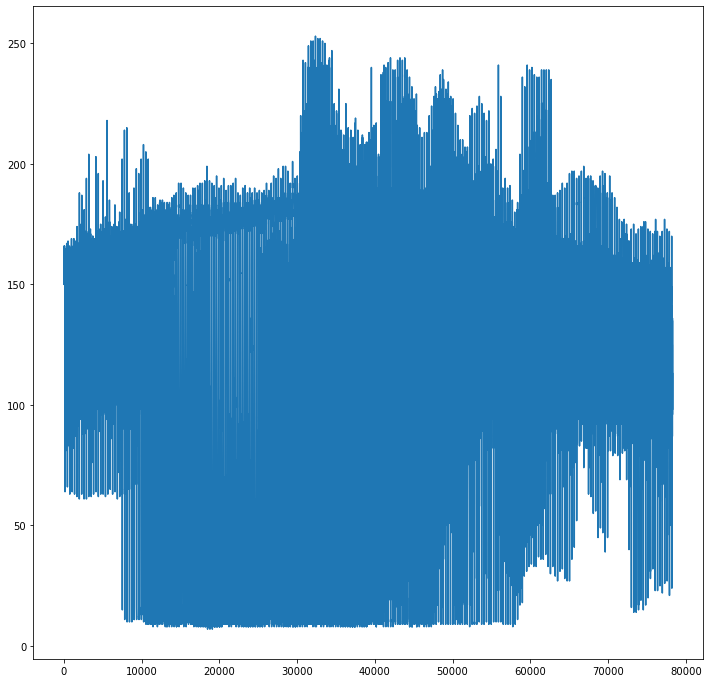

In [181]:
import numpy as np
import matplotlib.pyplot as plt
from ssqueezepy import ssq_cwt, ssq_stft, experimental, Wavelet,icwt

def viz(x, Tx, Wx):
    plt.imshow(np.abs(Wx), aspect='auto', cmap='turbo')
    plt.show()
    plt.imshow(np.abs(Tx), aspect='auto', vmin=0, vmax=.2, cmap='turbo')
    plt.show()

plt.plot(serilized_x); plt.show()



In [164]:
efd, cerf, bounds = EFD(serilized_x,14) 
print(efd.shape)

39143
(15, 78286)


In [193]:
processed = numpy.zeros_like(efd)
processed[0,:] = efd[0,:]
wavelet = Wavelet()

for each in range(1,efd.shape[0]):
    Tx0, Wx, _, scales, *_ = ssq_cwt(efd[each,:], wavelet, get_dWx=1)
    squeezed, *_ = experimental.phase_ssqueeze(Wx, wavelet=wavelet, scales=scales, flipud=1)
    processed[each,:] = icwt(squeezed, wavelet=wavelet, scales='log-piecewise', nv=None, one_int=True\
         ,x_len=None, x_mean=0, padtype='zero', rpadded=False, l1_norm=True)



In [196]:
serilized_imfs = processed.transpose(1,0)

    #serilized_imfs = EMD()(serilized_x).T
print(f'concatenated imfs shape:\t{serilized_imfs.shape}')

    #imfs for each signal, [num_length, num_imf_modes, num_signal]
imfs = sdeconcatenate(serilized_imfs, num_interval, num_signal)
print(f'multi-dimensional imfs shape:\t{imfs.shape}')

concatenated imfs shape:	(78286, 15)
multi-dimensional imfs shape:	(256, 15, 256)


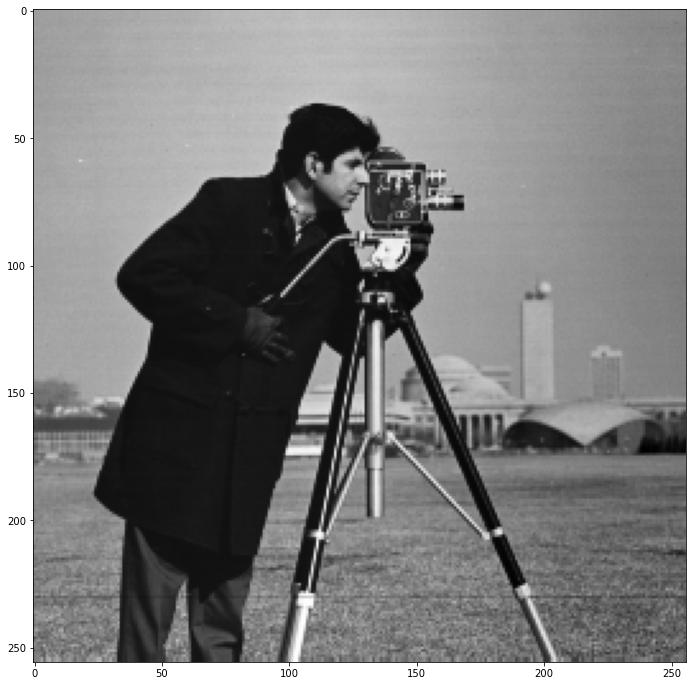

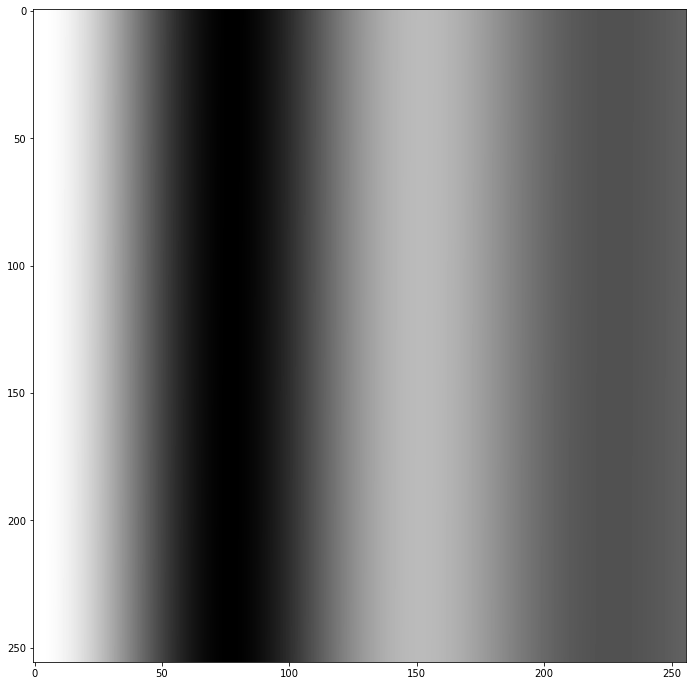

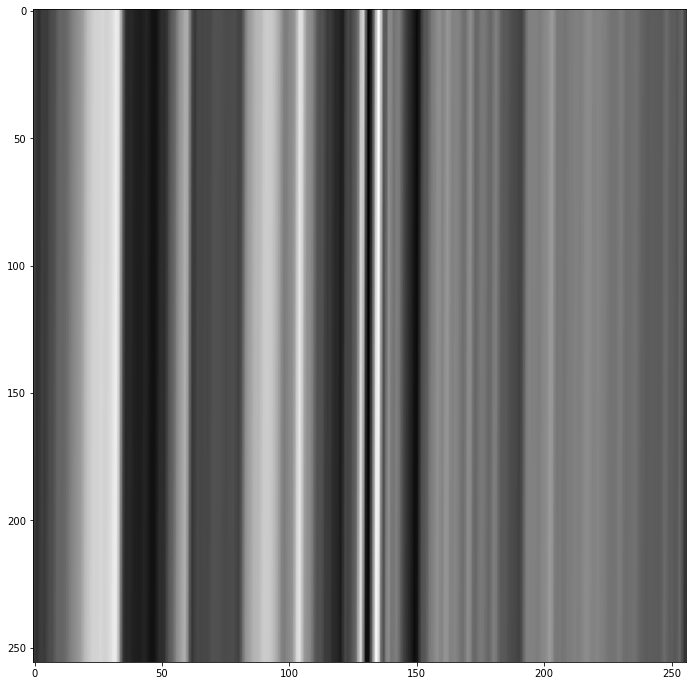

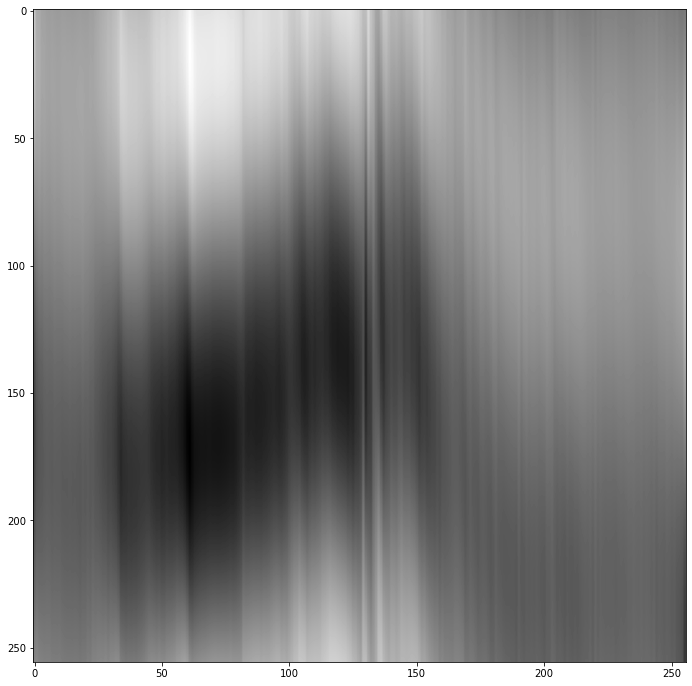

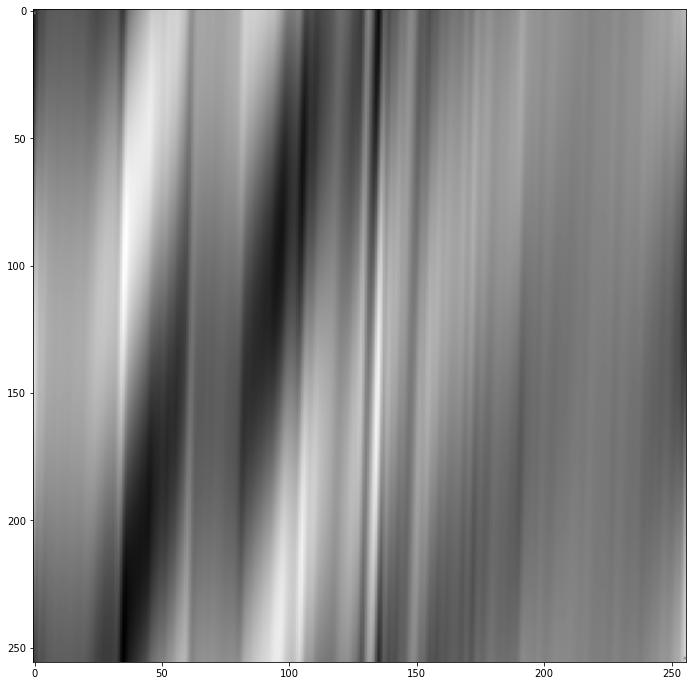

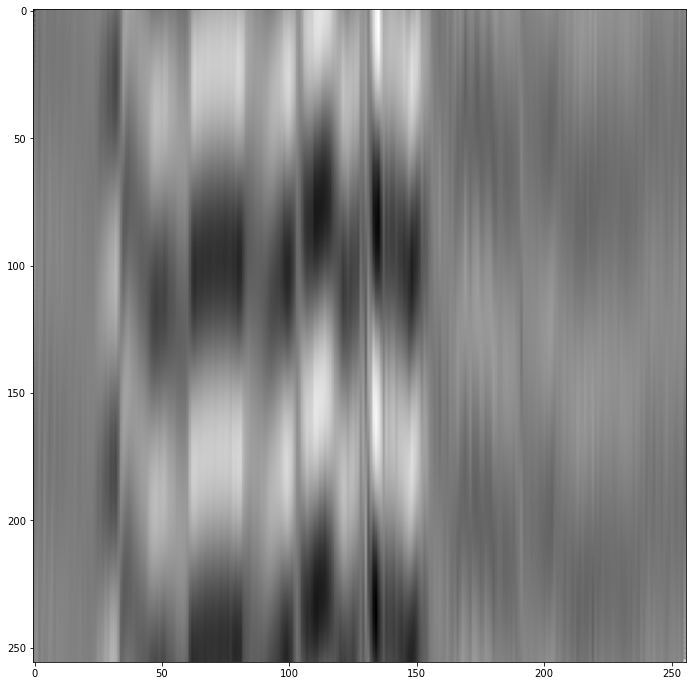

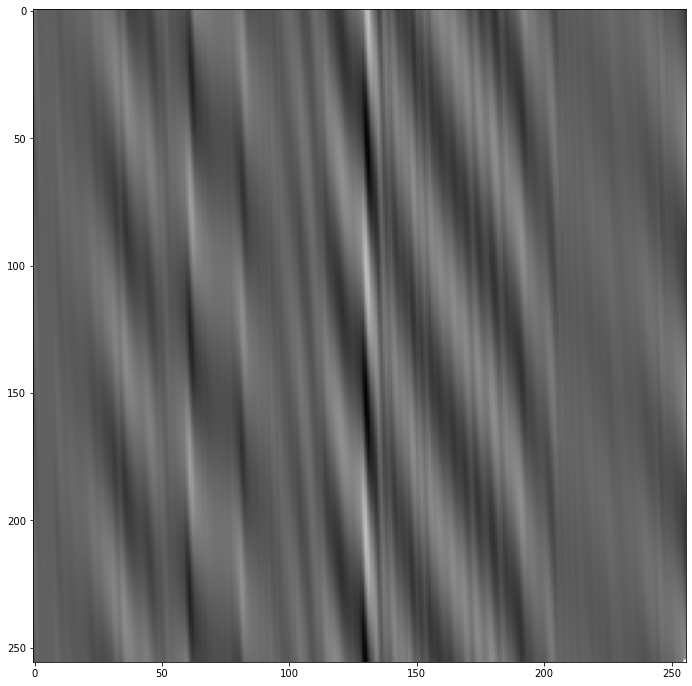

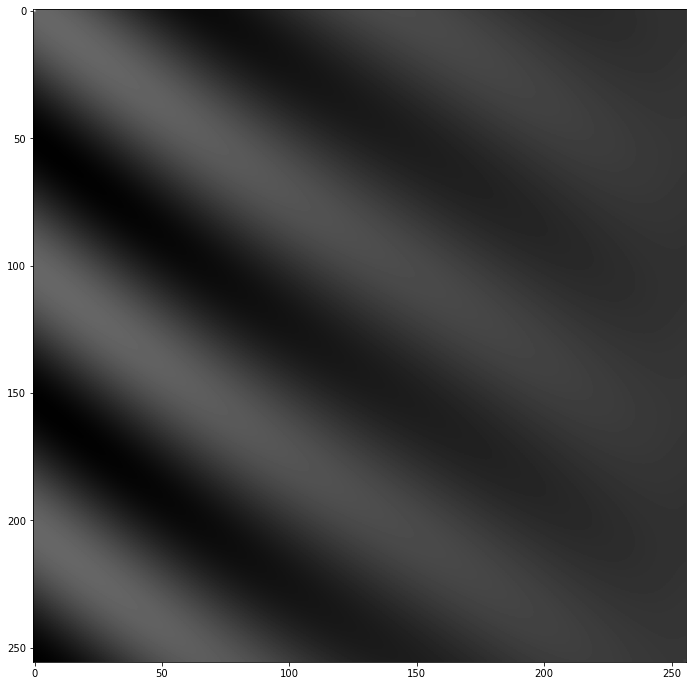

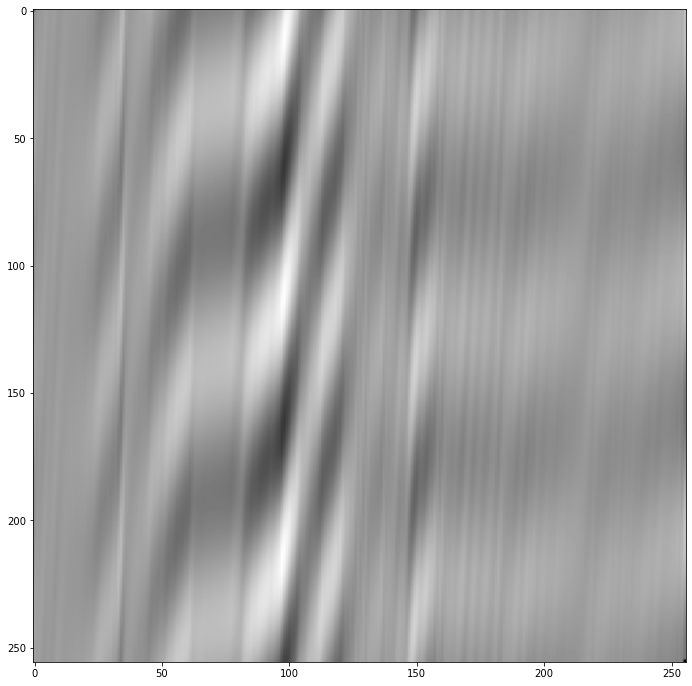

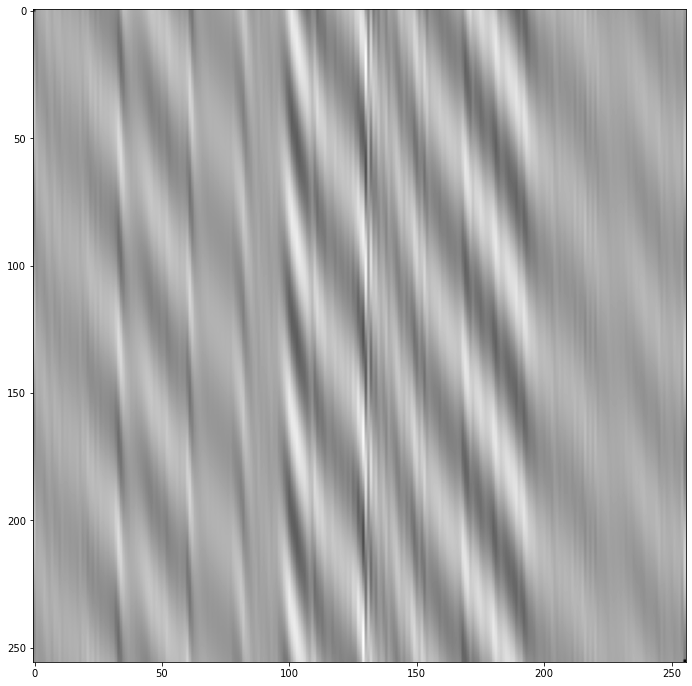

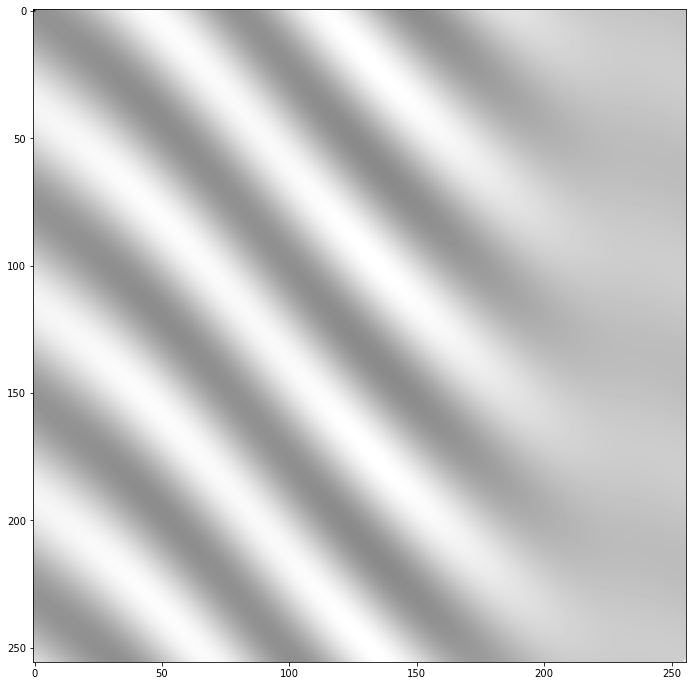

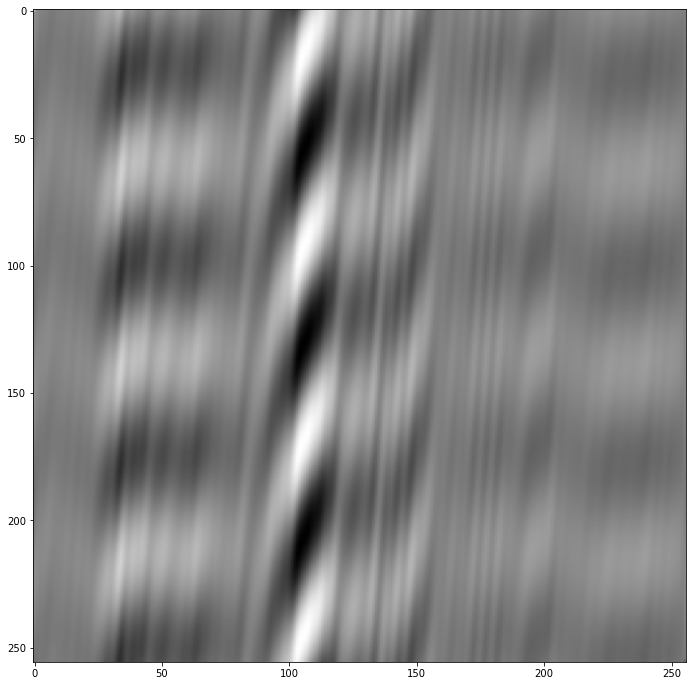

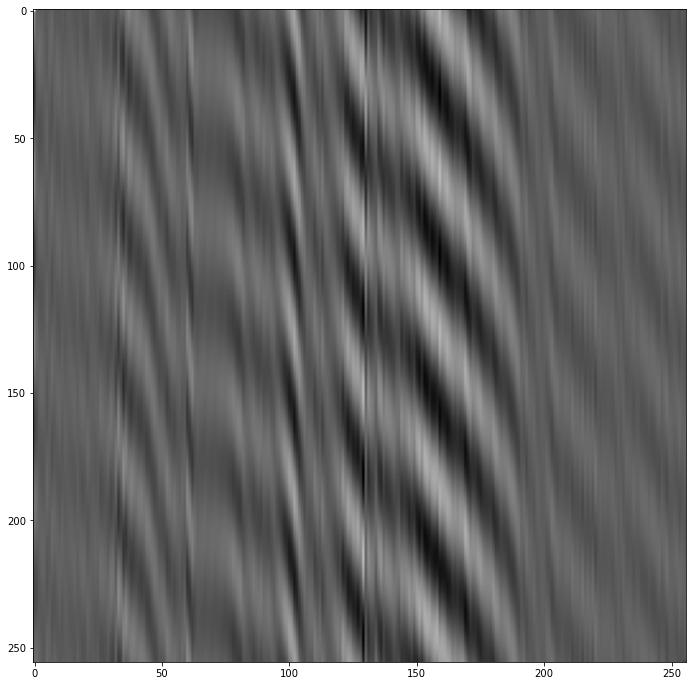

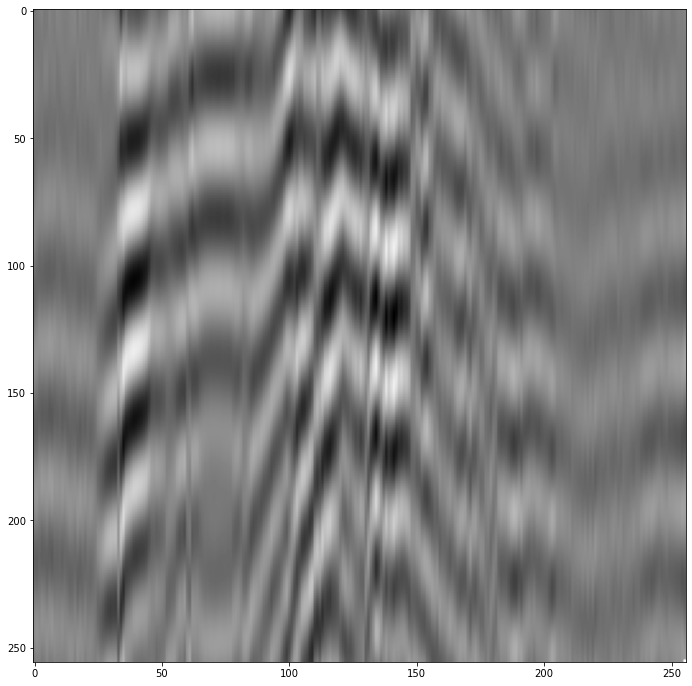

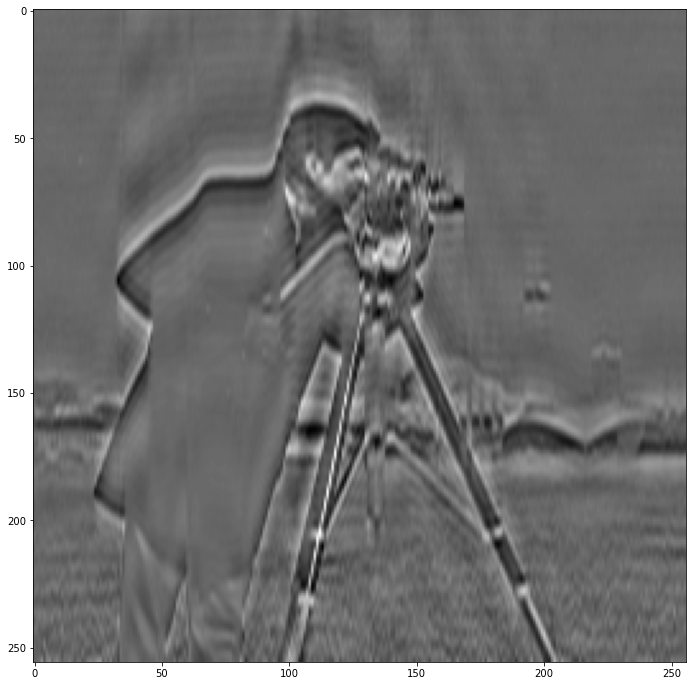

<Figure size 864x864 with 0 Axes>

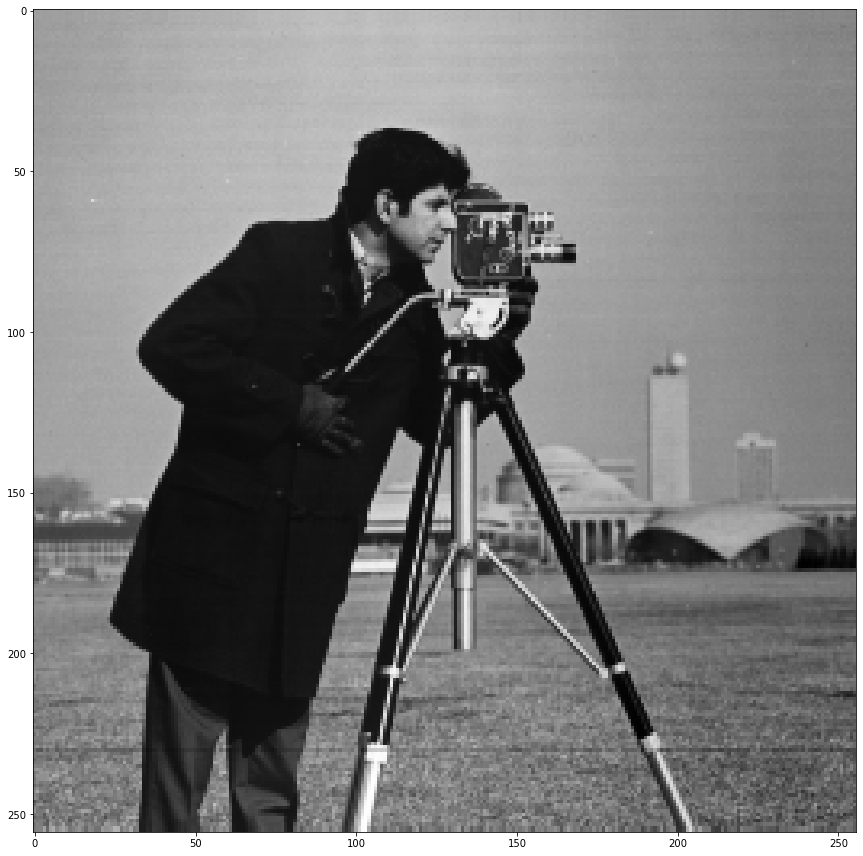

In [197]:
#note: the first product for ETD is generally a copy of the original but shifted.
#I am not sure why ETD does this. however, it distorts the output considerably.


import math
import matplotlib.pyplot as plt


imfs_cleaned = sdeconcatenate(serilized_imfs, num_interval, num_signal)

plt.rcParams["figure.figsize"] = (12,12)


for i in range(imfs_cleaned.shape[1]):
        plt.imshow(imfs_cleaned[:,i,:],cmap="gray")   
        plt.figure()

plt.tight_layout()
plt.show()
def fsum_for(a):
    return numpy.array([math.fsum(row) for row in a.T])
#[imfs_cleaned[:,row,:] for row in [0]]

a = np.apply_along_axis(math.fsum, 1, imfs_cleaned)

plt.imshow(a,cmap="gray") #this is the re-combined output
plt.tight_layout()
plt.show()

